In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [23]:
df_stl = pd.read_csv('../processed_data/STL/stl_energy_production_with_engineered_features.csv')
df_stl['Station'] = 'STL'

correlation_matrix_stl = df_stl.corr(numeric_only=True)
print("Correlation Matrix for STL data:")
print(correlation_matrix_stl)

df_hp = pd.read_csv('../processed_data/HP/hp_energy_production_with_engineered_features.csv')
df_hp['Station'] = 'HP'

correlation_matrix_hp = df_hp.corr(numeric_only=True)
print("Correlation Matrix for HP data:")
print(correlation_matrix_hp)

Correlation Matrix for STL data:
                       Water_Flow_m3_s  avgtempC  totalprecipMM  humidity  \
Water_Flow_m3_s               1.000000  0.165822       0.117623  0.054001   
avgtempC                      0.165822  1.000000       0.004432 -0.524531   
totalprecipMM                 0.117623  0.004432       1.000000  0.438469   
humidity                      0.054001 -0.524531       0.438469  1.000000   
pressureMB                   -0.132434 -0.804607      -0.266567  0.273961   
Month                        -0.055919  0.348227      -0.111156 -0.198198   
WaterFlow_Diff_1d             0.629523 -0.000207      -0.000070  0.001100   
WaterFlow_Diff_7d             0.632649 -0.003247       0.012196  0.006138   
WaterFlow_3day_avg            0.686257  0.241962       0.170623  0.077520   
WaterFlow_7day_avg            0.782547  0.241252       0.162687  0.075973   
Temp_Deviation                0.165822  1.000000       0.004432 -0.524531   
WaterFlow_Humidity            0.955444  0.0

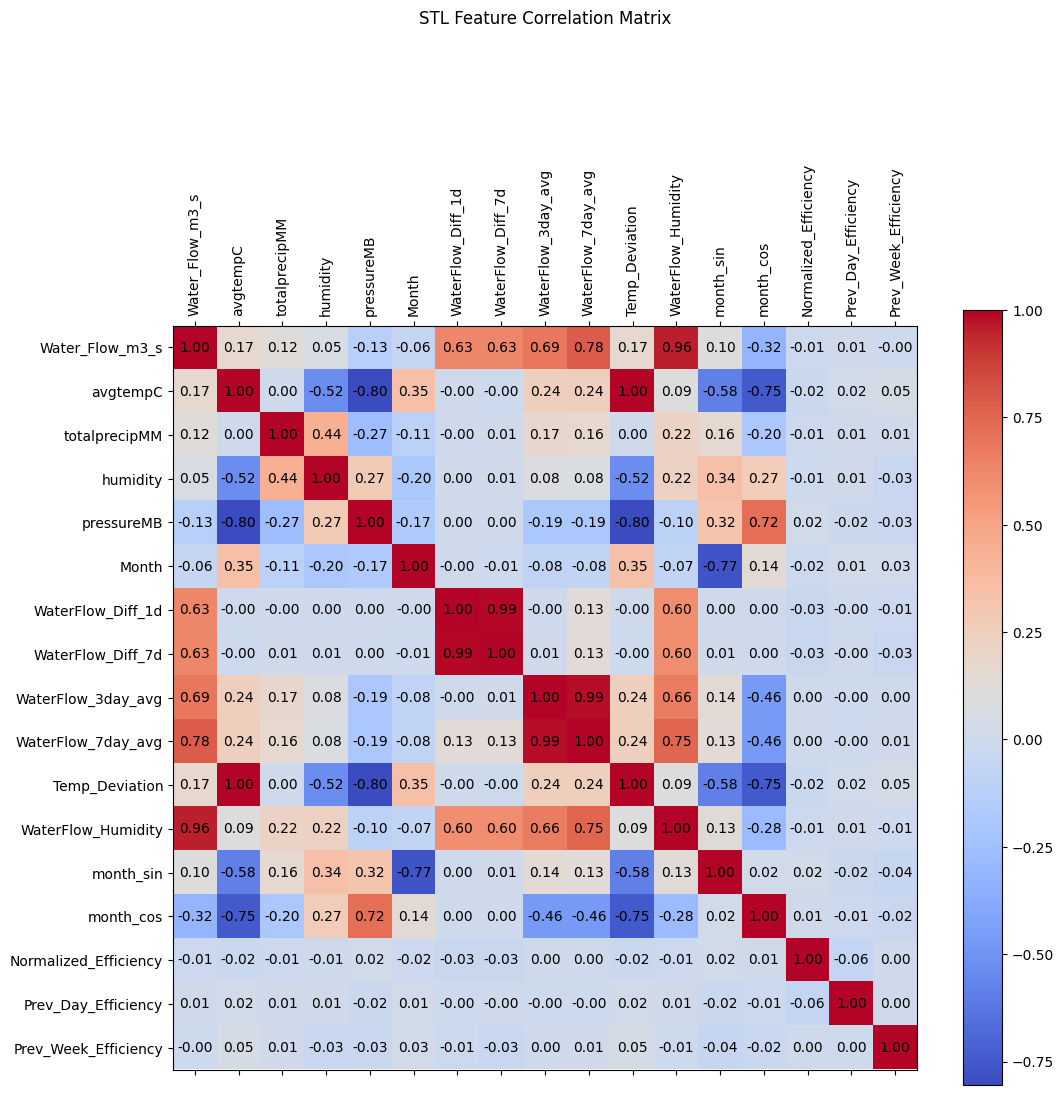

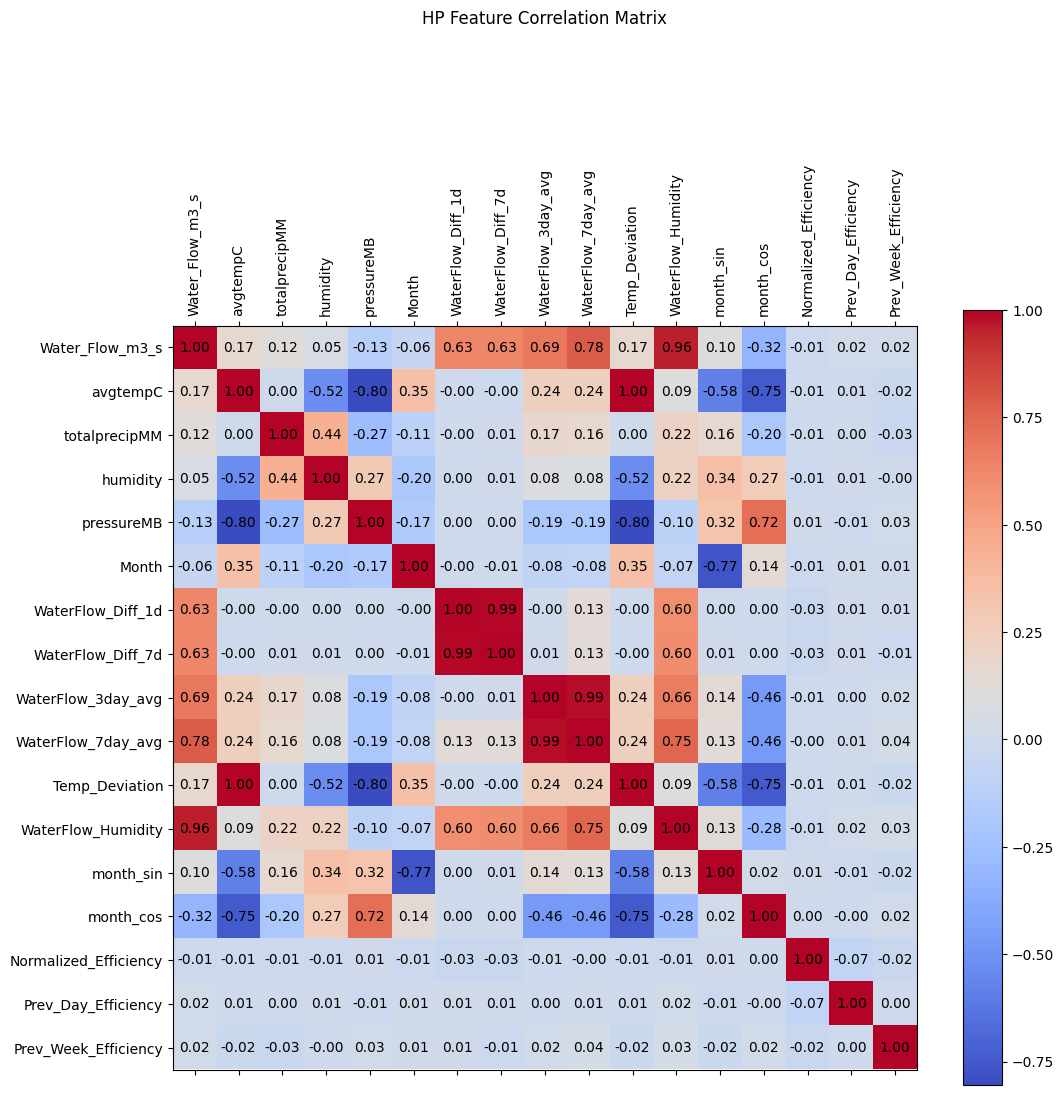

In [24]:
# --- Plot for STL Data ---
plt.figure(figsize=(12, 10))
plt.matshow(correlation_matrix_stl, fignum=1, cmap='coolwarm')
plt.xticks(range(len(correlation_matrix_stl.columns)), correlation_matrix_stl.columns, rotation=90)
plt.yticks(range(len(correlation_matrix_stl.columns)), correlation_matrix_stl.columns)
plt.colorbar()
plt.title("STL Feature Correlation Matrix", pad=100)

for i in range(len(correlation_matrix_stl.columns)):
    for j in range(len(correlation_matrix_stl.columns)):
        plt.text(j, i, f"{correlation_matrix_stl.iloc[i, j]:.2f}",
                 ha='center', va='center', color='black')

plt.show()


# --- Plot for HP Data ---
plt.figure(figsize=(12, 10))
plt.matshow(correlation_matrix_hp, fignum=1, cmap='coolwarm')
plt.xticks(range(len(correlation_matrix_hp.columns)), correlation_matrix_hp.columns, rotation=90)
plt.yticks(range(len(correlation_matrix_hp.columns)), correlation_matrix_hp.columns)
plt.colorbar()
plt.title("HP Feature Correlation Matrix", pad=100)

for i in range(len(correlation_matrix_hp.columns)):
    for j in range(len(correlation_matrix_hp.columns)):
        plt.text(j, i, f"{correlation_matrix_hp.iloc[i, j]:.2f}",
                 ha='center', va='center', color='black')

plt.show()


In [25]:
# --- For STL Dataset ---

df_stl_numeric = df_stl.select_dtypes(include=['number'])
X_stl = df_stl_numeric.drop(columns=['Normalized_Efficiency'])
y_stl = df_stl_numeric['Normalized_Efficiency']

mi_stl = mutual_info_regression(X_stl, y_stl)
feature_mi_stl = pd.Series(mi_stl, index=X_stl.columns).sort_values(ascending=False)
print("Mutual Information for STL:")
print(feature_mi_stl)

# --- For HP Dataset ---

df_hp_numeric = df_hp.select_dtypes(include=['number'])
X_hp = df_hp_numeric.drop(columns=['Normalized_Efficiency'])
y_hp = df_hp_numeric['Normalized_Efficiency']

mi_hp = mutual_info_regression(X_hp, y_hp)
feature_mi_hp = pd.Series(mi_hp, index=X_hp.columns).sort_values(ascending=False)
print("Mutual Information for HP:")
print(feature_mi_hp)

Mutual Information for STL:
Prev_Day_Efficiency     1.342761
totalprecipMM           0.268731
WaterFlow_3day_avg      0.249108
Water_Flow_m3_s         0.226295
WaterFlow_7day_avg      0.211920
WaterFlow_Diff_7d       0.192996
WaterFlow_Diff_1d       0.183762
avgtempC                0.171755
Temp_Deviation          0.169929
humidity                0.159028
WaterFlow_Humidity      0.157685
Month                   0.135466
Prev_Week_Efficiency    0.129484
pressureMB              0.117475
month_cos               0.083527
month_sin               0.058319
dtype: float64
Mutual Information for HP:
Prev_Day_Efficiency     1.456820
Prev_Week_Efficiency    0.318672
WaterFlow_3day_avg      0.312058
WaterFlow_7day_avg      0.290727
Water_Flow_m3_s         0.272145
WaterFlow_Diff_1d       0.237172
totalprecipMM           0.236359
WaterFlow_Diff_7d       0.227004
avgtempC                0.174265
Temp_Deviation          0.174033
WaterFlow_Humidity      0.165172
humidity                0.153674
Month 

In [26]:
# For STL Data

df_stl_num = df_stl.select_dtypes(include=['number']).dropna()
X_stl = df_stl_num.drop(columns=['Normalized_Efficiency'])
y_stl = df_stl_num['Normalized_Efficiency']

from sklearn.model_selection import train_test_split
X_stl_train, X_stl_test, y_stl_train, y_stl_test = train_test_split(
    X_stl, y_stl, test_size=0.2, random_state=42
)

from sklearn.preprocessing import StandardScaler
scaler_stl = StandardScaler()
X_stl_train_scaled = scaler_stl.fit_transform(X_stl_train)
X_stl_test_scaled = scaler_stl.transform(X_stl_test)


# For HP Data

df_hp_num = df_hp.select_dtypes(include=['number']).dropna()

X_hp = df_hp_num.drop(columns=['Normalized_Efficiency'])
y_hp = df_hp_num['Normalized_Efficiency']

X_hp_train, X_hp_test, y_hp_train, y_hp_test = train_test_split(
    X_hp, y_hp, test_size=0.2, random_state=42
)

scaler_hp = StandardScaler()
X_hp_train_scaled = scaler_hp.fit_transform(X_hp_train)
X_hp_test_scaled = scaler_hp.transform(X_hp_test)

In [27]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.1, random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(n_estimators=200, max_depth=7, learning_rate=0.1, random_state=42, verbose=-1),
    "CatBoost": CatBoostRegressor(n_estimators=200, depth=7, learning_rate=0.1, random_state=42, verbose=0),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regression": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=10),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "Multiple Linear Regression (MLR)": LinearRegression(),
    "SVR": SVR()
}

In [10]:
# --- STL Data ---
predictions_stl = {}
metrics_stl = {
    "Model": [],
    "MSE": [],
    "RMSE": [],
    "MAE": [],
    "R2": []
}

for name, model in tqdm(models.items(), desc="Training STL Models"):
    model.fit(X_stl_train_scaled, y_stl_train)
    y_pred = model.predict(X_stl_test_scaled)
    predictions_stl[name] = y_pred

    mse = mean_squared_error(y_stl_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_stl_test, y_pred)
    r2 = r2_score(y_stl_test, y_pred)

    metrics_stl["Model"].append(name)
    metrics_stl["MSE"].append(mse)
    metrics_stl["RMSE"].append(rmse)
    metrics_stl["MAE"].append(mae)
    metrics_stl["R2"].append(r2)


metrics_df_stl = pd.DataFrame(metrics_stl)

/Users/elvinanosrati/Capstone/energy-production-analysis/myenv-py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Training STL Models: 100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:25<00:00,  1.81s/it]


In [11]:
metrics_df_stl

Model           MSE        RMSE        MAE  \
0                   LinearRegression  22256.979746  149.187733   4.636721   
1                              Ridge  22257.176588  149.188393   4.635078   
2                              Lasso  22270.509442  149.233071   4.576566   
3                       RandomForest  20485.357277  143.127067   3.774220   
4                            XGBoost  19664.088975  140.228702   3.687505   
5                           LightGBM  21389.277544  146.250735   3.988185   
6                           CatBoost  19711.629969  140.398112   3.807698   
7                   GradientBoosting  19665.666200  140.234326   3.809162   
8          Support Vector Regression  22271.689079  149.237023   4.392678   
9                K-Nearest Neighbors  21997.312974  148.314912   4.443435   
10                          AdaBoost  19736.911648  140.488119  12.409490   
11                      DecisionTree  19643.907333  140.156724   3.943434   
12  Multiple Linear Regression (MLR)  22256.979746  149.187733   4.636721   
13                               SVR  22271.689079  149.237023   4.392678   

          R2  
0   0.000164  
1   0.000155  
2  -0.000444  
3   0.079749  
4   0.116643  
5   0.039143  
6   0.114507  
7   0.116572  
8  -0.000497  
9   0.011829  
10  0.113371  
11  0.117549  
12  0.000164  
13 -0.000497

In [13]:
# --- HP Data ---
predictions_hp = {}
metrics_hp = {
    "Model": [],
    "MSE": [],
    "RMSE": [],
    "MAE": [],
    "R2": []
}

for name, model in tqdm(models.items(), desc="Training HP Models"):
    model.fit(X_hp_train_scaled, y_hp_train)
    y_pred = model.predict(X_hp_test_scaled)
    predictions_hp[name] = y_pred

    mse = mean_squared_error(y_hp_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_hp_test, y_pred)
    r2 = r2_score(y_hp_test, y_pred)

    metrics_hp["Model"].append(name)
    metrics_hp["MSE"].append(mse)
    metrics_hp["RMSE"].append(rmse)
    metrics_hp["MAE"].append(mae)
    metrics_hp["R2"].append(r2)
    
metrics_df_hp = pd.DataFrame(metrics_hp)

/Users/elvinanosrati/Capstone/energy-production-analysis/myenv-py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Training HP Models: 100%|███████████████████████████████████████████████████████████████████████████████████| 14/14 [00:23<00:00,  1.68s/it]


In [14]:
metrics_df_hp

Model           MSE        RMSE       MAE  \
0                   LinearRegression  21274.971689  145.859424  6.564382   
1                              Ridge  21275.256955  145.860402  6.558725   
2                              Lasso  21300.729135  145.947693  6.395280   
3                       RandomForest  19876.234220  140.983099  4.760758   
4                            XGBoost  19913.689293  141.115872  4.532937   
5                           LightGBM  20724.831592  143.961216  5.256797   
6                           CatBoost  20017.690209  141.483887  4.882346   
7                   GradientBoosting  19256.775448  138.768784  4.950681   
8          Support Vector Regression  21293.586741  145.923222  5.863649   
9                K-Nearest Neighbors  21042.172639  145.059204  5.886823   
10                          AdaBoost  20287.312950  142.433539  6.612950   
11                      DecisionTree  18794.797873  137.094120  4.870161   
12  Multiple Linear Regression (MLR)  21274.971689  145.859424  6.564382   
13                               SVR  21293.586741  145.923222  5.863649   

          R2  
0   0.001270  
1   0.001256  
2   0.000061  
3   0.066932  
4   0.065174  
5   0.027096  
6   0.060292  
7   0.096012  
8   0.000396  
9   0.012198  
10  0.047634  
11  0.117699  
12  0.001270  
13  0.000396

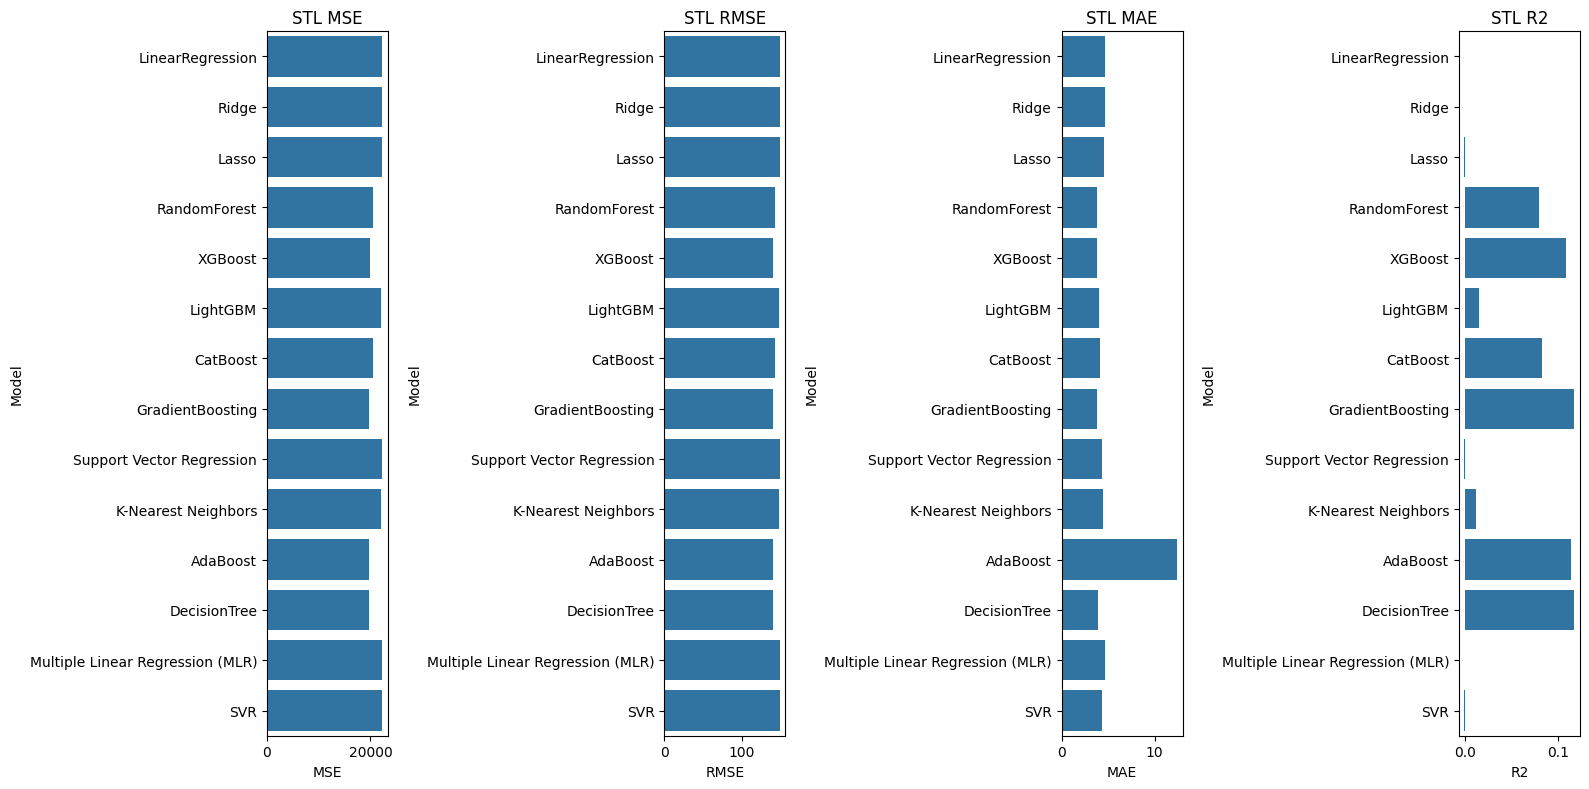

In [34]:
plt.figure(figsize=(16, 8))
for i, metric in enumerate(["MSE", "RMSE", "MAE", "R2"]):
    plt.subplot(1, 4, i + 1)
    sns.barplot(y="Model", x=metric, data=metrics_df_stl)
    plt.title("STL " + metric)
    plt.tight_layout()
plt.show()

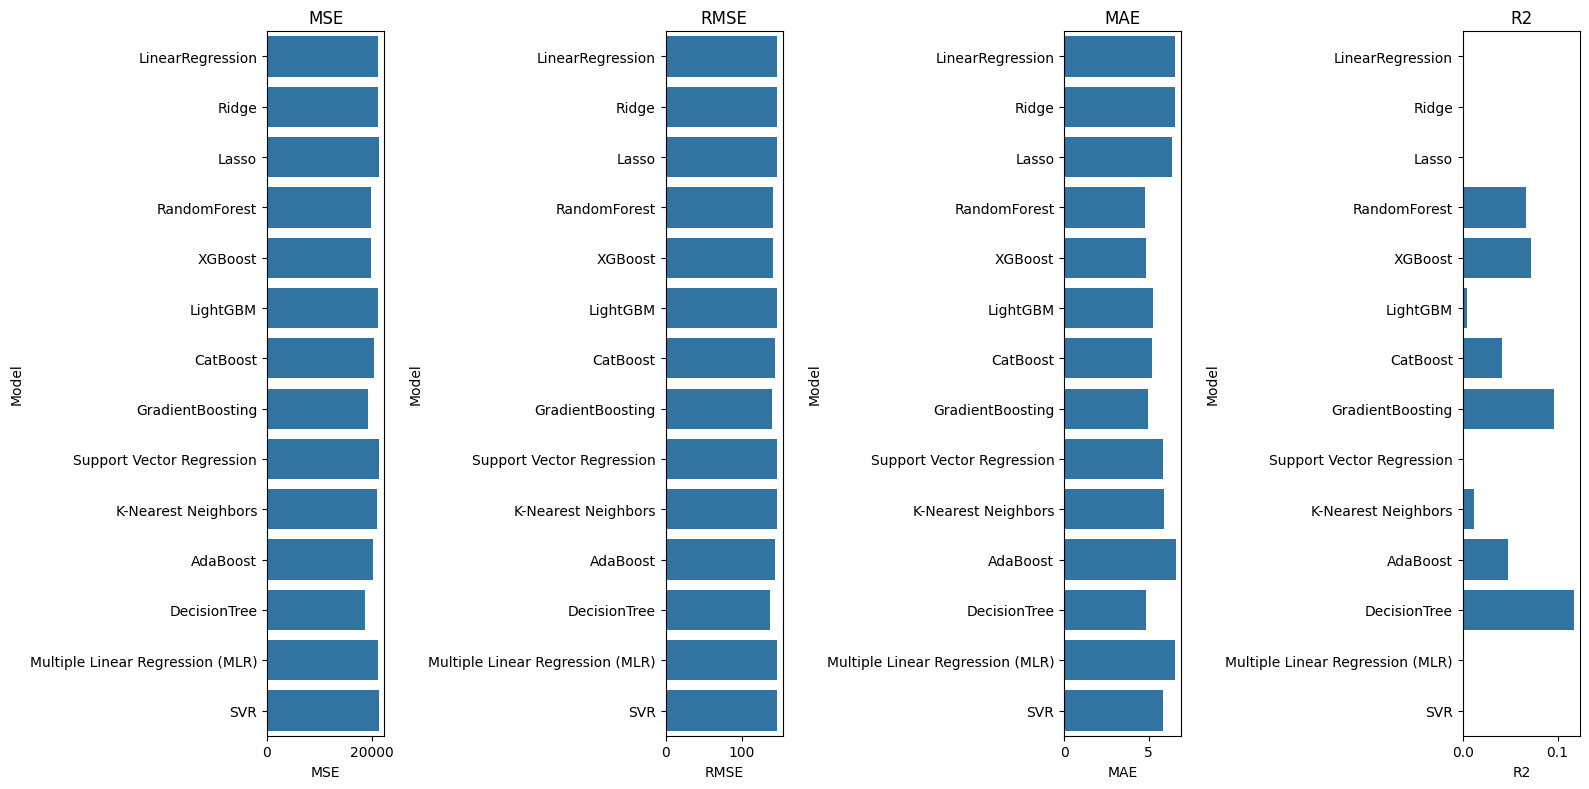

In [35]:
plt.figure(figsize=(16, 8))
for i, metric in enumerate(["MSE", "RMSE", "MAE", "R2"]):
    plt.subplot(1, 4, i + 1)
    sns.barplot(y="Model", x=metric, data=metrics_df_hp)
    plt.title(metric)
    plt.tight_layout()
plt.show()

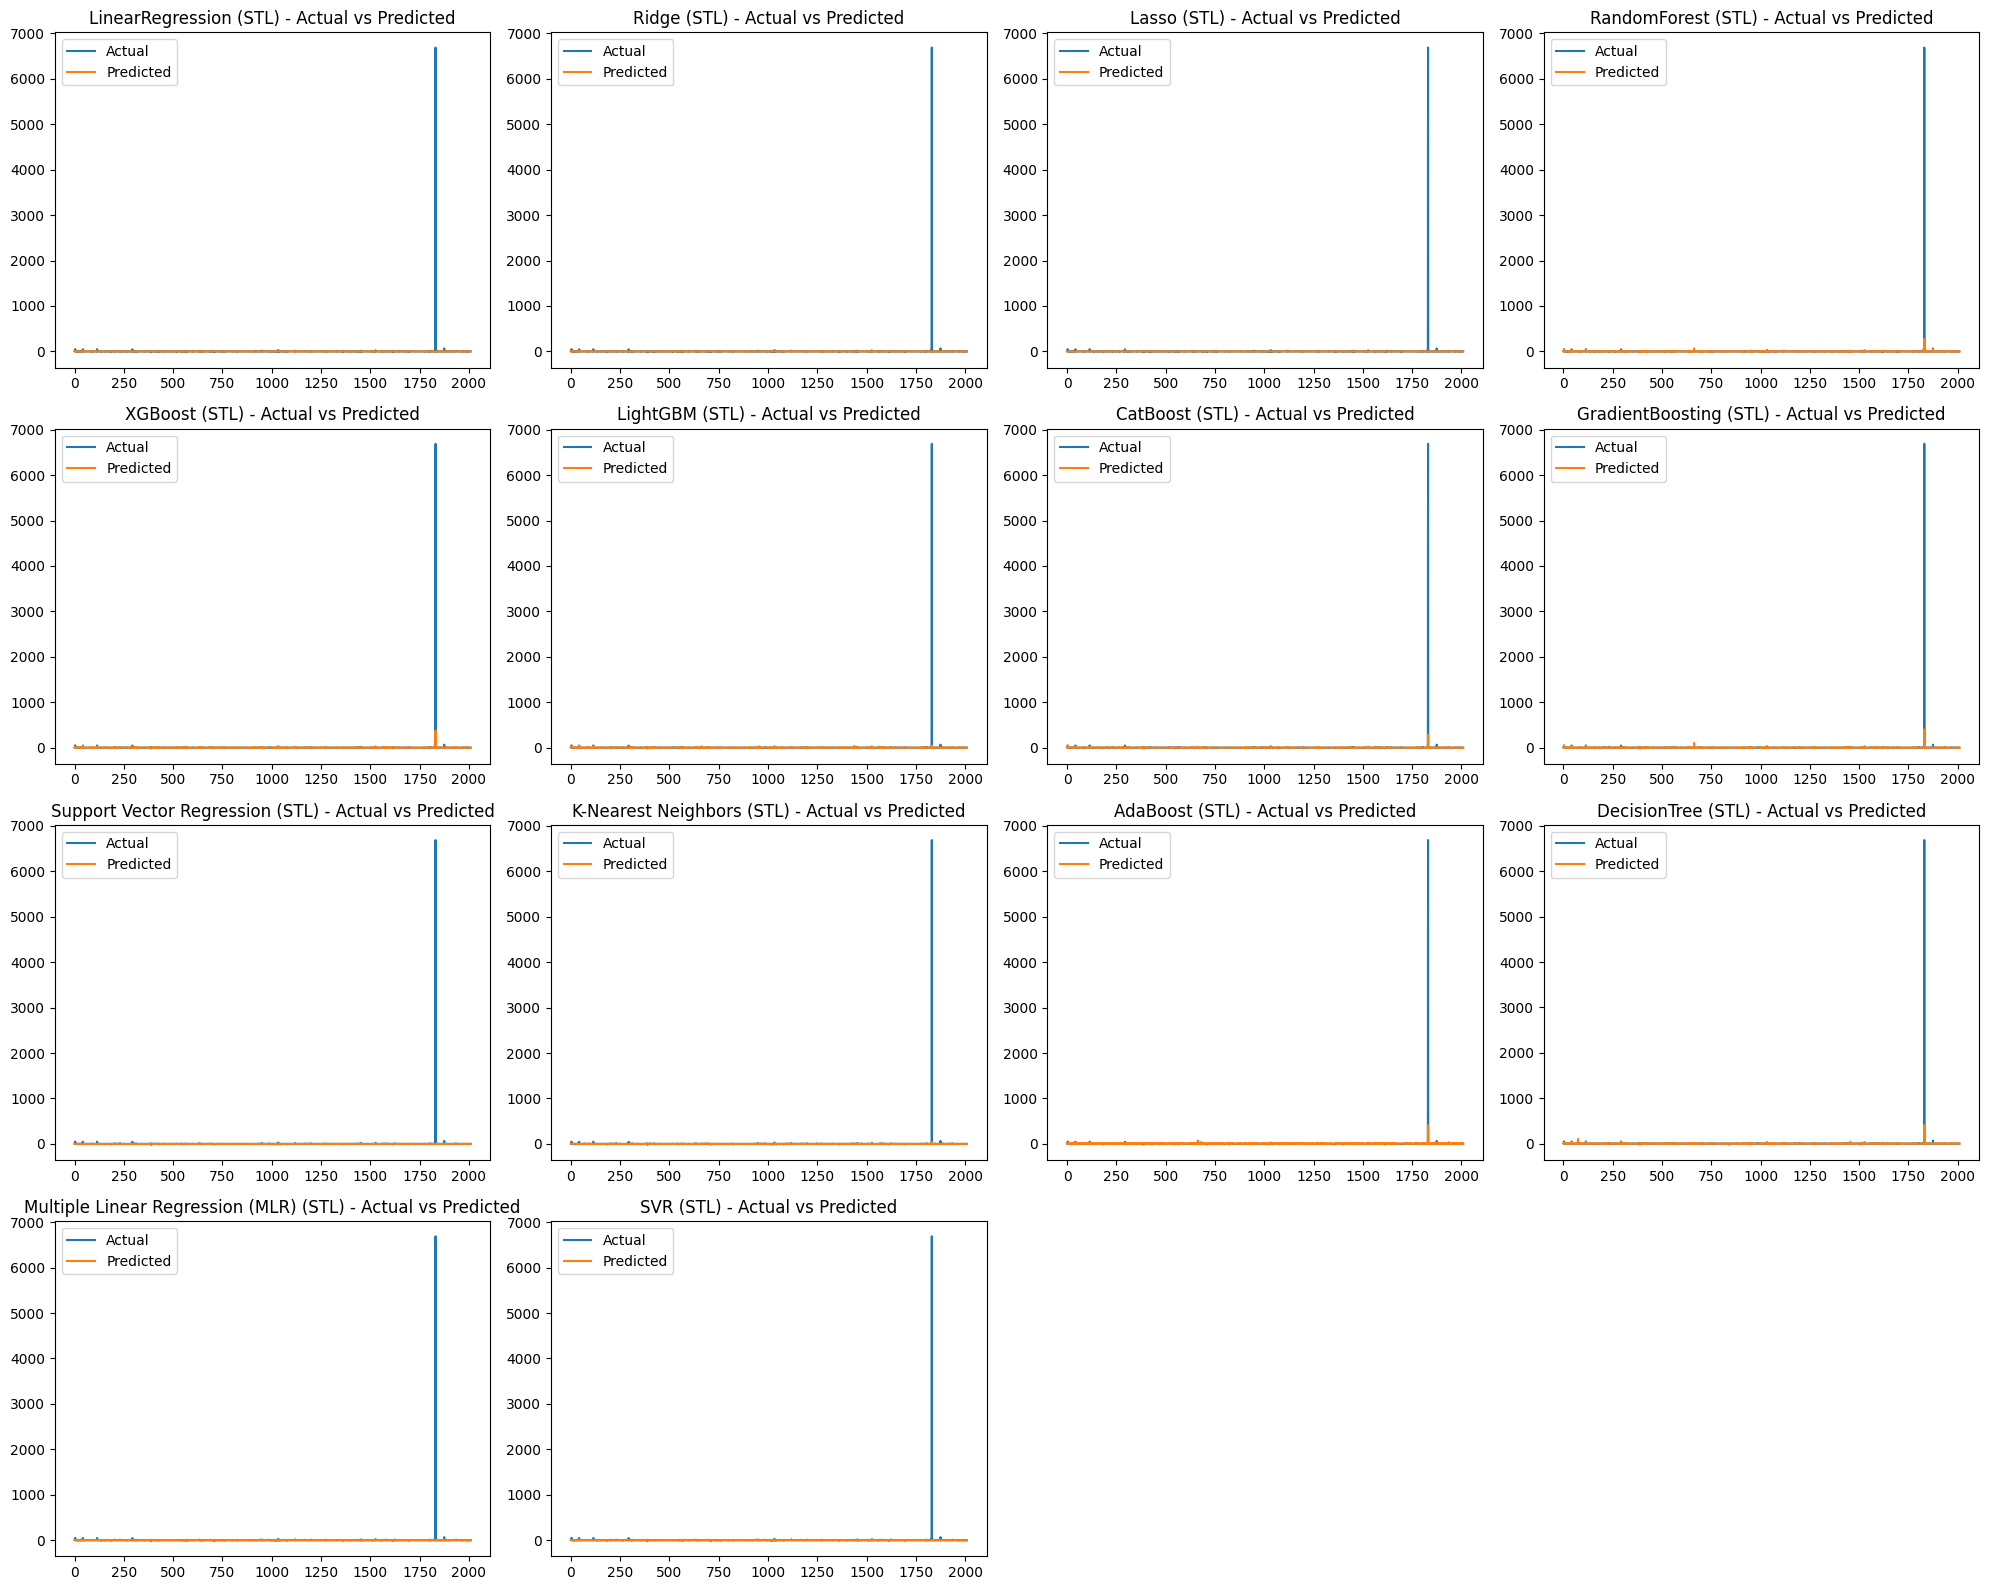

In [39]:
# --- STL ---
import math

cols_stl = 4
num_models_stl = len(predictions_stl) 
rows_stl = math.ceil(num_models_stl / cols_stl)  

plt.figure(figsize=(20, 16))
for i, (name, y_pred) in enumerate(predictions_stl.items()):
    plt.subplot(rows_stl, cols_stl, i + 1)
    plt.plot(y_stl_test.values, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f"{name} (STL) - Actual vs Predicted")
    plt.legend()
plt.tight_layout()
plt.show()

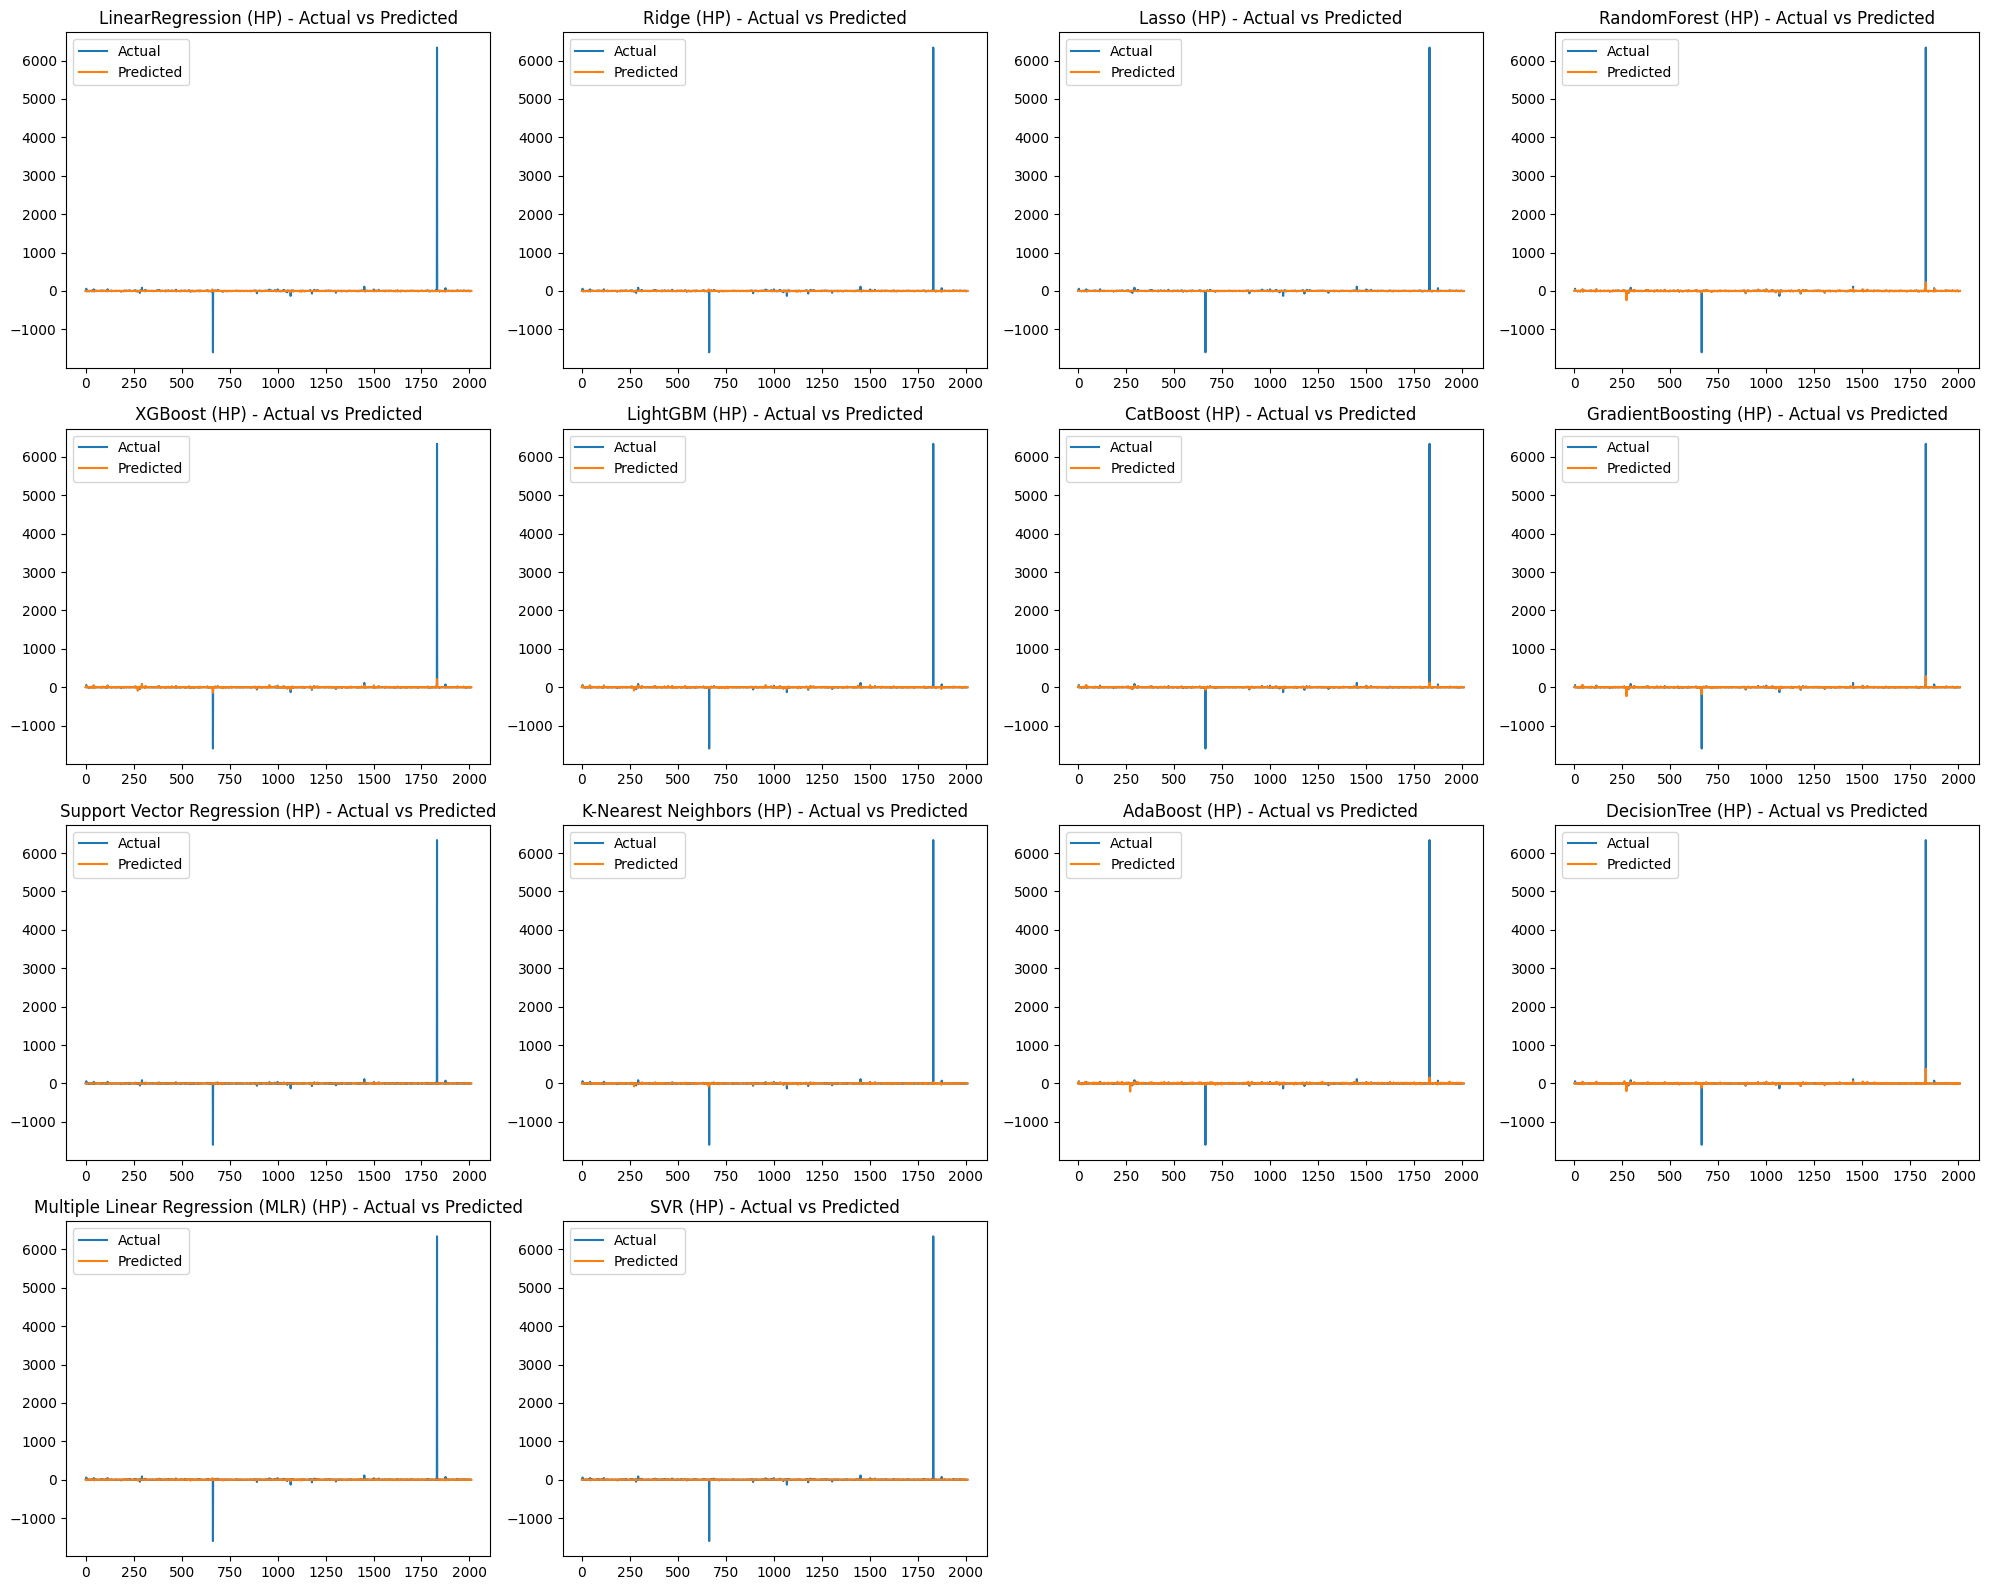

In [40]:
# --- HP ---

cols_hp = 4
num_models_hp = len(predictions_hp) 
rows_hp = math.ceil(num_models_hp / cols_hp)  

plt.figure(figsize=(20, 16))
for i, (name, y_pred) in enumerate(predictions_hp.items()):
    plt.subplot(rows_hp, cols_hp, i + 1)
    plt.plot(y_hp_test.values, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f"{name} (HP) - Actual vs Predicted")
    plt.legend()
plt.tight_layout()
plt.show()

In [49]:
# --- STL ---
X_stl_tensor = torch.tensor(X_stl.values, dtype=torch.float32)
y_stl_tensor = torch.tensor(y_stl.values, dtype=torch.float32).view(-1, 1)

X_stl_train_tensor = torch.tensor(X_stl_train_scaled, dtype=torch.float32)
X_stl_test_tensor  = torch.tensor(X_stl_test_scaled, dtype=torch.float32)
X_stl_train_tensor_tabular = torch.tensor(X_stl_train.values, dtype=torch.float32)
X_stl_test_tensor_tabular  = torch.tensor(X_stl_test.values,  dtype=torch.float32)
y_stl_train_tensor = torch.tensor(y_stl_train.values, dtype=torch.float32).view(-1, 1)
y_stl_test_tensor  = torch.tensor(y_stl_test.values, dtype=torch.float32).view(-1, 1)

train_dataset_stl = TensorDataset(X_stl_train_tensor, y_stl_train_tensor)
test_dataset_stl  = TensorDataset(X_stl_test_tensor, y_stl_test_tensor)

train_dataset_stl_tabular = TensorDataset(X_stl_train_tensor_tabular, y_stl_train_tensor)
test_dataset_stl_tabular  = TensorDataset(X_stl_test_tensor_tabular,  y_stl_test_tensor)

train_loader_stl = DataLoader(train_dataset_stl, batch_size=64, shuffle=True)
test_loader_stl  = DataLoader(test_dataset_stl, batch_size=64, shuffle=False)

train_loader_stl_tabular = DataLoader(train_dataset_stl_tabular, batch_size=256, shuffle=True)
test_loader_stl_tabular  = DataLoader(test_dataset_stl_tabular,  batch_size=256, shuffle=False)

In [50]:
# --- HP ---
X_hp_train_tensor = torch.tensor(X_hp_train_scaled, dtype=torch.float32)
X_hp_test_tensor  = torch.tensor(X_hp_test_scaled,  dtype=torch.float32)
X_hp_train_tensor_tabular = torch.tensor(X_hp_train.values, dtype=torch.float32)
X_hp_test_tensor_tabular  = torch.tensor(X_hp_test.values,  dtype=torch.float32)
y_hp_train_tensor = torch.tensor(y_hp_train.values, dtype=torch.float32).view(-1, 1)
y_hp_test_tensor  = torch.tensor(y_hp_test.values,  dtype=torch.float32).view(-1, 1)

train_dataset_hp = TensorDataset(X_hp_train_tensor, y_hp_train_tensor)
test_dataset_hp  = TensorDataset(X_hp_test_tensor,  y_hp_test_tensor)

train_dataset_hp_tabular = TensorDataset(X_hp_train_tensor_tabular, y_hp_train_tensor)
test_dataset_hp_tabular  = TensorDataset(X_hp_test_tensor_tabular,  y_hp_test_tensor)

train_loader_hp = DataLoader(train_dataset_hp, batch_size=64, shuffle=True)
test_loader_hp  = DataLoader(test_dataset_hp,  batch_size=64, shuffle=False)

train_loader_hp_tabular = DataLoader(train_dataset_hp_tabular, batch_size=256, shuffle=True)
test_loader_hp_tabular  = DataLoader(test_dataset_hp_tabular,  batch_size=256, shuffle=False)


In [51]:
class Net1(nn.Module):
    def __init__(self, input_dim):
        super(Net1, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


class Net2(nn.Module):
    def __init__(self, input_dim):
        super(Net2, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


class Net3(nn.Module):
    def __init__(self, input_dim):
        super(Net3, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

In [52]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class BiLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(BiLSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers,
                            dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(hidden_dim * 2, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class RNNNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(RNNNet, self).__init__()
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])


class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

class CNN1D(nn.Module):
    def __init__(self, input_dim, channels=[32, 64], kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        in_ch = input_dim
        for ch in channels:
            layers += [
                nn.Conv1d(in_ch, ch, kernel_size=kernel_size, padding=kernel_size//2),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            in_ch = ch
        self.cnn = nn.Sequential(*layers)
        self.fc = nn.Linear(channels[-1], 1)

    def forward(self, x):
        x = x.transpose(1, 2)     
        x = self.cnn(x)            
        x = x.mean(dim=2)          
        return self.fc(x)          


class CNNLSTM(nn.Module):
    def __init__(self, input_dim, cnn_channels=[32, 64], lstm_hidden=64, lstm_layers=1, dropout=0.2):
        super().__init__()
        convs = []
        in_ch = input_dim
        for ch in cnn_channels:
            convs += [
                nn.Conv1d(in_ch, ch, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            in_ch = ch
        self.cnn = nn.Sequential(*convs)
        self.lstm = nn.LSTM(input_size=cnn_channels[-1],
                            hidden_size=lstm_hidden,
                            num_layers=lstm_layers,
                            batch_first=True,
                            dropout=dropout if lstm_layers>1 else 0)
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        x = x.transpose(1, 2)      
        x = self.cnn(x)           
        x = x.transpose(1, 2)      
        out, _ = self.lstm(x)      
        return self.fc(out[:, -1, :])

class FNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

In [53]:
def train_model(name, model, train_loader, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,epochs=1000, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    history = []
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                y_train_pred = model(X_train_tensor)
                y_test_pred  = model(X_test_tensor)
                
                train_mse  = mean_squared_error(y_train_tensor.numpy(), y_train_pred.numpy())
                test_mse   = mean_squared_error(y_test_tensor.numpy(), y_test_pred.numpy())
                train_rmse = np.sqrt(train_mse)
                test_rmse  = np.sqrt(test_mse)
                train_mae  = mean_absolute_error(y_train_tensor.numpy(), y_train_pred.numpy())
                test_mae   = mean_absolute_error(y_test_tensor.numpy(), y_test_pred.numpy())
                train_r2   = r2_score(y_train_tensor.numpy(), y_train_pred.numpy())
                test_r2    = r2_score(y_test_tensor.numpy(), y_test_pred.numpy())
                
                print(f"\nModel: {name} | Epoch: {epoch}")
                print(f"Train: MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
                print(f"Test:  MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")
                
                history.append({
                    "Model": name,
                    "Epoch": epoch,
                    "Train MSE": train_mse,
                    "Test MSE": test_mse,
                    "Train RMSE": train_rmse,
                    "Test RMSE": test_rmse,
                    "Train MAE": train_mae,
                    "Test MAE": test_mae,
                    "Train R2": train_r2,
                    "Test R2": test_r2
                })
    return history

In [54]:
def train_ts_model(name, model, train_loader, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=200, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    history = []
    for epoch in tqdm(range(1, epochs + 1), desc=f"Training {name}"):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()    
            running_loss += loss.item()

        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                y_train_pred = model(X_train_tensor)
                y_test_pred  = model(X_test_tensor)

                train_mse = mean_squared_error(y_train_tensor.numpy(), y_train_pred.numpy())
                test_mse  = mean_squared_error(y_test_tensor.numpy(), y_test_pred.numpy())
                train_rmse = np.sqrt(train_mse)
                test_rmse  = np.sqrt(test_mse)
                train_mae = mean_absolute_error(y_train_tensor.numpy(), y_train_pred.numpy())
                test_mae  = mean_absolute_error(y_test_tensor.numpy(), y_test_pred.numpy())
                train_r2  = r2_score(y_train_tensor.numpy(), y_train_pred.numpy())
                test_r2   = r2_score(y_test_tensor.numpy(), y_test_pred.numpy())

                history.append({
                    "Model": name,
                    "Epoch": epoch,
                    "Train MSE": train_mse,
                    "Test MSE": test_mse,
                    "Train RMSE": train_rmse,
                    "Test RMSE": test_rmse,
                    "Train MAE": train_mae,
                    "Test MAE": test_mae,
                    "Train R2": train_r2,
                    "Test R2": test_r2
                })
        
        if epoch % 100 == 0:
            print(f"\nModel: {name} | Epoch: {epoch}")
            print(f"Train: MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
            print(f"Test:  MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")

    return history


In [55]:
nets_stl = {
    "Net1": Net1(X_stl.shape[1]),
    "Net2": Net2(X_stl.shape[1]),
    "Net3": Net3(X_stl.shape[1])
}


nets_hp = {
    "Net1": Net1(X_hp.shape[1]),
    "Net2": Net2(X_hp.shape[1]),
    "Net3": Net3(X_hp.shape[1])
}

nets_stl_tabular = {
    "Net1": Net1(X_stl.shape[1]),
    "Net2": Net2(X_stl.shape[1]),
    "Net3": Net3(X_stl.shape[1]),
    "FNN":  FNN(X_stl.shape[1])
}

nets_hp_tabular = {
    "Net1": Net1(X_hp.shape[1]),
    "Net2": Net2(X_hp.shape[1]),
    "Net3": Net3(X_hp.shape[1]),
    "FNN":  FNN(X_hp.shape[1])
}

In [42]:
results_stl = []
for name, net in nets_stl.items():
    results_stl += train_model(name, net, train_loader_stl, 
                               X_stl_train_tensor, y_stl_train_tensor, 
                               X_stl_test_tensor, y_stl_test_tensor,
                               epochs=1000, lr=1e-3)
    
nn_metrics_df_stl = pd.DataFrame(results_stl)

  1%|█                                                                                                    | 10/1000 [00:00<01:22, 11.97it/s]


Model: Net1 | Epoch: 10
Train: MSE: 52.0352, RMSE: 7.2135, MAE: 1.4446, R2: 0.1877
Test:  MSE: 22246.5625, RMSE: 149.1528, MAE: 4.6547, R2: 0.0006


  2%|██▏                                                                                                  | 22/1000 [00:01<01:26, 11.24it/s]


Model: Net1 | Epoch: 20
Train: MSE: 41.1991, RMSE: 6.4187, MAE: 1.3404, R2: 0.3569
Test:  MSE: 22246.0176, RMSE: 149.1510, MAE: 4.5827, R2: 0.0007


  3%|███▏                                                                                                 | 32/1000 [00:02<01:20, 12.00it/s]


Model: Net1 | Epoch: 30
Train: MSE: 38.9653, RMSE: 6.2422, MAE: 1.3710, R2: 0.3917
Test:  MSE: 22230.0254, RMSE: 149.0974, MAE: 4.6157, R2: 0.0014


  4%|████▏                                                                                                | 42/1000 [00:03<01:21, 11.80it/s]


Model: Net1 | Epoch: 40
Train: MSE: 37.9376, RMSE: 6.1593, MAE: 1.2949, R2: 0.4078
Test:  MSE: 22227.4102, RMSE: 149.0886, MAE: 4.5525, R2: 0.0015


  5%|█████▎                                                                                               | 52/1000 [00:04<01:19, 11.95it/s]


Model: Net1 | Epoch: 50
Train: MSE: 37.0499, RMSE: 6.0869, MAE: 1.1991, R2: 0.4216
Test:  MSE: 22232.0449, RMSE: 149.1041, MAE: 4.4644, R2: 0.0013


  6%|██████▎                                                                                              | 62/1000 [00:05<01:19, 11.80it/s]


Model: Net1 | Epoch: 60
Train: MSE: 36.3334, RMSE: 6.0277, MAE: 1.1923, R2: 0.4328
Test:  MSE: 22223.0918, RMSE: 149.0741, MAE: 4.4681, R2: 0.0017


  7%|███████▎                                                                                             | 72/1000 [00:06<01:17, 11.95it/s]


Model: Net1 | Epoch: 70
Train: MSE: 35.8432, RMSE: 5.9869, MAE: 1.1662, R2: 0.4405
Test:  MSE: 22220.8242, RMSE: 149.0665, MAE: 4.4407, R2: 0.0018


  8%|████████▎                                                                                            | 82/1000 [00:06<01:18, 11.77it/s]


Model: Net1 | Epoch: 80
Train: MSE: 35.5025, RMSE: 5.9584, MAE: 1.1685, R2: 0.4458
Test:  MSE: 22214.6602, RMSE: 149.0458, MAE: 4.4315, R2: 0.0021


  9%|█████████▎                                                                                           | 92/1000 [00:07<01:16, 11.88it/s]


Model: Net1 | Epoch: 90
Train: MSE: 35.3672, RMSE: 5.9470, MAE: 1.2886, R2: 0.4479
Test:  MSE: 22211.1641, RMSE: 149.0341, MAE: 4.5608, R2: 0.0022


 10%|██████████▏                                                                                         | 102/1000 [00:08<01:14, 12.03it/s]


Model: Net1 | Epoch: 100
Train: MSE: 35.3797, RMSE: 5.9481, MAE: 1.3737, R2: 0.4477
Test:  MSE: 22203.3711, RMSE: 149.0080, MAE: 4.6358, R2: 0.0026


 11%|███████████▏                                                                                        | 112/1000 [00:09<01:15, 11.79it/s]


Model: Net1 | Epoch: 110
Train: MSE: 34.7968, RMSE: 5.8989, MAE: 1.1166, R2: 0.4568
Test:  MSE: 22214.2559, RMSE: 149.0445, MAE: 4.3934, R2: 0.0021


 12%|████████████▏                                                                                       | 122/1000 [00:10<01:14, 11.81it/s]


Model: Net1 | Epoch: 120
Train: MSE: 34.7144, RMSE: 5.8919, MAE: 1.1609, R2: 0.4581
Test:  MSE: 22213.7227, RMSE: 149.0427, MAE: 4.4356, R2: 0.0021


 13%|█████████████▏                                                                                      | 132/1000 [00:11<01:14, 11.61it/s]


Model: Net1 | Epoch: 130
Train: MSE: 34.4309, RMSE: 5.8678, MAE: 1.1157, R2: 0.4625
Test:  MSE: 22208.9238, RMSE: 149.0266, MAE: 4.3921, R2: 0.0023


 14%|██████████████▏                                                                                     | 142/1000 [00:12<01:11, 12.00it/s]


Model: Net1 | Epoch: 140
Train: MSE: 34.4883, RMSE: 5.8727, MAE: 1.1963, R2: 0.4616
Test:  MSE: 22204.8633, RMSE: 149.0130, MAE: 4.4685, R2: 0.0025


 15%|███████████████▏                                                                                    | 152/1000 [00:12<01:11, 11.78it/s]


Model: Net1 | Epoch: 150
Train: MSE: 34.3671, RMSE: 5.8623, MAE: 1.1636, R2: 0.4635
Test:  MSE: 22207.4609, RMSE: 149.0217, MAE: 4.4323, R2: 0.0024


 16%|████████████████▏                                                                                   | 162/1000 [00:13<01:10, 11.97it/s]


Model: Net1 | Epoch: 160
Train: MSE: 34.1111, RMSE: 5.8405, MAE: 1.1192, R2: 0.4675
Test:  MSE: 22206.0938, RMSE: 149.0171, MAE: 4.3934, R2: 0.0025


 17%|█████████████████▏                                                                                  | 172/1000 [00:14<01:09, 11.84it/s]


Model: Net1 | Epoch: 170
Train: MSE: 34.1277, RMSE: 5.8419, MAE: 1.1934, R2: 0.4672
Test:  MSE: 22197.7148, RMSE: 148.9890, MAE: 4.4658, R2: 0.0028


 18%|██████████████████▏                                                                                 | 182/1000 [00:15<01:09, 11.74it/s]


Model: Net1 | Epoch: 180
Train: MSE: 33.9064, RMSE: 5.8229, MAE: 1.1710, R2: 0.4707
Test:  MSE: 22191.8965, RMSE: 148.9694, MAE: 4.4410, R2: 0.0031


 19%|███████████████████▏                                                                                | 192/1000 [00:16<01:07, 12.03it/s]


Model: Net1 | Epoch: 190
Train: MSE: 33.7920, RMSE: 5.8131, MAE: 1.1324, R2: 0.4725
Test:  MSE: 22195.4551, RMSE: 148.9814, MAE: 4.4013, R2: 0.0029


 20%|████████████████████▏                                                                               | 202/1000 [00:17<01:06, 11.94it/s]


Model: Net1 | Epoch: 200
Train: MSE: 33.7401, RMSE: 5.8086, MAE: 1.1455, R2: 0.4733
Test:  MSE: 22191.2148, RMSE: 148.9672, MAE: 4.4168, R2: 0.0031


 21%|█████████████████████▏                                                                              | 212/1000 [00:17<01:05, 12.03it/s]


Model: Net1 | Epoch: 210
Train: MSE: 33.6057, RMSE: 5.7970, MAE: 1.1504, R2: 0.4754
Test:  MSE: 22186.9395, RMSE: 148.9528, MAE: 4.4259, R2: 0.0033


 22%|██████████████████████▏                                                                             | 222/1000 [00:18<01:04, 12.07it/s]


Model: Net1 | Epoch: 220
Train: MSE: 33.5592, RMSE: 5.7930, MAE: 1.1310, R2: 0.4761
Test:  MSE: 22191.0410, RMSE: 148.9666, MAE: 4.4252, R2: 0.0031


 23%|███████████████████████▏                                                                            | 232/1000 [00:19<01:04, 11.95it/s]


Model: Net1 | Epoch: 230
Train: MSE: 33.4299, RMSE: 5.7819, MAE: 1.1420, R2: 0.4781
Test:  MSE: 22185.2559, RMSE: 148.9472, MAE: 4.4204, R2: 0.0034


 24%|████████████████████████▏                                                                           | 242/1000 [00:20<01:02, 12.14it/s]


Model: Net1 | Epoch: 240
Train: MSE: 33.4856, RMSE: 5.7867, MAE: 1.2263, R2: 0.4773
Test:  MSE: 22182.3477, RMSE: 148.9374, MAE: 4.4996, R2: 0.0035


 25%|█████████████████████████▏                                                                          | 252/1000 [00:21<01:02, 12.00it/s]


Model: Net1 | Epoch: 250
Train: MSE: 33.3474, RMSE: 5.7747, MAE: 1.1962, R2: 0.4794
Test:  MSE: 22172.4844, RMSE: 148.9043, MAE: 4.4766, R2: 0.0040


 26%|██████████████████████████▏                                                                         | 262/1000 [00:22<01:01, 12.03it/s]


Model: Net1 | Epoch: 260
Train: MSE: 33.3234, RMSE: 5.7726, MAE: 1.2203, R2: 0.4798
Test:  MSE: 22174.8379, RMSE: 148.9122, MAE: 4.4903, R2: 0.0039


 27%|███████████████████████████▏                                                                        | 272/1000 [00:22<01:00, 12.13it/s]


Model: Net1 | Epoch: 270
Train: MSE: 33.2855, RMSE: 5.7694, MAE: 1.2047, R2: 0.4804
Test:  MSE: 22179.3281, RMSE: 148.9273, MAE: 4.4847, R2: 0.0037


 28%|████████████████████████████▏                                                                       | 282/1000 [00:23<00:58, 12.26it/s]


Model: Net1 | Epoch: 280
Train: MSE: 33.1434, RMSE: 5.7570, MAE: 1.2313, R2: 0.4826
Test:  MSE: 22163.8066, RMSE: 148.8751, MAE: 4.5108, R2: 0.0043


 29%|█████████████████████████████▏                                                                      | 292/1000 [00:24<00:59, 11.93it/s]


Model: Net1 | Epoch: 290
Train: MSE: 32.9642, RMSE: 5.7414, MAE: 1.1609, R2: 0.4854
Test:  MSE: 22173.4121, RMSE: 148.9074, MAE: 4.4588, R2: 0.0039


 30%|██████████████████████████████▏                                                                     | 302/1000 [00:25<00:57, 12.11it/s]


Model: Net1 | Epoch: 300
Train: MSE: 32.9072, RMSE: 5.7365, MAE: 1.1815, R2: 0.4863
Test:  MSE: 22167.3906, RMSE: 148.8872, MAE: 4.4658, R2: 0.0042


 31%|███████████████████████████████▏                                                                    | 312/1000 [00:26<00:56, 12.15it/s]


Model: Net1 | Epoch: 310
Train: MSE: 32.9104, RMSE: 5.7368, MAE: 1.1780, R2: 0.4863
Test:  MSE: 22173.8867, RMSE: 148.9090, MAE: 4.4723, R2: 0.0039


 32%|████████████████████████████████▏                                                                   | 322/1000 [00:27<00:56, 11.91it/s]


Model: Net1 | Epoch: 320
Train: MSE: 32.7846, RMSE: 5.7258, MAE: 1.1809, R2: 0.4882
Test:  MSE: 22164.6211, RMSE: 148.8779, MAE: 4.4834, R2: 0.0043


 33%|█████████████████████████████████▏                                                                  | 332/1000 [00:27<00:55, 11.98it/s]


Model: Net1 | Epoch: 330
Train: MSE: 32.7864, RMSE: 5.7259, MAE: 1.1533, R2: 0.4882
Test:  MSE: 22168.2109, RMSE: 148.8899, MAE: 4.4543, R2: 0.0042


 34%|██████████████████████████████████▏                                                                 | 342/1000 [00:28<00:53, 12.22it/s]


Model: Net1 | Epoch: 340
Train: MSE: 32.7311, RMSE: 5.7211, MAE: 1.1900, R2: 0.4890
Test:  MSE: 22169.8691, RMSE: 148.8955, MAE: 4.4893, R2: 0.0041


 35%|███████████████████████████████████▏                                                                | 352/1000 [00:29<00:54, 11.97it/s]


Model: Net1 | Epoch: 350
Train: MSE: 32.5875, RMSE: 5.7085, MAE: 1.1634, R2: 0.4913
Test:  MSE: 22161.6816, RMSE: 148.8680, MAE: 4.4723, R2: 0.0044


 36%|████████████████████████████████████▏                                                               | 362/1000 [00:30<00:52, 12.05it/s]


Model: Net1 | Epoch: 360
Train: MSE: 32.5175, RMSE: 5.7024, MAE: 1.1613, R2: 0.4924
Test:  MSE: 22162.2773, RMSE: 148.8700, MAE: 4.4732, R2: 0.0044


 37%|█████████████████████████████████████▏                                                              | 372/1000 [00:31<00:53, 11.80it/s]


Model: Net1 | Epoch: 370
Train: MSE: 32.9908, RMSE: 5.7438, MAE: 1.4198, R2: 0.4850
Test:  MSE: 22140.5527, RMSE: 148.7970, MAE: 4.7116, R2: 0.0054


 38%|██████████████████████████████████████▏                                                             | 382/1000 [00:32<00:52, 11.81it/s]


Model: Net1 | Epoch: 380
Train: MSE: 32.4498, RMSE: 5.6965, MAE: 1.1913, R2: 0.4934
Test:  MSE: 22162.3008, RMSE: 148.8701, MAE: 4.5001, R2: 0.0044


 39%|███████████████████████████████████████▏                                                            | 392/1000 [00:32<00:49, 12.17it/s]


Model: Net1 | Epoch: 390
Train: MSE: 32.3102, RMSE: 5.6842, MAE: 1.2086, R2: 0.4956
Test:  MSE: 22149.7500, RMSE: 148.8279, MAE: 4.4953, R2: 0.0050


 40%|████████████████████████████████████████▏                                                           | 402/1000 [00:33<00:48, 12.23it/s]


Model: Net1 | Epoch: 400
Train: MSE: 32.3412, RMSE: 5.6869, MAE: 1.2195, R2: 0.4951
Test:  MSE: 22150.5566, RMSE: 148.8306, MAE: 4.5091, R2: 0.0049


 41%|█████████████████████████████████████████▏                                                          | 412/1000 [00:34<00:49, 11.82it/s]


Model: Net1 | Epoch: 410
Train: MSE: 32.3300, RMSE: 5.6859, MAE: 1.2698, R2: 0.4953
Test:  MSE: 22145.6484, RMSE: 148.8141, MAE: 4.5552, R2: 0.0052


 42%|██████████████████████████████████████████▏                                                         | 422/1000 [00:35<00:48, 12.00it/s]


Model: Net1 | Epoch: 420
Train: MSE: 32.1175, RMSE: 5.6672, MAE: 1.1916, R2: 0.4986
Test:  MSE: 22145.0625, RMSE: 148.8122, MAE: 4.4862, R2: 0.0052


 43%|███████████████████████████████████████████▏                                                        | 432/1000 [00:36<00:46, 12.17it/s]


Model: Net1 | Epoch: 430
Train: MSE: 32.2476, RMSE: 5.6787, MAE: 1.2226, R2: 0.4966
Test:  MSE: 22148.7461, RMSE: 148.8245, MAE: 4.5213, R2: 0.0050


 44%|████████████████████████████████████████████▏                                                       | 442/1000 [00:36<00:46, 12.07it/s]


Model: Net1 | Epoch: 440
Train: MSE: 31.9864, RMSE: 5.6557, MAE: 1.1824, R2: 0.5007
Test:  MSE: 22144.9375, RMSE: 148.8118, MAE: 4.4933, R2: 0.0052


 45%|█████████████████████████████████████████████▏                                                      | 452/1000 [00:37<00:44, 12.23it/s]


Model: Net1 | Epoch: 450
Train: MSE: 31.9806, RMSE: 5.6551, MAE: 1.1942, R2: 0.5008
Test:  MSE: 22142.6230, RMSE: 148.8040, MAE: 4.5003, R2: 0.0053


 46%|██████████████████████████████████████████████▏                                                     | 462/1000 [00:38<00:43, 12.29it/s]


Model: Net1 | Epoch: 460
Train: MSE: 32.0094, RMSE: 5.6577, MAE: 1.2546, R2: 0.5003
Test:  MSE: 22137.1094, RMSE: 148.7854, MAE: 4.5420, R2: 0.0055


 47%|███████████████████████████████████████████████                                                     | 470/1000 [00:39<00:43, 12.21it/s]


Model: Net1 | Epoch: 470
Train: MSE: 31.8916, RMSE: 5.6473, MAE: 1.2195, R2: 0.5022
Test:  MSE: 22144.9570, RMSE: 148.8118, MAE: 4.5410, R2: 0.0052


 48%|████████████████████████████████████████████████▏                                                   | 482/1000 [00:40<00:44, 11.66it/s]


Model: Net1 | Epoch: 480
Train: MSE: 32.8015, RMSE: 5.7273, MAE: 1.5508, R2: 0.4880
Test:  MSE: 22113.9199, RMSE: 148.7075, MAE: 4.8290, R2: 0.0066


 49%|█████████████████████████████████████████████████▏                                                  | 492/1000 [00:41<00:41, 12.19it/s]


Model: Net1 | Epoch: 490
Train: MSE: 31.9615, RMSE: 5.6534, MAE: 1.3273, R2: 0.5011
Test:  MSE: 22119.2910, RMSE: 148.7256, MAE: 4.6228, R2: 0.0063


 50%|██████████████████████████████████████████████████▏                                                 | 502/1000 [00:41<00:41, 11.90it/s]


Model: Net1 | Epoch: 500
Train: MSE: 31.6548, RMSE: 5.6263, MAE: 1.1808, R2: 0.5059
Test:  MSE: 22137.4473, RMSE: 148.7866, MAE: 4.5078, R2: 0.0055


 51%|███████████████████████████████████████████████████▏                                                | 512/1000 [00:42<00:44, 11.08it/s]


Model: Net1 | Epoch: 510
Train: MSE: 31.6243, RMSE: 5.6235, MAE: 1.1883, R2: 0.5063
Test:  MSE: 22135.9980, RMSE: 148.7817, MAE: 4.5171, R2: 0.0056


 52%|████████████████████████████████████████████████████▏                                               | 522/1000 [00:43<00:40, 11.73it/s]


Model: Net1 | Epoch: 520
Train: MSE: 31.5486, RMSE: 5.6168, MAE: 1.1919, R2: 0.5075
Test:  MSE: 22133.9512, RMSE: 148.7748, MAE: 4.5211, R2: 0.0057


 53%|█████████████████████████████████████████████████████▏                                              | 532/1000 [00:44<00:39, 11.80it/s]


Model: Net1 | Epoch: 530
Train: MSE: 31.5658, RMSE: 5.6183, MAE: 1.2277, R2: 0.5072
Test:  MSE: 22131.9941, RMSE: 148.7683, MAE: 4.5564, R2: 0.0058


 54%|██████████████████████████████████████████████████████▏                                             | 542/1000 [00:45<00:40, 11.33it/s]


Model: Net1 | Epoch: 540
Train: MSE: 31.4614, RMSE: 5.6090, MAE: 1.2033, R2: 0.5089
Test:  MSE: 22125.8145, RMSE: 148.7475, MAE: 4.5192, R2: 0.0061


 55%|███████████████████████████████████████████████████████▏                                            | 552/1000 [00:46<00:37, 11.87it/s]


Model: Net1 | Epoch: 550
Train: MSE: 31.4221, RMSE: 5.6055, MAE: 1.2061, R2: 0.5095
Test:  MSE: 22132.6719, RMSE: 148.7705, MAE: 4.5366, R2: 0.0057


 56%|████████████████████████████████████████████████████████▏                                           | 562/1000 [00:47<00:36, 12.03it/s]


Model: Net1 | Epoch: 560
Train: MSE: 31.3107, RMSE: 5.5956, MAE: 1.2055, R2: 0.5112
Test:  MSE: 22124.5176, RMSE: 148.7431, MAE: 4.5333, R2: 0.0061


 57%|█████████████████████████████████████████████████████████▏                                          | 572/1000 [00:47<00:36, 11.62it/s]


Model: Net1 | Epoch: 570
Train: MSE: 31.6481, RMSE: 5.6257, MAE: 1.3746, R2: 0.5060
Test:  MSE: 22110.6465, RMSE: 148.6965, MAE: 4.6606, R2: 0.0067


 58%|██████████████████████████████████████████████████████████▏                                         | 582/1000 [00:48<00:35, 11.85it/s]


Model: Net1 | Epoch: 580
Train: MSE: 31.4159, RMSE: 5.6050, MAE: 1.3001, R2: 0.5096
Test:  MSE: 22113.3809, RMSE: 148.7057, MAE: 4.6071, R2: 0.0066


 59%|███████████████████████████████████████████████████████████▏                                        | 592/1000 [00:49<00:33, 12.08it/s]


Model: Net1 | Epoch: 590
Train: MSE: 31.1597, RMSE: 5.5821, MAE: 1.2332, R2: 0.5136
Test:  MSE: 22118.9082, RMSE: 148.7243, MAE: 4.5567, R2: 0.0064


 60%|████████████████████████████████████████████████████████████▏                                       | 602/1000 [00:50<00:33, 11.75it/s]


Model: Net1 | Epoch: 600
Train: MSE: 31.3666, RMSE: 5.6006, MAE: 1.3225, R2: 0.5103
Test:  MSE: 22115.3516, RMSE: 148.7123, MAE: 4.6215, R2: 0.0065


 61%|█████████████████████████████████████████████████████████████▏                                      | 612/1000 [00:51<00:33, 11.45it/s]


Model: Net1 | Epoch: 610
Train: MSE: 31.0672, RMSE: 5.5738, MAE: 1.2374, R2: 0.5150
Test:  MSE: 22115.6270, RMSE: 148.7132, MAE: 4.5570, R2: 0.0065


 62%|██████████████████████████████████████████████████████████████▏                                     | 622/1000 [00:52<00:32, 11.54it/s]


Model: Net1 | Epoch: 620
Train: MSE: 30.9874, RMSE: 5.5666, MAE: 1.2476, R2: 0.5163
Test:  MSE: 22117.2168, RMSE: 148.7186, MAE: 4.5673, R2: 0.0064


 63%|███████████████████████████████████████████████████████████████▏                                    | 632/1000 [00:53<00:31, 11.68it/s]


Model: Net1 | Epoch: 630
Train: MSE: 30.9718, RMSE: 5.5652, MAE: 1.2612, R2: 0.5165
Test:  MSE: 22111.5547, RMSE: 148.6995, MAE: 4.5783, R2: 0.0067


 64%|████████████████████████████████████████████████████████████████▏                                   | 642/1000 [00:53<00:30, 11.84it/s]


Model: Net1 | Epoch: 640
Train: MSE: 31.0526, RMSE: 5.5725, MAE: 1.3096, R2: 0.5153
Test:  MSE: 22109.7500, RMSE: 148.6935, MAE: 4.6170, R2: 0.0068


 65%|█████████████████████████████████████████████████████████████████▏                                  | 652/1000 [00:54<00:30, 11.57it/s]


Model: Net1 | Epoch: 650
Train: MSE: 30.9805, RMSE: 5.5660, MAE: 1.3000, R2: 0.5164
Test:  MSE: 22103.0391, RMSE: 148.6709, MAE: 4.5993, R2: 0.0071


 66%|██████████████████████████████████████████████████████████████████▏                                 | 662/1000 [00:55<00:28, 11.76it/s]


Model: Net1 | Epoch: 660
Train: MSE: 31.0539, RMSE: 5.5726, MAE: 1.3205, R2: 0.5152
Test:  MSE: 22106.1055, RMSE: 148.6812, MAE: 4.6240, R2: 0.0069


 67%|███████████████████████████████████████████████████████████████████▏                                | 672/1000 [00:56<00:27, 12.00it/s]


Model: Net1 | Epoch: 670
Train: MSE: 30.8430, RMSE: 5.5536, MAE: 1.2258, R2: 0.5185
Test:  MSE: 22119.2676, RMSE: 148.7255, MAE: 4.5656, R2: 0.0064


 68%|████████████████████████████████████████████████████████████████████▏                               | 682/1000 [00:57<00:26, 11.88it/s]


Model: Net1 | Epoch: 680
Train: MSE: 30.6938, RMSE: 5.5402, MAE: 1.2263, R2: 0.5209
Test:  MSE: 22108.2480, RMSE: 148.6884, MAE: 4.5650, R2: 0.0068


 69%|█████████████████████████████████████████████████████████████████████                               | 690/1000 [00:57<00:26, 11.89it/s]


Model: Net1 | Epoch: 690
Train: MSE: 30.7725, RMSE: 5.5473, MAE: 1.2463, R2: 0.5196
Test:  MSE: 22112.3516, RMSE: 148.7022, MAE: 4.5719, R2: 0.0067


 70%|██████████████████████████████████████████████████████████████████████▏                             | 702/1000 [00:59<00:25, 11.68it/s]


Model: Net1 | Epoch: 700
Train: MSE: 30.6282, RMSE: 5.5343, MAE: 1.2470, R2: 0.5219
Test:  MSE: 22103.0957, RMSE: 148.6711, MAE: 4.5753, R2: 0.0071


 71%|███████████████████████████████████████████████████████████████████████▏                            | 712/1000 [00:59<00:23, 12.06it/s]


Model: Net1 | Epoch: 710
Train: MSE: 30.6646, RMSE: 5.5376, MAE: 1.2894, R2: 0.5213
Test:  MSE: 22092.7832, RMSE: 148.6364, MAE: 4.5966, R2: 0.0075


 72%|████████████████████████████████████████████████████████████████████████▏                           | 722/1000 [01:00<00:23, 11.89it/s]


Model: Net1 | Epoch: 720
Train: MSE: 30.7059, RMSE: 5.5413, MAE: 1.2667, R2: 0.5207
Test:  MSE: 22106.4082, RMSE: 148.6822, MAE: 4.5920, R2: 0.0069


 73%|█████████████████████████████████████████████████████████████████████████▏                          | 732/1000 [01:01<00:22, 12.18it/s]


Model: Net1 | Epoch: 730
Train: MSE: 30.4264, RMSE: 5.5160, MAE: 1.2309, R2: 0.5250
Test:  MSE: 22097.5312, RMSE: 148.6524, MAE: 4.5633, R2: 0.0073


 74%|██████████████████████████████████████████████████████████████████████████▏                         | 742/1000 [01:02<00:21, 12.28it/s]


Model: Net1 | Epoch: 740
Train: MSE: 30.6282, RMSE: 5.5343, MAE: 1.2922, R2: 0.5219
Test:  MSE: 22099.3633, RMSE: 148.6585, MAE: 4.6122, R2: 0.0072


 75%|███████████████████████████████████████████████████████████████████████████▏                        | 752/1000 [01:03<00:20, 12.02it/s]


Model: Net1 | Epoch: 750
Train: MSE: 30.3416, RMSE: 5.5083, MAE: 1.2129, R2: 0.5264
Test:  MSE: 22098.8711, RMSE: 148.6569, MAE: 4.5360, R2: 0.0073


 76%|████████████████████████████████████████████████████████████████████████████▏                       | 762/1000 [01:03<00:19, 12.18it/s]


Model: Net1 | Epoch: 760
Train: MSE: 30.4295, RMSE: 5.5163, MAE: 1.2780, R2: 0.5250
Test:  MSE: 22088.1270, RMSE: 148.6207, MAE: 4.5910, R2: 0.0077


 77%|█████████████████████████████████████████████████████████████████████████████▏                      | 772/1000 [01:04<00:18, 12.16it/s]


Model: Net1 | Epoch: 770
Train: MSE: 30.3016, RMSE: 5.5047, MAE: 1.2165, R2: 0.5270
Test:  MSE: 22096.6426, RMSE: 148.6494, MAE: 4.5606, R2: 0.0074


 78%|██████████████████████████████████████████████████████████████████████████████▏                     | 782/1000 [01:05<00:18, 11.98it/s]


Model: Net1 | Epoch: 780
Train: MSE: 30.2141, RMSE: 5.4967, MAE: 1.2267, R2: 0.5283
Test:  MSE: 22094.3867, RMSE: 148.6418, MAE: 4.5592, R2: 0.0075


 79%|███████████████████████████████████████████████████████████████████████████████▏                    | 792/1000 [01:06<00:17, 11.62it/s]


Model: Net1 | Epoch: 790
Train: MSE: 30.5011, RMSE: 5.5228, MAE: 1.3709, R2: 0.5239
Test:  MSE: 22082.4531, RMSE: 148.6017, MAE: 4.6855, R2: 0.0080


 80%|████████████████████████████████████████████████████████████████████████████████▏                   | 802/1000 [01:07<00:16, 12.04it/s]


Model: Net1 | Epoch: 800
Train: MSE: 30.4351, RMSE: 5.5168, MAE: 1.2775, R2: 0.5249
Test:  MSE: 22102.7090, RMSE: 148.6698, MAE: 4.6118, R2: 0.0071


 81%|█████████████████████████████████████████████████████████████████████████████████▏                  | 812/1000 [01:08<00:16, 11.71it/s]


Model: Net1 | Epoch: 810
Train: MSE: 30.2284, RMSE: 5.4980, MAE: 1.3134, R2: 0.5281
Test:  MSE: 22074.7344, RMSE: 148.5757, MAE: 4.6317, R2: 0.0084


 82%|██████████████████████████████████████████████████████████████████████████████████▏                 | 822/1000 [01:08<00:14, 12.07it/s]


Model: Net1 | Epoch: 820
Train: MSE: 30.0922, RMSE: 5.4856, MAE: 1.2522, R2: 0.5302
Test:  MSE: 22082.4883, RMSE: 148.6018, MAE: 4.5789, R2: 0.0080


 83%|███████████████████████████████████████████████████████████████████████████████████▏                | 832/1000 [01:09<00:13, 12.27it/s]


Model: Net1 | Epoch: 830
Train: MSE: 30.3096, RMSE: 5.5054, MAE: 1.2983, R2: 0.5268
Test:  MSE: 22091.4160, RMSE: 148.6318, MAE: 4.6293, R2: 0.0076


 84%|████████████████████████████████████████████████████████████████████████████████████▏               | 842/1000 [01:10<00:13, 11.98it/s]


Model: Net1 | Epoch: 840
Train: MSE: 29.9902, RMSE: 5.4763, MAE: 1.2475, R2: 0.5318
Test:  MSE: 22082.6406, RMSE: 148.6023, MAE: 4.5854, R2: 0.0080


 85%|█████████████████████████████████████████████████████████████████████████████████████▏              | 852/1000 [01:11<00:12, 12.10it/s]


Model: Net1 | Epoch: 850
Train: MSE: 29.9545, RMSE: 5.4731, MAE: 1.2348, R2: 0.5324
Test:  MSE: 22082.8691, RMSE: 148.6031, MAE: 4.5723, R2: 0.0080


 86%|██████████████████████████████████████████████████████████████████████████████████████▏             | 862/1000 [01:12<00:11, 12.13it/s]


Model: Net1 | Epoch: 860
Train: MSE: 30.1081, RMSE: 5.4871, MAE: 1.3043, R2: 0.5300
Test:  MSE: 22077.5410, RMSE: 148.5851, MAE: 4.6405, R2: 0.0082


 87%|███████████████████████████████████████████████████████████████████████████████████████▏            | 872/1000 [01:13<00:10, 11.83it/s]


Model: Net1 | Epoch: 870
Train: MSE: 30.1985, RMSE: 5.4953, MAE: 1.3751, R2: 0.5286
Test:  MSE: 22078.0703, RMSE: 148.5869, MAE: 4.6961, R2: 0.0082


 88%|████████████████████████████████████████████████████████████████████████████████████████▏           | 882/1000 [01:13<00:09, 12.03it/s]


Model: Net1 | Epoch: 880
Train: MSE: 29.8506, RMSE: 5.4636, MAE: 1.2501, R2: 0.5340
Test:  MSE: 22078.2383, RMSE: 148.5875, MAE: 4.5726, R2: 0.0082


 89%|█████████████████████████████████████████████████████████████████████████████████████████▏          | 892/1000 [01:14<00:08, 12.11it/s]


Model: Net1 | Epoch: 890
Train: MSE: 29.9163, RMSE: 5.4696, MAE: 1.2909, R2: 0.5330
Test:  MSE: 22084.3086, RMSE: 148.6079, MAE: 4.6158, R2: 0.0079


 90%|██████████████████████████████████████████████████████████████████████████████████████████▏         | 902/1000 [01:15<00:08, 11.81it/s]


Model: Net1 | Epoch: 900
Train: MSE: 31.0884, RMSE: 5.5757, MAE: 1.6659, R2: 0.5147
Test:  MSE: 22046.9453, RMSE: 148.4821, MAE: 4.9622, R2: 0.0096


 91%|███████████████████████████████████████████████████████████████████████████████████████████▏        | 912/1000 [01:16<00:07, 12.18it/s]


Model: Net1 | Epoch: 910
Train: MSE: 29.8444, RMSE: 5.4630, MAE: 1.2848, R2: 0.5341
Test:  MSE: 22077.0664, RMSE: 148.5835, MAE: 4.6167, R2: 0.0082


 92%|████████████████████████████████████████████████████████████████████████████████████████████▏       | 922/1000 [01:17<00:06, 11.89it/s]


Model: Net1 | Epoch: 920
Train: MSE: 29.6910, RMSE: 5.4489, MAE: 1.2672, R2: 0.5365
Test:  MSE: 22063.5020, RMSE: 148.5379, MAE: 4.5839, R2: 0.0089


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▏      | 932/1000 [01:18<00:05, 12.26it/s]


Model: Net1 | Epoch: 930
Train: MSE: 29.6594, RMSE: 5.4460, MAE: 1.2605, R2: 0.5370
Test:  MSE: 22067.6953, RMSE: 148.5520, MAE: 4.5955, R2: 0.0087


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▏     | 942/1000 [01:18<00:04, 11.75it/s]


Model: Net1 | Epoch: 940
Train: MSE: 30.0644, RMSE: 5.4831, MAE: 1.4511, R2: 0.5307
Test:  MSE: 22054.9453, RMSE: 148.5091, MAE: 4.7772, R2: 0.0092


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▏    | 952/1000 [01:19<00:03, 12.17it/s]


Model: Net1 | Epoch: 950
Train: MSE: 29.6846, RMSE: 5.4484, MAE: 1.2602, R2: 0.5366
Test:  MSE: 22073.5859, RMSE: 148.5718, MAE: 4.6254, R2: 0.0084


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▏   | 962/1000 [01:20<00:03, 12.06it/s]


Model: Net1 | Epoch: 960
Train: MSE: 29.5041, RMSE: 5.4318, MAE: 1.2367, R2: 0.5394
Test:  MSE: 22070.7539, RMSE: 148.5623, MAE: 4.5878, R2: 0.0085


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▏  | 972/1000 [01:21<00:02, 12.08it/s]


Model: Net1 | Epoch: 970
Train: MSE: 29.5174, RMSE: 5.4330, MAE: 1.2554, R2: 0.5392
Test:  MSE: 22061.0449, RMSE: 148.5296, MAE: 4.5792, R2: 0.0090


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▏ | 982/1000 [01:22<00:01, 11.44it/s]


Model: Net1 | Epoch: 980
Train: MSE: 29.5496, RMSE: 5.4360, MAE: 1.2613, R2: 0.5387
Test:  MSE: 22059.9316, RMSE: 148.5259, MAE: 4.5954, R2: 0.0090


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▏| 992/1000 [01:23<00:00, 11.44it/s]


Model: Net1 | Epoch: 990
Train: MSE: 29.4358, RMSE: 5.4255, MAE: 1.2621, R2: 0.5405
Test:  MSE: 22065.7227, RMSE: 148.5454, MAE: 4.6114, R2: 0.0088


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:23<00:00, 11.93it/s]



Model: Net1 | Epoch: 1000
Train: MSE: 29.5785, RMSE: 5.4386, MAE: 1.3333, R2: 0.5383
Test:  MSE: 22052.8906, RMSE: 148.5022, MAE: 4.6646, R2: 0.0093


  1%|█                                                                                                    | 11/1000 [00:01<02:32,  6.48it/s]


Model: Net2 | Epoch: 10
Train: MSE: 38.1229, RMSE: 6.1744, MAE: 1.3694, R2: 0.4049
Test:  MSE: 22224.9668, RMSE: 149.0804, MAE: 4.6389, R2: 0.0016


  2%|██                                                                                                   | 21/1000 [00:02<02:20,  6.96it/s]


Model: Net2 | Epoch: 20
Train: MSE: 35.4554, RMSE: 5.9544, MAE: 1.1638, R2: 0.4465
Test:  MSE: 22223.3867, RMSE: 149.0751, MAE: 4.4700, R2: 0.0017


  3%|███▏                                                                                                 | 31/1000 [00:04<02:21,  6.84it/s]


Model: Net2 | Epoch: 30
Train: MSE: 33.8480, RMSE: 5.8179, MAE: 1.1141, R2: 0.4716
Test:  MSE: 22199.0996, RMSE: 148.9936, MAE: 4.4052, R2: 0.0028


  4%|████▏                                                                                                | 41/1000 [00:05<02:08,  7.47it/s]


Model: Net2 | Epoch: 40
Train: MSE: 32.7321, RMSE: 5.7212, MAE: 1.2341, R2: 0.4890
Test:  MSE: 22170.8516, RMSE: 148.8988, MAE: 4.5363, R2: 0.0040


  5%|█████▏                                                                                               | 51/1000 [00:06<02:09,  7.33it/s]


Model: Net2 | Epoch: 50
Train: MSE: 31.4773, RMSE: 5.6105, MAE: 1.0162, R2: 0.5086
Test:  MSE: 22165.0742, RMSE: 148.8794, MAE: 4.3126, R2: 0.0043


  6%|██████▏                                                                                              | 61/1000 [00:08<02:10,  7.17it/s]


Model: Net2 | Epoch: 60
Train: MSE: 30.1955, RMSE: 5.4950, MAE: 1.1592, R2: 0.5286
Test:  MSE: 22101.8516, RMSE: 148.6669, MAE: 4.4406, R2: 0.0071


  7%|███████▏                                                                                             | 71/1000 [00:09<02:05,  7.39it/s]


Model: Net2 | Epoch: 70
Train: MSE: 29.2548, RMSE: 5.4088, MAE: 1.1728, R2: 0.5433
Test:  MSE: 22104.3145, RMSE: 148.6752, MAE: 4.4759, R2: 0.0070


  8%|████████                                                                                             | 80/1000 [00:11<02:54,  5.26it/s]


Model: Net2 | Epoch: 80
Train: MSE: 27.4508, RMSE: 5.2394, MAE: 0.9369, R2: 0.5715
Test:  MSE: 22083.7559, RMSE: 148.6060, MAE: 4.2818, R2: 0.0079


  9%|█████████▏                                                                                           | 91/1000 [00:12<02:07,  7.13it/s]


Model: Net2 | Epoch: 90
Train: MSE: 27.0522, RMSE: 5.2012, MAE: 0.9504, R2: 0.5777
Test:  MSE: 22088.7109, RMSE: 148.6227, MAE: 4.3121, R2: 0.0077


 10%|██████████                                                                                          | 101/1000 [00:14<02:03,  7.26it/s]


Model: Net2 | Epoch: 100
Train: MSE: 25.1079, RMSE: 5.0108, MAE: 0.8932, R2: 0.6081
Test:  MSE: 22006.9883, RMSE: 148.3475, MAE: 4.2428, R2: 0.0114


 11%|███████████                                                                                         | 111/1000 [00:15<01:59,  7.44it/s]


Model: Net2 | Epoch: 110
Train: MSE: 27.4830, RMSE: 5.2424, MAE: 0.8858, R2: 0.5710
Test:  MSE: 22027.5469, RMSE: 148.4168, MAE: 4.2226, R2: 0.0105


 12%|████████████                                                                                        | 121/1000 [00:16<02:04,  7.09it/s]


Model: Net2 | Epoch: 120
Train: MSE: 24.0098, RMSE: 4.9000, MAE: 0.9931, R2: 0.6252
Test:  MSE: 21953.7852, RMSE: 148.1681, MAE: 4.3248, R2: 0.0138


 13%|█████████████                                                                                       | 131/1000 [00:18<01:59,  7.28it/s]


Model: Net2 | Epoch: 130
Train: MSE: 22.2499, RMSE: 4.7170, MAE: 0.9097, R2: 0.6527
Test:  MSE: 21882.5156, RMSE: 147.9274, MAE: 4.2767, R2: 0.0170


 14%|██████████████                                                                                      | 141/1000 [00:19<02:05,  6.86it/s]


Model: Net2 | Epoch: 140
Train: MSE: 21.3328, RMSE: 4.6187, MAE: 0.8722, R2: 0.6670
Test:  MSE: 21825.1992, RMSE: 147.7335, MAE: 4.2401, R2: 0.0196


 15%|███████████████                                                                                     | 150/1000 [00:21<02:05,  6.75it/s]


Model: Net2 | Epoch: 150
Train: MSE: 22.4406, RMSE: 4.7372, MAE: 0.8773, R2: 0.6497
Test:  MSE: 21807.3652, RMSE: 147.6732, MAE: 4.2347, R2: 0.0204


 16%|████████████████                                                                                    | 161/1000 [00:22<01:59,  7.01it/s]


Model: Net2 | Epoch: 160
Train: MSE: 19.7730, RMSE: 4.4467, MAE: 1.1657, R2: 0.6913
Test:  MSE: 21463.3086, RMSE: 146.5036, MAE: 4.4687, R2: 0.0358


 17%|█████████████████                                                                                   | 171/1000 [00:24<01:56,  7.11it/s]


Model: Net2 | Epoch: 170
Train: MSE: 16.8153, RMSE: 4.1006, MAE: 0.9245, R2: 0.7375
Test:  MSE: 21564.8555, RMSE: 146.8498, MAE: 4.3103, R2: 0.0313


 18%|██████████████████                                                                                  | 181/1000 [00:25<01:58,  6.90it/s]


Model: Net2 | Epoch: 180
Train: MSE: 26.1589, RMSE: 5.1146, MAE: 1.4235, R2: 0.5916
Test:  MSE: 21203.8320, RMSE: 145.6154, MAE: 4.6955, R2: 0.0475


 19%|███████████████████                                                                                 | 191/1000 [00:26<01:54,  7.04it/s]


Model: Net2 | Epoch: 190
Train: MSE: 13.9988, RMSE: 3.7415, MAE: 0.8512, R2: 0.7815
Test:  MSE: 21456.7520, RMSE: 146.4812, MAE: 4.2125, R2: 0.0361


 20%|████████████████████                                                                                | 201/1000 [00:28<02:02,  6.53it/s]


Model: Net2 | Epoch: 200
Train: MSE: 12.5165, RMSE: 3.5379, MAE: 0.8542, R2: 0.8046
Test:  MSE: 21300.7188, RMSE: 145.9477, MAE: 4.2197, R2: 0.0431


 21%|█████████████████████                                                                               | 211/1000 [00:30<02:01,  6.48it/s]


Model: Net2 | Epoch: 210
Train: MSE: 10.6272, RMSE: 3.2599, MAE: 0.9689, R2: 0.8341
Test:  MSE: 21117.9023, RMSE: 145.3200, MAE: 4.3129, R2: 0.0513


 22%|██████████████████████                                                                              | 221/1000 [00:31<01:58,  6.59it/s]


Model: Net2 | Epoch: 220
Train: MSE: 8.5981, RMSE: 2.9323, MAE: 0.7898, R2: 0.8658
Test:  MSE: 20872.2480, RMSE: 144.4723, MAE: 4.1398, R2: 0.0624


 23%|███████████████████████                                                                             | 231/1000 [00:33<01:48,  7.07it/s]


Model: Net2 | Epoch: 230
Train: MSE: 15.3895, RMSE: 3.9229, MAE: 1.1604, R2: 0.7598
Test:  MSE: 20441.9707, RMSE: 142.9754, MAE: 4.4519, R2: 0.0817


 24%|████████████████████████                                                                            | 241/1000 [00:34<01:45,  7.16it/s]


Model: Net2 | Epoch: 240
Train: MSE: 7.9156, RMSE: 2.8135, MAE: 0.7430, R2: 0.8764
Test:  MSE: 20722.5098, RMSE: 143.9532, MAE: 4.0823, R2: 0.0691


 25%|█████████████████████████                                                                           | 251/1000 [00:35<01:55,  6.47it/s]


Model: Net2 | Epoch: 250
Train: MSE: 25.3795, RMSE: 5.0378, MAE: 1.3338, R2: 0.6038
Test:  MSE: 20042.9355, RMSE: 141.5731, MAE: 4.5206, R2: 0.0996


 26%|██████████████████████████                                                                          | 261/1000 [00:37<01:42,  7.18it/s]


Model: Net2 | Epoch: 260
Train: MSE: 6.6317, RMSE: 2.5752, MAE: 0.7346, R2: 0.8965
Test:  MSE: 20481.9316, RMSE: 143.1151, MAE: 4.0469, R2: 0.0799


 27%|███████████████████████████                                                                         | 271/1000 [00:38<01:45,  6.88it/s]


Model: Net2 | Epoch: 270
Train: MSE: 5.2391, RMSE: 2.2889, MAE: 0.7114, R2: 0.9182
Test:  MSE: 20272.1758, RMSE: 142.3804, MAE: 3.9947, R2: 0.0893


 28%|████████████████████████████                                                                        | 281/1000 [00:40<01:42,  7.01it/s]


Model: Net2 | Epoch: 280
Train: MSE: 7.7341, RMSE: 2.7810, MAE: 0.9029, R2: 0.8793
Test:  MSE: 20538.1465, RMSE: 143.3114, MAE: 4.2034, R2: 0.0774


 29%|█████████████████████████████                                                                       | 291/1000 [00:41<01:42,  6.92it/s]


Model: Net2 | Epoch: 290
Train: MSE: 4.1660, RMSE: 2.0411, MAE: 0.7521, R2: 0.9350
Test:  MSE: 20259.6035, RMSE: 142.3362, MAE: 4.0585, R2: 0.0899


 30%|██████████████████████████████                                                                      | 301/1000 [00:43<01:40,  6.92it/s]


Model: Net2 | Epoch: 300
Train: MSE: 5.2672, RMSE: 2.2950, MAE: 0.7649, R2: 0.9178
Test:  MSE: 20316.2812, RMSE: 142.5352, MAE: 4.0697, R2: 0.0873


 31%|███████████████████████████████                                                                     | 311/1000 [00:44<01:32,  7.41it/s]


Model: Net2 | Epoch: 310
Train: MSE: 4.8662, RMSE: 2.2059, MAE: 0.9287, R2: 0.9240
Test:  MSE: 19573.7715, RMSE: 139.9063, MAE: 4.1787, R2: 0.1207


 32%|████████████████████████████████                                                                    | 321/1000 [00:45<01:31,  7.44it/s]


Model: Net2 | Epoch: 320
Train: MSE: 3.6079, RMSE: 1.8995, MAE: 0.6306, R2: 0.9437
Test:  MSE: 19755.6211, RMSE: 140.5547, MAE: 3.9144, R2: 0.1125


 33%|█████████████████████████████████                                                                   | 331/1000 [00:47<01:32,  7.23it/s]


Model: Net2 | Epoch: 330
Train: MSE: 2.9914, RMSE: 1.7296, MAE: 0.6392, R2: 0.9533
Test:  MSE: 19612.6094, RMSE: 140.0450, MAE: 3.9228, R2: 0.1190


 34%|██████████████████████████████████                                                                  | 341/1000 [00:48<01:30,  7.31it/s]


Model: Net2 | Epoch: 340
Train: MSE: 2.9512, RMSE: 1.7179, MAE: 0.6145, R2: 0.9539
Test:  MSE: 19735.4805, RMSE: 140.4830, MAE: 3.8991, R2: 0.1134


 35%|███████████████████████████████████                                                                 | 351/1000 [00:49<01:28,  7.32it/s]


Model: Net2 | Epoch: 350
Train: MSE: 2.7794, RMSE: 1.6672, MAE: 0.7182, R2: 0.9566
Test:  MSE: 19816.8594, RMSE: 140.7724, MAE: 4.0184, R2: 0.1098


 36%|████████████████████████████████████                                                                | 361/1000 [00:51<01:25,  7.51it/s]


Model: Net2 | Epoch: 360
Train: MSE: 3.5550, RMSE: 1.8855, MAE: 0.6072, R2: 0.9445
Test:  MSE: 19651.9375, RMSE: 140.1854, MAE: 3.9007, R2: 0.1172


 37%|█████████████████████████████████████                                                               | 371/1000 [00:52<01:25,  7.32it/s]


Model: Net2 | Epoch: 370
Train: MSE: 2.8114, RMSE: 1.6767, MAE: 0.6177, R2: 0.9561
Test:  MSE: 19611.6738, RMSE: 140.0417, MAE: 3.9049, R2: 0.1190


 38%|██████████████████████████████████████                                                              | 381/1000 [00:54<01:26,  7.17it/s]


Model: Net2 | Epoch: 380
Train: MSE: 2.5727, RMSE: 1.6040, MAE: 0.5947, R2: 0.9598
Test:  MSE: 19479.9668, RMSE: 139.5707, MAE: 3.8781, R2: 0.1249


 39%|███████████████████████████████████████                                                             | 391/1000 [00:55<01:25,  7.14it/s]


Model: Net2 | Epoch: 390
Train: MSE: 5.4657, RMSE: 2.3379, MAE: 1.0467, R2: 0.9147
Test:  MSE: 20305.9668, RMSE: 142.4990, MAE: 4.3382, R2: 0.0878


 40%|████████████████████████████████████████                                                            | 401/1000 [00:56<01:22,  7.22it/s]


Model: Net2 | Epoch: 400
Train: MSE: 2.5023, RMSE: 1.5819, MAE: 0.6986, R2: 0.9609
Test:  MSE: 19699.4766, RMSE: 140.3548, MAE: 4.0028, R2: 0.1151


 41%|█████████████████████████████████████████                                                           | 411/1000 [00:58<01:20,  7.30it/s]


Model: Net2 | Epoch: 410
Train: MSE: 2.8653, RMSE: 1.6927, MAE: 0.6471, R2: 0.9553
Test:  MSE: 19846.7520, RMSE: 140.8785, MAE: 3.9624, R2: 0.1084


 42%|██████████████████████████████████████████▏                                                         | 422/1000 [00:59<00:48, 11.86it/s]


Model: Net2 | Epoch: 420
Train: MSE: 2.3714, RMSE: 1.5399, MAE: 0.5965, R2: 0.9630
Test:  MSE: 19590.4551, RMSE: 139.9659, MAE: 3.9060, R2: 0.1200


 43%|███████████████████████████████████████████▏                                                        | 432/1000 [01:00<00:40, 14.19it/s]


Model: Net2 | Epoch: 430
Train: MSE: 2.5797, RMSE: 1.6061, MAE: 0.5662, R2: 0.9597
Test:  MSE: 19632.7559, RMSE: 140.1169, MAE: 3.8872, R2: 0.1181


 44%|████████████████████████████████████████████▏                                                       | 442/1000 [01:00<00:37, 14.70it/s]


Model: Net2 | Epoch: 440
Train: MSE: 2.3627, RMSE: 1.5371, MAE: 0.6568, R2: 0.9631
Test:  MSE: 19431.7559, RMSE: 139.3978, MAE: 3.9556, R2: 0.1271


 45%|█████████████████████████████████████████████▏                                                      | 452/1000 [01:01<00:38, 14.05it/s]


Model: Net2 | Epoch: 450
Train: MSE: 2.1159, RMSE: 1.4546, MAE: 0.5661, R2: 0.9670
Test:  MSE: 19544.1309, RMSE: 139.8003, MAE: 3.8784, R2: 0.1220


 46%|██████████████████████████████████████████████▏                                                     | 462/1000 [01:02<00:36, 14.59it/s]


Model: Net2 | Epoch: 460
Train: MSE: 2.6794, RMSE: 1.6369, MAE: 0.6831, R2: 0.9582
Test:  MSE: 19744.1523, RMSE: 140.5139, MAE: 3.9836, R2: 0.1130


 47%|███████████████████████████████████████████████▏                                                    | 472/1000 [01:02<00:35, 14.78it/s]


Model: Net2 | Epoch: 470
Train: MSE: 2.6176, RMSE: 1.6179, MAE: 0.5982, R2: 0.9591
Test:  MSE: 19451.8301, RMSE: 139.4698, MAE: 3.8823, R2: 0.1262


 48%|████████████████████████████████████████████████▏                                                   | 482/1000 [01:03<00:34, 14.83it/s]


Model: Net2 | Epoch: 480
Train: MSE: 2.2913, RMSE: 1.5137, MAE: 0.5609, R2: 0.9642
Test:  MSE: 19517.5059, RMSE: 139.7051, MAE: 3.8625, R2: 0.1232


 49%|█████████████████████████████████████████████████▏                                                  | 492/1000 [01:04<00:34, 14.68it/s]


Model: Net2 | Epoch: 490
Train: MSE: 3.6068, RMSE: 1.8992, MAE: 0.6200, R2: 0.9437
Test:  MSE: 19499.7148, RMSE: 139.6414, MAE: 3.9208, R2: 0.1240


 50%|██████████████████████████████████████████████████▏                                                 | 502/1000 [01:04<00:35, 13.87it/s]


Model: Net2 | Epoch: 500
Train: MSE: 2.0675, RMSE: 1.4379, MAE: 0.5394, R2: 0.9677
Test:  MSE: 19738.0410, RMSE: 140.4921, MAE: 3.8790, R2: 0.1133


 51%|███████████████████████████████████████████████████▏                                                | 512/1000 [01:05<00:33, 14.44it/s]


Model: Net2 | Epoch: 510
Train: MSE: 3.1203, RMSE: 1.7664, MAE: 0.6177, R2: 0.9513
Test:  MSE: 19569.1680, RMSE: 139.8898, MAE: 3.9218, R2: 0.1209


 52%|████████████████████████████████████████████████████▏                                               | 522/1000 [01:06<00:32, 14.56it/s]


Model: Net2 | Epoch: 520
Train: MSE: 2.5118, RMSE: 1.5849, MAE: 0.5527, R2: 0.9608
Test:  MSE: 19614.1133, RMSE: 140.0504, MAE: 3.8738, R2: 0.1189


 53%|█████████████████████████████████████████████████████▏                                              | 532/1000 [01:06<00:32, 14.45it/s]


Model: Net2 | Epoch: 530
Train: MSE: 3.2645, RMSE: 1.8068, MAE: 0.8447, R2: 0.9490
Test:  MSE: 19849.9121, RMSE: 140.8897, MAE: 4.1540, R2: 0.1083


 54%|██████████████████████████████████████████████████████▏                                             | 542/1000 [01:07<00:31, 14.76it/s]


Model: Net2 | Epoch: 540
Train: MSE: 7.3004, RMSE: 2.7019, MAE: 0.5835, R2: 0.8860
Test:  MSE: 20626.1445, RMSE: 143.6181, MAE: 3.9480, R2: 0.0734


 55%|███████████████████████████████████████████████████████▏                                            | 552/1000 [01:08<00:30, 14.76it/s]


Model: Net2 | Epoch: 550
Train: MSE: 2.4454, RMSE: 1.5638, MAE: 0.6092, R2: 0.9618
Test:  MSE: 19832.5215, RMSE: 140.8280, MAE: 3.9404, R2: 0.1091


 56%|████████████████████████████████████████████████████████▏                                           | 562/1000 [01:08<00:29, 14.81it/s]


Model: Net2 | Epoch: 560
Train: MSE: 2.9383, RMSE: 1.7141, MAE: 0.5403, R2: 0.9541
Test:  MSE: 19699.4336, RMSE: 140.3547, MAE: 3.8537, R2: 0.1151


 57%|█████████████████████████████████████████████████████████▏                                          | 572/1000 [01:09<00:28, 14.78it/s]


Model: Net2 | Epoch: 570
Train: MSE: 2.8387, RMSE: 1.6848, MAE: 0.6246, R2: 0.9557
Test:  MSE: 19588.0684, RMSE: 139.9574, MAE: 3.9180, R2: 0.1201


 58%|██████████████████████████████████████████████████████████▏                                         | 582/1000 [01:10<00:28, 14.80it/s]


Model: Net2 | Epoch: 580
Train: MSE: 3.1210, RMSE: 1.7666, MAE: 0.5300, R2: 0.9513
Test:  MSE: 20184.2070, RMSE: 142.0711, MAE: 3.8993, R2: 0.0933


 59%|███████████████████████████████████████████████████████████▏                                        | 592/1000 [01:11<00:29, 13.92it/s]


Model: Net2 | Epoch: 590
Train: MSE: 2.9905, RMSE: 1.7293, MAE: 0.5813, R2: 0.9533
Test:  MSE: 19183.3848, RMSE: 138.5041, MAE: 3.8560, R2: 0.1382


 60%|████████████████████████████████████████████████████████████▏                                       | 602/1000 [01:11<00:27, 14.71it/s]


Model: Net2 | Epoch: 600
Train: MSE: 4.2059, RMSE: 2.0508, MAE: 0.5307, R2: 0.9343
Test:  MSE: 20324.4414, RMSE: 142.5638, MAE: 3.9077, R2: 0.0870


 61%|█████████████████████████████████████████████████████████████▏                                      | 612/1000 [01:12<00:26, 14.80it/s]


Model: Net2 | Epoch: 610
Train: MSE: 7.5060, RMSE: 2.7397, MAE: 0.6111, R2: 0.8828
Test:  MSE: 20843.9062, RMSE: 144.3742, MAE: 3.9994, R2: 0.0636


 62%|██████████████████████████████████████████████████████████████▏                                     | 622/1000 [01:13<00:25, 14.69it/s]


Model: Net2 | Epoch: 620
Train: MSE: 3.1945, RMSE: 1.7873, MAE: 0.5345, R2: 0.9501
Test:  MSE: 19100.8574, RMSE: 138.2059, MAE: 3.8209, R2: 0.1419


 63%|███████████████████████████████████████████████████████████████▏                                    | 632/1000 [01:13<00:25, 14.64it/s]


Model: Net2 | Epoch: 630
Train: MSE: 2.0405, RMSE: 1.4285, MAE: 0.5153, R2: 0.9681
Test:  MSE: 19627.3633, RMSE: 140.0977, MAE: 3.8543, R2: 0.1183


 64%|████████████████████████████████████████████████████████████████▏                                   | 642/1000 [01:14<00:24, 14.61it/s]


Model: Net2 | Epoch: 640
Train: MSE: 4.8206, RMSE: 2.1956, MAE: 0.6467, R2: 0.9247
Test:  MSE: 20243.5352, RMSE: 142.2798, MAE: 4.0038, R2: 0.0906


 65%|█████████████████████████████████████████████████████████████████▏                                  | 652/1000 [01:15<00:25, 13.41it/s]


Model: Net2 | Epoch: 650
Train: MSE: 3.1401, RMSE: 1.7720, MAE: 0.5542, R2: 0.9510
Test:  MSE: 20144.7520, RMSE: 141.9322, MAE: 3.9263, R2: 0.0951


 66%|██████████████████████████████████████████████████████████████████▏                                 | 662/1000 [01:15<00:23, 14.52it/s]


Model: Net2 | Epoch: 660
Train: MSE: 2.4527, RMSE: 1.5661, MAE: 0.6046, R2: 0.9617
Test:  MSE: 19351.2676, RMSE: 139.1088, MAE: 3.8938, R2: 0.1307


 67%|███████████████████████████████████████████████████████████████████▏                                | 672/1000 [01:16<00:22, 14.67it/s]


Model: Net2 | Epoch: 670
Train: MSE: 1.9097, RMSE: 1.3819, MAE: 0.4872, R2: 0.9702
Test:  MSE: 19619.9434, RMSE: 140.0712, MAE: 3.8401, R2: 0.1186


 68%|████████████████████████████████████████████████████████████████████▏                               | 682/1000 [01:17<00:21, 14.65it/s]


Model: Net2 | Epoch: 680
Train: MSE: 2.8801, RMSE: 1.6971, MAE: 0.5709, R2: 0.9550
Test:  MSE: 19135.6426, RMSE: 138.3316, MAE: 3.8786, R2: 0.1404


 69%|█████████████████████████████████████████████████████████████████████▏                              | 692/1000 [01:17<00:20, 14.82it/s]


Model: Net2 | Epoch: 690
Train: MSE: 2.3075, RMSE: 1.5190, MAE: 0.5303, R2: 0.9640
Test:  MSE: 19811.3887, RMSE: 140.7529, MAE: 3.8730, R2: 0.1100


 70%|██████████████████████████████████████████████████████████████████████▏                             | 702/1000 [01:18<00:20, 14.58it/s]


Model: Net2 | Epoch: 700
Train: MSE: 2.4985, RMSE: 1.5807, MAE: 0.5040, R2: 0.9610
Test:  MSE: 19261.6289, RMSE: 138.7863, MAE: 3.8274, R2: 0.1347


 71%|███████████████████████████████████████████████████████████████████████▏                            | 712/1000 [01:19<00:19, 14.80it/s]


Model: Net2 | Epoch: 710
Train: MSE: 2.4595, RMSE: 1.5683, MAE: 0.5181, R2: 0.9616
Test:  MSE: 19202.9316, RMSE: 138.5746, MAE: 3.8407, R2: 0.1374


 72%|████████████████████████████████████████████████████████████████████████▏                           | 722/1000 [01:19<00:18, 14.87it/s]


Model: Net2 | Epoch: 720
Train: MSE: 5.4866, RMSE: 2.3424, MAE: 0.5583, R2: 0.9144
Test:  MSE: 20690.3945, RMSE: 143.8416, MAE: 3.9621, R2: 0.0705


 73%|█████████████████████████████████████████████████████████████████████████▏                          | 732/1000 [01:20<00:18, 14.81it/s]


Model: Net2 | Epoch: 730
Train: MSE: 2.0826, RMSE: 1.4431, MAE: 0.4868, R2: 0.9675
Test:  MSE: 19646.8105, RMSE: 140.1671, MAE: 3.8547, R2: 0.1174


 74%|██████████████████████████████████████████████████████████████████████████▏                         | 742/1000 [01:21<00:19, 13.18it/s]


Model: Net2 | Epoch: 740
Train: MSE: 6.3570, RMSE: 2.5213, MAE: 0.7560, R2: 0.9008
Test:  MSE: 20765.9062, RMSE: 144.1038, MAE: 4.1425, R2: 0.0671


 75%|███████████████████████████████████████████████████████████████████████████▏                        | 752/1000 [01:22<00:17, 14.28it/s]


Model: Net2 | Epoch: 750
Train: MSE: 4.5422, RMSE: 2.1312, MAE: 0.5412, R2: 0.9291
Test:  MSE: 19155.7578, RMSE: 138.4043, MAE: 3.8549, R2: 0.1395


 76%|████████████████████████████████████████████████████████████████████████████▏                       | 762/1000 [01:22<00:16, 14.49it/s]


Model: Net2 | Epoch: 760
Train: MSE: 2.7868, RMSE: 1.6694, MAE: 0.5334, R2: 0.9565
Test:  MSE: 19134.2617, RMSE: 138.3266, MAE: 3.8364, R2: 0.1404


 77%|█████████████████████████████████████████████████████████████████████████████▏                      | 772/1000 [01:23<00:15, 14.57it/s]


Model: Net2 | Epoch: 770
Train: MSE: 1.8306, RMSE: 1.3530, MAE: 0.4698, R2: 0.9714
Test:  MSE: 19569.6797, RMSE: 139.8917, MAE: 3.8453, R2: 0.1209


 78%|██████████████████████████████████████████████████████████████████████████████▏                     | 782/1000 [01:24<00:15, 14.53it/s]


Model: Net2 | Epoch: 780
Train: MSE: 1.8332, RMSE: 1.3540, MAE: 0.5267, R2: 0.9714
Test:  MSE: 19660.5527, RMSE: 140.2161, MAE: 3.8979, R2: 0.1168


 79%|███████████████████████████████████████████████████████████████████████████████▏                    | 792/1000 [01:24<00:14, 14.51it/s]


Model: Net2 | Epoch: 790
Train: MSE: 4.9673, RMSE: 2.2287, MAE: 0.5341, R2: 0.9225
Test:  MSE: 20519.7656, RMSE: 143.2472, MAE: 3.9478, R2: 0.0782


 80%|████████████████████████████████████████████████████████████████████████████████▏                   | 802/1000 [01:25<00:14, 13.92it/s]


Model: Net2 | Epoch: 800
Train: MSE: 1.9071, RMSE: 1.3810, MAE: 0.4809, R2: 0.9702
Test:  MSE: 19475.1777, RMSE: 139.5535, MAE: 3.8467, R2: 0.1251


 81%|█████████████████████████████████████████████████████████████████████████████████▏                  | 812/1000 [01:26<00:13, 14.22it/s]


Model: Net2 | Epoch: 810
Train: MSE: 3.5781, RMSE: 1.8916, MAE: 0.5524, R2: 0.9441
Test:  MSE: 19058.7559, RMSE: 138.0535, MAE: 3.8512, R2: 0.1438


 82%|██████████████████████████████████████████████████████████████████████████████████▏                 | 822/1000 [01:26<00:12, 14.30it/s]


Model: Net2 | Epoch: 820
Train: MSE: 3.6867, RMSE: 1.9201, MAE: 0.5194, R2: 0.9424
Test:  MSE: 20370.9863, RMSE: 142.7270, MAE: 3.9347, R2: 0.0849


 83%|███████████████████████████████████████████████████████████████████████████████████▏                | 832/1000 [01:27<00:11, 14.42it/s]


Model: Net2 | Epoch: 830
Train: MSE: 2.3942, RMSE: 1.5473, MAE: 0.4603, R2: 0.9626
Test:  MSE: 19927.7422, RMSE: 141.1657, MAE: 3.8689, R2: 0.1048


 84%|████████████████████████████████████████████████████████████████████████████████████▏               | 842/1000 [01:28<00:10, 14.39it/s]


Model: Net2 | Epoch: 840
Train: MSE: 1.9652, RMSE: 1.4019, MAE: 0.4703, R2: 0.9693
Test:  MSE: 19471.2559, RMSE: 139.5394, MAE: 3.8365, R2: 0.1253


 85%|█████████████████████████████████████████████████████████████████████████████████████▏              | 852/1000 [01:29<00:10, 14.35it/s]


Model: Net2 | Epoch: 850
Train: MSE: 4.6903, RMSE: 2.1657, MAE: 0.5151, R2: 0.9268
Test:  MSE: 20489.8301, RMSE: 143.1427, MAE: 3.9381, R2: 0.0795


 86%|██████████████████████████████████████████████████████████████████████████████████████▏             | 862/1000 [01:29<00:09, 14.23it/s]


Model: Net2 | Epoch: 860
Train: MSE: 5.2197, RMSE: 2.2847, MAE: 0.4890, R2: 0.9185
Test:  MSE: 20647.2852, RMSE: 143.6916, MAE: 3.9355, R2: 0.0725


 87%|███████████████████████████████████████████████████████████████████████████████████████▏            | 872/1000 [01:30<00:09, 14.12it/s]


Model: Net2 | Epoch: 870
Train: MSE: 2.2523, RMSE: 1.5008, MAE: 0.4670, R2: 0.9648
Test:  MSE: 19997.9707, RMSE: 141.4142, MAE: 3.8771, R2: 0.1016


 88%|████████████████████████████████████████████████████████████████████████████████████████▏           | 882/1000 [01:31<00:09, 13.10it/s]


Model: Net2 | Epoch: 880
Train: MSE: 5.5826, RMSE: 2.3627, MAE: 0.5275, R2: 0.9129
Test:  MSE: 20636.4590, RMSE: 143.6540, MAE: 3.9686, R2: 0.0730


 89%|█████████████████████████████████████████████████████████████████████████████████████████▏          | 892/1000 [01:31<00:07, 13.92it/s]


Model: Net2 | Epoch: 890
Train: MSE: 2.2024, RMSE: 1.4841, MAE: 0.4573, R2: 0.9656
Test:  MSE: 20012.1934, RMSE: 141.4645, MAE: 3.8797, R2: 0.1010


 90%|██████████████████████████████████████████████████████████████████████████████████████████▏         | 902/1000 [01:32<00:07, 12.73it/s]


Model: Net2 | Epoch: 900
Train: MSE: 7.3283, RMSE: 2.7071, MAE: 0.6295, R2: 0.8856
Test:  MSE: 18756.4121, RMSE: 136.9541, MAE: 3.9254, R2: 0.1574


 91%|███████████████████████████████████████████████████████████████████████████████████████████▏        | 912/1000 [01:33<00:06, 13.74it/s]


Model: Net2 | Epoch: 910
Train: MSE: 2.4296, RMSE: 1.5587, MAE: 0.4588, R2: 0.9621
Test:  MSE: 20102.8926, RMSE: 141.7847, MAE: 3.8875, R2: 0.0969


 92%|████████████████████████████████████████████████████████████████████████████████████████████▏       | 922/1000 [01:34<00:06, 12.29it/s]


Model: Net2 | Epoch: 920
Train: MSE: 7.5336, RMSE: 2.7447, MAE: 0.7360, R2: 0.8824
Test:  MSE: 18811.4004, RMSE: 137.1547, MAE: 4.0004, R2: 0.1549


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▏      | 932/1000 [01:34<00:05, 13.56it/s]


Model: Net2 | Epoch: 930
Train: MSE: 2.1452, RMSE: 1.4646, MAE: 0.4774, R2: 0.9665
Test:  MSE: 19353.3906, RMSE: 139.1165, MAE: 3.8504, R2: 0.1306


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▏     | 942/1000 [01:35<00:04, 13.92it/s]


Model: Net2 | Epoch: 940
Train: MSE: 2.1252, RMSE: 1.4578, MAE: 0.4679, R2: 0.9668
Test:  MSE: 19338.4062, RMSE: 139.0626, MAE: 3.8486, R2: 0.1313


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▏    | 952/1000 [01:36<00:03, 13.85it/s]


Model: Net2 | Epoch: 950
Train: MSE: 4.1756, RMSE: 2.0434, MAE: 0.4942, R2: 0.9348
Test:  MSE: 20513.0996, RMSE: 143.2239, MAE: 3.9505, R2: 0.0785


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▏   | 962/1000 [01:37<00:02, 13.81it/s]


Model: Net2 | Epoch: 960
Train: MSE: 2.5539, RMSE: 1.5981, MAE: 0.5056, R2: 0.9601
Test:  MSE: 19185.9180, RMSE: 138.5132, MAE: 3.8533, R2: 0.1381


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▏  | 972/1000 [01:37<00:02, 13.47it/s]


Model: Net2 | Epoch: 970
Train: MSE: 5.3850, RMSE: 2.3206, MAE: 0.5135, R2: 0.9159
Test:  MSE: 20586.3418, RMSE: 143.4794, MAE: 3.9684, R2: 0.0752


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▏ | 982/1000 [01:38<00:01, 13.83it/s]


Model: Net2 | Epoch: 980
Train: MSE: 3.3631, RMSE: 1.8339, MAE: 0.6471, R2: 0.9475
Test:  MSE: 19200.0996, RMSE: 138.5644, MAE: 3.9650, R2: 0.1375


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▏| 992/1000 [01:39<00:00, 13.82it/s]


Model: Net2 | Epoch: 990
Train: MSE: 1.7688, RMSE: 1.3300, MAE: 0.4478, R2: 0.9724
Test:  MSE: 19658.7617, RMSE: 140.2097, MAE: 3.8733, R2: 0.1169


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:39<00:00, 10.01it/s]



Model: Net2 | Epoch: 1000
Train: MSE: 2.0947, RMSE: 1.4473, MAE: 0.4480, R2: 0.9673
Test:  MSE: 19965.6602, RMSE: 141.2999, MAE: 3.8768, R2: 0.1031


  1%|█                                                                                                    | 11/1000 [00:01<01:38, 10.00it/s]


Model: Net3 | Epoch: 10
Train: MSE: 40.2506, RMSE: 6.3443, MAE: 1.8476, R2: 0.3717
Test:  MSE: 22192.0547, RMSE: 148.9700, MAE: 5.0762, R2: 0.0031


  2%|██                                                                                                   | 21/1000 [00:02<01:32, 10.53it/s]


Model: Net3 | Epoch: 20
Train: MSE: 34.8494, RMSE: 5.9033, MAE: 1.0940, R2: 0.4560
Test:  MSE: 22246.8984, RMSE: 149.1539, MAE: 4.4046, R2: 0.0006


  3%|███▏                                                                                                 | 31/1000 [00:03<01:35, 10.14it/s]


Model: Net3 | Epoch: 30
Train: MSE: 31.4960, RMSE: 5.6121, MAE: 0.9783, R2: 0.5083
Test:  MSE: 22213.4980, RMSE: 149.0419, MAE: 4.3064, R2: 0.0021


  4%|████▏                                                                                                | 41/1000 [00:04<01:34, 10.11it/s]


Model: Net3 | Epoch: 40
Train: MSE: 29.6882, RMSE: 5.4487, MAE: 1.0553, R2: 0.5366
Test:  MSE: 22064.7930, RMSE: 148.5422, MAE: 4.3489, R2: 0.0088


  5%|█████▏                                                                                               | 51/1000 [00:04<01:33, 10.17it/s]


Model: Net3 | Epoch: 50
Train: MSE: 27.7283, RMSE: 5.2658, MAE: 0.9843, R2: 0.5671
Test:  MSE: 22072.9707, RMSE: 148.5698, MAE: 4.3224, R2: 0.0084


  6%|██████▏                                                                                              | 61/1000 [00:05<01:35,  9.82it/s]


Model: Net3 | Epoch: 60
Train: MSE: 25.6412, RMSE: 5.0637, MAE: 1.0440, R2: 0.5997
Test:  MSE: 22065.4395, RMSE: 148.5444, MAE: 4.3967, R2: 0.0088


  7%|███████▏                                                                                             | 71/1000 [00:06<01:29, 10.36it/s]


Model: Net3 | Epoch: 70
Train: MSE: 20.8464, RMSE: 4.5658, MAE: 0.9319, R2: 0.6746
Test:  MSE: 21833.1992, RMSE: 147.7606, MAE: 4.3148, R2: 0.0192


  8%|████████▏                                                                                            | 81/1000 [00:07<01:30, 10.10it/s]


Model: Net3 | Epoch: 80
Train: MSE: 23.3210, RMSE: 4.8292, MAE: 1.1596, R2: 0.6359
Test:  MSE: 21617.1699, RMSE: 147.0278, MAE: 4.4412, R2: 0.0289


  9%|█████████▏                                                                                           | 91/1000 [00:08<01:28, 10.31it/s]


Model: Net3 | Epoch: 90
Train: MSE: 17.9176, RMSE: 4.2329, MAE: 0.8238, R2: 0.7203
Test:  MSE: 21576.0684, RMSE: 146.8879, MAE: 4.1771, R2: 0.0308


 10%|██████████                                                                                          | 101/1000 [00:09<01:33,  9.61it/s]


Model: Net3 | Epoch: 100
Train: MSE: 11.0647, RMSE: 3.3264, MAE: 0.7940, R2: 0.8273
Test:  MSE: 21154.9766, RMSE: 145.4475, MAE: 4.1474, R2: 0.0497


 11%|███████████                                                                                         | 111/1000 [00:10<01:27, 10.21it/s]


Model: Net3 | Epoch: 110
Train: MSE: 6.4934, RMSE: 2.5482, MAE: 0.7609, R2: 0.8986
Test:  MSE: 20555.4023, RMSE: 143.3716, MAE: 4.0831, R2: 0.0766


 12%|████████████▏                                                                                       | 122/1000 [00:12<01:27, 10.09it/s]


Model: Net3 | Epoch: 120
Train: MSE: 5.0747, RMSE: 2.2527, MAE: 0.7429, R2: 0.9208
Test:  MSE: 20257.0273, RMSE: 142.3272, MAE: 4.0271, R2: 0.0900


 13%|█████████████                                                                                       | 130/1000 [00:12<01:24, 10.27it/s]


Model: Net3 | Epoch: 130
Train: MSE: 3.5584, RMSE: 1.8864, MAE: 0.6930, R2: 0.9445
Test:  MSE: 19857.5195, RMSE: 140.9167, MAE: 3.9726, R2: 0.1080


 14%|██████████████▏                                                                                     | 142/1000 [00:14<01:25, 10.09it/s]


Model: Net3 | Epoch: 140
Train: MSE: 13.5475, RMSE: 3.6807, MAE: 0.7955, R2: 0.7885
Test:  MSE: 21099.9238, RMSE: 145.2581, MAE: 4.1106, R2: 0.0521


 15%|███████████████▏                                                                                    | 152/1000 [00:15<01:22, 10.32it/s]


Model: Net3 | Epoch: 150
Train: MSE: 3.0683, RMSE: 1.7516, MAE: 0.6763, R2: 0.9521
Test:  MSE: 19787.5078, RMSE: 140.6681, MAE: 3.9543, R2: 0.1111


 16%|████████████████▏                                                                                   | 162/1000 [00:16<01:23, 10.06it/s]


Model: Net3 | Epoch: 160
Train: MSE: 29.0039, RMSE: 5.3855, MAE: 1.1455, R2: 0.5472
Test:  MSE: 19331.6504, RMSE: 139.0383, MAE: 4.2654, R2: 0.1316


 17%|█████████████████                                                                                   | 171/1000 [00:16<01:25,  9.69it/s]


Model: Net3 | Epoch: 170
Train: MSE: 22.2536, RMSE: 4.7174, MAE: 0.8767, R2: 0.6526
Test:  MSE: 22031.0645, RMSE: 148.4287, MAE: 4.2514, R2: 0.0103


 18%|██████████████████▏                                                                                 | 182/1000 [00:18<01:23,  9.80it/s]


Model: Net3 | Epoch: 180
Train: MSE: 5.9397, RMSE: 2.4371, MAE: 0.7240, R2: 0.9073
Test:  MSE: 20613.5879, RMSE: 143.5743, MAE: 4.0515, R2: 0.0740


 19%|███████████████████▏                                                                                | 192/1000 [00:19<01:20, 10.06it/s]


Model: Net3 | Epoch: 190
Train: MSE: 3.4517, RMSE: 1.8579, MAE: 0.6129, R2: 0.9461
Test:  MSE: 19577.4316, RMSE: 139.9194, MAE: 3.8898, R2: 0.1205


 20%|████████████████████▏                                                                               | 202/1000 [00:20<01:27,  9.08it/s]


Model: Net3 | Epoch: 200
Train: MSE: 8.7421, RMSE: 2.9567, MAE: 0.8216, R2: 0.8635
Test:  MSE: 20682.7344, RMSE: 143.8149, MAE: 4.1460, R2: 0.0709


 21%|█████████████████████                                                                               | 211/1000 [00:21<01:25,  9.25it/s]


Model: Net3 | Epoch: 210
Train: MSE: 2.4608, RMSE: 1.5687, MAE: 0.6660, R2: 0.9616
Test:  MSE: 19535.2207, RMSE: 139.7685, MAE: 3.9542, R2: 0.1224


 22%|██████████████████████                                                                              | 220/1000 [00:22<01:23,  9.37it/s]


Model: Net3 | Epoch: 220
Train: MSE: 19.9340, RMSE: 4.4647, MAE: 0.6901, R2: 0.6888
Test:  MSE: 22044.4141, RMSE: 148.4736, MAE: 4.1321, R2: 0.0097


 23%|███████████████████████                                                                             | 231/1000 [00:23<01:21,  9.40it/s]


Model: Net3 | Epoch: 230
Train: MSE: 21.6187, RMSE: 4.6496, MAE: 0.8091, R2: 0.6625
Test:  MSE: 21948.0391, RMSE: 148.1487, MAE: 4.2055, R2: 0.0140


 24%|████████████████████████                                                                            | 241/1000 [00:24<01:18,  9.62it/s]


Model: Net3 | Epoch: 240
Train: MSE: 2.6042, RMSE: 1.6138, MAE: 0.5934, R2: 0.9593
Test:  MSE: 19883.4570, RMSE: 141.0087, MAE: 3.9021, R2: 0.1068


 25%|█████████████████████████                                                                           | 251/1000 [00:25<01:20,  9.33it/s]


Model: Net3 | Epoch: 250
Train: MSE: 25.1680, RMSE: 5.0168, MAE: 0.8287, R2: 0.6071
Test:  MSE: 22236.0840, RMSE: 149.1177, MAE: 4.2626, R2: 0.0011


 26%|██████████████████████████                                                                          | 260/1000 [00:26<01:20,  9.25it/s]


Model: Net3 | Epoch: 260
Train: MSE: 2.6037, RMSE: 1.6136, MAE: 0.5689, R2: 0.9594
Test:  MSE: 19619.9727, RMSE: 140.0713, MAE: 3.8906, R2: 0.1186


 27%|███████████████████████████                                                                         | 271/1000 [00:27<01:17,  9.44it/s]


Model: Net3 | Epoch: 270
Train: MSE: 3.2519, RMSE: 1.8033, MAE: 0.5957, R2: 0.9492
Test:  MSE: 19665.9941, RMSE: 140.2355, MAE: 3.9114, R2: 0.1166


 28%|████████████████████████████                                                                        | 281/1000 [00:28<01:23,  8.57it/s]


Model: Net3 | Epoch: 280
Train: MSE: 23.2186, RMSE: 4.8186, MAE: 0.7296, R2: 0.6375
Test:  MSE: 22180.2617, RMSE: 148.9304, MAE: 4.1673, R2: 0.0036


 29%|█████████████████████████████                                                                       | 291/1000 [00:29<01:16,  9.23it/s]


Model: Net3 | Epoch: 290
Train: MSE: 3.4597, RMSE: 1.8600, MAE: 0.6301, R2: 0.9460
Test:  MSE: 19681.9824, RMSE: 140.2925, MAE: 3.9556, R2: 0.1158


 30%|██████████████████████████████                                                                      | 301/1000 [00:30<01:12,  9.63it/s]


Model: Net3 | Epoch: 300
Train: MSE: 2.4788, RMSE: 1.5744, MAE: 0.5436, R2: 0.9613
Test:  MSE: 19711.8770, RMSE: 140.3990, MAE: 3.8700, R2: 0.1145


 31%|███████████████████████████████                                                                     | 311/1000 [00:31<01:19,  8.69it/s]


Model: Net3 | Epoch: 310
Train: MSE: 26.7088, RMSE: 5.1681, MAE: 1.1694, R2: 0.5831
Test:  MSE: 19548.4043, RMSE: 139.8156, MAE: 4.3865, R2: 0.1218


 32%|████████████████████████████████                                                                    | 321/1000 [00:32<01:13,  9.21it/s]


Model: Net3 | Epoch: 320
Train: MSE: 2.1354, RMSE: 1.4613, MAE: 0.5394, R2: 0.9667
Test:  MSE: 19763.1172, RMSE: 140.5814, MAE: 3.8757, R2: 0.1122


 33%|█████████████████████████████████                                                                   | 331/1000 [00:33<01:13,  9.10it/s]


Model: Net3 | Epoch: 330
Train: MSE: 2.1680, RMSE: 1.4724, MAE: 0.5745, R2: 0.9662
Test:  MSE: 19755.7402, RMSE: 140.5551, MAE: 3.9159, R2: 0.1125


 34%|██████████████████████████████████                                                                  | 341/1000 [00:34<01:07,  9.70it/s]


Model: Net3 | Epoch: 340
Train: MSE: 27.2575, RMSE: 5.2209, MAE: 0.7765, R2: 0.5745
Test:  MSE: 22269.2695, RMSE: 149.2289, MAE: 4.2135, R2: -0.0004


 35%|███████████████████████████████████                                                                 | 351/1000 [00:36<01:12,  8.99it/s]


Model: Net3 | Epoch: 350
Train: MSE: 24.1518, RMSE: 4.9145, MAE: 0.6647, R2: 0.6230
Test:  MSE: 22221.0293, RMSE: 149.0672, MAE: 4.1305, R2: 0.0018


 36%|████████████████████████████████████                                                                | 361/1000 [00:37<01:14,  8.57it/s]


Model: Net3 | Epoch: 360
Train: MSE: 4.2153, RMSE: 2.0531, MAE: 0.6354, R2: 0.9342
Test:  MSE: 19694.9141, RMSE: 140.3386, MAE: 3.9498, R2: 0.1153


 37%|█████████████████████████████████████                                                               | 371/1000 [00:38<01:08,  9.15it/s]


Model: Net3 | Epoch: 370
Train: MSE: 4.1687, RMSE: 2.0417, MAE: 0.6124, R2: 0.9349
Test:  MSE: 19090.6680, RMSE: 138.1690, MAE: 3.8852, R2: 0.1424


 38%|██████████████████████████████████████                                                              | 381/1000 [00:39<01:09,  8.95it/s]


Model: Net3 | Epoch: 380
Train: MSE: 24.1608, RMSE: 4.9154, MAE: 0.7161, R2: 0.6228
Test:  MSE: 22230.5723, RMSE: 149.0992, MAE: 4.1757, R2: 0.0014


 39%|███████████████████████████████████████                                                             | 391/1000 [00:40<01:03,  9.58it/s]


Model: Net3 | Epoch: 390
Train: MSE: 1.9640, RMSE: 1.4014, MAE: 0.5408, R2: 0.9693
Test:  MSE: 19613.3203, RMSE: 140.0476, MAE: 3.8948, R2: 0.1189


 40%|████████████████████████████████████████                                                            | 401/1000 [00:41<01:06,  9.04it/s]


Model: Net3 | Epoch: 400
Train: MSE: 2.3515, RMSE: 1.5335, MAE: 0.5339, R2: 0.9633
Test:  MSE: 19906.1113, RMSE: 141.0890, MAE: 3.8986, R2: 0.1058


 41%|█████████████████████████████████████████                                                           | 411/1000 [00:42<01:02,  9.43it/s]


Model: Net3 | Epoch: 410
Train: MSE: 2.0090, RMSE: 1.4174, MAE: 0.5066, R2: 0.9686
Test:  MSE: 19623.5156, RMSE: 140.0840, MAE: 3.8697, R2: 0.1185


 42%|██████████████████████████████████████████                                                          | 421/1000 [00:43<01:03,  9.14it/s]


Model: Net3 | Epoch: 420
Train: MSE: 25.5006, RMSE: 5.0498, MAE: 0.7646, R2: 0.6019
Test:  MSE: 22231.8516, RMSE: 149.1035, MAE: 4.1998, R2: 0.0013


 43%|███████████████████████████████████████████                                                         | 431/1000 [00:44<01:00,  9.33it/s]


Model: Net3 | Epoch: 430
Train: MSE: 19.9555, RMSE: 4.4672, MAE: 0.8238, R2: 0.6885
Test:  MSE: 21990.2617, RMSE: 148.2911, MAE: 4.2339, R2: 0.0121


 44%|████████████████████████████████████████████                                                        | 441/1000 [00:45<01:00,  9.24it/s]


Model: Net3 | Epoch: 440
Train: MSE: 18.6351, RMSE: 4.3168, MAE: 1.0655, R2: 0.7091
Test:  MSE: 21625.1484, RMSE: 147.0549, MAE: 4.4370, R2: 0.0285


 45%|█████████████████████████████████████████████                                                       | 451/1000 [00:47<00:59,  9.17it/s]


Model: Net3 | Epoch: 450
Train: MSE: 12.6761, RMSE: 3.5604, MAE: 0.7095, R2: 0.8021
Test:  MSE: 21463.4961, RMSE: 146.5043, MAE: 4.1228, R2: 0.0358


 46%|██████████████████████████████████████████████                                                      | 461/1000 [00:48<00:58,  9.21it/s]


Model: Net3 | Epoch: 460
Train: MSE: 7.3544, RMSE: 2.7119, MAE: 0.7206, R2: 0.8852
Test:  MSE: 20819.7246, RMSE: 144.2904, MAE: 4.1101, R2: 0.0647


 47%|███████████████████████████████████████████████                                                     | 471/1000 [00:49<01:02,  8.40it/s]


Model: Net3 | Epoch: 470
Train: MSE: 3.1887, RMSE: 1.7857, MAE: 0.7238, R2: 0.9502
Test:  MSE: 19697.6621, RMSE: 140.3484, MAE: 4.0649, R2: 0.1151


 48%|████████████████████████████████████████████████                                                    | 481/1000 [00:50<01:02,  8.26it/s]


Model: Net3 | Epoch: 480
Train: MSE: 18.6648, RMSE: 4.3203, MAE: 1.5949, R2: 0.7086
Test:  MSE: 19456.4785, RMSE: 139.4865, MAE: 4.8745, R2: 0.1260


 49%|█████████████████████████████████████████████████                                                   | 491/1000 [00:51<00:58,  8.65it/s]


Model: Net3 | Epoch: 490
Train: MSE: 2.3966, RMSE: 1.5481, MAE: 0.5462, R2: 0.9626
Test:  MSE: 19679.2148, RMSE: 140.2826, MAE: 3.9078, R2: 0.1160


 50%|██████████████████████████████████████████████████                                                  | 501/1000 [00:52<00:54,  9.15it/s]


Model: Net3 | Epoch: 500
Train: MSE: 1.9150, RMSE: 1.3838, MAE: 0.5443, R2: 0.9701
Test:  MSE: 19643.6230, RMSE: 140.1557, MAE: 3.8920, R2: 0.1176


 51%|███████████████████████████████████████████████████                                                 | 511/1000 [00:53<00:54,  8.96it/s]


Model: Net3 | Epoch: 510
Train: MSE: 1.9665, RMSE: 1.4023, MAE: 0.5509, R2: 0.9693
Test:  MSE: 19510.7773, RMSE: 139.6810, MAE: 3.8867, R2: 0.1235


 52%|████████████████████████████████████████████████████                                                | 521/1000 [00:54<00:52,  9.12it/s]


Model: Net3 | Epoch: 520
Train: MSE: 2.5962, RMSE: 1.6113, MAE: 0.5162, R2: 0.9595
Test:  MSE: 19672.4434, RMSE: 140.2585, MAE: 3.8908, R2: 0.1163


 53%|█████████████████████████████████████████████████████                                               | 531/1000 [00:55<00:47,  9.78it/s]


Model: Net3 | Epoch: 530
Train: MSE: 19.8657, RMSE: 4.4571, MAE: 0.8143, R2: 0.6899
Test:  MSE: 21995.2656, RMSE: 148.3080, MAE: 4.2569, R2: 0.0119


 54%|██████████████████████████████████████████████████████▏                                             | 542/1000 [00:57<00:49,  9.28it/s]


Model: Net3 | Epoch: 540
Train: MSE: 12.7995, RMSE: 3.5776, MAE: 0.7201, R2: 0.8002
Test:  MSE: 21458.2578, RMSE: 146.4864, MAE: 4.1426, R2: 0.0360


 55%|███████████████████████████████████████████████████████                                             | 551/1000 [00:58<00:46,  9.61it/s]


Model: Net3 | Epoch: 550
Train: MSE: 11.2154, RMSE: 3.3489, MAE: 0.6207, R2: 0.8249
Test:  MSE: 21216.8477, RMSE: 145.6600, MAE: 4.0424, R2: 0.0469


 56%|████████████████████████████████████████████████████████                                            | 561/1000 [00:59<00:45,  9.58it/s]


Model: Net3 | Epoch: 560
Train: MSE: 2.6871, RMSE: 1.6392, MAE: 0.5127, R2: 0.9581
Test:  MSE: 20141.9727, RMSE: 141.9224, MAE: 3.9166, R2: 0.0952


 57%|█████████████████████████████████████████████████████████                                           | 571/1000 [01:00<00:44,  9.57it/s]


Model: Net3 | Epoch: 570
Train: MSE: 7.2837, RMSE: 2.6988, MAE: 0.6026, R2: 0.8863
Test:  MSE: 20764.4473, RMSE: 144.0987, MAE: 3.9907, R2: 0.0672


 58%|██████████████████████████████████████████████████████████                                          | 581/1000 [01:01<00:44,  9.35it/s]


Model: Net3 | Epoch: 580
Train: MSE: 3.2952, RMSE: 1.8153, MAE: 0.4977, R2: 0.9486
Test:  MSE: 20296.6094, RMSE: 142.4662, MAE: 3.9182, R2: 0.0882


 59%|███████████████████████████████████████████████████████████                                         | 591/1000 [01:02<00:44,  9.10it/s]


Model: Net3 | Epoch: 590
Train: MSE: 3.1941, RMSE: 1.7872, MAE: 0.4980, R2: 0.9501
Test:  MSE: 20295.8574, RMSE: 142.4635, MAE: 3.9290, R2: 0.0883


 60%|████████████████████████████████████████████████████████████                                        | 601/1000 [01:03<00:45,  8.84it/s]


Model: Net3 | Epoch: 600
Train: MSE: 4.5737, RMSE: 2.1386, MAE: 0.6620, R2: 0.9286
Test:  MSE: 19016.9766, RMSE: 137.9021, MAE: 3.9685, R2: 0.1457


 61%|█████████████████████████████████████████████████████████████                                       | 611/1000 [01:04<00:43,  8.88it/s]


Model: Net3 | Epoch: 610
Train: MSE: 3.1491, RMSE: 1.7746, MAE: 0.5119, R2: 0.9508
Test:  MSE: 20184.0371, RMSE: 142.0705, MAE: 3.9186, R2: 0.0933


 62%|██████████████████████████████████████████████████████████████                                      | 621/1000 [01:05<00:41,  9.21it/s]


Model: Net3 | Epoch: 620
Train: MSE: 2.2418, RMSE: 1.4973, MAE: 0.4713, R2: 0.9650
Test:  MSE: 19331.2305, RMSE: 139.0368, MAE: 3.8270, R2: 0.1316


 63%|███████████████████████████████████████████████████████████████                                     | 631/1000 [01:06<00:42,  8.71it/s]


Model: Net3 | Epoch: 630
Train: MSE: 3.5459, RMSE: 1.8831, MAE: 0.5877, R2: 0.9446
Test:  MSE: 19051.6035, RMSE: 138.0275, MAE: 3.9129, R2: 0.1442


 64%|████████████████████████████████████████████████████████████████                                    | 641/1000 [01:07<00:41,  8.58it/s]


Model: Net3 | Epoch: 640
Train: MSE: 2.0553, RMSE: 1.4336, MAE: 0.5486, R2: 0.9679
Test:  MSE: 19440.3555, RMSE: 139.4287, MAE: 3.9129, R2: 0.1267


 65%|█████████████████████████████████████████████████████████████████                                   | 651/1000 [01:09<00:38,  9.06it/s]


Model: Net3 | Epoch: 650
Train: MSE: 6.9861, RMSE: 2.6431, MAE: 0.9190, R2: 0.8909
Test:  MSE: 20760.8203, RMSE: 144.0862, MAE: 4.2447, R2: 0.0674


 66%|██████████████████████████████████████████████████████████████████                                  | 661/1000 [01:10<00:39,  8.55it/s]


Model: Net3 | Epoch: 660
Train: MSE: 2.2791, RMSE: 1.5097, MAE: 0.4570, R2: 0.9644
Test:  MSE: 19575.2930, RMSE: 139.9117, MAE: 3.8379, R2: 0.1206


 67%|███████████████████████████████████████████████████████████████████                                 | 671/1000 [01:11<00:36,  9.14it/s]


Model: Net3 | Epoch: 670
Train: MSE: 3.6504, RMSE: 1.9106, MAE: 0.5461, R2: 0.9430
Test:  MSE: 19156.0938, RMSE: 138.4055, MAE: 3.8811, R2: 0.1395


 68%|████████████████████████████████████████████████████████████████████                                | 681/1000 [01:12<00:36,  8.76it/s]


Model: Net3 | Epoch: 680
Train: MSE: 1.6305, RMSE: 1.2769, MAE: 0.4136, R2: 0.9745
Test:  MSE: 19649.7129, RMSE: 140.1774, MAE: 3.8404, R2: 0.1173


 69%|█████████████████████████████████████████████████████████████████████                               | 691/1000 [01:13<00:32,  9.42it/s]


Model: Net3 | Epoch: 690
Train: MSE: 3.2284, RMSE: 1.7968, MAE: 0.4912, R2: 0.9496
Test:  MSE: 19034.3145, RMSE: 137.9649, MAE: 3.8200, R2: 0.1449


 70%|██████████████████████████████████████████████████████████████████████                              | 701/1000 [01:14<00:32,  9.11it/s]


Model: Net3 | Epoch: 700
Train: MSE: 2.2687, RMSE: 1.5062, MAE: 0.4473, R2: 0.9646
Test:  MSE: 19312.7031, RMSE: 138.9702, MAE: 3.8299, R2: 0.1324


 71%|███████████████████████████████████████████████████████████████████████                             | 711/1000 [01:15<00:30,  9.37it/s]


Model: Net3 | Epoch: 710
Train: MSE: 2.1984, RMSE: 1.4827, MAE: 0.4616, R2: 0.9657
Test:  MSE: 19249.1016, RMSE: 138.7411, MAE: 3.8431, R2: 0.1353


 72%|████████████████████████████████████████████████████████████████████████                            | 721/1000 [01:16<00:30,  9.14it/s]


Model: Net3 | Epoch: 720
Train: MSE: 1.5528, RMSE: 1.2461, MAE: 0.4131, R2: 0.9758
Test:  MSE: 19602.9961, RMSE: 140.0107, MAE: 3.8614, R2: 0.1194


 73%|█████████████████████████████████████████████████████████████████████████                           | 731/1000 [01:17<00:32,  8.23it/s]


Model: Net3 | Epoch: 730
Train: MSE: 22.1090, RMSE: 4.7020, MAE: 0.6048, R2: 0.6549
Test:  MSE: 22177.6758, RMSE: 148.9217, MAE: 4.1463, R2: 0.0037


 74%|██████████████████████████████████████████████████████████████████████████                          | 741/1000 [01:19<00:28,  9.06it/s]


Model: Net3 | Epoch: 740
Train: MSE: 2.1950, RMSE: 1.4815, MAE: 0.4478, R2: 0.9657
Test:  MSE: 19257.8730, RMSE: 138.7727, MAE: 3.8377, R2: 0.1349


 75%|███████████████████████████████████████████████████████████████████████████                         | 751/1000 [01:20<00:27,  9.18it/s]


Model: Net3 | Epoch: 750
Train: MSE: 1.9953, RMSE: 1.4125, MAE: 0.4048, R2: 0.9689
Test:  MSE: 19280.3789, RMSE: 138.8538, MAE: 3.8071, R2: 0.1339


 76%|████████████████████████████████████████████████████████████████████████████                        | 761/1000 [01:21<00:26,  9.18it/s]


Model: Net3 | Epoch: 760
Train: MSE: 1.6184, RMSE: 1.2722, MAE: 0.3990, R2: 0.9747
Test:  MSE: 19580.9297, RMSE: 139.9319, MAE: 3.8427, R2: 0.1204


 77%|█████████████████████████████████████████████████████████████████████████████                       | 771/1000 [01:22<00:24,  9.31it/s]


Model: Net3 | Epoch: 770
Train: MSE: 1.9558, RMSE: 1.3985, MAE: 0.5040, R2: 0.9695
Test:  MSE: 19682.6016, RMSE: 140.2947, MAE: 3.9277, R2: 0.1158


 78%|██████████████████████████████████████████████████████████████████████████████                      | 781/1000 [01:23<00:24,  9.11it/s]


Model: Net3 | Epoch: 780
Train: MSE: 2.6317, RMSE: 1.6223, MAE: 0.4598, R2: 0.9589
Test:  MSE: 19157.9492, RMSE: 138.4122, MAE: 3.8335, R2: 0.1394


 79%|███████████████████████████████████████████████████████████████████████████████                     | 791/1000 [01:24<00:23,  8.98it/s]


Model: Net3 | Epoch: 790
Train: MSE: 1.9767, RMSE: 1.4060, MAE: 0.4372, R2: 0.9691
Test:  MSE: 19298.4961, RMSE: 138.9190, MAE: 3.8515, R2: 0.1331


 80%|████████████████████████████████████████████████████████████████████████████████                    | 801/1000 [01:25<00:21,  9.46it/s]


Model: Net3 | Epoch: 800
Train: MSE: 2.2258, RMSE: 1.4919, MAE: 0.4445, R2: 0.9653
Test:  MSE: 19271.0898, RMSE: 138.8204, MAE: 3.8624, R2: 0.1343


 81%|█████████████████████████████████████████████████████████████████████████████████                   | 811/1000 [01:26<00:21,  8.70it/s]


Model: Net3 | Epoch: 810
Train: MSE: 1.7441, RMSE: 1.3207, MAE: 0.3980, R2: 0.9728
Test:  MSE: 19407.0273, RMSE: 139.3091, MAE: 3.8490, R2: 0.1282


 82%|██████████████████████████████████████████████████████████████████████████████████                  | 821/1000 [01:27<00:18,  9.49it/s]


Model: Net3 | Epoch: 820
Train: MSE: 27.6145, RMSE: 5.2550, MAE: 0.7810, R2: 0.5689
Test:  MSE: 19319.7246, RMSE: 138.9954, MAE: 4.1389, R2: 0.1321


 83%|███████████████████████████████████████████████████████████████████████████████████                 | 831/1000 [01:28<00:17,  9.45it/s]


Model: Net3 | Epoch: 830
Train: MSE: 3.0161, RMSE: 1.7367, MAE: 0.4119, R2: 0.9529
Test:  MSE: 20303.4160, RMSE: 142.4901, MAE: 3.9098, R2: 0.0879


 84%|████████████████████████████████████████████████████████████████████████████████████                | 841/1000 [01:29<00:17,  9.08it/s]


Model: Net3 | Epoch: 840
Train: MSE: 1.6876, RMSE: 1.2991, MAE: 0.3720, R2: 0.9737
Test:  MSE: 19518.6465, RMSE: 139.7091, MAE: 3.8303, R2: 0.1232


 85%|█████████████████████████████████████████████████████████████████████████████████████               | 851/1000 [01:31<00:20,  7.38it/s]


Model: Net3 | Epoch: 850
Train: MSE: 1.9433, RMSE: 1.3940, MAE: 0.4057, R2: 0.9697
Test:  MSE: 19326.0957, RMSE: 139.0183, MAE: 3.8323, R2: 0.1318


 86%|██████████████████████████████████████████████████████████████████████████████████████              | 861/1000 [01:32<00:15,  8.79it/s]


Model: Net3 | Epoch: 860
Train: MSE: 1.8759, RMSE: 1.3696, MAE: 0.4381, R2: 0.9707
Test:  MSE: 19417.6152, RMSE: 139.3471, MAE: 3.8454, R2: 0.1277


 87%|███████████████████████████████████████████████████████████████████████████████████████             | 871/1000 [01:33<00:14,  9.16it/s]


Model: Net3 | Epoch: 870
Train: MSE: 1.6806, RMSE: 1.2964, MAE: 0.3865, R2: 0.9738
Test:  MSE: 19417.2305, RMSE: 139.3457, MAE: 3.8327, R2: 0.1277


 88%|████████████████████████████████████████████████████████████████████████████████████████            | 881/1000 [01:34<00:13,  8.92it/s]


Model: Net3 | Epoch: 880
Train: MSE: 2.1420, RMSE: 1.4636, MAE: 0.4253, R2: 0.9666
Test:  MSE: 19319.8027, RMSE: 138.9957, MAE: 3.8387, R2: 0.1321


 89%|█████████████████████████████████████████████████████████████████████████████████████████           | 891/1000 [01:35<00:12,  8.59it/s]


Model: Net3 | Epoch: 890
Train: MSE: 1.7711, RMSE: 1.3308, MAE: 0.3981, R2: 0.9724
Test:  MSE: 19907.1328, RMSE: 141.0926, MAE: 3.8827, R2: 0.1057


 90%|██████████████████████████████████████████████████████████████████████████████████████████          | 901/1000 [01:36<00:11,  9.00it/s]


Model: Net3 | Epoch: 900
Train: MSE: 1.5790, RMSE: 1.2566, MAE: 0.3710, R2: 0.9754
Test:  MSE: 19725.2070, RMSE: 140.4465, MAE: 3.8547, R2: 0.1139


 91%|███████████████████████████████████████████████████████████████████████████████████████████         | 911/1000 [01:37<00:10,  8.74it/s]


Model: Net3 | Epoch: 910
Train: MSE: 3.3334, RMSE: 1.8258, MAE: 0.4628, R2: 0.9480
Test:  MSE: 19062.6074, RMSE: 138.0674, MAE: 3.8358, R2: 0.1437


 92%|████████████████████████████████████████████████████████████████████████████████████████████        | 921/1000 [01:39<00:10,  7.54it/s]


Model: Net3 | Epoch: 920
Train: MSE: 2.1770, RMSE: 1.4755, MAE: 0.4048, R2: 0.9660
Test:  MSE: 19441.0137, RMSE: 139.4310, MAE: 3.8513, R2: 0.1267


 93%|█████████████████████████████████████████████████████████████████████████████████████████████       | 931/1000 [01:40<00:07,  9.21it/s]


Model: Net3 | Epoch: 930
Train: MSE: 1.7265, RMSE: 1.3140, MAE: 0.4177, R2: 0.9730
Test:  MSE: 19455.0273, RMSE: 139.4813, MAE: 3.8565, R2: 0.1260


 94%|██████████████████████████████████████████████████████████████████████████████████████████████      | 941/1000 [01:41<00:06,  9.08it/s]


Model: Net3 | Epoch: 940
Train: MSE: 1.8632, RMSE: 1.3650, MAE: 0.4090, R2: 0.9709
Test:  MSE: 19361.7188, RMSE: 139.1464, MAE: 3.8403, R2: 0.1302


 95%|███████████████████████████████████████████████████████████████████████████████████████████████     | 951/1000 [01:42<00:05,  8.84it/s]


Model: Net3 | Epoch: 950
Train: MSE: 1.7333, RMSE: 1.3165, MAE: 0.4187, R2: 0.9729
Test:  MSE: 19692.3516, RMSE: 140.3294, MAE: 3.8613, R2: 0.1154


 96%|████████████████████████████████████████████████████████████████████████████████████████████████    | 961/1000 [01:43<00:04,  8.70it/s]


Model: Net3 | Epoch: 960
Train: MSE: 1.4792, RMSE: 1.2162, MAE: 0.3574, R2: 0.9769
Test:  MSE: 19564.2617, RMSE: 139.8723, MAE: 3.8407, R2: 0.1211


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████   | 971/1000 [01:44<00:03,  9.30it/s]


Model: Net3 | Epoch: 970
Train: MSE: 1.6428, RMSE: 1.2817, MAE: 0.3739, R2: 0.9744
Test:  MSE: 19406.9375, RMSE: 139.3088, MAE: 3.8375, R2: 0.1282


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████  | 981/1000 [01:45<00:02,  9.28it/s]


Model: Net3 | Epoch: 980
Train: MSE: 1.9469, RMSE: 1.3953, MAE: 0.3852, R2: 0.9696
Test:  MSE: 19481.3281, RMSE: 139.5755, MAE: 3.8415, R2: 0.1249


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████ | 991/1000 [01:46<00:01,  8.66it/s]


Model: Net3 | Epoch: 990
Train: MSE: 19.1558, RMSE: 4.3767, MAE: 0.6319, R2: 0.7010
Test:  MSE: 22022.5273, RMSE: 148.3999, MAE: 4.1798, R2: 0.0107


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:47<00:00,  9.27it/s]



Model: Net3 | Epoch: 1000
Train: MSE: 1.4747, RMSE: 1.2144, MAE: 0.3528, R2: 0.9770
Test:  MSE: 19565.5059, RMSE: 139.8768, MAE: 3.8357, R2: 0.1211


  1%|█                                                                                                    | 11/1000 [00:01<01:47,  9.20it/s]


Model: FNN | Epoch: 10
Train: MSE: 151.3858, RMSE: 12.3039, MAE: 1.4204, R2: -1.3632
Test:  MSE: 22244.1309, RMSE: 149.1447, MAE: 4.5567, R2: 0.0007


  2%|██                                                                                                   | 21/1000 [00:02<01:49,  8.98it/s]


Model: FNN | Epoch: 20
Train: MSE: 1827.4020, RMSE: 42.7481, MAE: 1.6156, R2: -27.5268
Test:  MSE: 22245.6777, RMSE: 149.1498, MAE: 4.3599, R2: 0.0007


  3%|███▏                                                                                                 | 31/1000 [00:03<02:05,  7.73it/s]


Model: FNN | Epoch: 30
Train: MSE: 1634.5144, RMSE: 40.4291, MAE: 1.5664, R2: -24.5157
Test:  MSE: 22253.8125, RMSE: 149.1771, MAE: 4.3442, R2: 0.0003


  4%|████▏                                                                                                | 41/1000 [00:05<02:07,  7.52it/s]


Model: FNN | Epoch: 40
Train: MSE: 821.8412, RMSE: 28.6678, MAE: 1.4758, R2: -11.8294
Test:  MSE: 22244.9570, RMSE: 149.1474, MAE: 4.4161, R2: 0.0007


  5%|█████▏                                                                                               | 51/1000 [00:06<01:53,  8.39it/s]


Model: FNN | Epoch: 50
Train: MSE: 1644.4158, RMSE: 40.5514, MAE: 1.5698, R2: -24.6703
Test:  MSE: 22240.1133, RMSE: 149.1312, MAE: 4.3501, R2: 0.0009


  6%|██████▏                                                                                              | 61/1000 [00:07<01:45,  8.90it/s]


Model: FNN | Epoch: 60
Train: MSE: 1080.2029, RMSE: 32.8664, MAE: 1.4939, R2: -15.8626
Test:  MSE: 22226.0508, RMSE: 149.0840, MAE: 4.3766, R2: 0.0016


  7%|███████▏                                                                                             | 71/1000 [00:08<01:41,  9.12it/s]


Model: FNN | Epoch: 70
Train: MSE: 848.7769, RMSE: 29.1338, MAE: 1.4008, R2: -12.2499
Test:  MSE: 22214.8535, RMSE: 149.0465, MAE: 4.3447, R2: 0.0021


  8%|████████▏                                                                                            | 81/1000 [00:09<01:39,  9.22it/s]


Model: FNN | Epoch: 80
Train: MSE: 759.2946, RMSE: 27.5553, MAE: 1.3373, R2: -10.8530
Test:  MSE: 22215.7012, RMSE: 149.0493, MAE: 4.2919, R2: 0.0020


  9%|█████████▏                                                                                           | 91/1000 [00:10<01:39,  9.16it/s]


Model: FNN | Epoch: 90
Train: MSE: 111.8390, RMSE: 10.5754, MAE: 1.7547, R2: -0.7459
Test:  MSE: 22231.6426, RMSE: 149.1028, MAE: 4.9730, R2: 0.0013


 10%|██████████                                                                                          | 101/1000 [00:11<01:39,  9.05it/s]


Model: FNN | Epoch: 100
Train: MSE: 588.0725, RMSE: 24.2502, MAE: 1.3171, R2: -8.1802
Test:  MSE: 22200.8242, RMSE: 148.9994, MAE: 4.3329, R2: 0.0027


 11%|███████████                                                                                         | 111/1000 [00:12<01:36,  9.24it/s]


Model: FNN | Epoch: 110
Train: MSE: 320.3821, RMSE: 17.8992, MAE: 1.4204, R2: -4.0013
Test:  MSE: 22196.4648, RMSE: 148.9848, MAE: 4.4935, R2: 0.0029


 12%|████████████                                                                                        | 121/1000 [00:13<01:35,  9.23it/s]


Model: FNN | Epoch: 120
Train: MSE: 90.1440, RMSE: 9.4944, MAE: 1.7157, R2: -0.4072
Test:  MSE: 22154.5469, RMSE: 148.8440, MAE: 4.8990, R2: 0.0048


 13%|█████████████                                                                                       | 131/1000 [00:14<01:34,  9.21it/s]


Model: FNN | Epoch: 130
Train: MSE: 128.3665, RMSE: 11.3299, MAE: 1.3573, R2: -1.0039
Test:  MSE: 22166.0801, RMSE: 148.8828, MAE: 4.5247, R2: 0.0042


 14%|██████████████                                                                                      | 141/1000 [00:16<01:44,  8.23it/s]


Model: FNN | Epoch: 140
Train: MSE: 54.3895, RMSE: 7.3749, MAE: 1.4272, R2: 0.1509
Test:  MSE: 22134.9277, RMSE: 148.7781, MAE: 4.6623, R2: 0.0056


 15%|███████████████                                                                                     | 151/1000 [00:17<01:33,  9.04it/s]


Model: FNN | Epoch: 150
Train: MSE: 233.1025, RMSE: 15.2677, MAE: 1.3312, R2: -2.6389
Test:  MSE: 22085.2539, RMSE: 148.6111, MAE: 4.4214, R2: 0.0079


 16%|████████████████                                                                                    | 161/1000 [00:18<01:33,  8.97it/s]


Model: FNN | Epoch: 160
Train: MSE: 51.8517, RMSE: 7.2008, MAE: 1.3117, R2: 0.1906
Test:  MSE: 22085.4922, RMSE: 148.6119, MAE: 4.5492, R2: 0.0079


 17%|█████████████████                                                                                   | 171/1000 [00:19<01:29,  9.22it/s]


Model: FNN | Epoch: 170
Train: MSE: 68.6634, RMSE: 8.2863, MAE: 1.2687, R2: -0.0719
Test:  MSE: 22073.7832, RMSE: 148.5725, MAE: 4.4978, R2: 0.0084


 18%|██████████████████                                                                                  | 181/1000 [00:20<01:29,  9.20it/s]


Model: FNN | Epoch: 180
Train: MSE: 32.8931, RMSE: 5.7352, MAE: 1.3832, R2: 0.4865
Test:  MSE: 22036.9844, RMSE: 148.4486, MAE: 4.6341, R2: 0.0100


 19%|███████████████████                                                                                 | 191/1000 [00:21<01:38,  8.21it/s]


Model: FNN | Epoch: 190
Train: MSE: 90.0636, RMSE: 9.4902, MAE: 1.6928, R2: -0.4059
Test:  MSE: 22015.1738, RMSE: 148.3751, MAE: 4.8575, R2: 0.0110


 20%|████████████████████                                                                                | 201/1000 [00:22<01:30,  8.83it/s]


Model: FNN | Epoch: 200
Train: MSE: 54.0133, RMSE: 7.3494, MAE: 2.4632, R2: 0.1568
Test:  MSE: 21941.9238, RMSE: 148.1281, MAE: 5.6353, R2: 0.0143


 21%|█████████████████████                                                                               | 211/1000 [00:23<01:30,  8.68it/s]


Model: FNN | Epoch: 210
Train: MSE: 89.3665, RMSE: 9.4534, MAE: 1.1091, R2: -0.3951
Test:  MSE: 22080.1465, RMSE: 148.5939, MAE: 4.3633, R2: 0.0081


 22%|██████████████████████                                                                              | 221/1000 [00:25<01:25,  9.10it/s]


Model: FNN | Epoch: 220
Train: MSE: 42.7475, RMSE: 6.5382, MAE: 1.3559, R2: 0.3327
Test:  MSE: 22122.0703, RMSE: 148.7349, MAE: 4.5930, R2: 0.0062


 23%|███████████████████████                                                                             | 231/1000 [00:26<01:25,  8.95it/s]


Model: FNN | Epoch: 230
Train: MSE: 27.8000, RMSE: 5.2726, MAE: 1.1268, R2: 0.5660
Test:  MSE: 21984.9863, RMSE: 148.2734, MAE: 4.4535, R2: 0.0124


 24%|████████████████████████                                                                            | 241/1000 [00:27<01:24,  8.94it/s]


Model: FNN | Epoch: 240
Train: MSE: 64.9483, RMSE: 8.0591, MAE: 1.6142, R2: -0.0139
Test:  MSE: 21993.9102, RMSE: 148.3034, MAE: 4.7826, R2: 0.0120


 25%|█████████████████████████                                                                           | 251/1000 [00:28<01:23,  8.99it/s]


Model: FNN | Epoch: 250
Train: MSE: 25.8364, RMSE: 5.0830, MAE: 1.0352, R2: 0.5967
Test:  MSE: 21941.6367, RMSE: 148.1271, MAE: 4.3918, R2: 0.0143


 26%|██████████████████████████                                                                          | 261/1000 [00:29<01:23,  8.83it/s]


Model: FNN | Epoch: 260
Train: MSE: 39.8362, RMSE: 6.3116, MAE: 1.1649, R2: 0.3781
Test:  MSE: 21946.6719, RMSE: 148.1441, MAE: 4.4718, R2: 0.0141


 27%|███████████████████████████                                                                         | 271/1000 [00:30<01:21,  8.99it/s]


Model: FNN | Epoch: 270
Train: MSE: 69.3016, RMSE: 8.3248, MAE: 1.0893, R2: -0.0818
Test:  MSE: 21981.3242, RMSE: 148.2610, MAE: 4.3627, R2: 0.0125


 28%|████████████████████████████                                                                        | 281/1000 [00:31<01:19,  9.08it/s]


Model: FNN | Epoch: 280
Train: MSE: 32.3454, RMSE: 5.6873, MAE: 1.4086, R2: 0.4951
Test:  MSE: 21882.9980, RMSE: 147.9290, MAE: 4.6583, R2: 0.0170


 29%|█████████████████████████████                                                                       | 291/1000 [00:32<01:17,  9.14it/s]


Model: FNN | Epoch: 290
Train: MSE: 32.7536, RMSE: 5.7231, MAE: 1.0899, R2: 0.4887
Test:  MSE: 21933.5000, RMSE: 148.0996, MAE: 4.4201, R2: 0.0147


 30%|██████████████████████████████                                                                      | 301/1000 [00:34<01:17,  9.02it/s]


Model: FNN | Epoch: 300
Train: MSE: 25.3016, RMSE: 5.0301, MAE: 1.0471, R2: 0.6050
Test:  MSE: 21950.0156, RMSE: 148.1554, MAE: 4.3921, R2: 0.0140


 31%|███████████████████████████████                                                                     | 311/1000 [00:35<01:15,  9.16it/s]


Model: FNN | Epoch: 310
Train: MSE: 33.3891, RMSE: 5.7783, MAE: 1.7546, R2: 0.4788
Test:  MSE: 21772.3223, RMSE: 147.5545, MAE: 4.9695, R2: 0.0219


 32%|████████████████████████████████                                                                    | 321/1000 [00:36<01:15,  9.05it/s]


Model: FNN | Epoch: 320
Train: MSE: 29.4114, RMSE: 5.4232, MAE: 1.0229, R2: 0.5409
Test:  MSE: 21793.0938, RMSE: 147.6248, MAE: 4.3410, R2: 0.0210


 33%|█████████████████████████████████                                                                   | 331/1000 [00:37<01:13,  9.11it/s]


Model: FNN | Epoch: 330
Train: MSE: 28.7243, RMSE: 5.3595, MAE: 1.2353, R2: 0.5516
Test:  MSE: 21684.6680, RMSE: 147.2571, MAE: 4.5334, R2: 0.0259


 34%|██████████████████████████████████                                                                  | 341/1000 [00:38<01:11,  9.20it/s]


Model: FNN | Epoch: 340
Train: MSE: 24.3240, RMSE: 4.9319, MAE: 1.0362, R2: 0.6203
Test:  MSE: 21696.7910, RMSE: 147.2983, MAE: 4.3579, R2: 0.0253


 35%|███████████████████████████████████                                                                 | 351/1000 [00:39<01:17,  8.38it/s]


Model: FNN | Epoch: 350
Train: MSE: 33.4349, RMSE: 5.7823, MAE: 1.3396, R2: 0.4781
Test:  MSE: 21863.6758, RMSE: 147.8637, MAE: 4.5606, R2: 0.0178


 36%|████████████████████████████████████                                                                | 361/1000 [00:40<01:12,  8.77it/s]


Model: FNN | Epoch: 360
Train: MSE: 37.4901, RMSE: 6.1229, MAE: 1.5898, R2: 0.4148
Test:  MSE: 21763.6816, RMSE: 147.5252, MAE: 4.7941, R2: 0.0223


 37%|█████████████████████████████████████                                                               | 371/1000 [00:41<01:08,  9.16it/s]


Model: FNN | Epoch: 370
Train: MSE: 32.3948, RMSE: 5.6916, MAE: 1.3971, R2: 0.4943
Test:  MSE: 21636.9551, RMSE: 147.0951, MAE: 4.6056, R2: 0.0280


 38%|██████████████████████████████████████                                                              | 381/1000 [00:42<01:07,  9.19it/s]


Model: FNN | Epoch: 380
Train: MSE: 23.6084, RMSE: 4.8588, MAE: 1.0523, R2: 0.6315
Test:  MSE: 21588.7617, RMSE: 146.9311, MAE: 4.3673, R2: 0.0302


 39%|███████████████████████████████████████                                                             | 391/1000 [00:44<01:13,  8.23it/s]


Model: FNN | Epoch: 390
Train: MSE: 24.5864, RMSE: 4.9585, MAE: 1.1157, R2: 0.6162
Test:  MSE: 21533.2383, RMSE: 146.7421, MAE: 4.4294, R2: 0.0327


 40%|████████████████████████████████████████                                                            | 401/1000 [00:45<01:05,  9.15it/s]


Model: FNN | Epoch: 400
Train: MSE: 24.8308, RMSE: 4.9831, MAE: 1.2128, R2: 0.6124
Test:  MSE: 21478.3867, RMSE: 146.5551, MAE: 4.4802, R2: 0.0351


 41%|█████████████████████████████████████████                                                           | 411/1000 [00:46<01:04,  9.12it/s]


Model: FNN | Epoch: 410
Train: MSE: 29.0547, RMSE: 5.3902, MAE: 1.0826, R2: 0.5464
Test:  MSE: 21590.2734, RMSE: 146.9363, MAE: 4.3771, R2: 0.0301


 42%|██████████████████████████████████████████                                                          | 421/1000 [00:47<01:02,  9.24it/s]


Model: FNN | Epoch: 420
Train: MSE: 25.1440, RMSE: 5.0144, MAE: 1.0339, R2: 0.6075
Test:  MSE: 21436.7559, RMSE: 146.4130, MAE: 4.3279, R2: 0.0370


 43%|███████████████████████████████████████████                                                         | 431/1000 [00:48<01:03,  9.01it/s]


Model: FNN | Epoch: 430
Train: MSE: 21.2467, RMSE: 4.6094, MAE: 1.1101, R2: 0.6683
Test:  MSE: 21442.4980, RMSE: 146.4326, MAE: 4.4147, R2: 0.0368


 44%|████████████████████████████████████████████                                                        | 441/1000 [00:49<01:02,  8.98it/s]


Model: FNN | Epoch: 440
Train: MSE: 18.4495, RMSE: 4.2953, MAE: 1.0355, R2: 0.7120
Test:  MSE: 21415.9492, RMSE: 146.3419, MAE: 4.3569, R2: 0.0379


 45%|█████████████████████████████████████████████                                                       | 451/1000 [00:50<01:01,  8.88it/s]


Model: FNN | Epoch: 450
Train: MSE: 29.7365, RMSE: 5.4531, MAE: 1.0169, R2: 0.5358
Test:  MSE: 21124.5176, RMSE: 145.3428, MAE: 4.2921, R2: 0.0510


 46%|██████████████████████████████████████████████                                                      | 461/1000 [00:51<01:01,  8.70it/s]


Model: FNN | Epoch: 460
Train: MSE: 40.0667, RMSE: 6.3298, MAE: 1.4650, R2: 0.3745
Test:  MSE: 21948.2598, RMSE: 148.1495, MAE: 4.6894, R2: 0.0140


 47%|███████████████████████████████████████████████                                                     | 471/1000 [00:52<00:58,  9.04it/s]


Model: FNN | Epoch: 470
Train: MSE: 29.6451, RMSE: 5.4447, MAE: 1.0532, R2: 0.5372
Test:  MSE: 21291.9824, RMSE: 145.9177, MAE: 4.3387, R2: 0.0435


 48%|████████████████████████████████████████████████                                                    | 481/1000 [00:54<00:57,  9.10it/s]


Model: FNN | Epoch: 480
Train: MSE: 25.9659, RMSE: 5.0957, MAE: 1.4749, R2: 0.5947
Test:  MSE: 21107.1602, RMSE: 145.2830, MAE: 4.6936, R2: 0.0518


 49%|█████████████████████████████████████████████████                                                   | 491/1000 [00:55<00:55,  9.10it/s]


Model: FNN | Epoch: 490
Train: MSE: 25.1603, RMSE: 5.0160, MAE: 1.3436, R2: 0.6072
Test:  MSE: 21207.9512, RMSE: 145.6295, MAE: 4.5548, R2: 0.0473


 50%|██████████████████████████████████████████████████                                                  | 501/1000 [00:56<00:55,  9.06it/s]


Model: FNN | Epoch: 500
Train: MSE: 16.5774, RMSE: 4.0715, MAE: 1.1820, R2: 0.7412
Test:  MSE: 21035.4141, RMSE: 145.0359, MAE: 4.4529, R2: 0.0550


 51%|███████████████████████████████████████████████████                                                 | 511/1000 [00:57<00:55,  8.82it/s]


Model: FNN | Epoch: 510
Train: MSE: 21.6410, RMSE: 4.6520, MAE: 1.2280, R2: 0.6622
Test:  MSE: 21067.4258, RMSE: 145.1462, MAE: 4.4794, R2: 0.0536


 52%|████████████████████████████████████████████████████                                                | 521/1000 [00:58<00:52,  9.14it/s]


Model: FNN | Epoch: 520
Train: MSE: 25.2884, RMSE: 5.0288, MAE: 1.0428, R2: 0.6052
Test:  MSE: 21621.3770, RMSE: 147.0421, MAE: 4.3417, R2: 0.0287


 53%|█████████████████████████████████████████████████████                                               | 531/1000 [00:59<00:51,  9.12it/s]


Model: FNN | Epoch: 530
Train: MSE: 22.5404, RMSE: 4.7477, MAE: 0.9949, R2: 0.6481
Test:  MSE: 21498.6094, RMSE: 146.6240, MAE: 4.2990, R2: 0.0342


 54%|██████████████████████████████████████████████████████                                              | 541/1000 [01:00<00:51,  8.84it/s]


Model: FNN | Epoch: 540
Train: MSE: 15.5437, RMSE: 3.9425, MAE: 1.0333, R2: 0.7574
Test:  MSE: 21163.4824, RMSE: 145.4767, MAE: 4.3309, R2: 0.0493


 55%|███████████████████████████████████████████████████████                                             | 551/1000 [01:01<00:50,  8.93it/s]


Model: FNN | Epoch: 550
Train: MSE: 67.2160, RMSE: 8.1985, MAE: 1.0106, R2: -0.0493
Test:  MSE: 21220.7773, RMSE: 145.6735, MAE: 4.2390, R2: 0.0467


 56%|████████████████████████████████████████████████████████                                            | 561/1000 [01:02<00:48,  9.08it/s]


Model: FNN | Epoch: 560
Train: MSE: 23.0549, RMSE: 4.8015, MAE: 1.2751, R2: 0.6401
Test:  MSE: 21228.8047, RMSE: 145.7011, MAE: 4.5170, R2: 0.0464


 57%|█████████████████████████████████████████████████████████                                           | 571/1000 [01:04<00:46,  9.24it/s]


Model: FNN | Epoch: 570
Train: MSE: 31.0987, RMSE: 5.5766, MAE: 1.4697, R2: 0.5145
Test:  MSE: 21238.4160, RMSE: 145.7341, MAE: 4.6741, R2: 0.0459


 58%|██████████████████████████████████████████████████████████                                          | 581/1000 [01:05<00:45,  9.21it/s]


Model: FNN | Epoch: 580
Train: MSE: 53.5801, RMSE: 7.3198, MAE: 1.5713, R2: 0.1636
Test:  MSE: 21279.2031, RMSE: 145.8739, MAE: 4.7369, R2: 0.0441


 59%|███████████████████████████████████████████████████████████                                         | 591/1000 [01:06<00:44,  9.10it/s]


Model: FNN | Epoch: 590
Train: MSE: 34.5734, RMSE: 5.8799, MAE: 1.1511, R2: 0.4603
Test:  MSE: 20784.1270, RMSE: 144.1670, MAE: 4.3746, R2: 0.0663


 60%|████████████████████████████████████████████████████████████                                        | 601/1000 [01:07<00:44,  9.06it/s]


Model: FNN | Epoch: 600
Train: MSE: 16.5498, RMSE: 4.0682, MAE: 1.0651, R2: 0.7416
Test:  MSE: 21179.0176, RMSE: 145.5301, MAE: 4.3547, R2: 0.0486


 61%|█████████████████████████████████████████████████████████████                                       | 611/1000 [01:08<00:45,  8.46it/s]


Model: FNN | Epoch: 610
Train: MSE: 14.8601, RMSE: 3.8549, MAE: 1.1365, R2: 0.7680
Test:  MSE: 20919.2871, RMSE: 144.6350, MAE: 4.4167, R2: 0.0603


 62%|██████████████████████████████████████████████████████████████                                      | 621/1000 [01:09<00:41,  9.14it/s]


Model: FNN | Epoch: 620
Train: MSE: 13.1326, RMSE: 3.6239, MAE: 1.1142, R2: 0.7950
Test:  MSE: 20647.5801, RMSE: 143.6927, MAE: 4.3556, R2: 0.0725


 63%|███████████████████████████████████████████████████████████████                                     | 631/1000 [01:10<00:40,  9.08it/s]


Model: FNN | Epoch: 630
Train: MSE: 29.4041, RMSE: 5.4226, MAE: 1.2100, R2: 0.5410
Test:  MSE: 21396.8691, RMSE: 146.2767, MAE: 4.4681, R2: 0.0388


 64%|████████████████████████████████████████████████████████████████                                    | 641/1000 [01:11<00:39,  9.11it/s]


Model: FNN | Epoch: 640
Train: MSE: 23.1100, RMSE: 4.8073, MAE: 1.4700, R2: 0.6392
Test:  MSE: 20738.4102, RMSE: 144.0084, MAE: 4.7035, R2: 0.0684


 65%|█████████████████████████████████████████████████████████████████                                   | 651/1000 [01:12<00:38,  9.10it/s]


Model: FNN | Epoch: 650
Train: MSE: 16.2874, RMSE: 4.0358, MAE: 1.1293, R2: 0.7457
Test:  MSE: 21159.8711, RMSE: 145.4643, MAE: 4.4189, R2: 0.0494


 66%|██████████████████████████████████████████████████████████████████                                  | 661/1000 [01:13<00:40,  8.39it/s]


Model: FNN | Epoch: 660
Train: MSE: 15.0122, RMSE: 3.8746, MAE: 1.2374, R2: 0.7657
Test:  MSE: 20254.5996, RMSE: 142.3187, MAE: 4.4721, R2: 0.0901


 67%|███████████████████████████████████████████████████████████████████                                 | 671/1000 [01:15<00:42,  7.77it/s]


Model: FNN | Epoch: 670
Train: MSE: 23.9203, RMSE: 4.8908, MAE: 1.1075, R2: 0.6266
Test:  MSE: 20666.3516, RMSE: 143.7580, MAE: 4.3436, R2: 0.0716


 68%|████████████████████████████████████████████████████████████████████                                | 681/1000 [01:16<00:37,  8.51it/s]


Model: FNN | Epoch: 680
Train: MSE: 15.7945, RMSE: 3.9742, MAE: 1.0265, R2: 0.7534
Test:  MSE: 20998.1875, RMSE: 144.9075, MAE: 4.3166, R2: 0.0567


 69%|█████████████████████████████████████████████████████████████████████                               | 691/1000 [01:17<00:34,  9.02it/s]


Model: FNN | Epoch: 690
Train: MSE: 10.0260, RMSE: 3.1664, MAE: 1.0251, R2: 0.8435
Test:  MSE: 20447.4570, RMSE: 142.9946, MAE: 4.3053, R2: 0.0815


 70%|██████████████████████████████████████████████████████████████████████                              | 701/1000 [01:18<00:35,  8.54it/s]


Model: FNN | Epoch: 700
Train: MSE: 21.6264, RMSE: 4.6504, MAE: 1.3829, R2: 0.6624
Test:  MSE: 20897.5020, RMSE: 144.5597, MAE: 4.5884, R2: 0.0612


 71%|███████████████████████████████████████████████████████████████████████                             | 711/1000 [01:19<00:32,  8.92it/s]


Model: FNN | Epoch: 710
Train: MSE: 9.2624, RMSE: 3.0434, MAE: 1.1043, R2: 0.8554
Test:  MSE: 20298.2988, RMSE: 142.4721, MAE: 4.3724, R2: 0.0882


 72%|████████████████████████████████████████████████████████████████████████                            | 721/1000 [01:21<00:33,  8.26it/s]


Model: FNN | Epoch: 720
Train: MSE: 6.7295, RMSE: 2.5941, MAE: 1.0402, R2: 0.8949
Test:  MSE: 20012.8770, RMSE: 141.4669, MAE: 4.2924, R2: 0.1010


 73%|█████████████████████████████████████████████████████████████████████████                           | 731/1000 [01:22<00:30,  8.89it/s]


Model: FNN | Epoch: 730
Train: MSE: 40.6838, RMSE: 6.3784, MAE: 1.4487, R2: 0.3649
Test:  MSE: 21065.1777, RMSE: 145.1385, MAE: 4.5980, R2: 0.0537


 74%|██████████████████████████████████████████████████████████████████████████                          | 741/1000 [01:23<00:29,  8.70it/s]


Model: FNN | Epoch: 740
Train: MSE: 13.7203, RMSE: 3.7041, MAE: 1.0395, R2: 0.7858
Test:  MSE: 20696.4141, RMSE: 143.8625, MAE: 4.3138, R2: 0.0703


 75%|███████████████████████████████████████████████████████████████████████████                         | 751/1000 [01:24<00:29,  8.51it/s]


Model: FNN | Epoch: 750
Train: MSE: 14.2740, RMSE: 3.7781, MAE: 1.1631, R2: 0.7772
Test:  MSE: 20440.8125, RMSE: 142.9714, MAE: 4.4210, R2: 0.0818


 76%|████████████████████████████████████████████████████████████████████████████                        | 761/1000 [01:25<00:27,  8.57it/s]


Model: FNN | Epoch: 760
Train: MSE: 133.4802, RMSE: 11.5534, MAE: 1.4748, R2: -1.0837
Test:  MSE: 21476.3828, RMSE: 146.5482, MAE: 4.5812, R2: 0.0352


 77%|█████████████████████████████████████████████████████████████████████████████                       | 771/1000 [01:26<00:26,  8.61it/s]


Model: FNN | Epoch: 770
Train: MSE: 31.5262, RMSE: 5.6148, MAE: 1.3599, R2: 0.5079
Test:  MSE: 21428.2129, RMSE: 146.3838, MAE: 4.5496, R2: 0.0374


 78%|██████████████████████████████████████████████████████████████████████████████                      | 781/1000 [01:27<00:28,  7.77it/s]


Model: FNN | Epoch: 780
Train: MSE: 14.2324, RMSE: 3.7726, MAE: 1.0610, R2: 0.7778
Test:  MSE: 20718.8066, RMSE: 143.9403, MAE: 4.3282, R2: 0.0693


 79%|███████████████████████████████████████████████████████████████████████████████                     | 791/1000 [01:29<00:25,  8.13it/s]


Model: FNN | Epoch: 790
Train: MSE: 29.9816, RMSE: 5.4755, MAE: 1.1042, R2: 0.5320
Test:  MSE: 20628.6387, RMSE: 143.6267, MAE: 4.3398, R2: 0.0733


 80%|████████████████████████████████████████████████████████████████████████████████                    | 801/1000 [01:30<00:22,  9.03it/s]


Model: FNN | Epoch: 800
Train: MSE: 16.6162, RMSE: 4.0763, MAE: 1.1567, R2: 0.7406
Test:  MSE: 20995.6523, RMSE: 144.8988, MAE: 4.4295, R2: 0.0568


 81%|█████████████████████████████████████████████████████████████████████████████████                   | 811/1000 [01:31<00:21,  8.72it/s]


Model: FNN | Epoch: 810
Train: MSE: 13.1615, RMSE: 3.6279, MAE: 1.1624, R2: 0.7945
Test:  MSE: 20584.4727, RMSE: 143.4729, MAE: 4.4027, R2: 0.0753


 82%|██████████████████████████████████████████████████████████████████████████████████                  | 821/1000 [01:32<00:22,  8.04it/s]


Model: FNN | Epoch: 820
Train: MSE: 32.7453, RMSE: 5.7224, MAE: 1.1010, R2: 0.4888
Test:  MSE: 20260.2598, RMSE: 142.3385, MAE: 4.3037, R2: 0.0899


 83%|███████████████████████████████████████████████████████████████████████████████████                 | 831/1000 [01:33<00:20,  8.43it/s]


Model: FNN | Epoch: 830
Train: MSE: 46.6604, RMSE: 6.8308, MAE: 1.4106, R2: 0.2716
Test:  MSE: 21570.1445, RMSE: 146.8678, MAE: 4.5976, R2: 0.0310


 84%|████████████████████████████████████████████████████████████████████████████████████                | 841/1000 [01:34<00:18,  8.39it/s]


Model: FNN | Epoch: 840
Train: MSE: 33.7924, RMSE: 5.8131, MAE: 1.3545, R2: 0.4725
Test:  MSE: 20618.4121, RMSE: 143.5911, MAE: 4.5522, R2: 0.0738


 85%|█████████████████████████████████████████████████████████████████████████████████████               | 851/1000 [01:36<00:16,  9.01it/s]


Model: FNN | Epoch: 850
Train: MSE: 21.9881, RMSE: 4.6891, MAE: 1.3247, R2: 0.6568
Test:  MSE: 20767.4316, RMSE: 144.1091, MAE: 4.5407, R2: 0.0671


 86%|██████████████████████████████████████████████████████████████████████████████████████              | 861/1000 [01:37<00:15,  8.93it/s]


Model: FNN | Epoch: 860
Train: MSE: 35.5371, RMSE: 5.9613, MAE: 1.1603, R2: 0.4452
Test:  MSE: 20250.1074, RMSE: 142.3029, MAE: 4.3487, R2: 0.0903


 87%|███████████████████████████████████████████████████████████████████████████████████████             | 871/1000 [01:38<00:14,  8.66it/s]


Model: FNN | Epoch: 870
Train: MSE: 23.5498, RMSE: 4.8528, MAE: 1.2975, R2: 0.6324
Test:  MSE: 20482.9512, RMSE: 143.1187, MAE: 4.5012, R2: 0.0799


 88%|████████████████████████████████████████████████████████████████████████████████████████            | 881/1000 [01:39<00:13,  8.93it/s]


Model: FNN | Epoch: 880
Train: MSE: 28.7379, RMSE: 5.3608, MAE: 1.1250, R2: 0.5514
Test:  MSE: 19951.3008, RMSE: 141.2491, MAE: 4.3150, R2: 0.1037


 89%|█████████████████████████████████████████████████████████████████████████████████████████           | 891/1000 [01:40<00:12,  9.00it/s]


Model: FNN | Epoch: 890
Train: MSE: 7.0041, RMSE: 2.6465, MAE: 1.0638, R2: 0.8907
Test:  MSE: 19626.9375, RMSE: 140.0962, MAE: 4.2821, R2: 0.1183


 90%|██████████████████████████████████████████████████████████████████████████████████████████          | 901/1000 [01:41<00:11,  8.84it/s]


Model: FNN | Epoch: 900
Train: MSE: 20.4425, RMSE: 4.5213, MAE: 1.2652, R2: 0.6809
Test:  MSE: 20701.2559, RMSE: 143.8793, MAE: 4.4495, R2: 0.0701


 91%|███████████████████████████████████████████████████████████████████████████████████████████         | 911/1000 [01:42<00:09,  8.95it/s]


Model: FNN | Epoch: 910
Train: MSE: 23.0290, RMSE: 4.7989, MAE: 1.2388, R2: 0.6405
Test:  MSE: 19958.6953, RMSE: 141.2752, MAE: 4.4611, R2: 0.1034


 92%|████████████████████████████████████████████████████████████████████████████████████████████        | 921/1000 [01:43<00:08,  8.98it/s]


Model: FNN | Epoch: 920
Train: MSE: 30.3642, RMSE: 5.5104, MAE: 1.1576, R2: 0.5260
Test:  MSE: 19544.5547, RMSE: 139.8018, MAE: 4.3284, R2: 0.1220


 93%|█████████████████████████████████████████████████████████████████████████████████████████████       | 931/1000 [01:44<00:07,  8.92it/s]


Model: FNN | Epoch: 930
Train: MSE: 23.6239, RMSE: 4.8604, MAE: 1.3195, R2: 0.6312
Test:  MSE: 20995.8281, RMSE: 144.8994, MAE: 4.5252, R2: 0.0568


 94%|██████████████████████████████████████████████████████████████████████████████████████████████      | 941/1000 [01:46<00:06,  8.66it/s]


Model: FNN | Epoch: 940
Train: MSE: 9.7715, RMSE: 3.1259, MAE: 1.1144, R2: 0.8475
Test:  MSE: 20193.6133, RMSE: 142.1042, MAE: 4.3711, R2: 0.0929


 95%|███████████████████████████████████████████████████████████████████████████████████████████████     | 951/1000 [01:47<00:05,  9.01it/s]


Model: FNN | Epoch: 950
Train: MSE: 22.6399, RMSE: 4.7581, MAE: 1.3461, R2: 0.6466
Test:  MSE: 20855.3691, RMSE: 144.4139, MAE: 4.5562, R2: 0.0631


 96%|████████████████████████████████████████████████████████████████████████████████████████████████    | 961/1000 [01:48<00:04,  9.00it/s]


Model: FNN | Epoch: 960
Train: MSE: 26.5011, RMSE: 5.1479, MAE: 1.2662, R2: 0.5863
Test:  MSE: 20488.9336, RMSE: 143.1396, MAE: 4.4629, R2: 0.0796


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████   | 971/1000 [01:49<00:03,  9.13it/s]


Model: FNN | Epoch: 970
Train: MSE: 43.4433, RMSE: 6.5912, MAE: 1.4391, R2: 0.3218
Test:  MSE: 21279.9434, RMSE: 145.8765, MAE: 4.6006, R2: 0.0441


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████  | 981/1000 [01:50<00:02,  9.04it/s]


Model: FNN | Epoch: 980
Train: MSE: 20.3840, RMSE: 4.5149, MAE: 1.3077, R2: 0.6818
Test:  MSE: 20478.1133, RMSE: 143.1018, MAE: 4.4778, R2: 0.0801


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████ | 991/1000 [01:51<00:01,  8.85it/s]


Model: FNN | Epoch: 990
Train: MSE: 15.9796, RMSE: 3.9975, MAE: 1.2097, R2: 0.7505
Test:  MSE: 20147.1484, RMSE: 141.9407, MAE: 4.4507, R2: 0.0949


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:52<00:00,  8.87it/s]


Model: FNN | Epoch: 1000
Train: MSE: 16.3874, RMSE: 4.0481, MAE: 1.2407, R2: 0.7442
Test:  MSE: 19700.0586, RMSE: 140.3569, MAE: 4.4967, R2: 0.1150


In [36]:
results_hp = []
for name, net in nets_hp.items():
    results_hp += train_model(name, net, train_loader_hp, 
                               X_hp_train_tensor, y_hp_train_tensor, 
                               X_hp_test_tensor, y_hp_test_tensor,
                               epochs=1000, lr=1e-3)
    
nn_metrics_df_hp = pd.DataFrame(results_hp)

  1%|█                                                                                                    | 10/1000 [00:00<01:24, 11.69it/s]


Model: Net1 | Epoch: 10
Train: MSE: 125.5923, RMSE: 11.2068, MAE: 2.8408, R2: 0.1419
Test:  MSE: 21280.5273, RMSE: 145.8785, MAE: 6.3625, R2: 0.0010


  2%|██▏                                                                                                  | 22/1000 [00:01<01:23, 11.76it/s]


Model: Net1 | Epoch: 20
Train: MSE: 111.3285, RMSE: 10.5512, MAE: 2.7432, R2: 0.2393
Test:  MSE: 21266.7324, RMSE: 145.8312, MAE: 6.3075, R2: 0.0017


  3%|███▏                                                                                                 | 32/1000 [00:02<01:22, 11.72it/s]


Model: Net1 | Epoch: 30
Train: MSE: 107.0886, RMSE: 10.3484, MAE: 2.7741, R2: 0.2683
Test:  MSE: 21261.9727, RMSE: 145.8149, MAE: 6.3504, R2: 0.0019


  4%|████▏                                                                                                | 42/1000 [00:03<01:20, 11.94it/s]


Model: Net1 | Epoch: 40
Train: MSE: 103.8310, RMSE: 10.1897, MAE: 2.7737, R2: 0.2906
Test:  MSE: 21258.5352, RMSE: 145.8031, MAE: 6.3684, R2: 0.0020


  5%|█████▎                                                                                               | 52/1000 [00:04<01:18, 12.07it/s]


Model: Net1 | Epoch: 50
Train: MSE: 100.6411, RMSE: 10.0320, MAE: 2.7845, R2: 0.3124
Test:  MSE: 21251.2891, RMSE: 145.7782, MAE: 6.3890, R2: 0.0024


  6%|██████▎                                                                                              | 62/1000 [00:05<01:19, 11.79it/s]


Model: Net1 | Epoch: 60
Train: MSE: 97.5114, RMSE: 9.8748, MAE: 2.7750, R2: 0.3338
Test:  MSE: 21249.4551, RMSE: 145.7719, MAE: 6.4073, R2: 0.0025


  7%|███████▎                                                                                             | 72/1000 [00:06<01:17, 12.02it/s]


Model: Net1 | Epoch: 70
Train: MSE: 94.7099, RMSE: 9.7319, MAE: 2.7933, R2: 0.3529
Test:  MSE: 21250.5137, RMSE: 145.7756, MAE: 6.4357, R2: 0.0024


  8%|████████▎                                                                                            | 82/1000 [00:06<01:15, 12.15it/s]


Model: Net1 | Epoch: 80
Train: MSE: 91.5422, RMSE: 9.5678, MAE: 2.7788, R2: 0.3745
Test:  MSE: 21246.1387, RMSE: 145.7606, MAE: 6.4667, R2: 0.0026


  9%|█████████▎                                                                                           | 92/1000 [00:07<01:15, 11.97it/s]


Model: Net1 | Epoch: 90
Train: MSE: 88.6358, RMSE: 9.4147, MAE: 2.7374, R2: 0.3944
Test:  MSE: 21239.3281, RMSE: 145.7372, MAE: 6.4474, R2: 0.0029


 10%|██████████▏                                                                                         | 102/1000 [00:08<01:13, 12.18it/s]


Model: Net1 | Epoch: 100
Train: MSE: 86.0124, RMSE: 9.2743, MAE: 2.7384, R2: 0.4123
Test:  MSE: 21237.1777, RMSE: 145.7298, MAE: 6.4659, R2: 0.0030


 11%|███████████▏                                                                                        | 112/1000 [00:09<01:12, 12.20it/s]


Model: Net1 | Epoch: 110
Train: MSE: 83.3896, RMSE: 9.1318, MAE: 2.7024, R2: 0.4302
Test:  MSE: 21231.6777, RMSE: 145.7109, MAE: 6.4577, R2: 0.0033


 12%|████████████▏                                                                                       | 122/1000 [00:10<01:14, 11.71it/s]


Model: Net1 | Epoch: 120
Train: MSE: 80.9097, RMSE: 8.9950, MAE: 2.6992, R2: 0.4472
Test:  MSE: 21222.6875, RMSE: 145.6801, MAE: 6.4637, R2: 0.0037


 13%|█████████████▏                                                                                      | 132/1000 [00:11<01:12, 11.93it/s]


Model: Net1 | Epoch: 130
Train: MSE: 78.7859, RMSE: 8.8761, MAE: 2.7721, R2: 0.4617
Test:  MSE: 21232.3184, RMSE: 145.7131, MAE: 6.6126, R2: 0.0033


 14%|██████████████▏                                                                                     | 142/1000 [00:11<01:10, 12.13it/s]


Model: Net1 | Epoch: 140
Train: MSE: 76.9457, RMSE: 8.7719, MAE: 2.7979, R2: 0.4743
Test:  MSE: 21207.6328, RMSE: 145.6284, MAE: 6.6140, R2: 0.0044


 15%|███████████████▏                                                                                    | 152/1000 [00:12<01:13, 11.60it/s]


Model: Net1 | Epoch: 150
Train: MSE: 75.5128, RMSE: 8.6898, MAE: 2.9055, R2: 0.4841
Test:  MSE: 21207.6426, RMSE: 145.6284, MAE: 6.7594, R2: 0.0044


 16%|████████████████▏                                                                                   | 162/1000 [00:13<01:10, 11.88it/s]


Model: Net1 | Epoch: 160
Train: MSE: 72.5967, RMSE: 8.5204, MAE: 2.6082, R2: 0.5040
Test:  MSE: 21215.6211, RMSE: 145.6558, MAE: 6.4895, R2: 0.0041


 17%|█████████████████▏                                                                                  | 172/1000 [00:14<01:08, 12.08it/s]


Model: Net1 | Epoch: 170
Train: MSE: 70.7853, RMSE: 8.4134, MAE: 2.5970, R2: 0.5164
Test:  MSE: 21214.9023, RMSE: 145.6534, MAE: 6.5234, R2: 0.0041


 18%|██████████████████▏                                                                                 | 182/1000 [00:15<01:07, 12.05it/s]


Model: Net1 | Epoch: 180
Train: MSE: 69.6444, RMSE: 8.3453, MAE: 2.6172, R2: 0.5242
Test:  MSE: 21217.7676, RMSE: 145.6632, MAE: 6.5518, R2: 0.0040


 19%|███████████████████▏                                                                                | 192/1000 [00:16<01:06, 12.11it/s]


Model: Net1 | Epoch: 190
Train: MSE: 68.0473, RMSE: 8.2491, MAE: 2.5508, R2: 0.5351
Test:  MSE: 21207.4473, RMSE: 145.6278, MAE: 6.5071, R2: 0.0044


 20%|████████████████████▏                                                                               | 202/1000 [00:16<01:05, 12.16it/s]


Model: Net1 | Epoch: 200
Train: MSE: 67.2969, RMSE: 8.2035, MAE: 2.6534, R2: 0.5402
Test:  MSE: 21190.1660, RMSE: 145.5684, MAE: 6.5929, R2: 0.0053


 21%|█████████████████████▏                                                                              | 212/1000 [00:17<01:06, 11.77it/s]


Model: Net1 | Epoch: 210
Train: MSE: 65.5768, RMSE: 8.0979, MAE: 2.5196, R2: 0.5519
Test:  MSE: 21200.9492, RMSE: 145.6055, MAE: 6.5049, R2: 0.0047


 22%|██████████████████████▏                                                                             | 222/1000 [00:18<01:04, 12.04it/s]


Model: Net1 | Epoch: 220
Train: MSE: 65.1931, RMSE: 8.0742, MAE: 2.6658, R2: 0.5546
Test:  MSE: 21183.5176, RMSE: 145.5456, MAE: 6.6341, R2: 0.0056


 23%|███████████████████████▏                                                                            | 232/1000 [00:19<01:03, 12.04it/s]


Model: Net1 | Epoch: 230
Train: MSE: 63.9226, RMSE: 7.9952, MAE: 2.5506, R2: 0.5633
Test:  MSE: 21205.5645, RMSE: 145.6213, MAE: 6.5834, R2: 0.0045


 24%|████████████████████████▏                                                                           | 242/1000 [00:20<01:03, 11.88it/s]


Model: Net1 | Epoch: 240
Train: MSE: 62.6716, RMSE: 7.9165, MAE: 2.5057, R2: 0.5718
Test:  MSE: 21199.2559, RMSE: 145.5996, MAE: 6.5425, R2: 0.0048


 25%|█████████████████████████▏                                                                          | 252/1000 [00:21<01:01, 12.16it/s]


Model: Net1 | Epoch: 250
Train: MSE: 61.7441, RMSE: 7.8577, MAE: 2.4813, R2: 0.5781
Test:  MSE: 21192.1328, RMSE: 145.5752, MAE: 6.5091, R2: 0.0052


 26%|██████████████████████████▏                                                                         | 262/1000 [00:21<01:01, 11.97it/s]


Model: Net1 | Epoch: 260
Train: MSE: 60.8449, RMSE: 7.8003, MAE: 2.5199, R2: 0.5843
Test:  MSE: 21187.4590, RMSE: 145.5591, MAE: 6.5504, R2: 0.0054


 27%|███████████████████████████▏                                                                        | 272/1000 [00:22<00:59, 12.18it/s]


Model: Net1 | Epoch: 270
Train: MSE: 60.4142, RMSE: 7.7727, MAE: 2.5629, R2: 0.5872
Test:  MSE: 21177.1934, RMSE: 145.5239, MAE: 6.5805, R2: 0.0059


 28%|████████████████████████████▏                                                                       | 282/1000 [00:23<00:59, 12.02it/s]


Model: Net1 | Epoch: 280
Train: MSE: 59.5817, RMSE: 7.7189, MAE: 2.4772, R2: 0.5929
Test:  MSE: 21195.9648, RMSE: 145.5883, MAE: 6.5388, R2: 0.0050


 29%|█████████████████████████████▏                                                                      | 292/1000 [00:24<00:58, 12.21it/s]


Model: Net1 | Epoch: 290
Train: MSE: 58.6725, RMSE: 7.6598, MAE: 2.5355, R2: 0.5991
Test:  MSE: 21183.5000, RMSE: 145.5455, MAE: 6.6006, R2: 0.0056


 30%|██████████████████████████████▏                                                                     | 302/1000 [00:25<01:00, 11.50it/s]


Model: Net1 | Epoch: 300
Train: MSE: 57.9115, RMSE: 7.6100, MAE: 2.4199, R2: 0.6043
Test:  MSE: 21189.7461, RMSE: 145.5670, MAE: 6.4896, R2: 0.0053


 31%|███████████████████████████████▏                                                                    | 312/1000 [00:26<00:57, 12.02it/s]


Model: Net1 | Epoch: 310
Train: MSE: 57.2162, RMSE: 7.5641, MAE: 2.4614, R2: 0.6091
Test:  MSE: 21180.2656, RMSE: 145.5344, MAE: 6.5358, R2: 0.0057


 32%|████████████████████████████████▏                                                                   | 322/1000 [00:26<00:56, 11.99it/s]


Model: Net1 | Epoch: 320
Train: MSE: 56.8510, RMSE: 7.5400, MAE: 2.5479, R2: 0.6116
Test:  MSE: 21167.3730, RMSE: 145.4901, MAE: 6.5987, R2: 0.0063


 33%|█████████████████████████████████▏                                                                  | 332/1000 [00:27<00:54, 12.20it/s]


Model: Net1 | Epoch: 330
Train: MSE: 56.6127, RMSE: 7.5241, MAE: 2.5271, R2: 0.6132
Test:  MSE: 21192.1992, RMSE: 145.5754, MAE: 6.6398, R2: 0.0052


 34%|██████████████████████████████████▏                                                                 | 342/1000 [00:28<00:55, 11.89it/s]


Model: Net1 | Epoch: 340
Train: MSE: 55.7529, RMSE: 7.4668, MAE: 2.4292, R2: 0.6191
Test:  MSE: 21169.2578, RMSE: 145.4966, MAE: 6.5135, R2: 0.0062


 35%|███████████████████████████████████▏                                                                | 352/1000 [00:29<00:53, 12.18it/s]


Model: Net1 | Epoch: 350
Train: MSE: 54.7989, RMSE: 7.4026, MAE: 2.4324, R2: 0.6256
Test:  MSE: 21174.0938, RMSE: 145.5132, MAE: 6.5459, R2: 0.0060


 36%|████████████████████████████████████▏                                                               | 362/1000 [00:30<00:53, 11.83it/s]


Model: Net1 | Epoch: 360
Train: MSE: 53.9363, RMSE: 7.3441, MAE: 2.3482, R2: 0.6315
Test:  MSE: 21172.9414, RMSE: 145.5092, MAE: 6.4448, R2: 0.0061


 37%|█████████████████████████████████████▏                                                              | 372/1000 [00:31<00:51, 12.17it/s]


Model: Net1 | Epoch: 370
Train: MSE: 53.7541, RMSE: 7.3317, MAE: 2.4231, R2: 0.6327
Test:  MSE: 21178.6387, RMSE: 145.5288, MAE: 6.5322, R2: 0.0058


 38%|██████████████████████████████████████▏                                                             | 382/1000 [00:31<00:51, 11.94it/s]


Model: Net1 | Epoch: 380
Train: MSE: 53.6264, RMSE: 7.3230, MAE: 2.5013, R2: 0.6336
Test:  MSE: 21152.1445, RMSE: 145.4378, MAE: 6.5767, R2: 0.0070


 39%|███████████████████████████████████████▏                                                            | 392/1000 [00:32<00:49, 12.20it/s]


Model: Net1 | Epoch: 390
Train: MSE: 52.7185, RMSE: 7.2607, MAE: 2.4013, R2: 0.6398
Test:  MSE: 21178.8926, RMSE: 145.5297, MAE: 6.5064, R2: 0.0058


 40%|████████████████████████████████████████▏                                                           | 402/1000 [00:33<00:50, 11.90it/s]


Model: Net1 | Epoch: 400
Train: MSE: 51.8636, RMSE: 7.2016, MAE: 2.3272, R2: 0.6456
Test:  MSE: 21168.5684, RMSE: 145.4942, MAE: 6.4011, R2: 0.0063


 41%|█████████████████████████████████████████▏                                                          | 412/1000 [00:34<00:48, 12.19it/s]


Model: Net1 | Epoch: 410
Train: MSE: 51.8968, RMSE: 7.2039, MAE: 2.3657, R2: 0.6454
Test:  MSE: 21171.1172, RMSE: 145.5030, MAE: 6.4556, R2: 0.0061


 42%|██████████████████████████████████████████▏                                                         | 422/1000 [00:35<00:48, 11.96it/s]


Model: Net1 | Epoch: 420
Train: MSE: 51.0844, RMSE: 7.1473, MAE: 2.3270, R2: 0.6510
Test:  MSE: 21168.8340, RMSE: 145.4951, MAE: 6.4269, R2: 0.0063


 43%|███████████████████████████████████████████▏                                                        | 432/1000 [00:35<00:47, 12.06it/s]


Model: Net1 | Epoch: 430
Train: MSE: 50.9183, RMSE: 7.1357, MAE: 2.3666, R2: 0.6521
Test:  MSE: 21184.7852, RMSE: 145.5499, MAE: 6.4968, R2: 0.0055


 44%|████████████████████████████████████████████▏                                                       | 442/1000 [00:36<00:46, 12.08it/s]


Model: Net1 | Epoch: 440
Train: MSE: 50.5815, RMSE: 7.1121, MAE: 2.4073, R2: 0.6544
Test:  MSE: 21159.0098, RMSE: 145.4614, MAE: 6.4873, R2: 0.0067


 45%|█████████████████████████████████████████████▏                                                      | 452/1000 [00:37<00:45, 12.13it/s]


Model: Net1 | Epoch: 450
Train: MSE: 50.8745, RMSE: 7.1326, MAE: 2.4556, R2: 0.6524
Test:  MSE: 21162.5449, RMSE: 145.4735, MAE: 6.5259, R2: 0.0065


 46%|██████████████████████████████████████████████▏                                                     | 462/1000 [00:38<00:45, 11.87it/s]


Model: Net1 | Epoch: 460
Train: MSE: 49.6555, RMSE: 7.0467, MAE: 2.3130, R2: 0.6607
Test:  MSE: 21155.4512, RMSE: 145.4491, MAE: 6.4140, R2: 0.0069


 47%|███████████████████████████████████████████████▏                                                    | 472/1000 [00:39<00:43, 12.14it/s]


Model: Net1 | Epoch: 470
Train: MSE: 49.2232, RMSE: 7.0159, MAE: 2.2540, R2: 0.6637
Test:  MSE: 21173.4492, RMSE: 145.5110, MAE: 6.3836, R2: 0.0060


 48%|████████████████████████████████████████████████▏                                                   | 482/1000 [00:40<00:42, 12.10it/s]


Model: Net1 | Epoch: 480
Train: MSE: 48.5927, RMSE: 6.9708, MAE: 2.2467, R2: 0.6680
Test:  MSE: 21166.9727, RMSE: 145.4887, MAE: 6.3772, R2: 0.0063


 49%|█████████████████████████████████████████████████▏                                                  | 492/1000 [00:40<00:42, 11.83it/s]


Model: Net1 | Epoch: 490
Train: MSE: 49.0952, RMSE: 7.0068, MAE: 2.4005, R2: 0.6646
Test:  MSE: 21177.4082, RMSE: 145.5246, MAE: 6.5513, R2: 0.0058


 50%|██████████████████████████████████████████████████▏                                                 | 502/1000 [00:41<00:41, 11.99it/s]


Model: Net1 | Epoch: 500
Train: MSE: 49.4450, RMSE: 7.0317, MAE: 2.5348, R2: 0.6622
Test:  MSE: 21147.0996, RMSE: 145.4204, MAE: 6.6212, R2: 0.0073


 51%|███████████████████████████████████████████████████▏                                                | 512/1000 [00:42<00:40, 11.95it/s]


Model: Net1 | Epoch: 510
Train: MSE: 48.1041, RMSE: 6.9357, MAE: 2.3017, R2: 0.6713
Test:  MSE: 21158.9043, RMSE: 145.4610, MAE: 6.4265, R2: 0.0067


 52%|████████████████████████████████████████████████████▏                                               | 522/1000 [00:43<00:39, 12.13it/s]


Model: Net1 | Epoch: 520
Train: MSE: 48.9912, RMSE: 6.9994, MAE: 2.5049, R2: 0.6653
Test:  MSE: 21131.7910, RMSE: 145.3678, MAE: 6.5470, R2: 0.0080


 53%|█████████████████████████████████████████████████████▏                                              | 532/1000 [00:44<00:38, 12.29it/s]


Model: Net1 | Epoch: 530
Train: MSE: 47.3327, RMSE: 6.8799, MAE: 2.2946, R2: 0.6766
Test:  MSE: 21164.3105, RMSE: 145.4796, MAE: 6.4407, R2: 0.0065


 54%|██████████████████████████████████████████████████████▏                                             | 542/1000 [00:45<00:38, 12.04it/s]


Model: Net1 | Epoch: 540
Train: MSE: 47.3798, RMSE: 6.8833, MAE: 2.2465, R2: 0.6763
Test:  MSE: 21165.2188, RMSE: 145.4827, MAE: 6.4292, R2: 0.0064


 55%|███████████████████████████████████████████████████████▏                                            | 552/1000 [00:45<00:36, 12.26it/s]


Model: Net1 | Epoch: 550
Train: MSE: 47.2395, RMSE: 6.8731, MAE: 2.3218, R2: 0.6772
Test:  MSE: 21161.0234, RMSE: 145.4683, MAE: 6.4537, R2: 0.0066


 56%|████████████████████████████████████████████████████████▏                                           | 562/1000 [00:46<00:35, 12.35it/s]


Model: Net1 | Epoch: 560
Train: MSE: 46.6077, RMSE: 6.8270, MAE: 2.2355, R2: 0.6816
Test:  MSE: 21163.9531, RMSE: 145.4784, MAE: 6.4062, R2: 0.0065


 57%|█████████████████████████████████████████████████████████▏                                          | 572/1000 [00:47<00:35, 12.07it/s]


Model: Net1 | Epoch: 570
Train: MSE: 46.3450, RMSE: 6.8077, MAE: 2.2092, R2: 0.6833
Test:  MSE: 21164.2246, RMSE: 145.4793, MAE: 6.3995, R2: 0.0065


 58%|██████████████████████████████████████████████████████████▏                                         | 582/1000 [00:48<00:34, 12.25it/s]


Model: Net1 | Epoch: 580
Train: MSE: 46.2138, RMSE: 6.7981, MAE: 2.2350, R2: 0.6842
Test:  MSE: 21159.1777, RMSE: 145.4619, MAE: 6.4032, R2: 0.0067


 59%|███████████████████████████████████████████████████████████▏                                        | 592/1000 [00:49<00:33, 12.30it/s]


Model: Net1 | Epoch: 590
Train: MSE: 46.3978, RMSE: 6.8116, MAE: 2.3513, R2: 0.6830
Test:  MSE: 21125.0918, RMSE: 145.3447, MAE: 6.4493, R2: 0.0083


 60%|████████████████████████████████████████████████████████████▏                                       | 602/1000 [00:49<00:32, 12.09it/s]


Model: Net1 | Epoch: 600
Train: MSE: 45.8798, RMSE: 6.7735, MAE: 2.2341, R2: 0.6865
Test:  MSE: 21157.0430, RMSE: 145.4546, MAE: 6.3903, R2: 0.0068


 61%|█████████████████████████████████████████████████████████████▏                                      | 612/1000 [00:50<00:34, 11.35it/s]


Model: Net1 | Epoch: 610
Train: MSE: 45.5690, RMSE: 6.7505, MAE: 2.2160, R2: 0.6887
Test:  MSE: 21145.3535, RMSE: 145.4144, MAE: 6.3547, R2: 0.0074


 62%|██████████████████████████████████████████████████████████████▏                                     | 622/1000 [00:51<00:31, 12.09it/s]


Model: Net1 | Epoch: 620
Train: MSE: 45.1994, RMSE: 6.7231, MAE: 2.2156, R2: 0.6912
Test:  MSE: 21156.7793, RMSE: 145.4537, MAE: 6.4048, R2: 0.0068


 63%|███████████████████████████████████████████████████████████████▏                                    | 632/1000 [00:52<00:31, 11.80it/s]


Model: Net1 | Epoch: 630
Train: MSE: 44.7335, RMSE: 6.6883, MAE: 2.1718, R2: 0.6944
Test:  MSE: 21150.1094, RMSE: 145.4308, MAE: 6.3454, R2: 0.0071


 64%|████████████████████████████████████████████████████████████████▏                                   | 642/1000 [00:53<00:29, 12.13it/s]


Model: Net1 | Epoch: 640
Train: MSE: 45.0517, RMSE: 6.7121, MAE: 2.1961, R2: 0.6922
Test:  MSE: 21147.3945, RMSE: 145.4214, MAE: 6.3901, R2: 0.0073


 65%|█████████████████████████████████████████████████████████████████▏                                  | 652/1000 [00:54<00:28, 12.30it/s]


Model: Net1 | Epoch: 650
Train: MSE: 44.8446, RMSE: 6.6966, MAE: 2.2120, R2: 0.6936
Test:  MSE: 21143.5332, RMSE: 145.4082, MAE: 6.3710, R2: 0.0074


 66%|██████████████████████████████████████████████████████████████████▏                                 | 662/1000 [00:54<00:28, 11.72it/s]


Model: Net1 | Epoch: 660
Train: MSE: 44.9835, RMSE: 6.7070, MAE: 2.2449, R2: 0.6927
Test:  MSE: 21122.2500, RMSE: 145.3350, MAE: 6.3590, R2: 0.0084


 67%|███████████████████████████████████████████████████████████████████▏                                | 672/1000 [00:55<00:27, 11.96it/s]


Model: Net1 | Epoch: 670
Train: MSE: 44.7100, RMSE: 6.6866, MAE: 2.2121, R2: 0.6945
Test:  MSE: 21146.9785, RMSE: 145.4200, MAE: 6.4294, R2: 0.0073


 68%|████████████████████████████████████████████████████████████████████▏                               | 682/1000 [00:56<00:26, 12.21it/s]


Model: Net1 | Epoch: 680
Train: MSE: 44.2834, RMSE: 6.6546, MAE: 2.2807, R2: 0.6974
Test:  MSE: 21139.8496, RMSE: 145.3955, MAE: 6.4757, R2: 0.0076


 69%|█████████████████████████████████████████████████████████████████████▏                              | 692/1000 [00:57<00:25, 11.97it/s]


Model: Net1 | Epoch: 690
Train: MSE: 44.0902, RMSE: 6.6400, MAE: 2.2358, R2: 0.6988
Test:  MSE: 21141.6289, RMSE: 145.4016, MAE: 6.4323, R2: 0.0075


 70%|██████████████████████████████████████████████████████████████████████▏                             | 702/1000 [00:58<00:24, 12.18it/s]


Model: Net1 | Epoch: 700
Train: MSE: 43.7200, RMSE: 6.6121, MAE: 2.1477, R2: 0.7013
Test:  MSE: 21132.8867, RMSE: 145.3715, MAE: 6.3160, R2: 0.0079


 71%|███████████████████████████████████████████████████████████████████████▏                            | 712/1000 [00:59<00:24, 11.92it/s]


Model: Net1 | Epoch: 710
Train: MSE: 44.3478, RMSE: 6.6594, MAE: 2.2731, R2: 0.6970
Test:  MSE: 21109.6152, RMSE: 145.2915, MAE: 6.3798, R2: 0.0090


 72%|████████████████████████████████████████████████████████████████████████▏                           | 722/1000 [00:59<00:23, 11.93it/s]


Model: Net1 | Epoch: 720
Train: MSE: 43.6280, RMSE: 6.6051, MAE: 2.1727, R2: 0.7019
Test:  MSE: 21136.1836, RMSE: 145.3829, MAE: 6.3622, R2: 0.0078


 73%|█████████████████████████████████████████████████████████████████████████▏                          | 732/1000 [01:00<00:21, 12.21it/s]


Model: Net1 | Epoch: 730
Train: MSE: 43.4737, RMSE: 6.5935, MAE: 2.1974, R2: 0.7030
Test:  MSE: 21123.5215, RMSE: 145.3393, MAE: 6.3840, R2: 0.0084


 74%|██████████████████████████████████████████████████████████████████████████▏                         | 742/1000 [01:01<00:21, 11.97it/s]


Model: Net1 | Epoch: 740
Train: MSE: 43.4322, RMSE: 6.5903, MAE: 2.1888, R2: 0.7033
Test:  MSE: 21135.4160, RMSE: 145.3802, MAE: 6.4141, R2: 0.0078


 75%|███████████████████████████████████████████████████████████████████████████▏                        | 752/1000 [01:02<00:20, 12.06it/s]


Model: Net1 | Epoch: 750
Train: MSE: 43.1955, RMSE: 6.5723, MAE: 2.2261, R2: 0.7049
Test:  MSE: 21128.4375, RMSE: 145.3562, MAE: 6.3877, R2: 0.0081


 76%|████████████████████████████████████████████████████████████████████████████▏                       | 762/1000 [01:03<00:19, 11.90it/s]


Model: Net1 | Epoch: 760
Train: MSE: 43.0301, RMSE: 6.5597, MAE: 2.1750, R2: 0.7060
Test:  MSE: 21122.5137, RMSE: 145.3359, MAE: 6.3701, R2: 0.0084


 77%|█████████████████████████████████████████████████████████████████████████████▏                      | 772/1000 [01:04<00:18, 12.17it/s]


Model: Net1 | Epoch: 770
Train: MSE: 42.9233, RMSE: 6.5516, MAE: 2.2071, R2: 0.7067
Test:  MSE: 21110.9043, RMSE: 145.2959, MAE: 6.3614, R2: 0.0090


 78%|██████████████████████████████████████████████████████████████████████████████▏                     | 782/1000 [01:04<00:18, 11.91it/s]


Model: Net1 | Epoch: 780
Train: MSE: 42.5761, RMSE: 6.5250, MAE: 2.1702, R2: 0.7091
Test:  MSE: 21131.7637, RMSE: 145.3677, MAE: 6.3891, R2: 0.0080


 79%|███████████████████████████████████████████████████████████████████████████████▏                    | 792/1000 [01:05<00:17, 12.14it/s]


Model: Net1 | Epoch: 790
Train: MSE: 42.6796, RMSE: 6.5330, MAE: 2.1724, R2: 0.7084
Test:  MSE: 21123.2656, RMSE: 145.3385, MAE: 6.3753, R2: 0.0084


 80%|████████████████████████████████████████████████████████████████████████████████▏                   | 802/1000 [01:06<00:16, 12.11it/s]


Model: Net1 | Epoch: 800
Train: MSE: 43.8749, RMSE: 6.6238, MAE: 2.4618, R2: 0.7002
Test:  MSE: 21090.4414, RMSE: 145.2255, MAE: 6.5737, R2: 0.0099


 81%|█████████████████████████████████████████████████████████████████████████████████▏                  | 812/1000 [01:07<00:15, 12.00it/s]


Model: Net1 | Epoch: 810
Train: MSE: 42.1685, RMSE: 6.4937, MAE: 2.1289, R2: 0.7119
Test:  MSE: 21122.5918, RMSE: 145.3361, MAE: 6.3439, R2: 0.0084


 82%|██████████████████████████████████████████████████████████████████████████████████▏                 | 822/1000 [01:08<00:15, 11.80it/s]


Model: Net1 | Epoch: 820
Train: MSE: 42.5395, RMSE: 6.5222, MAE: 2.2787, R2: 0.7093
Test:  MSE: 21111.7227, RMSE: 145.2987, MAE: 6.5006, R2: 0.0089


 83%|███████████████████████████████████████████████████████████████████████████████████▏                | 832/1000 [01:09<00:14, 11.79it/s]


Model: Net1 | Epoch: 830
Train: MSE: 42.0738, RMSE: 6.4864, MAE: 2.1556, R2: 0.7125
Test:  MSE: 21120.9902, RMSE: 145.3306, MAE: 6.3899, R2: 0.0085


 84%|████████████████████████████████████████████████████████████████████████████████████▏               | 842/1000 [01:09<00:12, 12.17it/s]


Model: Net1 | Epoch: 840
Train: MSE: 42.1187, RMSE: 6.4899, MAE: 2.1857, R2: 0.7122
Test:  MSE: 21117.9805, RMSE: 145.3203, MAE: 6.4277, R2: 0.0086


 85%|█████████████████████████████████████████████████████████████████████████████████████▏              | 852/1000 [01:10<00:12, 11.95it/s]


Model: Net1 | Epoch: 850
Train: MSE: 41.8060, RMSE: 6.4658, MAE: 2.1239, R2: 0.7144
Test:  MSE: 21121.4121, RMSE: 145.3321, MAE: 6.3634, R2: 0.0085


 86%|██████████████████████████████████████████████████████████████████████████████████████▏             | 862/1000 [01:11<00:11, 12.07it/s]


Model: Net1 | Epoch: 860
Train: MSE: 43.2477, RMSE: 6.5763, MAE: 2.4672, R2: 0.7045
Test:  MSE: 21079.6348, RMSE: 145.1883, MAE: 6.6028, R2: 0.0104


 87%|███████████████████████████████████████████████████████████████████████████████████████▏            | 872/1000 [01:12<00:10, 11.77it/s]


Model: Net1 | Epoch: 870
Train: MSE: 42.0666, RMSE: 6.4859, MAE: 2.2481, R2: 0.7126
Test:  MSE: 21095.3984, RMSE: 145.2426, MAE: 6.4389, R2: 0.0097


 88%|████████████████████████████████████████████████████████████████████████████████████████▏           | 882/1000 [01:13<00:09, 12.11it/s]


Model: Net1 | Epoch: 880
Train: MSE: 41.7746, RMSE: 6.4633, MAE: 2.1776, R2: 0.7146
Test:  MSE: 21091.4707, RMSE: 145.2290, MAE: 6.3704, R2: 0.0099


 89%|█████████████████████████████████████████████████████████████████████████████████████████▏          | 892/1000 [01:13<00:09, 11.87it/s]


Model: Net1 | Epoch: 890
Train: MSE: 41.5380, RMSE: 6.4450, MAE: 2.2230, R2: 0.7162
Test:  MSE: 21103.8320, RMSE: 145.2716, MAE: 6.4331, R2: 0.0093


 90%|██████████████████████████████████████████████████████████████████████████████████████████▏         | 902/1000 [01:14<00:08, 12.18it/s]


Model: Net1 | Epoch: 900
Train: MSE: 41.4671, RMSE: 6.4395, MAE: 2.1321, R2: 0.7167
Test:  MSE: 21097.2930, RMSE: 145.2491, MAE: 6.3248, R2: 0.0096


 91%|███████████████████████████████████████████████████████████████████████████████████████████▏        | 912/1000 [01:15<00:07, 11.92it/s]


Model: Net1 | Epoch: 910
Train: MSE: 41.2352, RMSE: 6.4215, MAE: 2.1561, R2: 0.7183
Test:  MSE: 21101.0156, RMSE: 145.2619, MAE: 6.3959, R2: 0.0094


 92%|████████████████████████████████████████████████████████████████████████████████████████████▏       | 922/1000 [01:16<00:06, 12.17it/s]


Model: Net1 | Epoch: 920
Train: MSE: 40.8214, RMSE: 6.3892, MAE: 2.1166, R2: 0.7211
Test:  MSE: 21104.8066, RMSE: 145.2749, MAE: 6.3604, R2: 0.0093


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▏      | 932/1000 [01:17<00:05, 12.17it/s]


Model: Net1 | Epoch: 930
Train: MSE: 40.8984, RMSE: 6.3952, MAE: 2.1162, R2: 0.7206
Test:  MSE: 21091.3770, RMSE: 145.2287, MAE: 6.2954, R2: 0.0099


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▏     | 942/1000 [01:18<00:04, 11.82it/s]


Model: Net1 | Epoch: 940
Train: MSE: 41.8518, RMSE: 6.4693, MAE: 2.2531, R2: 0.7140
Test:  MSE: 21071.1172, RMSE: 145.1589, MAE: 6.4114, R2: 0.0108


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▏    | 952/1000 [01:18<00:03, 12.17it/s]


Model: Net1 | Epoch: 950
Train: MSE: 40.9278, RMSE: 6.3975, MAE: 2.2133, R2: 0.7204
Test:  MSE: 21076.3926, RMSE: 145.1771, MAE: 6.4008, R2: 0.0106


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▏   | 962/1000 [01:19<00:03, 11.96it/s]


Model: Net1 | Epoch: 960
Train: MSE: 40.5685, RMSE: 6.3693, MAE: 2.1101, R2: 0.7228
Test:  MSE: 21101.8281, RMSE: 145.2647, MAE: 6.3642, R2: 0.0094


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▏  | 972/1000 [01:20<00:02, 12.12it/s]


Model: Net1 | Epoch: 970
Train: MSE: 41.3251, RMSE: 6.4285, MAE: 2.1369, R2: 0.7176
Test:  MSE: 21099.0371, RMSE: 145.2551, MAE: 6.3620, R2: 0.0095


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▏ | 982/1000 [01:21<00:01, 11.85it/s]


Model: Net1 | Epoch: 980
Train: MSE: 42.0197, RMSE: 6.4823, MAE: 2.4088, R2: 0.7129
Test:  MSE: 21061.7773, RMSE: 145.1268, MAE: 6.5615, R2: 0.0113


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▏| 992/1000 [01:22<00:00, 12.16it/s]


Model: Net1 | Epoch: 990
Train: MSE: 39.9597, RMSE: 6.3214, MAE: 2.0613, R2: 0.7270
Test:  MSE: 21088.5020, RMSE: 145.2188, MAE: 6.2928, R2: 0.0100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:22<00:00, 12.06it/s]



Model: Net1 | Epoch: 1000
Train: MSE: 40.2957, RMSE: 6.3479, MAE: 2.1390, R2: 0.7247
Test:  MSE: 21066.1465, RMSE: 145.1418, MAE: 6.3219, R2: 0.0111


  1%|█                                                                                                    | 11/1000 [00:01<02:12,  7.47it/s]


Model: Net2 | Epoch: 10
Train: MSE: 94.2742, RMSE: 9.7095, MAE: 2.9287, R2: 0.3559
Test:  MSE: 21289.2910, RMSE: 145.9085, MAE: 6.6648, R2: 0.0006


  2%|██                                                                                                   | 21/1000 [00:02<02:10,  7.51it/s]


Model: Net2 | Epoch: 20
Train: MSE: 67.3710, RMSE: 8.2080, MAE: 2.7092, R2: 0.5397
Test:  MSE: 21159.7070, RMSE: 145.4638, MAE: 6.5572, R2: 0.0067


  3%|███▏                                                                                                 | 31/1000 [00:04<02:08,  7.53it/s]


Model: Net2 | Epoch: 30
Train: MSE: 56.2260, RMSE: 7.4984, MAE: 2.7475, R2: 0.6158
Test:  MSE: 21174.6309, RMSE: 145.5151, MAE: 6.7012, R2: 0.0060


  4%|████▏                                                                                                | 41/1000 [00:05<02:07,  7.53it/s]


Model: Net2 | Epoch: 40
Train: MSE: 49.2342, RMSE: 7.0167, MAE: 2.3054, R2: 0.6636
Test:  MSE: 21179.8770, RMSE: 145.5331, MAE: 6.2506, R2: 0.0057


  5%|█████▏                                                                                               | 51/1000 [00:06<02:05,  7.54it/s]


Model: Net2 | Epoch: 50
Train: MSE: 49.6601, RMSE: 7.0470, MAE: 2.4660, R2: 0.6607
Test:  MSE: 21158.4590, RMSE: 145.4595, MAE: 6.3728, R2: 0.0067


  6%|██████▏                                                                                              | 61/1000 [00:08<02:04,  7.51it/s]


Model: Net2 | Epoch: 60
Train: MSE: 48.2200, RMSE: 6.9441, MAE: 2.7882, R2: 0.6705
Test:  MSE: 21154.0312, RMSE: 145.4443, MAE: 6.7412, R2: 0.0069


  7%|███████▏                                                                                             | 71/1000 [00:09<02:02,  7.57it/s]


Model: Net2 | Epoch: 70
Train: MSE: 42.6859, RMSE: 6.5334, MAE: 2.0319, R2: 0.7083
Test:  MSE: 21191.8730, RMSE: 145.5743, MAE: 6.0902, R2: 0.0052


  8%|████████▏                                                                                            | 81/1000 [00:10<02:01,  7.54it/s]


Model: Net2 | Epoch: 80
Train: MSE: 40.7853, RMSE: 6.3863, MAE: 1.9364, R2: 0.7213
Test:  MSE: 21161.3770, RMSE: 145.4695, MAE: 6.0141, R2: 0.0066


  9%|█████████▏                                                                                           | 91/1000 [00:11<02:00,  7.55it/s]


Model: Net2 | Epoch: 90
Train: MSE: 37.4770, RMSE: 6.1218, MAE: 1.6971, R2: 0.7439
Test:  MSE: 21135.5352, RMSE: 145.3807, MAE: 5.7460, R2: 0.0078


 10%|██████████                                                                                          | 101/1000 [00:13<01:59,  7.55it/s]


Model: Net2 | Epoch: 100
Train: MSE: 37.9189, RMSE: 6.1578, MAE: 1.9349, R2: 0.7409
Test:  MSE: 21162.7539, RMSE: 145.4742, MAE: 6.0452, R2: 0.0065


 11%|███████████                                                                                         | 111/1000 [00:14<01:58,  7.48it/s]


Model: Net2 | Epoch: 110
Train: MSE: 51.4915, RMSE: 7.1758, MAE: 3.1201, R2: 0.6482
Test:  MSE: 21016.7852, RMSE: 144.9717, MAE: 7.0683, R2: 0.0134


 12%|████████████                                                                                        | 121/1000 [00:15<01:57,  7.51it/s]


Model: Net2 | Epoch: 120
Train: MSE: 34.2574, RMSE: 5.8530, MAE: 1.6566, R2: 0.7659
Test:  MSE: 21111.7305, RMSE: 145.2988, MAE: 5.7166, R2: 0.0089


 13%|█████████████                                                                                       | 131/1000 [00:17<01:58,  7.32it/s]


Model: Net2 | Epoch: 130
Train: MSE: 33.2398, RMSE: 5.7654, MAE: 1.8619, R2: 0.7729
Test:  MSE: 21100.1641, RMSE: 145.2590, MAE: 5.9471, R2: 0.0095


 14%|██████████████                                                                                      | 141/1000 [00:18<01:54,  7.47it/s]


Model: Net2 | Epoch: 140
Train: MSE: 31.3308, RMSE: 5.5974, MAE: 1.5463, R2: 0.7859
Test:  MSE: 21082.4609, RMSE: 145.1980, MAE: 5.6373, R2: 0.0103


 15%|███████████████                                                                                     | 151/1000 [00:20<01:58,  7.19it/s]


Model: Net2 | Epoch: 150
Train: MSE: 32.2439, RMSE: 5.6784, MAE: 1.7217, R2: 0.7797
Test:  MSE: 21060.7109, RMSE: 145.1231, MAE: 5.7756, R2: 0.0113


 16%|████████████████                                                                                    | 161/1000 [00:21<01:52,  7.43it/s]


Model: Net2 | Epoch: 160
Train: MSE: 28.8887, RMSE: 5.3748, MAE: 1.5563, R2: 0.8026
Test:  MSE: 21084.0977, RMSE: 145.2036, MAE: 5.6633, R2: 0.0102


 17%|█████████████████                                                                                   | 171/1000 [00:22<01:51,  7.42it/s]


Model: Net2 | Epoch: 170
Train: MSE: 29.4400, RMSE: 5.4259, MAE: 1.7941, R2: 0.7989
Test:  MSE: 21059.9727, RMSE: 145.1205, MAE: 5.9213, R2: 0.0114


 18%|██████████████████                                                                                  | 181/1000 [00:24<01:48,  7.55it/s]


Model: Net2 | Epoch: 180
Train: MSE: 26.9748, RMSE: 5.1937, MAE: 1.4201, R2: 0.8157
Test:  MSE: 21043.4336, RMSE: 145.0636, MAE: 5.4748, R2: 0.0121


 19%|███████████████████                                                                                 | 191/1000 [00:25<01:49,  7.40it/s]


Model: Net2 | Epoch: 190
Train: MSE: 30.1301, RMSE: 5.4891, MAE: 1.9186, R2: 0.7941
Test:  MSE: 20916.6133, RMSE: 144.6258, MAE: 5.9596, R2: 0.0181


 20%|████████████████████                                                                                | 201/1000 [00:26<01:46,  7.48it/s]


Model: Net2 | Epoch: 200
Train: MSE: 24.6480, RMSE: 4.9647, MAE: 1.3977, R2: 0.8316
Test:  MSE: 21018.1895, RMSE: 144.9765, MAE: 5.4518, R2: 0.0133


 21%|█████████████████████                                                                               | 211/1000 [00:28<01:45,  7.48it/s]


Model: Net2 | Epoch: 210
Train: MSE: 25.1635, RMSE: 5.0163, MAE: 1.4370, R2: 0.8281
Test:  MSE: 20990.4648, RMSE: 144.8809, MAE: 5.5097, R2: 0.0146


 22%|██████████████████████                                                                              | 221/1000 [00:29<01:43,  7.50it/s]


Model: Net2 | Epoch: 220
Train: MSE: 22.7065, RMSE: 4.7651, MAE: 1.3587, R2: 0.8449
Test:  MSE: 20972.1035, RMSE: 144.8175, MAE: 5.4701, R2: 0.0155


 23%|███████████████████████                                                                             | 231/1000 [00:30<01:41,  7.56it/s]


Model: Net2 | Epoch: 230
Train: MSE: 22.9187, RMSE: 4.7874, MAE: 1.5070, R2: 0.8434
Test:  MSE: 20922.7812, RMSE: 144.6471, MAE: 5.5579, R2: 0.0178


 24%|████████████████████████                                                                            | 241/1000 [00:31<01:40,  7.54it/s]


Model: Net2 | Epoch: 240
Train: MSE: 22.6720, RMSE: 4.7615, MAE: 1.2983, R2: 0.8451
Test:  MSE: 20965.5039, RMSE: 144.7947, MAE: 5.3316, R2: 0.0158


 25%|█████████████████████████                                                                           | 251/1000 [00:33<01:40,  7.48it/s]


Model: Net2 | Epoch: 250
Train: MSE: 20.3417, RMSE: 4.5102, MAE: 1.3132, R2: 0.8610
Test:  MSE: 20924.8125, RMSE: 144.6541, MAE: 5.3987, R2: 0.0177


 26%|██████████████████████████                                                                          | 261/1000 [00:34<01:38,  7.50it/s]


Model: Net2 | Epoch: 260
Train: MSE: 23.6544, RMSE: 4.8636, MAE: 1.7776, R2: 0.8384
Test:  MSE: 20858.9785, RMSE: 144.4264, MAE: 5.7499, R2: 0.0208


 27%|███████████████████████████                                                                         | 271/1000 [00:35<01:36,  7.53it/s]


Model: Net2 | Epoch: 270
Train: MSE: 22.0016, RMSE: 4.6906, MAE: 1.4657, R2: 0.8497
Test:  MSE: 20791.1484, RMSE: 144.1914, MAE: 5.4723, R2: 0.0240


 28%|████████████████████████████                                                                        | 281/1000 [00:37<01:37,  7.38it/s]


Model: Net2 | Epoch: 280
Train: MSE: 18.2290, RMSE: 4.2695, MAE: 1.3392, R2: 0.8755
Test:  MSE: 20828.5234, RMSE: 144.3209, MAE: 5.3875, R2: 0.0222


 29%|█████████████████████████████                                                                       | 291/1000 [00:38<01:33,  7.54it/s]


Model: Net2 | Epoch: 290
Train: MSE: 18.3236, RMSE: 4.2806, MAE: 1.4597, R2: 0.8748
Test:  MSE: 20725.9375, RMSE: 143.9651, MAE: 5.5507, R2: 0.0270


 30%|██████████████████████████████                                                                      | 301/1000 [00:39<01:33,  7.50it/s]


Model: Net2 | Epoch: 300
Train: MSE: 15.4942, RMSE: 3.9363, MAE: 1.3003, R2: 0.8941
Test:  MSE: 20692.7129, RMSE: 143.8496, MAE: 5.3785, R2: 0.0286


 31%|███████████████████████████████                                                                     | 311/1000 [00:41<01:31,  7.50it/s]


Model: Net2 | Epoch: 310
Train: MSE: 27.1067, RMSE: 5.2064, MAE: 1.8503, R2: 0.8148
Test:  MSE: 20387.9551, RMSE: 142.7864, MAE: 5.8079, R2: 0.0429


 32%|████████████████████████████████                                                                    | 321/1000 [00:42<01:30,  7.52it/s]


Model: Net2 | Epoch: 320
Train: MSE: 14.3811, RMSE: 3.7922, MAE: 1.3690, R2: 0.9017
Test:  MSE: 20536.2383, RMSE: 143.3047, MAE: 5.4041, R2: 0.0359


 33%|█████████████████████████████████                                                                   | 331/1000 [00:43<01:28,  7.53it/s]


Model: Net2 | Epoch: 330
Train: MSE: 19.1715, RMSE: 4.3785, MAE: 1.7373, R2: 0.8690
Test:  MSE: 20640.4551, RMSE: 143.6679, MAE: 5.8144, R2: 0.0311


 34%|██████████████████████████████████                                                                  | 341/1000 [00:45<01:27,  7.52it/s]


Model: Net2 | Epoch: 340
Train: MSE: 20.2313, RMSE: 4.4979, MAE: 1.8831, R2: 0.8618
Test:  MSE: 20562.4355, RMSE: 143.3961, MAE: 5.9811, R2: 0.0347


 35%|███████████████████████████████████                                                                 | 351/1000 [00:46<01:26,  7.50it/s]


Model: Net2 | Epoch: 350
Train: MSE: 13.9714, RMSE: 3.7378, MAE: 1.4401, R2: 0.9045
Test:  MSE: 20286.9746, RMSE: 142.4324, MAE: 5.4269, R2: 0.0477


 36%|████████████████████████████████████                                                                | 361/1000 [00:47<01:24,  7.55it/s]


Model: Net2 | Epoch: 360
Train: MSE: 10.2908, RMSE: 3.2079, MAE: 1.1718, R2: 0.9297
Test:  MSE: 20288.5137, RMSE: 142.4378, MAE: 5.2206, R2: 0.0476


 37%|█████████████████████████████████████                                                               | 371/1000 [00:49<01:23,  7.54it/s]


Model: Net2 | Epoch: 370
Train: MSE: 10.1972, RMSE: 3.1933, MAE: 1.2587, R2: 0.9303
Test:  MSE: 20222.1777, RMSE: 142.2047, MAE: 5.3126, R2: 0.0507


 38%|██████████████████████████████████████                                                              | 381/1000 [00:50<01:22,  7.51it/s]


Model: Net2 | Epoch: 380
Train: MSE: 12.2047, RMSE: 3.4935, MAE: 1.2615, R2: 0.9166
Test:  MSE: 20315.9707, RMSE: 142.5341, MAE: 5.3223, R2: 0.0463


 39%|███████████████████████████████████████                                                             | 391/1000 [00:51<01:20,  7.58it/s]


Model: Net2 | Epoch: 390
Train: MSE: 15.2343, RMSE: 3.9031, MAE: 1.3721, R2: 0.8959
Test:  MSE: 19873.7422, RMSE: 140.9743, MAE: 5.3512, R2: 0.0670


 40%|████████████████████████████████████████                                                            | 401/1000 [00:53<01:20,  7.45it/s]


Model: Net2 | Epoch: 400
Train: MSE: 8.0197, RMSE: 2.8319, MAE: 1.1538, R2: 0.9452
Test:  MSE: 20141.3105, RMSE: 141.9201, MAE: 5.2004, R2: 0.0545


 41%|█████████████████████████████████████████                                                           | 411/1000 [00:54<01:18,  7.50it/s]


Model: Net2 | Epoch: 410
Train: MSE: 10.3342, RMSE: 3.2147, MAE: 1.3094, R2: 0.9294
Test:  MSE: 19812.0898, RMSE: 140.7554, MAE: 5.3138, R2: 0.0699


 42%|██████████████████████████████████████████                                                          | 421/1000 [00:55<01:17,  7.49it/s]


Model: Net2 | Epoch: 420
Train: MSE: 9.3056, RMSE: 3.0505, MAE: 1.5070, R2: 0.9364
Test:  MSE: 19919.5273, RMSE: 141.1366, MAE: 5.5409, R2: 0.0649


 43%|███████████████████████████████████████████                                                         | 431/1000 [00:57<01:16,  7.48it/s]


Model: Net2 | Epoch: 430
Train: MSE: 5.8166, RMSE: 2.4118, MAE: 1.1403, R2: 0.9603
Test:  MSE: 19879.9043, RMSE: 140.9961, MAE: 5.1604, R2: 0.0668


 44%|████████████████████████████████████████████                                                        | 441/1000 [00:58<01:14,  7.53it/s]


Model: Net2 | Epoch: 440
Train: MSE: 9.1747, RMSE: 3.0290, MAE: 1.1618, R2: 0.9373
Test:  MSE: 19728.5918, RMSE: 140.4585, MAE: 5.2407, R2: 0.0739


 45%|█████████████████████████████████████████████                                                       | 451/1000 [00:59<01:13,  7.52it/s]


Model: Net2 | Epoch: 450
Train: MSE: 5.7818, RMSE: 2.4045, MAE: 1.0071, R2: 0.9605
Test:  MSE: 20128.1914, RMSE: 141.8739, MAE: 5.0677, R2: 0.0551


 46%|██████████████████████████████████████████████                                                      | 461/1000 [01:01<01:12,  7.41it/s]


Model: Net2 | Epoch: 460
Train: MSE: 5.7536, RMSE: 2.3987, MAE: 0.9939, R2: 0.9607
Test:  MSE: 19806.5586, RMSE: 140.7358, MAE: 5.0433, R2: 0.0702


 47%|███████████████████████████████████████████████                                                     | 471/1000 [01:02<01:10,  7.54it/s]


Model: Net2 | Epoch: 470
Train: MSE: 4.4901, RMSE: 2.1190, MAE: 0.9682, R2: 0.9693
Test:  MSE: 19718.8887, RMSE: 140.4240, MAE: 5.0283, R2: 0.0743


 48%|████████████████████████████████████████████████                                                    | 481/1000 [01:03<01:08,  7.55it/s]


Model: Net2 | Epoch: 480
Train: MSE: 6.2712, RMSE: 2.5042, MAE: 1.0170, R2: 0.9572
Test:  MSE: 20034.0898, RMSE: 141.5418, MAE: 5.0868, R2: 0.0595


 49%|█████████████████████████████████████████████████                                                   | 491/1000 [01:05<01:07,  7.52it/s]


Model: Net2 | Epoch: 490
Train: MSE: 6.3111, RMSE: 2.5122, MAE: 1.1165, R2: 0.9569
Test:  MSE: 20084.4824, RMSE: 141.7197, MAE: 5.1839, R2: 0.0572


 50%|██████████████████████████████████████████████████                                                  | 501/1000 [01:06<01:06,  7.52it/s]


Model: Net2 | Epoch: 500
Train: MSE: 3.9478, RMSE: 1.9869, MAE: 0.9363, R2: 0.9730
Test:  MSE: 19737.1895, RMSE: 140.4891, MAE: 5.0218, R2: 0.0735


 51%|███████████████████████████████████████████████████                                                 | 511/1000 [01:07<01:04,  7.55it/s]


Model: Net2 | Epoch: 510
Train: MSE: 4.9053, RMSE: 2.2148, MAE: 1.0087, R2: 0.9665
Test:  MSE: 19824.7246, RMSE: 140.8003, MAE: 5.0897, R2: 0.0694


 52%|████████████████████████████████████████████████████                                                | 521/1000 [01:09<01:04,  7.47it/s]


Model: Net2 | Epoch: 520
Train: MSE: 3.4359, RMSE: 1.8536, MAE: 0.9156, R2: 0.9765
Test:  MSE: 19798.5879, RMSE: 140.7075, MAE: 5.0160, R2: 0.0706


 53%|█████████████████████████████████████████████████████                                               | 531/1000 [01:10<01:02,  7.56it/s]


Model: Net2 | Epoch: 530
Train: MSE: 7.5584, RMSE: 2.7493, MAE: 1.3146, R2: 0.9484
Test:  MSE: 19924.0430, RMSE: 141.1526, MAE: 5.3686, R2: 0.0647


 54%|██████████████████████████████████████████████████████                                              | 541/1000 [01:11<01:01,  7.52it/s]


Model: Net2 | Epoch: 540
Train: MSE: 2.9367, RMSE: 1.7137, MAE: 0.8446, R2: 0.9799
Test:  MSE: 19866.5957, RMSE: 140.9489, MAE: 4.9545, R2: 0.0674


 55%|███████████████████████████████████████████████████████                                             | 551/1000 [01:13<01:00,  7.46it/s]


Model: Net2 | Epoch: 550
Train: MSE: 4.6438, RMSE: 2.1549, MAE: 1.0179, R2: 0.9683
Test:  MSE: 19787.3516, RMSE: 140.6675, MAE: 5.0698, R2: 0.0711


 56%|████████████████████████████████████████████████████████                                            | 561/1000 [01:14<00:58,  7.44it/s]


Model: Net2 | Epoch: 560
Train: MSE: 4.4519, RMSE: 2.1100, MAE: 0.9464, R2: 0.9696
Test:  MSE: 19762.4609, RMSE: 140.5790, MAE: 5.0256, R2: 0.0723


 57%|█████████████████████████████████████████████████████████                                           | 571/1000 [01:15<00:56,  7.53it/s]


Model: Net2 | Epoch: 570
Train: MSE: 3.2649, RMSE: 1.8069, MAE: 0.9041, R2: 0.9777
Test:  MSE: 19945.1543, RMSE: 141.2273, MAE: 5.0183, R2: 0.0637


 58%|██████████████████████████████████████████████████████████                                          | 581/1000 [01:17<00:55,  7.50it/s]


Model: Net2 | Epoch: 580
Train: MSE: 3.4866, RMSE: 1.8672, MAE: 0.9094, R2: 0.9762
Test:  MSE: 20042.2891, RMSE: 141.5708, MAE: 4.9990, R2: 0.0591


 59%|███████████████████████████████████████████████████████████                                         | 591/1000 [01:18<00:54,  7.52it/s]


Model: Net2 | Epoch: 590
Train: MSE: 3.1063, RMSE: 1.7625, MAE: 0.8341, R2: 0.9788
Test:  MSE: 19936.6211, RMSE: 141.1971, MAE: 4.9715, R2: 0.0641


 60%|████████████████████████████████████████████████████████████                                        | 601/1000 [01:19<00:53,  7.50it/s]


Model: Net2 | Epoch: 600
Train: MSE: 5.1674, RMSE: 2.2732, MAE: 1.1174, R2: 0.9647
Test:  MSE: 19629.2617, RMSE: 140.1045, MAE: 5.1772, R2: 0.0785


 61%|█████████████████████████████████████████████████████████████                                       | 611/1000 [01:21<00:51,  7.54it/s]


Model: Net2 | Epoch: 610
Train: MSE: 5.9909, RMSE: 2.4476, MAE: 1.0560, R2: 0.9591
Test:  MSE: 19715.6172, RMSE: 140.4123, MAE: 5.1292, R2: 0.0745


 62%|██████████████████████████████████████████████████████████████                                      | 621/1000 [01:22<00:50,  7.46it/s]


Model: Net2 | Epoch: 620
Train: MSE: 4.4438, RMSE: 2.1080, MAE: 0.9711, R2: 0.9696
Test:  MSE: 19998.3086, RMSE: 141.4154, MAE: 5.1129, R2: 0.0612


 63%|███████████████████████████████████████████████████████████████                                     | 631/1000 [01:23<00:49,  7.49it/s]


Model: Net2 | Epoch: 630
Train: MSE: 3.2285, RMSE: 1.7968, MAE: 0.8914, R2: 0.9779
Test:  MSE: 20058.4551, RMSE: 141.6279, MAE: 5.0166, R2: 0.0584


 64%|████████████████████████████████████████████████████████████████                                    | 641/1000 [01:25<00:47,  7.49it/s]


Model: Net2 | Epoch: 640
Train: MSE: 4.2590, RMSE: 2.0637, MAE: 0.8549, R2: 0.9709
Test:  MSE: 20627.9941, RMSE: 143.6245, MAE: 5.0294, R2: 0.0316


 65%|█████████████████████████████████████████████████████████████████                                   | 651/1000 [01:26<00:46,  7.48it/s]


Model: Net2 | Epoch: 650
Train: MSE: 3.0850, RMSE: 1.7564, MAE: 0.8654, R2: 0.9789
Test:  MSE: 20102.5605, RMSE: 141.7835, MAE: 5.0084, R2: 0.0563


 66%|██████████████████████████████████████████████████████████████████                                  | 661/1000 [01:27<00:45,  7.51it/s]


Model: Net2 | Epoch: 660
Train: MSE: 3.8266, RMSE: 1.9562, MAE: 1.0306, R2: 0.9739
Test:  MSE: 19784.0469, RMSE: 140.6558, MAE: 5.1458, R2: 0.0713


 67%|███████████████████████████████████████████████████████████████████                                 | 671/1000 [01:29<00:44,  7.37it/s]


Model: Net2 | Epoch: 670
Train: MSE: 4.3852, RMSE: 2.0941, MAE: 0.9813, R2: 0.9700
Test:  MSE: 19831.8594, RMSE: 140.8256, MAE: 5.0821, R2: 0.0690


 68%|████████████████████████████████████████████████████████████████████                                | 681/1000 [01:30<00:46,  6.83it/s]


Model: Net2 | Epoch: 680
Train: MSE: 3.0100, RMSE: 1.7349, MAE: 0.9355, R2: 0.9794
Test:  MSE: 20308.4727, RMSE: 142.5078, MAE: 5.0949, R2: 0.0466


 69%|█████████████████████████████████████████████████████████████████████                               | 691/1000 [01:31<00:41,  7.46it/s]


Model: Net2 | Epoch: 690
Train: MSE: 3.3127, RMSE: 1.8201, MAE: 0.8633, R2: 0.9774
Test:  MSE: 20393.5762, RMSE: 142.8061, MAE: 5.0307, R2: 0.0426


 70%|██████████████████████████████████████████████████████████████████████                              | 701/1000 [01:33<00:40,  7.45it/s]


Model: Net2 | Epoch: 700
Train: MSE: 2.5388, RMSE: 1.5934, MAE: 0.8015, R2: 0.9827
Test:  MSE: 20081.2793, RMSE: 141.7084, MAE: 4.9720, R2: 0.0573


 71%|███████████████████████████████████████████████████████████████████████                             | 711/1000 [01:34<00:38,  7.52it/s]


Model: Net2 | Epoch: 710
Train: MSE: 3.1453, RMSE: 1.7735, MAE: 0.8456, R2: 0.9785
Test:  MSE: 20400.9980, RMSE: 142.8321, MAE: 5.0383, R2: 0.0423


 72%|████████████████████████████████████████████████████████████████████████                            | 721/1000 [01:35<00:37,  7.51it/s]


Model: Net2 | Epoch: 720
Train: MSE: 2.7684, RMSE: 1.6639, MAE: 0.8663, R2: 0.9811
Test:  MSE: 19988.9609, RMSE: 141.3823, MAE: 5.0154, R2: 0.0616


 73%|█████████████████████████████████████████████████████████████████████████                           | 731/1000 [01:37<00:36,  7.42it/s]


Model: Net2 | Epoch: 730
Train: MSE: 2.4966, RMSE: 1.5801, MAE: 0.7867, R2: 0.9829
Test:  MSE: 20310.4297, RMSE: 142.5147, MAE: 4.9746, R2: 0.0465


 74%|██████████████████████████████████████████████████████████████████████████                          | 741/1000 [01:38<00:34,  7.47it/s]


Model: Net2 | Epoch: 740
Train: MSE: 3.0905, RMSE: 1.7580, MAE: 0.8725, R2: 0.9789
Test:  MSE: 20160.2969, RMSE: 141.9870, MAE: 5.0220, R2: 0.0536


 75%|███████████████████████████████████████████████████████████████████████████                         | 751/1000 [01:39<00:32,  7.56it/s]


Model: Net2 | Epoch: 750
Train: MSE: 2.0609, RMSE: 1.4356, MAE: 0.7745, R2: 0.9859
Test:  MSE: 20224.3398, RMSE: 142.2123, MAE: 4.9734, R2: 0.0506


 76%|████████████████████████████████████████████████████████████████████████████                        | 761/1000 [01:41<00:32,  7.44it/s]


Model: Net2 | Epoch: 760
Train: MSE: 2.4477, RMSE: 1.5645, MAE: 0.7755, R2: 0.9833
Test:  MSE: 20501.2988, RMSE: 143.1827, MAE: 4.9844, R2: 0.0376


 77%|█████████████████████████████████████████████████████████████████████████████                       | 771/1000 [01:42<00:30,  7.47it/s]


Model: Net2 | Epoch: 770
Train: MSE: 2.2645, RMSE: 1.5048, MAE: 0.7562, R2: 0.9845
Test:  MSE: 20121.0098, RMSE: 141.8485, MAE: 4.9188, R2: 0.0554


 78%|██████████████████████████████████████████████████████████████████████████████                      | 781/1000 [01:43<00:29,  7.52it/s]


Model: Net2 | Epoch: 780
Train: MSE: 2.1208, RMSE: 1.4563, MAE: 0.7977, R2: 0.9855
Test:  MSE: 20017.4316, RMSE: 141.4830, MAE: 4.9772, R2: 0.0603


 79%|███████████████████████████████████████████████████████████████████████████████                     | 791/1000 [01:45<00:27,  7.56it/s]


Model: Net2 | Epoch: 790
Train: MSE: 5.0814, RMSE: 2.2542, MAE: 1.0329, R2: 0.9653
Test:  MSE: 19758.7051, RMSE: 140.5657, MAE: 5.1412, R2: 0.0724


 80%|████████████████████████████████████████████████████████████████████████████████                    | 801/1000 [01:46<00:26,  7.49it/s]


Model: Net2 | Epoch: 800
Train: MSE: 4.1250, RMSE: 2.0310, MAE: 0.8731, R2: 0.9718
Test:  MSE: 20838.0410, RMSE: 144.3539, MAE: 5.0867, R2: 0.0218


 81%|█████████████████████████████████████████████████████████████████████████████████                   | 811/1000 [01:47<00:25,  7.42it/s]


Model: Net2 | Epoch: 810
Train: MSE: 3.4213, RMSE: 1.8497, MAE: 0.8972, R2: 0.9766
Test:  MSE: 20364.7109, RMSE: 142.7050, MAE: 5.0605, R2: 0.0440


 82%|██████████████████████████████████████████████████████████████████████████████████                  | 821/1000 [01:49<00:23,  7.52it/s]


Model: Net2 | Epoch: 820
Train: MSE: 1.8736, RMSE: 1.3688, MAE: 0.7359, R2: 0.9872
Test:  MSE: 20198.6445, RMSE: 142.1219, MAE: 4.9220, R2: 0.0518


 83%|███████████████████████████████████████████████████████████████████████████████████                 | 831/1000 [01:50<00:22,  7.51it/s]


Model: Net2 | Epoch: 830
Train: MSE: 2.6900, RMSE: 1.6401, MAE: 0.8117, R2: 0.9816
Test:  MSE: 20457.9805, RMSE: 143.0314, MAE: 5.0213, R2: 0.0396


 84%|████████████████████████████████████████████████████████████████████████████████████                | 841/1000 [01:51<00:21,  7.48it/s]


Model: Net2 | Epoch: 840
Train: MSE: 3.1896, RMSE: 1.7860, MAE: 0.8297, R2: 0.9782
Test:  MSE: 20469.5820, RMSE: 143.0719, MAE: 5.0379, R2: 0.0391


 85%|█████████████████████████████████████████████████████████████████████████████████████               | 851/1000 [01:53<00:20,  7.24it/s]


Model: Net2 | Epoch: 850
Train: MSE: 3.4794, RMSE: 1.8653, MAE: 0.9288, R2: 0.9762
Test:  MSE: 20348.8203, RMSE: 142.6493, MAE: 5.1328, R2: 0.0447


 86%|██████████████████████████████████████████████████████████████████████████████████████              | 861/1000 [01:54<00:19,  7.02it/s]


Model: Net2 | Epoch: 860
Train: MSE: 1.8097, RMSE: 1.3453, MAE: 0.7248, R2: 0.9876
Test:  MSE: 20179.4102, RMSE: 142.0543, MAE: 4.9444, R2: 0.0527


 87%|███████████████████████████████████████████████████████████████████████████████████████             | 871/1000 [01:55<00:17,  7.22it/s]


Model: Net2 | Epoch: 870
Train: MSE: 2.3235, RMSE: 1.5243, MAE: 0.8948, R2: 0.9841
Test:  MSE: 20287.8965, RMSE: 142.4356, MAE: 5.0895, R2: 0.0476


 88%|████████████████████████████████████████████████████████████████████████████████████████            | 881/1000 [01:57<00:15,  7.47it/s]


Model: Net2 | Epoch: 880
Train: MSE: 1.9512, RMSE: 1.3969, MAE: 0.7367, R2: 0.9867
Test:  MSE: 20477.5703, RMSE: 143.0999, MAE: 4.9727, R2: 0.0387


 89%|█████████████████████████████████████████████████████████████████████████████████████████           | 891/1000 [01:58<00:14,  7.51it/s]


Model: Net2 | Epoch: 890
Train: MSE: 3.2275, RMSE: 1.7965, MAE: 0.8046, R2: 0.9779
Test:  MSE: 20650.9375, RMSE: 143.7043, MAE: 5.0020, R2: 0.0306


 90%|██████████████████████████████████████████████████████████████████████████████████████████          | 901/1000 [01:59<00:13,  7.51it/s]


Model: Net2 | Epoch: 900
Train: MSE: 1.9524, RMSE: 1.3973, MAE: 0.7562, R2: 0.9867
Test:  MSE: 20206.0781, RMSE: 142.1481, MAE: 4.9833, R2: 0.0514


 91%|███████████████████████████████████████████████████████████████████████████████████████████         | 911/1000 [02:01<00:11,  7.46it/s]


Model: Net2 | Epoch: 910
Train: MSE: 3.8930, RMSE: 1.9731, MAE: 0.8140, R2: 0.9734
Test:  MSE: 20238.4121, RMSE: 142.2618, MAE: 4.9976, R2: 0.0499


 92%|████████████████████████████████████████████████████████████████████████████████████████████        | 921/1000 [02:02<00:10,  7.52it/s]


Model: Net2 | Epoch: 920
Train: MSE: 2.0682, RMSE: 1.4381, MAE: 0.8060, R2: 0.9859
Test:  MSE: 20160.1504, RMSE: 141.9864, MAE: 4.9846, R2: 0.0536


 93%|█████████████████████████████████████████████████████████████████████████████████████████████       | 931/1000 [02:03<00:09,  7.53it/s]


Model: Net2 | Epoch: 930
Train: MSE: 2.4108, RMSE: 1.5527, MAE: 0.8044, R2: 0.9835
Test:  MSE: 20485.8887, RMSE: 143.1289, MAE: 5.0142, R2: 0.0383


 94%|██████████████████████████████████████████████████████████████████████████████████████████████      | 941/1000 [02:05<00:07,  7.50it/s]


Model: Net2 | Epoch: 940
Train: MSE: 1.6726, RMSE: 1.2933, MAE: 0.7404, R2: 0.9886
Test:  MSE: 20233.9746, RMSE: 142.2462, MAE: 4.9704, R2: 0.0501


 95%|███████████████████████████████████████████████████████████████████████████████████████████████     | 951/1000 [02:06<00:06,  7.51it/s]


Model: Net2 | Epoch: 950
Train: MSE: 5.0522, RMSE: 2.2477, MAE: 1.0781, R2: 0.9655
Test:  MSE: 20774.0977, RMSE: 144.1322, MAE: 5.2461, R2: 0.0248


 96%|████████████████████████████████████████████████████████████████████████████████████████████████    | 961/1000 [02:07<00:05,  7.46it/s]


Model: Net2 | Epoch: 960
Train: MSE: 2.8612, RMSE: 1.6915, MAE: 0.8590, R2: 0.9805
Test:  MSE: 20714.3594, RMSE: 143.9248, MAE: 5.0966, R2: 0.0276


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████   | 971/1000 [02:09<00:03,  7.48it/s]


Model: Net2 | Epoch: 970
Train: MSE: 4.7151, RMSE: 2.1714, MAE: 0.8471, R2: 0.9678
Test:  MSE: 20811.2363, RMSE: 144.2610, MAE: 5.0470, R2: 0.0230


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████  | 981/1000 [02:10<00:02,  7.57it/s]


Model: Net2 | Epoch: 980
Train: MSE: 5.2597, RMSE: 2.2934, MAE: 1.0911, R2: 0.9641
Test:  MSE: 20008.9570, RMSE: 141.4530, MAE: 5.2320, R2: 0.0607


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████ | 991/1000 [02:11<00:01,  7.51it/s]


Model: Net2 | Epoch: 990
Train: MSE: 2.4009, RMSE: 1.5495, MAE: 0.7372, R2: 0.9836
Test:  MSE: 19897.0762, RMSE: 141.0570, MAE: 4.9495, R2: 0.0660


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.52it/s]



Model: Net2 | Epoch: 1000
Train: MSE: 7.4822, RMSE: 2.7354, MAE: 1.1636, R2: 0.9489
Test:  MSE: 20869.3398, RMSE: 144.4622, MAE: 5.3501, R2: 0.0203


  1%|█                                                                                                    | 10/1000 [00:01<03:03,  5.41it/s]


Model: Net3 | Epoch: 10
Train: MSE: 73.5859, RMSE: 8.5782, MAE: 3.4179, R2: 0.4972
Test:  MSE: 21206.4609, RMSE: 145.6244, MAE: 7.3200, R2: 0.0045


  2%|██                                                                                                   | 21/1000 [00:03<02:54,  5.61it/s]


Model: Net3 | Epoch: 20
Train: MSE: 49.3959, RMSE: 7.0282, MAE: 2.0519, R2: 0.6625
Test:  MSE: 21249.4824, RMSE: 145.7720, MAE: 6.1246, R2: 0.0025


  3%|███▏                                                                                                 | 31/1000 [00:05<02:54,  5.57it/s]


Model: Net3 | Epoch: 30
Train: MSE: 42.0489, RMSE: 6.4845, MAE: 1.7275, R2: 0.7127
Test:  MSE: 21171.1816, RMSE: 145.5032, MAE: 5.7265, R2: 0.0061


  4%|████▏                                                                                                | 41/1000 [00:07<02:48,  5.69it/s]


Model: Net3 | Epoch: 40
Train: MSE: 39.1805, RMSE: 6.2594, MAE: 1.6423, R2: 0.7323
Test:  MSE: 21148.4160, RMSE: 145.4249, MAE: 5.6925, R2: 0.0072


  5%|█████▏                                                                                               | 51/1000 [00:09<02:57,  5.34it/s]


Model: Net3 | Epoch: 50
Train: MSE: 39.8373, RMSE: 6.3117, MAE: 2.1820, R2: 0.7278
Test:  MSE: 20979.5352, RMSE: 144.8431, MAE: 6.0859, R2: 0.0151


  6%|██████▏                                                                                              | 61/1000 [00:11<03:03,  5.13it/s]


Model: Net3 | Epoch: 60
Train: MSE: 30.1685, RMSE: 5.4926, MAE: 1.4703, R2: 0.7939
Test:  MSE: 21109.8457, RMSE: 145.2923, MAE: 5.4850, R2: 0.0090


  7%|███████▏                                                                                             | 71/1000 [00:13<02:57,  5.23it/s]


Model: Net3 | Epoch: 70
Train: MSE: 28.1637, RMSE: 5.3069, MAE: 1.3915, R2: 0.8076
Test:  MSE: 21082.8164, RMSE: 145.1992, MAE: 5.4247, R2: 0.0103


  8%|████████▏                                                                                            | 81/1000 [00:15<02:52,  5.34it/s]


Model: Net3 | Epoch: 80
Train: MSE: 33.0872, RMSE: 5.7522, MAE: 2.1427, R2: 0.7739
Test:  MSE: 21029.5566, RMSE: 145.0157, MAE: 6.0494, R2: 0.0128


  9%|█████████▏                                                                                           | 91/1000 [00:16<02:46,  5.46it/s]


Model: Net3 | Epoch: 90
Train: MSE: 55.1211, RMSE: 7.4244, MAE: 2.8947, R2: 0.6234
Test:  MSE: 20368.3281, RMSE: 142.7177, MAE: 6.6482, R2: 0.0438


 10%|██████████                                                                                          | 100/1000 [00:18<02:36,  5.73it/s]


Model: Net3 | Epoch: 100
Train: MSE: 26.1258, RMSE: 5.1113, MAE: 2.5150, R2: 0.8215
Test:  MSE: 20711.4824, RMSE: 143.9148, MAE: 6.5147, R2: 0.0277


 11%|███████████                                                                                         | 111/1000 [00:20<02:40,  5.54it/s]


Model: Net3 | Epoch: 110
Train: MSE: 29.0639, RMSE: 5.3911, MAE: 2.1249, R2: 0.8014
Test:  MSE: 20946.9668, RMSE: 144.7307, MAE: 6.1066, R2: 0.0167


 12%|████████████                                                                                        | 120/1000 [00:22<02:47,  5.24it/s]


Model: Net3 | Epoch: 120
Train: MSE: 8.8254, RMSE: 2.9708, MAE: 1.1825, R2: 0.9397
Test:  MSE: 20106.7520, RMSE: 141.7983, MAE: 5.2039, R2: 0.0561


 13%|█████████████                                                                                       | 131/1000 [00:24<02:46,  5.23it/s]


Model: Net3 | Epoch: 130
Train: MSE: 49.3677, RMSE: 7.0262, MAE: 2.7498, R2: 0.6627
Test:  MSE: 19528.6699, RMSE: 139.7450, MAE: 6.6011, R2: 0.0832


 14%|██████████████                                                                                      | 141/1000 [00:26<02:31,  5.67it/s]


Model: Net3 | Epoch: 140
Train: MSE: 4.1092, RMSE: 2.0271, MAE: 0.9644, R2: 0.9719
Test:  MSE: 19968.5605, RMSE: 141.3102, MAE: 5.0431, R2: 0.0626


 15%|███████████████                                                                                     | 151/1000 [00:27<02:30,  5.64it/s]


Model: Net3 | Epoch: 150
Train: MSE: 28.5837, RMSE: 5.3464, MAE: 1.3250, R2: 0.8047
Test:  MSE: 21195.3887, RMSE: 145.5864, MAE: 5.3360, R2: 0.0050


 16%|████████████████                                                                                    | 161/1000 [00:29<02:29,  5.62it/s]


Model: Net3 | Epoch: 160
Train: MSE: 4.1012, RMSE: 2.0251, MAE: 0.8779, R2: 0.9720
Test:  MSE: 19858.2285, RMSE: 140.9192, MAE: 4.9754, R2: 0.0678


 17%|█████████████████                                                                                   | 171/1000 [00:31<02:24,  5.73it/s]


Model: Net3 | Epoch: 170
Train: MSE: 4.6408, RMSE: 2.1543, MAE: 1.0351, R2: 0.9683
Test:  MSE: 19724.6055, RMSE: 140.4443, MAE: 5.1207, R2: 0.0741


 18%|██████████████████                                                                                  | 180/1000 [00:32<02:27,  5.55it/s]


Model: Net3 | Epoch: 180
Train: MSE: 4.0575, RMSE: 2.0143, MAE: 0.9148, R2: 0.9723
Test:  MSE: 20174.0371, RMSE: 142.0353, MAE: 5.0584, R2: 0.0530


 19%|███████████████████                                                                                 | 191/1000 [00:35<02:25,  5.55it/s]


Model: Net3 | Epoch: 190
Train: MSE: 6.2414, RMSE: 2.4983, MAE: 1.0691, R2: 0.9574
Test:  MSE: 19671.5000, RMSE: 140.2551, MAE: 5.1700, R2: 0.0765


 20%|████████████████████                                                                                | 201/1000 [00:36<02:22,  5.60it/s]


Model: Net3 | Epoch: 200
Train: MSE: 2.6215, RMSE: 1.6191, MAE: 0.8396, R2: 0.9821
Test:  MSE: 19813.0840, RMSE: 140.7590, MAE: 4.9913, R2: 0.0699


 21%|█████████████████████                                                                               | 211/1000 [00:38<02:28,  5.30it/s]


Model: Net3 | Epoch: 210
Train: MSE: 10.6958, RMSE: 3.2704, MAE: 0.9676, R2: 0.9269
Test:  MSE: 21228.1719, RMSE: 145.6989, MAE: 5.1510, R2: 0.0035


 22%|██████████████████████                                                                              | 221/1000 [00:40<02:21,  5.50it/s]


Model: Net3 | Epoch: 220
Train: MSE: 5.3547, RMSE: 2.3140, MAE: 0.8708, R2: 0.9634
Test:  MSE: 20148.3496, RMSE: 141.9449, MAE: 5.0267, R2: 0.0542


 23%|███████████████████████                                                                             | 231/1000 [00:42<02:18,  5.54it/s]


Model: Net3 | Epoch: 230
Train: MSE: 16.2734, RMSE: 4.0340, MAE: 1.1149, R2: 0.8888
Test:  MSE: 21291.3711, RMSE: 145.9156, MAE: 5.2591, R2: 0.0005


 24%|████████████████████████                                                                            | 241/1000 [00:44<02:14,  5.66it/s]


Model: Net3 | Epoch: 240
Train: MSE: 2.2722, RMSE: 1.5074, MAE: 0.7834, R2: 0.9845
Test:  MSE: 19805.2988, RMSE: 140.7313, MAE: 4.9248, R2: 0.0703


 25%|█████████████████████████                                                                           | 251/1000 [00:45<02:17,  5.45it/s]


Model: Net3 | Epoch: 250
Train: MSE: 5.5381, RMSE: 2.3533, MAE: 0.8714, R2: 0.9622
Test:  MSE: 20196.3770, RMSE: 142.1140, MAE: 5.0453, R2: 0.0519


 26%|██████████████████████████                                                                          | 260/1000 [00:47<02:15,  5.45it/s]


Model: Net3 | Epoch: 260
Train: MSE: 3.9938, RMSE: 1.9984, MAE: 0.7349, R2: 0.9727
Test:  MSE: 20439.8809, RMSE: 142.9681, MAE: 4.9551, R2: 0.0405


 27%|███████████████████████████                                                                         | 270/1000 [00:49<02:15,  5.40it/s]


Model: Net3 | Epoch: 270
Train: MSE: 2.1496, RMSE: 1.4661, MAE: 0.7728, R2: 0.9853
Test:  MSE: 19744.3457, RMSE: 140.5146, MAE: 4.9133, R2: 0.0731


 28%|████████████████████████████                                                                        | 281/1000 [00:51<02:13,  5.38it/s]


Model: Net3 | Epoch: 280
Train: MSE: 1.8317, RMSE: 1.3534, MAE: 0.7138, R2: 0.9875
Test:  MSE: 20029.6074, RMSE: 141.5260, MAE: 4.8928, R2: 0.0597


 29%|█████████████████████████████                                                                       | 291/1000 [00:53<02:09,  5.47it/s]


Model: Net3 | Epoch: 290
Train: MSE: 19.1535, RMSE: 4.3765, MAE: 0.8400, R2: 0.8691
Test:  MSE: 21361.4883, RMSE: 146.1557, MAE: 5.0256, R2: -0.0028


 30%|██████████████████████████████                                                                      | 300/1000 [00:54<02:10,  5.35it/s]


Model: Net3 | Epoch: 300
Train: MSE: 6.8252, RMSE: 2.6125, MAE: 0.8034, R2: 0.9534
Test:  MSE: 20604.7793, RMSE: 143.5436, MAE: 4.9675, R2: 0.0327


 31%|███████████████████████████████                                                                     | 310/1000 [00:56<02:09,  5.33it/s]


Model: Net3 | Epoch: 310
Train: MSE: 4.9968, RMSE: 2.2354, MAE: 0.7455, R2: 0.9659
Test:  MSE: 19531.4512, RMSE: 139.7550, MAE: 4.8372, R2: 0.0831


 32%|████████████████████████████████                                                                    | 321/1000 [00:58<01:57,  5.76it/s]


Model: Net3 | Epoch: 320
Train: MSE: 5.4745, RMSE: 2.3398, MAE: 0.7533, R2: 0.9626
Test:  MSE: 20875.3516, RMSE: 144.4830, MAE: 4.9444, R2: 0.0200


 33%|█████████████████████████████████                                                                   | 331/1000 [01:00<02:03,  5.41it/s]


Model: Net3 | Epoch: 330
Train: MSE: 4.0309, RMSE: 2.0077, MAE: 0.7316, R2: 0.9725
Test:  MSE: 20961.1426, RMSE: 144.7796, MAE: 4.9611, R2: 0.0160


 34%|██████████████████████████████████                                                                  | 341/1000 [01:02<02:01,  5.41it/s]


Model: Net3 | Epoch: 340
Train: MSE: 5.7417, RMSE: 2.3962, MAE: 0.7232, R2: 0.9608
Test:  MSE: 21055.9648, RMSE: 145.1067, MAE: 4.9161, R2: 0.0116


 35%|███████████████████████████████████                                                                 | 350/1000 [01:04<02:06,  5.16it/s]


Model: Net3 | Epoch: 350
Train: MSE: 1.6157, RMSE: 1.2711, MAE: 0.6355, R2: 0.9890
Test:  MSE: 19924.7773, RMSE: 141.1552, MAE: 4.8438, R2: 0.0647


 36%|████████████████████████████████████                                                                | 361/1000 [01:06<01:56,  5.47it/s]


Model: Net3 | Epoch: 360
Train: MSE: 2.4651, RMSE: 1.5701, MAE: 0.6640, R2: 0.9832
Test:  MSE: 20708.0000, RMSE: 143.9027, MAE: 4.8881, R2: 0.0279


 37%|█████████████████████████████████████                                                               | 371/1000 [01:08<01:54,  5.51it/s]


Model: Net3 | Epoch: 370
Train: MSE: 3.8530, RMSE: 1.9629, MAE: 0.7839, R2: 0.9737
Test:  MSE: 20957.0938, RMSE: 144.7657, MAE: 5.0196, R2: 0.0162


 38%|██████████████████████████████████████                                                              | 381/1000 [01:09<01:52,  5.50it/s]


Model: Net3 | Epoch: 380
Train: MSE: 26.0884, RMSE: 5.1077, MAE: 1.2302, R2: 0.8218
Test:  MSE: 21573.9219, RMSE: 146.8806, MAE: 5.3545, R2: -0.0128


 39%|███████████████████████████████████████                                                             | 391/1000 [01:11<01:49,  5.56it/s]


Model: Net3 | Epoch: 390
Train: MSE: 1.1543, RMSE: 1.0744, MAE: 0.5589, R2: 0.9921
Test:  MSE: 19694.3145, RMSE: 140.3364, MAE: 4.7623, R2: 0.0755


 40%|████████████████████████████████████████                                                            | 400/1000 [01:13<01:50,  5.43it/s]


Model: Net3 | Epoch: 400
Train: MSE: 1.5787, RMSE: 1.2565, MAE: 0.6150, R2: 0.9892
Test:  MSE: 19819.1738, RMSE: 140.7806, MAE: 4.7943, R2: 0.0696


 41%|█████████████████████████████████████████                                                           | 410/1000 [01:15<01:48,  5.43it/s]


Model: Net3 | Epoch: 410
Train: MSE: 2.2816, RMSE: 1.5105, MAE: 0.6555, R2: 0.9844
Test:  MSE: 19666.6289, RMSE: 140.2378, MAE: 4.8466, R2: 0.0768


 42%|██████████████████████████████████████████                                                          | 421/1000 [01:17<01:53,  5.09it/s]


Model: Net3 | Epoch: 420
Train: MSE: 1.3571, RMSE: 1.1650, MAE: 0.5958, R2: 0.9907
Test:  MSE: 19887.0391, RMSE: 141.0214, MAE: 4.8044, R2: 0.0664


 43%|███████████████████████████████████████████                                                         | 430/1000 [01:18<01:45,  5.41it/s]


Model: Net3 | Epoch: 430
Train: MSE: 1.4461, RMSE: 1.2026, MAE: 0.5936, R2: 0.9901
Test:  MSE: 20126.5000, RMSE: 141.8679, MAE: 4.8152, R2: 0.0552


 44%|████████████████████████████████████████████                                                        | 441/1000 [01:20<01:41,  5.53it/s]


Model: Net3 | Epoch: 440
Train: MSE: 14.2343, RMSE: 3.7728, MAE: 1.0498, R2: 0.9027
Test:  MSE: 21261.2637, RMSE: 145.8124, MAE: 5.1822, R2: 0.0019


 45%|█████████████████████████████████████████████                                                       | 451/1000 [01:22<01:39,  5.53it/s]


Model: Net3 | Epoch: 450
Train: MSE: 3.7107, RMSE: 1.9263, MAE: 0.6641, R2: 0.9746
Test:  MSE: 19709.8516, RMSE: 140.3918, MAE: 4.7877, R2: 0.0747


 46%|██████████████████████████████████████████████                                                      | 461/1000 [01:24<01:39,  5.44it/s]


Model: Net3 | Epoch: 460
Train: MSE: 1.8749, RMSE: 1.3693, MAE: 0.6699, R2: 0.9872
Test:  MSE: 19492.4355, RMSE: 139.6153, MAE: 4.8121, R2: 0.0849


 47%|███████████████████████████████████████████████                                                     | 471/1000 [01:26<01:39,  5.33it/s]


Model: Net3 | Epoch: 470
Train: MSE: 8.0011, RMSE: 2.8286, MAE: 1.1182, R2: 0.9453
Test:  MSE: 19453.8242, RMSE: 139.4770, MAE: 5.1623, R2: 0.0868


 48%|████████████████████████████████████████████████                                                    | 481/1000 [01:28<01:33,  5.54it/s]


Model: Net3 | Epoch: 480
Train: MSE: 3.6998, RMSE: 1.9235, MAE: 0.6230, R2: 0.9747
Test:  MSE: 21006.7441, RMSE: 144.9370, MAE: 4.8971, R2: 0.0139


 49%|█████████████████████████████████████████████████                                                   | 491/1000 [01:30<01:33,  5.47it/s]


Model: Net3 | Epoch: 490
Train: MSE: 1.0796, RMSE: 1.0390, MAE: 0.5207, R2: 0.9926
Test:  MSE: 19777.4824, RMSE: 140.6324, MAE: 4.7575, R2: 0.0716


 50%|██████████████████████████████████████████████████                                                  | 501/1000 [01:31<01:29,  5.57it/s]


Model: Net3 | Epoch: 500
Train: MSE: 9.5877, RMSE: 3.0964, MAE: 0.8711, R2: 0.9345
Test:  MSE: 21176.2402, RMSE: 145.5206, MAE: 5.0744, R2: 0.0059


 51%|███████████████████████████████████████████████████                                                 | 511/1000 [01:33<01:30,  5.43it/s]


Model: Net3 | Epoch: 510
Train: MSE: 1.4083, RMSE: 1.1867, MAE: 0.5592, R2: 0.9904
Test:  MSE: 19927.8340, RMSE: 141.1660, MAE: 4.8207, R2: 0.0645


 52%|████████████████████████████████████████████████████                                                | 521/1000 [01:35<01:27,  5.50it/s]


Model: Net3 | Epoch: 520
Train: MSE: 1.2030, RMSE: 1.0968, MAE: 0.6028, R2: 0.9918
Test:  MSE: 19766.7949, RMSE: 140.5944, MAE: 4.8113, R2: 0.0721


 53%|█████████████████████████████████████████████████████                                               | 531/1000 [01:37<01:27,  5.33it/s]


Model: Net3 | Epoch: 530
Train: MSE: 2.4854, RMSE: 1.5765, MAE: 0.5739, R2: 0.9830
Test:  MSE: 19753.5664, RMSE: 140.5474, MAE: 4.7822, R2: 0.0727


 54%|██████████████████████████████████████████████████████                                              | 541/1000 [01:39<01:27,  5.25it/s]


Model: Net3 | Epoch: 540
Train: MSE: 1.7416, RMSE: 1.3197, MAE: 0.5479, R2: 0.9881
Test:  MSE: 19480.6230, RMSE: 139.5730, MAE: 4.7685, R2: 0.0855


 55%|███████████████████████████████████████████████████████                                             | 551/1000 [01:41<01:19,  5.68it/s]


Model: Net3 | Epoch: 550
Train: MSE: 2.7229, RMSE: 1.6501, MAE: 0.6246, R2: 0.9814
Test:  MSE: 19510.5527, RMSE: 139.6802, MAE: 4.7986, R2: 0.0841


 56%|████████████████████████████████████████████████████████                                            | 561/1000 [01:42<01:21,  5.41it/s]


Model: Net3 | Epoch: 560
Train: MSE: 2.7007, RMSE: 1.6434, MAE: 0.8331, R2: 0.9815
Test:  MSE: 19912.9297, RMSE: 141.1132, MAE: 4.9744, R2: 0.0652


 57%|█████████████████████████████████████████████████████████                                           | 571/1000 [01:44<01:18,  5.43it/s]


Model: Net3 | Epoch: 570
Train: MSE: 2.4590, RMSE: 1.5681, MAE: 0.7331, R2: 0.9832
Test:  MSE: 20336.1973, RMSE: 142.6050, MAE: 4.9791, R2: 0.0453


 58%|██████████████████████████████████████████████████████████                                          | 581/1000 [01:46<01:17,  5.44it/s]


Model: Net3 | Epoch: 580
Train: MSE: 1.1715, RMSE: 1.0824, MAE: 0.5477, R2: 0.9920
Test:  MSE: 20116.4180, RMSE: 141.8324, MAE: 4.8460, R2: 0.0557


 59%|███████████████████████████████████████████████████████████                                         | 591/1000 [01:48<01:13,  5.55it/s]


Model: Net3 | Epoch: 590
Train: MSE: 1.2023, RMSE: 1.0965, MAE: 0.5798, R2: 0.9918
Test:  MSE: 20041.2051, RMSE: 141.5670, MAE: 4.8524, R2: 0.0592


 60%|████████████████████████████████████████████████████████████                                        | 601/1000 [01:50<01:16,  5.21it/s]


Model: Net3 | Epoch: 600
Train: MSE: 2.6983, RMSE: 1.6427, MAE: 0.7234, R2: 0.9816
Test:  MSE: 20643.3750, RMSE: 143.6780, MAE: 5.0291, R2: 0.0309


 61%|█████████████████████████████████████████████████████████████                                       | 611/1000 [01:52<01:12,  5.34it/s]


Model: Net3 | Epoch: 610
Train: MSE: 13.4845, RMSE: 3.6721, MAE: 0.6835, R2: 0.9079
Test:  MSE: 21434.6934, RMSE: 146.4059, MAE: 5.0047, R2: -0.0062


 62%|██████████████████████████████████████████████████████████████                                      | 621/1000 [01:53<01:07,  5.60it/s]


Model: Net3 | Epoch: 620
Train: MSE: 1.1927, RMSE: 1.0921, MAE: 0.5502, R2: 0.9919
Test:  MSE: 19848.6094, RMSE: 140.8851, MAE: 4.8193, R2: 0.0682


 63%|███████████████████████████████████████████████████████████████                                     | 630/1000 [01:55<01:07,  5.46it/s]


Model: Net3 | Epoch: 630
Train: MSE: 1.0827, RMSE: 1.0405, MAE: 0.5279, R2: 0.9926
Test:  MSE: 19842.2363, RMSE: 140.8625, MAE: 4.8264, R2: 0.0685


 64%|████████████████████████████████████████████████████████████████                                    | 641/1000 [01:57<01:05,  5.49it/s]


Model: Net3 | Epoch: 640
Train: MSE: 5.1103, RMSE: 2.2606, MAE: 0.6313, R2: 0.9651
Test:  MSE: 21086.3359, RMSE: 145.2113, MAE: 4.9823, R2: 0.0101


 65%|█████████████████████████████████████████████████████████████████                                   | 650/1000 [01:59<01:03,  5.54it/s]


Model: Net3 | Epoch: 650
Train: MSE: 0.8282, RMSE: 0.9100, MAE: 0.4953, R2: 0.9943
Test:  MSE: 20098.7188, RMSE: 141.7700, MAE: 4.8347, R2: 0.0565


 66%|██████████████████████████████████████████████████████████████████                                  | 661/1000 [02:01<01:00,  5.56it/s]


Model: Net3 | Epoch: 660
Train: MSE: 2.4458, RMSE: 1.5639, MAE: 0.5536, R2: 0.9833
Test:  MSE: 20217.3770, RMSE: 142.1878, MAE: 4.8561, R2: 0.0509


 67%|███████████████████████████████████████████████████████████████████                                 | 671/1000 [02:03<01:00,  5.44it/s]


Model: Net3 | Epoch: 670
Train: MSE: 5.3964, RMSE: 2.3230, MAE: 0.6408, R2: 0.9631
Test:  MSE: 21092.9473, RMSE: 145.2341, MAE: 4.9865, R2: 0.0098


 68%|████████████████████████████████████████████████████████████████████                                | 681/1000 [02:04<00:59,  5.40it/s]


Model: Net3 | Epoch: 680
Train: MSE: 2.3087, RMSE: 1.5194, MAE: 0.5387, R2: 0.9842
Test:  MSE: 19962.1191, RMSE: 141.2874, MAE: 4.8254, R2: 0.0629


 69%|█████████████████████████████████████████████████████████████████████                               | 690/1000 [02:06<00:58,  5.29it/s]


Model: Net3 | Epoch: 690
Train: MSE: 1.3019, RMSE: 1.1410, MAE: 0.5343, R2: 0.9911
Test:  MSE: 20037.5605, RMSE: 141.5541, MAE: 4.8553, R2: 0.0594


 70%|██████████████████████████████████████████████████████████████████████                              | 701/1000 [02:08<00:52,  5.72it/s]


Model: Net3 | Epoch: 700
Train: MSE: 2.0895, RMSE: 1.4455, MAE: 0.5619, R2: 0.9857
Test:  MSE: 19414.0840, RMSE: 139.3344, MAE: 4.7969, R2: 0.0886


 71%|███████████████████████████████████████████████████████████████████████                             | 711/1000 [02:10<00:51,  5.60it/s]


Model: Net3 | Epoch: 710
Train: MSE: 1.7762, RMSE: 1.3327, MAE: 0.6405, R2: 0.9879
Test:  MSE: 19908.4902, RMSE: 141.0974, MAE: 4.9211, R2: 0.0654


 72%|████████████████████████████████████████████████████████████████████████                            | 721/1000 [02:12<00:50,  5.54it/s]


Model: Net3 | Epoch: 720
Train: MSE: 0.9948, RMSE: 0.9974, MAE: 0.4674, R2: 0.9932
Test:  MSE: 19514.9004, RMSE: 139.6957, MAE: 4.7672, R2: 0.0839


 73%|█████████████████████████████████████████████████████████████████████████                           | 731/1000 [02:13<00:49,  5.41it/s]


Model: Net3 | Epoch: 730
Train: MSE: 1.2022, RMSE: 1.0965, MAE: 0.4735, R2: 0.9918
Test:  MSE: 19669.1191, RMSE: 140.2466, MAE: 4.7923, R2: 0.0767


 74%|██████████████████████████████████████████████████████████████████████████                          | 741/1000 [02:15<00:47,  5.44it/s]


Model: Net3 | Epoch: 740
Train: MSE: 1.1784, RMSE: 1.0856, MAE: 0.5257, R2: 0.9919
Test:  MSE: 20133.6074, RMSE: 141.8929, MAE: 4.8507, R2: 0.0548


 75%|███████████████████████████████████████████████████████████████████████████                         | 750/1000 [02:17<00:46,  5.41it/s]


Model: Net3 | Epoch: 750
Train: MSE: 0.6466, RMSE: 0.8041, MAE: 0.4369, R2: 0.9956
Test:  MSE: 19856.8047, RMSE: 140.9142, MAE: 4.7835, R2: 0.0678


 76%|████████████████████████████████████████████████████████████████████████████                        | 761/1000 [02:19<00:42,  5.66it/s]


Model: Net3 | Epoch: 760
Train: MSE: 2.7640, RMSE: 1.6625, MAE: 0.6832, R2: 0.9811
Test:  MSE: 20232.1094, RMSE: 142.2396, MAE: 5.0171, R2: 0.0502


 77%|█████████████████████████████████████████████████████████████████████████████                       | 771/1000 [02:21<00:40,  5.60it/s]


Model: Net3 | Epoch: 770
Train: MSE: 0.9902, RMSE: 0.9951, MAE: 0.4774, R2: 0.9932
Test:  MSE: 19417.9395, RMSE: 139.3483, MAE: 4.7982, R2: 0.0884


 78%|██████████████████████████████████████████████████████████████████████████████                      | 781/1000 [02:23<00:39,  5.56it/s]


Model: Net3 | Epoch: 780
Train: MSE: 1.7869, RMSE: 1.3367, MAE: 0.6173, R2: 0.9878
Test:  MSE: 19207.4043, RMSE: 138.5908, MAE: 4.8809, R2: 0.0983


 79%|███████████████████████████████████████████████████████████████████████████████                     | 791/1000 [02:24<00:37,  5.55it/s]


Model: Net3 | Epoch: 790
Train: MSE: 1.4495, RMSE: 1.2040, MAE: 0.5405, R2: 0.9901
Test:  MSE: 19516.4883, RMSE: 139.7014, MAE: 4.8661, R2: 0.0838


 80%|████████████████████████████████████████████████████████████████████████████████                    | 801/1000 [02:26<00:35,  5.56it/s]


Model: Net3 | Epoch: 800
Train: MSE: 17.6145, RMSE: 4.1970, MAE: 0.6360, R2: 0.8796
Test:  MSE: 21443.9121, RMSE: 146.4374, MAE: 5.0413, R2: -0.0067


 81%|█████████████████████████████████████████████████████████████████████████████████                   | 810/1000 [02:28<00:35,  5.28it/s]


Model: Net3 | Epoch: 810
Train: MSE: 10.4104, RMSE: 3.2265, MAE: 0.6359, R2: 0.9289
Test:  MSE: 21136.9336, RMSE: 145.3855, MAE: 5.0071, R2: 0.0077


 82%|██████████████████████████████████████████████████████████████████████████████████                  | 821/1000 [02:30<00:34,  5.25it/s]


Model: Net3 | Epoch: 820
Train: MSE: 1.8688, RMSE: 1.3670, MAE: 0.5785, R2: 0.9872
Test:  MSE: 20172.6699, RMSE: 142.0305, MAE: 4.9006, R2: 0.0530


 83%|███████████████████████████████████████████████████████████████████████████████████                 | 830/1000 [02:31<00:30,  5.57it/s]


Model: Net3 | Epoch: 830
Train: MSE: 1.5612, RMSE: 1.2495, MAE: 0.5967, R2: 0.9893
Test:  MSE: 20138.2266, RMSE: 141.9092, MAE: 4.9161, R2: 0.0546


 84%|████████████████████████████████████████████████████████████████████████████████████                | 840/1000 [02:34<00:34,  4.57it/s]


Model: Net3 | Epoch: 840
Train: MSE: 2.5427, RMSE: 1.5946, MAE: 0.7771, R2: 0.9826
Test:  MSE: 20140.4219, RMSE: 141.9170, MAE: 5.0480, R2: 0.0545


 85%|█████████████████████████████████████████████████████████████████████████████████████               | 850/1000 [02:36<00:27,  5.41it/s]


Model: Net3 | Epoch: 850
Train: MSE: 0.8120, RMSE: 0.9011, MAE: 0.4967, R2: 0.9945
Test:  MSE: 19832.6074, RMSE: 140.8283, MAE: 4.8315, R2: 0.0690


 86%|██████████████████████████████████████████████████████████████████████████████████████              | 861/1000 [02:38<00:24,  5.61it/s]


Model: Net3 | Epoch: 860
Train: MSE: 1.1743, RMSE: 1.0836, MAE: 0.5033, R2: 0.9920
Test:  MSE: 20128.5645, RMSE: 141.8752, MAE: 4.8410, R2: 0.0551


 87%|███████████████████████████████████████████████████████████████████████████████████████             | 871/1000 [02:39<00:23,  5.59it/s]


Model: Net3 | Epoch: 870
Train: MSE: 1.0641, RMSE: 1.0316, MAE: 0.5069, R2: 0.9927
Test:  MSE: 19647.1875, RMSE: 140.1684, MAE: 4.8059, R2: 0.0777


 88%|████████████████████████████████████████████████████████████████████████████████████████            | 880/1000 [02:41<00:22,  5.27it/s]


Model: Net3 | Epoch: 880
Train: MSE: 2.3391, RMSE: 1.5294, MAE: 0.6202, R2: 0.9840
Test:  MSE: 19413.3789, RMSE: 139.3319, MAE: 4.8813, R2: 0.0887


 89%|█████████████████████████████████████████████████████████████████████████████████████████           | 891/1000 [02:43<00:19,  5.61it/s]


Model: Net3 | Epoch: 890
Train: MSE: 1.0143, RMSE: 1.0071, MAE: 0.4318, R2: 0.9931
Test:  MSE: 19820.7695, RMSE: 140.7863, MAE: 4.8015, R2: 0.0695


 90%|██████████████████████████████████████████████████████████████████████████████████████████          | 901/1000 [02:45<00:17,  5.56it/s]


Model: Net3 | Epoch: 900
Train: MSE: 1.3370, RMSE: 1.1563, MAE: 0.4880, R2: 0.9909
Test:  MSE: 19608.2832, RMSE: 140.0296, MAE: 4.7945, R2: 0.0795


 91%|███████████████████████████████████████████████████████████████████████████████████████████         | 911/1000 [02:47<00:15,  5.61it/s]


Model: Net3 | Epoch: 910
Train: MSE: 1.5389, RMSE: 1.2405, MAE: 0.5144, R2: 0.9895
Test:  MSE: 19488.6035, RMSE: 139.6016, MAE: 4.8000, R2: 0.0851


 92%|████████████████████████████████████████████████████████████████████████████████████████████        | 921/1000 [02:48<00:14,  5.58it/s]


Model: Net3 | Epoch: 920
Train: MSE: 1.2024, RMSE: 1.0965, MAE: 0.4891, R2: 0.9918
Test:  MSE: 19556.6699, RMSE: 139.8452, MAE: 4.7947, R2: 0.0819


 93%|█████████████████████████████████████████████████████████████████████████████████████████████       | 930/1000 [02:50<00:13,  5.19it/s]


Model: Net3 | Epoch: 930
Train: MSE: 0.6336, RMSE: 0.7960, MAE: 0.3975, R2: 0.9957
Test:  MSE: 19884.9082, RMSE: 141.0139, MAE: 4.7983, R2: 0.0665


 94%|██████████████████████████████████████████████████████████████████████████████████████████████      | 941/1000 [02:52<00:11,  5.29it/s]


Model: Net3 | Epoch: 940
Train: MSE: 3.9885, RMSE: 1.9971, MAE: 0.9004, R2: 0.9727
Test:  MSE: 20730.3984, RMSE: 143.9805, MAE: 5.1997, R2: 0.0268


 95%|███████████████████████████████████████████████████████████████████████████████████████████████     | 951/1000 [02:54<00:08,  5.57it/s]


Model: Net3 | Epoch: 950
Train: MSE: 0.8638, RMSE: 0.9294, MAE: 0.4379, R2: 0.9941
Test:  MSE: 19629.4375, RMSE: 140.1051, MAE: 4.8119, R2: 0.0785


 96%|████████████████████████████████████████████████████████████████████████████████████████████████    | 960/1000 [02:56<00:07,  5.46it/s]


Model: Net3 | Epoch: 960
Train: MSE: 0.7066, RMSE: 0.8406, MAE: 0.4250, R2: 0.9952
Test:  MSE: 19964.4277, RMSE: 141.2955, MAE: 4.8422, R2: 0.0628


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████   | 970/1000 [02:57<00:05,  5.70it/s]


Model: Net3 | Epoch: 970
Train: MSE: 2.6054, RMSE: 1.6141, MAE: 0.6976, R2: 0.9822
Test:  MSE: 19086.6484, RMSE: 138.1544, MAE: 4.8965, R2: 0.1040


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████  | 981/1000 [02:59<00:03,  5.46it/s]


Model: Net3 | Epoch: 980
Train: MSE: 0.6073, RMSE: 0.7793, MAE: 0.3975, R2: 0.9959
Test:  MSE: 19486.7266, RMSE: 139.5949, MAE: 4.7962, R2: 0.0852


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████ | 990/1000 [03:01<00:01,  5.29it/s]


Model: Net3 | Epoch: 990
Train: MSE: 2.0496, RMSE: 1.4316, MAE: 0.5323, R2: 0.9860
Test:  MSE: 19222.4180, RMSE: 138.6449, MAE: 4.8212, R2: 0.0976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:03<00:00,  5.45it/s]


Model: Net3 | Epoch: 1000
Train: MSE: 0.4643, RMSE: 0.6814, MAE: 0.3731, R2: 0.9968
Test:  MSE: 19627.0918, RMSE: 140.0967, MAE: 4.7942, R2: 0.0786


In [57]:
nn_metrics_df_stl

Model  Epoch  Train MSE      Test MSE  Train RMSE   Test RMSE  Train MAE  \
0    Net1     10  52.035236  22246.562500    7.213545  149.152816   1.444554   
1    Net1     20  41.199142  22246.017578    6.418656  149.150989   1.340362   
2    Net1     30  38.965267  22230.025391    6.242217  149.097369   1.370964   
3    Net1     40  37.937553  22227.410156    6.159347  149.088598   1.294911   
4    Net1     50  37.049904  22232.044922    6.086863  149.104141   1.199128   
..    ...    ...        ...           ...         ...         ...        ...   
395   FNN    960  26.501127  20488.933594    5.147925  143.139560   1.266173   
396   FNN    970  43.443336  21279.943359    6.591156  145.876466   1.439118   
397   FNN    980  20.383970  20478.113281    4.514861  143.101758   1.307702   
398   FNN    990  15.979632  20147.148438    3.997453  141.940651   1.209656   
399   FNN   1000  16.387363  19700.058594    4.048131  140.356897   1.240698   

     Test MAE  Train R2   Test R2  
0    4.654723  0.187700  0.000632  
1    4.582716  0.356858  0.000657  
2    4.615702  0.391730  0.001375  
3    4.552516  0.407773  0.001493  
4    4.464388  0.421630  0.001284  
..        ...       ...       ...  
395  4.462876  0.586302  0.079589  
396  4.600609  0.321824  0.044055  
397  4.477777  0.681794  0.080075  
398  4.450743  0.750549  0.094943  
399  4.496744  0.744184  0.115027  

[400 rows x 10 columns]

In [58]:
nn_metrics_df_hp

Model  Epoch   Train MSE      Test MSE  Train RMSE   Test RMSE  Train MAE  \
0    Net1     10  125.592339  21280.527344   11.206799  145.878468   2.840805   
1    Net1     20  111.328529  21266.732422   10.551234  145.831178   2.743174   
2    Net1     30  107.088600  21261.972656   10.348362  145.814857   2.774053   
3    Net1     40  103.830986  21258.535156   10.189749  145.803070   2.773676   
4    Net1     50  100.641052  21251.289062   10.032001  145.778219   2.784496   
..    ...    ...         ...           ...         ...         ...        ...   
295  Net3    960    0.706600  19964.427734    0.840595  141.295533   0.425046   
296  Net3    970    2.605371  19086.648438    1.614116  138.154437   0.697617   
297  Net3    980    0.607280  19486.726562    0.779282  139.594866   0.397478   
298  Net3    990    2.049609  19222.417969    1.431645  138.644935   0.532344   
299  Net3   1000    0.464268  19627.091797    0.681372  140.096723   0.373122   

     Test MAE  Train R2   Test R2  
0    6.362458  0.141892  0.001009  
1    6.307469  0.239350  0.001657  
2    6.350435  0.268319  0.001880  
3    6.368364  0.290577  0.002042  
4    6.388990  0.312372  0.002382  
..        ...       ...       ...  
295  4.842240  0.995172  0.062792  
296  4.896492  0.982199  0.103998  
297  4.796166  0.995851  0.085217  
298  4.821203  0.985996  0.097625  
299  4.794181  0.996828  0.078628  

[300 rows x 10 columns]

In [56]:
results_stl_tabular = []
for name, net in nets_stl_tabular.items():
    results_stl_tabular += train_model(
        name, net, train_loader_stl_tabular,
        X_stl_train_tensor_tabular, y_stl_train_tensor,
        X_stl_test_tensor_tabular,  y_stl_test_tensor,
        epochs=1000, lr=1e-3
    )
nn_metrics_df_stl_tabular = pd.DataFrame(results_stl_tabular)

  1%|█▎                                                                                                   | 13/1000 [00:00<00:35, 27.48it/s]


Model: Net1 | Epoch: 10
Train: MSE: 1380013.7500, RMSE: 1174.7399, MAE: 616.7797, R2: -21541.8086
Test:  MSE: 1313904.0000, RMSE: 1146.2565, MAE: 606.0356, R2: -58.0237


  2%|██▎                                                                                                  | 23/1000 [00:00<00:33, 28.98it/s]


Model: Net1 | Epoch: 20
Train: MSE: 567214.6875, RMSE: 753.1366, MAE: 358.0721, R2: -8853.5479
Test:  MSE: 573143.0000, RMSE: 757.0621, MAE: 359.6014, R2: -24.7469


  3%|███▎                                                                                                 | 33/1000 [00:01<00:32, 29.46it/s]


Model: Net1 | Epoch: 30
Train: MSE: 251451.0938, RMSE: 501.4490, MAE: 247.9646, R2: -3924.2966
Test:  MSE: 263088.5000, RMSE: 512.9215, MAE: 251.6777, R2: -10.8186


  4%|████▎                                                                                                | 43/1000 [00:01<00:32, 29.60it/s]


Model: Net1 | Epoch: 40
Train: MSE: 86368.9219, RMSE: 293.8859, MAE: 149.0177, R2: -1347.2687
Test:  MSE: 102794.3203, RMSE: 320.6155, MAE: 151.7979, R2: -3.6178


  5%|█████▎                                                                                               | 53/1000 [00:01<00:31, 29.62it/s]


Model: Net1 | Epoch: 50
Train: MSE: 24191.7715, RMSE: 155.5370, MAE: 88.5864, R2: -376.6475
Test:  MSE: 43724.6328, RMSE: 209.1044, MAE: 91.8746, R2: -0.9642


  6%|██████▎                                                                                              | 63/1000 [00:02<00:31, 29.73it/s]


Model: Net1 | Epoch: 60
Train: MSE: 9609.1553, RMSE: 98.0263, MAE: 61.0852, R2: -149.0045
Test:  MSE: 32410.6816, RMSE: 180.0297, MAE: 65.0621, R2: -0.4560


  7%|███████▎                                                                                             | 73/1000 [00:02<00:40, 22.92it/s]


Model: Net1 | Epoch: 70
Train: MSE: 6284.2686, RMSE: 79.2734, MAE: 45.0563, R2: -97.1011
Test:  MSE: 26823.6250, RMSE: 163.7792, MAE: 48.7996, R2: -0.2050


  8%|████████▍                                                                                            | 83/1000 [00:03<00:34, 26.79it/s]


Model: Net1 | Epoch: 80
Train: MSE: 5878.6499, RMSE: 76.6724, MAE: 36.5915, R2: -90.7691
Test:  MSE: 19877.3691, RMSE: 140.9871, MAE: 37.7596, R2: 0.1071


  9%|█████████▍                                                                                           | 93/1000 [00:03<00:31, 28.57it/s]


Model: Net1 | Epoch: 90
Train: MSE: 5928.8086, RMSE: 76.9988, MAE: 45.6940, R2: -91.5521
Test:  MSE: 23387.8398, RMSE: 152.9308, MAE: 48.2112, R2: -0.0506


 10%|██████████▎                                                                                         | 103/1000 [00:03<00:30, 29.16it/s]


Model: Net1 | Epoch: 100
Train: MSE: 7081.9902, RMSE: 84.1546, MAE: 53.2289, R2: -109.5539
Test:  MSE: 24862.0762, RMSE: 157.6771, MAE: 54.7575, R2: -0.1169


 12%|███████████▌                                                                                        | 115/1000 [00:04<00:30, 29.21it/s]


Model: Net1 | Epoch: 110
Train: MSE: 3362.0686, RMSE: 57.9833, MAE: 28.2295, R2: -51.4838
Test:  MSE: 24744.9199, RMSE: 157.3052, MAE: 31.2362, R2: -0.1116


 12%|████████████▏                                                                                       | 122/1000 [00:04<00:29, 29.42it/s]


Model: Net1 | Epoch: 120
Train: MSE: 10757.3154, RMSE: 103.7175, MAE: 65.8106, R2: -166.9279
Test:  MSE: 28068.1992, RMSE: 167.5357, MAE: 67.6946, R2: -0.2609


 14%|█████████████▌                                                                                      | 135/1000 [00:04<00:31, 27.65it/s]


Model: Net1 | Epoch: 130
Train: MSE: 3192.7463, RMSE: 56.5044, MAE: 31.5022, R2: -48.8406
Test:  MSE: 24428.2207, RMSE: 156.2953, MAE: 34.3511, R2: -0.0974


 14%|██████████████▍                                                                                     | 144/1000 [00:05<00:29, 28.72it/s]


Model: Net1 | Epoch: 140
Train: MSE: 10933.7471, RMSE: 104.5646, MAE: 67.8062, R2: -169.6821
Test:  MSE: 31118.4082, RMSE: 176.4041, MAE: 69.4039, R2: -0.3979


 15%|███████████████▍                                                                                    | 154/1000 [00:05<00:29, 29.15it/s]


Model: Net1 | Epoch: 150
Train: MSE: 2837.1340, RMSE: 53.2648, MAE: 32.4292, R2: -43.2893
Test:  MSE: 22861.5000, RMSE: 151.2002, MAE: 34.2257, R2: -0.0270


 16%|████████████████▍                                                                                   | 164/1000 [00:05<00:28, 29.29it/s]


Model: Net1 | Epoch: 160
Train: MSE: 39239.8477, RMSE: 198.0905, MAE: 120.8999, R2: -611.5566
Test:  MSE: 57794.5703, RMSE: 240.4050, MAE: 119.8793, R2: -1.5963


 17%|█████████████████▍                                                                                  | 174/1000 [00:06<00:28, 29.45it/s]


Model: Net1 | Epoch: 170
Train: MSE: 1656.2039, RMSE: 40.6965, MAE: 19.5971, R2: -24.8543
Test:  MSE: 22053.9844, RMSE: 148.5058, MAE: 22.3656, R2: 0.0093


 18%|██████████████████▍                                                                                 | 184/1000 [00:06<00:27, 29.47it/s]


Model: Net1 | Epoch: 180
Train: MSE: 1606.0314, RMSE: 40.0753, MAE: 20.4111, R2: -24.0711
Test:  MSE: 20451.9922, RMSE: 143.0105, MAE: 23.3272, R2: 0.0812


 19%|███████████████████▍                                                                                | 194/1000 [00:06<00:29, 26.97it/s]


Model: Net1 | Epoch: 190
Train: MSE: 267159.0625, RMSE: 516.8743, MAE: 305.4445, R2: -4169.5068
Test:  MSE: 274530.3125, RMSE: 523.9564, MAE: 297.6042, R2: -11.3325


 20%|████████████████████▍                                                                               | 204/1000 [00:07<00:27, 28.59it/s]


Model: Net1 | Epoch: 200
Train: MSE: 1296.6036, RMSE: 36.0084, MAE: 17.5155, R2: -19.2407
Test:  MSE: 20102.4609, RMSE: 141.7831, MAE: 20.1136, R2: 0.0970


 21%|█████████████████████▎                                                                              | 213/1000 [00:07<00:27, 28.83it/s]


Model: Net1 | Epoch: 210
Train: MSE: 105631.5000, RMSE: 325.0100, MAE: 196.5032, R2: -1647.9686
Test:  MSE: 105337.0078, RMSE: 324.5566, MAE: 191.9895, R2: -3.7320


 22%|██████████████████████▎                                                                             | 223/1000 [00:07<00:26, 29.32it/s]


Model: Net1 | Epoch: 220
Train: MSE: 1035.1536, RMSE: 32.1738, MAE: 14.8908, R2: -15.1593
Test:  MSE: 21006.4473, RMSE: 144.9360, MAE: 17.3442, R2: 0.0563


 23%|███████████████████████▎                                                                            | 233/1000 [00:08<00:26, 29.39it/s]


Model: Net1 | Epoch: 230
Train: MSE: 1302290.2500, RMSE: 1141.1793, MAE: 689.8587, R2: -20328.5000
Test:  MSE: 1257511.1250, RMSE: 1121.3880, MAE: 669.5503, R2: -55.4904


 24%|████████████████████████▎                                                                           | 243/1000 [00:08<00:25, 29.44it/s]


Model: Net1 | Epoch: 240
Train: MSE: 1669.9587, RMSE: 40.8651, MAE: 24.5382, R2: -25.0690
Test:  MSE: 21671.6348, RMSE: 147.2129, MAE: 26.6156, R2: 0.0265


 26%|█████████████████████████▌                                                                          | 255/1000 [00:09<00:27, 26.64it/s]


Model: Net1 | Epoch: 250
Train: MSE: 1017.1469, RMSE: 31.8927, MAE: 16.7600, R2: -14.8782
Test:  MSE: 22142.4941, RMSE: 148.8035, MAE: 19.3348, R2: 0.0053


 26%|██████████████████████████▌                                                                         | 265/1000 [00:09<00:25, 28.39it/s]


Model: Net1 | Epoch: 260
Train: MSE: 21577.1250, RMSE: 146.8915, MAE: 91.4146, R2: -335.8314
Test:  MSE: 35731.3984, RMSE: 189.0275, MAE: 90.9025, R2: -0.6051


 28%|███████████████████████████▌                                                                        | 275/1000 [00:09<00:24, 29.09it/s]


Model: Net1 | Epoch: 270
Train: MSE: 1535.7573, RMSE: 39.1887, MAE: 21.1793, R2: -22.9741
Test:  MSE: 20750.8770, RMSE: 144.0516, MAE: 22.8399, R2: 0.0678


 28%|████████████████████████████▍                                                                       | 285/1000 [00:10<00:24, 29.35it/s]


Model: Net1 | Epoch: 280
Train: MSE: 926.8115, RMSE: 30.4436, MAE: 14.7159, R2: -13.4681
Test:  MSE: 20031.6250, RMSE: 141.5331, MAE: 16.9370, R2: 0.1001


 30%|█████████████████████████████▌                                                                      | 295/1000 [00:10<00:23, 29.38it/s]


Model: Net1 | Epoch: 290
Train: MSE: 6555.0107, RMSE: 80.9630, MAE: 51.6157, R2: -101.3275
Test:  MSE: 25623.3066, RMSE: 160.0728, MAE: 52.8947, R2: -0.1511


 30%|██████████████████████████████▌                                                                     | 305/1000 [00:10<00:23, 29.37it/s]


Model: Net1 | Epoch: 300
Train: MSE: 104406.3047, RMSE: 323.1196, MAE: 194.1945, R2: -1628.8425
Test:  MSE: 117871.6797, RMSE: 343.3245, MAE: 190.4736, R2: -4.2951


 31%|███████████████████████████████▍                                                                    | 314/1000 [00:11<00:25, 26.68it/s]


Model: Net1 | Epoch: 310
Train: MSE: 1685.5535, RMSE: 41.0555, MAE: 25.3174, R2: -25.3125
Test:  MSE: 23138.8125, RMSE: 152.1145, MAE: 27.3773, R2: -0.0394


 32%|████████████████████████████████▎                                                                   | 323/1000 [00:11<00:24, 28.16it/s]


Model: Net1 | Epoch: 320
Train: MSE: 1965679.2500, RMSE: 1402.0268, MAE: 852.1918, R2: -30684.3848
Test:  MSE: 1899662.5000, RMSE: 1378.2824, MAE: 830.2850, R2: -84.3373


 33%|█████████████████████████████████▎                                                                  | 333/1000 [00:11<00:22, 29.11it/s]


Model: Net1 | Epoch: 330
Train: MSE: 895.3878, RMSE: 29.9230, MAE: 16.5129, R2: -12.9775
Test:  MSE: 20658.9785, RMSE: 143.7323, MAE: 18.9386, R2: 0.0720


 34%|██████████████████████████████████▎                                                                 | 343/1000 [00:12<00:22, 29.21it/s]


Model: Net1 | Epoch: 340
Train: MSE: 2038853.7500, RMSE: 1427.8844, MAE: 851.9066, R2: -31826.6836
Test:  MSE: 1962491.8750, RMSE: 1400.8897, MAE: 826.1189, R2: -87.1597


 35%|███████████████████████████████████▎                                                                | 353/1000 [00:12<00:21, 29.49it/s]


Model: Net1 | Epoch: 350
Train: MSE: 620.3419, RMSE: 24.9067, MAE: 12.1911, R2: -8.6839
Test:  MSE: 22588.1445, RMSE: 150.2935, MAE: 15.3618, R2: -0.0147


 36%|████████████████████████████████████▎                                                               | 363/1000 [00:12<00:21, 29.58it/s]


Model: Net1 | Epoch: 360
Train: MSE: 5018.8159, RMSE: 70.8436, MAE: 35.1013, R2: -77.3466
Test:  MSE: 23362.4121, RMSE: 152.8477, MAE: 37.7639, R2: -0.0495


 38%|█████████████████████████████████████▌                                                              | 375/1000 [00:13<00:23, 26.80it/s]


Model: Net1 | Epoch: 370
Train: MSE: 1857.6512, RMSE: 43.1005, MAE: 23.3089, R2: -27.9990
Test:  MSE: 21215.5430, RMSE: 145.6556, MAE: 25.5831, R2: 0.0469


 38%|██████████████████████████████████████▌                                                             | 385/1000 [00:13<00:21, 28.52it/s]


Model: Net1 | Epoch: 380
Train: MSE: 958.8382, RMSE: 30.9651, MAE: 15.4425, R2: -13.9680
Test:  MSE: 20537.5977, RMSE: 143.3094, MAE: 17.7338, R2: 0.0774


 40%|███████████████████████████████████████▌                                                            | 395/1000 [00:14<00:20, 29.13it/s]


Model: Net1 | Epoch: 390
Train: MSE: 708.0970, RMSE: 26.6101, MAE: 14.5773, R2: -10.0538
Test:  MSE: 19995.9609, RMSE: 141.4071, MAE: 16.9212, R2: 0.1017


 40%|████████████████████████████████████████▌                                                           | 405/1000 [00:14<00:20, 29.18it/s]


Model: Net1 | Epoch: 400
Train: MSE: 504.5236, RMSE: 22.4616, MAE: 11.9759, R2: -6.8759
Test:  MSE: 20184.6543, RMSE: 142.0727, MAE: 14.7632, R2: 0.0933


 42%|█████████████████████████████████████████▌                                                          | 415/1000 [00:14<00:19, 29.27it/s]


Model: Net1 | Epoch: 410
Train: MSE: 3919527.7500, RMSE: 1979.7797, MAE: 1200.2706, R2: -61185.0898
Test:  MSE: 3802850.7500, RMSE: 1950.0899, MAE: 1166.2380, R2: -169.8330


 42%|██████████████████████████████████████████▌                                                         | 425/1000 [00:15<00:19, 29.22it/s]


Model: Net1 | Epoch: 420
Train: MSE: 579.5964, RMSE: 24.0748, MAE: 12.3526, R2: -8.0478
Test:  MSE: 19852.3398, RMSE: 140.8983, MAE: 15.0485, R2: 0.1082


 44%|███████████████████████████████████████████▌                                                        | 435/1000 [00:15<00:21, 26.79it/s]


Model: Net1 | Epoch: 430
Train: MSE: 7035.9790, RMSE: 83.8807, MAE: 52.9456, R2: -108.8357
Test:  MSE: 26308.9863, RMSE: 162.2005, MAE: 54.2910, R2: -0.1819


 44%|████████████████████████████████████████████▌                                                       | 445/1000 [00:15<00:19, 28.46it/s]


Model: Net1 | Epoch: 440
Train: MSE: 1245.4561, RMSE: 35.2910, MAE: 19.8502, R2: -18.4423
Test:  MSE: 23582.4160, RMSE: 153.5657, MAE: 22.3717, R2: -0.0594


 46%|█████████████████████████████████████████████▌                                                      | 455/1000 [00:16<00:18, 29.09it/s]


Model: Net1 | Epoch: 450
Train: MSE: 3609.1648, RMSE: 60.0763, MAE: 36.5992, R2: -55.3411
Test:  MSE: 23271.8652, RMSE: 152.5512, MAE: 38.3559, R2: -0.0454


 46%|██████████████████████████████████████████████▌                                                     | 465/1000 [00:16<00:18, 29.29it/s]


Model: Net1 | Epoch: 460
Train: MSE: 626381.7500, RMSE: 791.4428, MAE: 477.3506, R2: -9777.1807
Test:  MSE: 604522.1875, RMSE: 777.5102, MAE: 461.4083, R2: -26.1566


 48%|███████████████████████████████████████████████▌                                                    | 475/1000 [00:16<00:18, 29.12it/s]


Model: Net1 | Epoch: 470
Train: MSE: 731.8032, RMSE: 27.0519, MAE: 15.1485, R2: -10.4239
Test:  MSE: 20126.5234, RMSE: 141.8680, MAE: 17.2743, R2: 0.0959


 48%|████████████████████████████████████████████████▍                                                   | 484/1000 [00:17<00:17, 29.12it/s]


Model: Net1 | Epoch: 480
Train: MSE: 350.4971, RMSE: 18.7216, MAE: 8.9389, R2: -4.4715
Test:  MSE: 19853.6758, RMSE: 140.9031, MAE: 11.4974, R2: 0.1081


 49%|█████████████████████████████████████████████████▎                                                  | 493/1000 [00:17<00:19, 25.57it/s]


Model: Net1 | Epoch: 490
Train: MSE: 1809982.6250, RMSE: 1345.3559, MAE: 799.5286, R2: -28253.8730
Test:  MSE: 1732395.2500, RMSE: 1316.2049, MAE: 772.1070, R2: -76.8233


 50%|██████████████████████████████████████████████████▎                                                 | 503/1000 [00:17<00:18, 27.56it/s]


Model: Net1 | Epoch: 500
Train: MSE: 605.7030, RMSE: 24.6110, MAE: 12.9736, R2: -8.4554
Test:  MSE: 19602.8496, RMSE: 140.0102, MAE: 15.3368, R2: 0.1194


 51%|███████████████████████████████████████████████████▎                                                | 513/1000 [00:18<00:16, 28.66it/s]


Model: Net1 | Epoch: 510
Train: MSE: 6788.0239, RMSE: 82.3895, MAE: 47.0337, R2: -104.9650
Test:  MSE: 27110.0684, RMSE: 164.6514, MAE: 49.3776, R2: -0.2178


 52%|████████████████████████████████████████████████████▎                                               | 523/1000 [00:18<00:16, 29.09it/s]


Model: Net1 | Epoch: 520
Train: MSE: 396.4218, RMSE: 19.9103, MAE: 9.0604, R2: -5.1884
Test:  MSE: 20009.7793, RMSE: 141.4559, MAE: 11.8146, R2: 0.1011


 53%|█████████████████████████████████████████████████████▎                                              | 533/1000 [00:18<00:15, 29.37it/s]


Model: Net1 | Epoch: 530
Train: MSE: 2427.4048, RMSE: 49.2687, MAE: 22.9762, R2: -36.8932
Test:  MSE: 25025.5762, RMSE: 158.1947, MAE: 26.7803, R2: -0.1242


 54%|██████████████████████████████████████████████████████▎                                             | 543/1000 [00:19<00:15, 29.44it/s]


Model: Net1 | Epoch: 540
Train: MSE: 4115.4004, RMSE: 64.1514, MAE: 38.8207, R2: -63.2438
Test:  MSE: 23482.2363, RMSE: 153.2391, MAE: 40.4954, R2: -0.0549


 55%|███████████████████████████████████████████████████████▎                                            | 553/1000 [00:19<00:18, 24.58it/s]


Model: Net1 | Epoch: 550
Train: MSE: 624.1958, RMSE: 24.9839, MAE: 12.1504, R2: -8.7441
Test:  MSE: 20218.0645, RMSE: 142.1902, MAE: 14.8067, R2: 0.0918


 56%|████████████████████████████████████████████████████████▍                                           | 564/1000 [00:19<00:15, 27.81it/s]


Model: Net1 | Epoch: 560
Train: MSE: 2220.6726, RMSE: 47.1240, MAE: 29.0781, R2: -33.6660
Test:  MSE: 21748.6016, RMSE: 147.4741, MAE: 30.9452, R2: 0.0230


 57%|█████████████████████████████████████████████████████████▍                                          | 574/1000 [00:20<00:14, 28.87it/s]


Model: Net1 | Epoch: 570
Train: MSE: 12704.1533, RMSE: 112.7127, MAE: 66.5883, R2: -197.3192
Test:  MSE: 31821.4824, RMSE: 178.3858, MAE: 67.2466, R2: -0.4295


 58%|██████████████████████████████████████████████████████████▍                                         | 584/1000 [00:20<00:14, 29.20it/s]


Model: Net1 | Epoch: 580
Train: MSE: 2394.1438, RMSE: 48.9300, MAE: 29.3007, R2: -36.3740
Test:  MSE: 22487.0176, RMSE: 149.9567, MAE: 31.6292, R2: -0.0102


 59%|███████████████████████████████████████████████████████████▍                                        | 594/1000 [00:20<00:13, 29.34it/s]


Model: Net1 | Epoch: 590
Train: MSE: 736.2808, RMSE: 27.1345, MAE: 14.1259, R2: -10.4938
Test:  MSE: 20183.2051, RMSE: 142.0676, MAE: 16.6762, R2: 0.0933


 60%|████████████████████████████████████████████████████████████▍                                       | 604/1000 [00:21<00:13, 29.41it/s]


Model: Net1 | Epoch: 600
Train: MSE: 863.2240, RMSE: 29.3807, MAE: 14.5848, R2: -12.4754
Test:  MSE: 16143.7490, RMSE: 127.0581, MAE: 17.3999, R2: 0.2748


 61%|█████████████████████████████████████████████████████████████                                       | 611/1000 [00:21<00:15, 24.67it/s]


Model: Net1 | Epoch: 610
Train: MSE: 17610.0469, RMSE: 132.7029, MAE: 78.4380, R2: -273.9030
Test:  MSE: 42286.2383, RMSE: 205.6362, MAE: 80.0403, R2: -0.8996


 62%|██████████████████████████████████████████████████████████████▍                                     | 624/1000 [00:22<00:13, 28.13it/s]


Model: Net1 | Epoch: 620
Train: MSE: 1463.8243, RMSE: 38.2600, MAE: 21.1941, R2: -21.8511
Test:  MSE: 22119.9609, RMSE: 148.7278, MAE: 23.7411, R2: 0.0063


 63%|███████████████████████████████████████████████████████████████▍                                    | 634/1000 [00:22<00:12, 28.98it/s]


Model: Net1 | Epoch: 630
Train: MSE: 669.7972, RMSE: 25.8804, MAE: 13.1454, R2: -9.4559
Test:  MSE: 20229.9922, RMSE: 142.2322, MAE: 15.6173, R2: 0.0912


 64%|████████████████████████████████████████████████████████████████▍                                   | 644/1000 [00:22<00:12, 29.25it/s]


Model: Net1 | Epoch: 640
Train: MSE: 5984.8579, RMSE: 77.3619, MAE: 46.5966, R2: -92.4271
Test:  MSE: 25283.1895, RMSE: 159.0069, MAE: 47.4697, R2: -0.1358


 65%|█████████████████████████████████████████████████████████████████▎                                  | 653/1000 [00:23<00:11, 29.28it/s]


Model: Net1 | Epoch: 650
Train: MSE: 2587.9790, RMSE: 50.8722, MAE: 30.1293, R2: -39.3998
Test:  MSE: 21274.3984, RMSE: 145.8575, MAE: 31.8657, R2: 0.0443


 66%|██████████████████████████████████████████████████████████████████▎                                 | 663/1000 [00:23<00:11, 29.34it/s]


Model: Net1 | Epoch: 660
Train: MSE: 500.8130, RMSE: 22.3789, MAE: 9.8948, R2: -6.8180
Test:  MSE: 20093.9922, RMSE: 141.7533, MAE: 12.4502, R2: 0.0973


 67%|███████████████████████████████████████████████████████████████████▎                                | 673/1000 [00:23<00:13, 24.60it/s]


Model: Net1 | Epoch: 670
Train: MSE: 57348.9570, RMSE: 239.4764, MAE: 142.1258, R2: -894.2502
Test:  MSE: 73519.7969, RMSE: 271.1453, MAE: 139.6977, R2: -2.3027


 68%|████████████████████████████████████████████████████████████████████▍                               | 684/1000 [00:24<00:11, 27.73it/s]


Model: Net1 | Epoch: 680
Train: MSE: 1738.6635, RMSE: 41.6973, MAE: 18.5968, R2: -26.1415
Test:  MSE: 20136.2559, RMSE: 141.9023, MAE: 22.0182, R2: 0.0954


 69%|█████████████████████████████████████████████████████████████████████▍                              | 694/1000 [00:24<00:10, 28.82it/s]


Model: Net1 | Epoch: 690
Train: MSE: 1032.7156, RMSE: 32.1359, MAE: 16.5771, R2: -15.1213
Test:  MSE: 19709.7754, RMSE: 140.3915, MAE: 19.2348, R2: 0.1146


 70%|██████████████████████████████████████████████████████████████████████▎                             | 703/1000 [00:24<00:10, 29.11it/s]


Model: Net1 | Epoch: 700
Train: MSE: 677.5530, RMSE: 26.0298, MAE: 12.7867, R2: -9.5770
Test:  MSE: 19985.6816, RMSE: 141.3707, MAE: 15.2023, R2: 0.1022


 71%|███████████████████████████████████████████████████████████████████████▎                            | 713/1000 [00:25<00:09, 29.37it/s]


Model: Net1 | Epoch: 710
Train: MSE: 363573.3125, RMSE: 602.9704, MAE: 371.1911, R2: -5674.5889
Test:  MSE: 365744.6562, RMSE: 604.7683, MAE: 362.0394, R2: -15.4301


 72%|████████████████████████████████████████████████████████████████████████▎                           | 723/1000 [00:25<00:09, 29.41it/s]


Model: Net1 | Epoch: 720
Train: MSE: 2058.7341, RMSE: 45.3733, MAE: 25.9667, R2: -31.1380
Test:  MSE: 21407.0098, RMSE: 146.3113, MAE: 27.9036, R2: 0.0383


 73%|█████████████████████████████████████████████████████████████████████████▎                          | 733/1000 [00:25<00:10, 24.61it/s]


Model: Net1 | Epoch: 730
Train: MSE: 2445.3101, RMSE: 49.4501, MAE: 28.9729, R2: -37.1727
Test:  MSE: 21650.0957, RMSE: 147.1397, MAE: 30.7091, R2: 0.0274


 74%|██████████████████████████████████████████████████████████████████████████▍                         | 744/1000 [00:26<00:09, 27.81it/s]


Model: Net1 | Epoch: 740
Train: MSE: 3236.0276, RMSE: 56.8861, MAE: 31.7599, R2: -49.5163
Test:  MSE: 21795.5762, RMSE: 147.6332, MAE: 33.4439, R2: 0.0209


 75%|███████████████████████████████████████████████████████████████████████████▎                        | 753/1000 [00:26<00:08, 28.78it/s]


Model: Net1 | Epoch: 750
Train: MSE: 751.4714, RMSE: 27.4130, MAE: 14.3282, R2: -10.7309
Test:  MSE: 20271.1230, RMSE: 142.3767, MAE: 16.9175, R2: 0.0894


 76%|████████████████████████████████████████████████████████████████████████████▎                       | 763/1000 [00:26<00:08, 29.17it/s]


Model: Net1 | Epoch: 760
Train: MSE: 1096204.7500, RMSE: 1046.9980, MAE: 644.3300, R2: -17111.3867
Test:  MSE: 1071228.2500, RMSE: 1035.0016, MAE: 625.9212, R2: -47.1221


 78%|█████████████████████████████████████████████████████████████████████████████▌                      | 775/1000 [00:27<00:08, 27.94it/s]


Model: Net1 | Epoch: 770
Train: MSE: 45619.5781, RMSE: 213.5874, MAE: 124.9667, R2: -711.1479
Test:  MSE: 66355.3984, RMSE: 257.5954, MAE: 123.9977, R2: -1.9808


 78%|██████████████████████████████████████████████████████████████████████████████▍                     | 784/1000 [00:27<00:08, 26.32it/s]


Model: Net1 | Epoch: 780
Train: MSE: 1198.8873, RMSE: 34.6250, MAE: 20.1970, R2: -17.7153
Test:  MSE: 21162.4258, RMSE: 145.4731, MAE: 22.5466, R2: 0.0493


 79%|███████████████████████████████████████████████████████████████████████████████                     | 791/1000 [00:27<00:07, 28.16it/s]


Model: Net1 | Epoch: 790
Train: MSE: 1306.9617, RMSE: 36.1519, MAE: 21.7020, R2: -19.4024
Test:  MSE: 22201.8965, RMSE: 149.0030, MAE: 24.4382, R2: 0.0026


 80%|████████████████████████████████████████████████████████████████████████████████▍                   | 804/1000 [00:28<00:07, 27.25it/s]


Model: Net1 | Epoch: 800
Train: MSE: 13373.5605, RMSE: 115.6441, MAE: 65.6113, R2: -207.7690
Test:  MSE: 27924.0879, RMSE: 167.1050, MAE: 66.5408, R2: -0.2544


 81%|█████████████████████████████████████████████████████████████████████████████████▍                  | 814/1000 [00:28<00:06, 28.76it/s]


Model: Net1 | Epoch: 810
Train: MSE: 930.2304, RMSE: 30.4997, MAE: 16.7224, R2: -13.5214
Test:  MSE: 20559.4941, RMSE: 143.3858, MAE: 19.0844, R2: 0.0764


 82%|██████████████████████████████████████████████████████████████████████████████████▍                 | 824/1000 [00:29<00:06, 29.21it/s]


Model: Net1 | Epoch: 820
Train: MSE: 10941.9043, RMSE: 104.6036, MAE: 64.6287, R2: -169.8094
Test:  MSE: 29784.7871, RMSE: 172.5827, MAE: 65.4307, R2: -0.3380


 83%|███████████████████████████████████████████████████████████████████████████████████▍                | 834/1000 [00:29<00:05, 29.37it/s]


Model: Net1 | Epoch: 830
Train: MSE: 100027.5938, RMSE: 316.2714, MAE: 172.2434, R2: -1560.4883
Test:  MSE: 114708.1562, RMSE: 338.6859, MAE: 167.4322, R2: -4.1530


 84%|████████████████████████████████████████████████████████████████████████████████████▍               | 844/1000 [00:29<00:05, 29.36it/s]


Model: Net1 | Epoch: 840
Train: MSE: 1111.2239, RMSE: 33.3350, MAE: 15.9864, R2: -16.3468
Test:  MSE: 20272.0684, RMSE: 142.3800, MAE: 19.0069, R2: 0.0893


 85%|█████████████████████████████████████████████████████████████████████████████████████▍              | 854/1000 [00:30<00:04, 29.41it/s]


Model: Net1 | Epoch: 850
Train: MSE: 753.6588, RMSE: 27.4528, MAE: 14.8712, R2: -10.7650
Test:  MSE: 20371.5586, RMSE: 142.7290, MAE: 17.1148, R2: 0.0849


 86%|██████████████████████████████████████████████████████████████████████████████████████▍             | 864/1000 [00:30<00:05, 26.95it/s]


Model: Net1 | Epoch: 860
Train: MSE: 482.7133, RMSE: 21.9707, MAE: 10.7413, R2: -6.5354
Test:  MSE: 19988.2305, RMSE: 141.3797, MAE: 13.2186, R2: 0.1021


 87%|███████████████████████████████████████████████████████████████████████████████████████▎            | 873/1000 [00:30<00:04, 27.62it/s]


Model: Net1 | Epoch: 870
Train: MSE: 383.4119, RMSE: 19.5809, MAE: 9.5451, R2: -4.9853
Test:  MSE: 19820.3125, RMSE: 140.7846, MAE: 12.0685, R2: 0.1096


 88%|████████████████████████████████████████████████████████████████████████████████████████▎           | 883/1000 [00:31<00:04, 28.66it/s]


Model: Net1 | Epoch: 880
Train: MSE: 2108059.5000, RMSE: 1451.9158, MAE: 899.2095, R2: -32907.0234
Test:  MSE: 2033181.7500, RMSE: 1425.8968, MAE: 871.4863, R2: -90.3353


 89%|█████████████████████████████████████████████████████████████████████████████████████████▎          | 893/1000 [00:31<00:03, 29.07it/s]


Model: Net1 | Epoch: 890
Train: MSE: 993.4893, RMSE: 31.5197, MAE: 16.7291, R2: -14.5089
Test:  MSE: 20509.1543, RMSE: 143.2102, MAE: 18.9949, R2: 0.0787


 90%|██████████████████████████████████████████████████████████████████████████████████████████▎         | 903/1000 [00:31<00:03, 29.23it/s]


Model: Net1 | Epoch: 900
Train: MSE: 775.0318, RMSE: 27.8394, MAE: 15.2780, R2: -11.0987
Test:  MSE: 20022.4629, RMSE: 141.5008, MAE: 17.5280, R2: 0.1005


 91%|███████████████████████████████████████████████████████████████████████████████████████████▎        | 913/1000 [00:32<00:02, 29.38it/s]


Model: Net1 | Epoch: 910
Train: MSE: 585.3239, RMSE: 24.1935, MAE: 13.7415, R2: -8.1372
Test:  MSE: 20006.6523, RMSE: 141.4449, MAE: 16.1940, R2: 0.1013


 92%|████████████████████████████████████████████████████████████████████████████████████████████▎       | 923/1000 [00:32<00:02, 26.52it/s]


Model: Net1 | Epoch: 920
Train: MSE: 325901.3125, RMSE: 570.8777, MAE: 345.3040, R2: -5086.5073
Test:  MSE: 334730.4375, RMSE: 578.5589, MAE: 336.9897, R2: -14.0369


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▎      | 933/1000 [00:33<00:02, 28.25it/s]


Model: Net1 | Epoch: 930
Train: MSE: 6721.5322, RMSE: 81.9850, MAE: 48.0991, R2: -103.9270
Test:  MSE: 27143.9570, RMSE: 164.7542, MAE: 49.2099, R2: -0.2194


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▎     | 943/1000 [00:33<00:01, 29.16it/s]


Model: Net1 | Epoch: 940
Train: MSE: 458.9993, RMSE: 21.4243, MAE: 10.4189, R2: -6.1652
Test:  MSE: 18056.7637, RMSE: 134.3755, MAE: 13.0638, R2: 0.1888


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▎    | 953/1000 [00:33<00:01, 29.51it/s]


Model: Net1 | Epoch: 950
Train: MSE: 9169.5479, RMSE: 95.7578, MAE: 57.8833, R2: -142.1419
Test:  MSE: 29004.2207, RMSE: 170.3063, MAE: 58.5419, R2: -0.3029


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▎   | 963/1000 [00:34<00:01, 29.49it/s]


Model: Net1 | Epoch: 960
Train: MSE: 1084.9619, RMSE: 32.9388, MAE: 18.9958, R2: -15.9369
Test:  MSE: 20498.7832, RMSE: 143.1740, MAE: 21.2409, R2: 0.0791


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▎  | 973/1000 [00:34<00:00, 29.54it/s]


Model: Net1 | Epoch: 970
Train: MSE: 139401.3594, RMSE: 373.3649, MAE: 229.6289, R2: -2175.1355
Test:  MSE: 152042.9844, RMSE: 389.9269, MAE: 225.4233, R2: -5.8301


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▎ | 983/1000 [00:34<00:00, 26.79it/s]


Model: Net1 | Epoch: 980
Train: MSE: 2716818.5000, RMSE: 1648.2774, MAE: 972.3906, R2: -42410.1016
Test:  MSE: 2598038.2500, RMSE: 1611.8431, MAE: 940.1060, R2: -115.7100


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▎| 993/1000 [00:35<00:00, 28.49it/s]


Model: Net1 | Epoch: 990
Train: MSE: 994.9789, RMSE: 31.5433, MAE: 15.7886, R2: -14.5322
Test:  MSE: 20533.2969, RMSE: 143.2944, MAE: 18.5194, R2: 0.0776


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 28.28it/s]



Model: Net1 | Epoch: 1000
Train: MSE: 8382.6719, RMSE: 91.5569, MAE: 53.2829, R2: -129.8583
Test:  MSE: 27797.1836, RMSE: 166.7249, MAE: 54.4008, R2: -0.2487


  2%|█▌                                                                                                   | 15/1000 [00:00<00:39, 25.16it/s]


Model: Net2 | Epoch: 10
Train: MSE: 112368.7812, RMSE: 335.2145, MAE: 173.3471, R2: -1753.1414
Test:  MSE: 134290.5312, RMSE: 366.4567, MAE: 178.5467, R2: -5.0326


  2%|██▍                                                                                                  | 24/1000 [00:00<00:38, 25.17it/s]


Model: Net2 | Epoch: 20
Train: MSE: 262318.1562, RMSE: 512.1700, MAE: 315.2925, R2: -4093.9377
Test:  MSE: 286499.7812, RMSE: 535.2567, MAE: 311.9626, R2: -11.8702


  3%|███▎                                                                                                 | 33/1000 [00:01<00:38, 25.16it/s]


Model: Net2 | Epoch: 30
Train: MSE: 200376.7812, RMSE: 447.6347, MAE: 265.3444, R2: -3126.9971
Test:  MSE: 214550.0156, RMSE: 463.1954, MAE: 260.4999, R2: -8.6381


  4%|████▌                                                                                                | 45/1000 [00:01<00:41, 23.00it/s]


Model: Net2 | Epoch: 40
Train: MSE: 70736.4453, RMSE: 265.9632, MAE: 158.8947, R2: -1103.2367
Test:  MSE: 91365.6406, RMSE: 302.2675, MAE: 159.0077, R2: -3.1044


  5%|█████▍                                                                                               | 54/1000 [00:02<00:38, 24.37it/s]


Model: Net2 | Epoch: 50
Train: MSE: 157620.7031, RMSE: 397.0147, MAE: 216.9297, R2: -2459.5498
Test:  MSE: 168517.3438, RMSE: 410.5086, MAE: 211.9401, R2: -6.5702


  6%|██████▎                                                                                              | 63/1000 [00:02<00:37, 24.81it/s]


Model: Net2 | Epoch: 60
Train: MSE: 36740.2070, RMSE: 191.6774, MAE: 103.4831, R2: -572.5358
Test:  MSE: 59303.4961, RMSE: 243.5231, MAE: 109.7628, R2: -1.6641


  8%|███████▌                                                                                             | 75/1000 [00:03<00:37, 24.96it/s]


Model: Net2 | Epoch: 70
Train: MSE: 4323626.0000, RMSE: 2079.3331, MAE: 1227.5771, R2: -67493.2969
Test:  MSE: 4142976.7500, RMSE: 2035.4304, MAE: 1186.0773, R2: -185.1122


  8%|████████▍                                                                                            | 84/1000 [00:03<00:36, 25.07it/s]


Model: Net2 | Epoch: 80
Train: MSE: 8031.7192, RMSE: 89.6199, MAE: 51.8884, R2: -124.3798
Test:  MSE: 28476.9160, RMSE: 168.7510, MAE: 55.5093, R2: -0.2792


  9%|█████████▍                                                                                           | 93/1000 [00:03<00:36, 25.10it/s]


Model: Net2 | Epoch: 90
Train: MSE: 8853.8506, RMSE: 94.0949, MAE: 54.6533, R2: -137.2137
Test:  MSE: 29158.8047, RMSE: 170.7595, MAE: 56.5737, R2: -0.3099


 10%|██████████▌                                                                                         | 105/1000 [00:04<00:38, 23.00it/s]


Model: Net2 | Epoch: 100
Train: MSE: 7030247.0000, RMSE: 2651.4613, MAE: 1543.3823, R2: -109745.2109
Test:  MSE: 6771030.5000, RMSE: 2602.1204, MAE: 1495.0457, R2: -303.1706


 11%|███████████▍                                                                                        | 114/1000 [00:04<00:36, 24.38it/s]


Model: Net2 | Epoch: 110
Train: MSE: 24577.4004, RMSE: 156.7718, MAE: 84.6154, R2: -382.6674
Test:  MSE: 44611.9258, RMSE: 211.2154, MAE: 84.2960, R2: -1.0041


 12%|████████████▎                                                                                       | 123/1000 [00:05<00:35, 24.86it/s]


Model: Net2 | Epoch: 120
Train: MSE: 3833.8701, RMSE: 61.9183, MAE: 41.8394, R2: -58.8489
Test:  MSE: 23673.4941, RMSE: 153.8619, MAE: 44.7252, R2: -0.0635


 14%|█████████████▌                                                                                      | 135/1000 [00:05<00:34, 25.18it/s]


Model: Net2 | Epoch: 130
Train: MSE: 6725.2041, RMSE: 82.0073, MAE: 47.8277, R2: -103.9843
Test:  MSE: 27039.9883, RMSE: 164.4384, MAE: 51.7119, R2: -0.2147


 14%|██████████████▍                                                                                     | 144/1000 [00:05<00:34, 25.12it/s]


Model: Net2 | Epoch: 140
Train: MSE: 4453.6338, RMSE: 66.7356, MAE: 39.5874, R2: -68.5238
Test:  MSE: 24636.3320, RMSE: 156.9597, MAE: 43.2971, R2: -0.1067


 15%|███████████████▎                                                                                    | 153/1000 [00:06<00:33, 25.14it/s]


Model: Net2 | Epoch: 150
Train: MSE: 2535.8894, RMSE: 50.3576, MAE: 29.8866, R2: -38.5867
Test:  MSE: 22547.7422, RMSE: 150.1591, MAE: 33.5600, R2: -0.0129


 16%|████████████████▌                                                                                   | 165/1000 [00:06<00:36, 22.89it/s]


Model: Net2 | Epoch: 160
Train: MSE: 2080.6980, RMSE: 45.6147, MAE: 28.9624, R2: -31.4809
Test:  MSE: 22012.9727, RMSE: 148.3677, MAE: 31.9688, R2: 0.0111


 17%|█████████████████▍                                                                                  | 174/1000 [00:07<00:33, 24.35it/s]


Model: Net2 | Epoch: 170
Train: MSE: 11000.9502, RMSE: 104.8854, MAE: 56.8916, R2: -170.7312
Test:  MSE: 29961.4434, RMSE: 173.0937, MAE: 57.6210, R2: -0.3459


 18%|██████████████████▎                                                                                 | 183/1000 [00:07<00:32, 24.83it/s]


Model: Net2 | Epoch: 180
Train: MSE: 74121.3594, RMSE: 272.2524, MAE: 158.9628, R2: -1156.0771
Test:  MSE: 89667.8438, RMSE: 299.4459, MAE: 158.2352, R2: -3.0281


 19%|███████████████████▏                                                                                | 192/1000 [00:07<00:33, 24.32it/s]


Model: Net2 | Epoch: 190
Train: MSE: 5091.6670, RMSE: 71.3559, MAE: 39.6830, R2: -78.4839
Test:  MSE: 25194.1406, RMSE: 158.7266, MAE: 43.6914, R2: -0.1318


 20%|████████████████████▍                                                                               | 204/1000 [00:08<00:31, 25.03it/s]


Model: Net2 | Epoch: 200
Train: MSE: 2883.9041, RMSE: 53.7020, MAE: 34.7055, R2: -44.0194
Test:  MSE: 22162.5117, RMSE: 148.8708, MAE: 38.1439, R2: 0.0044


 21%|█████████████████████▎                                                                              | 213/1000 [00:08<00:31, 25.07it/s]


Model: Net2 | Epoch: 210
Train: MSE: 1670.6165, RMSE: 40.8732, MAE: 25.3806, R2: -25.0793
Test:  MSE: 20788.6367, RMSE: 144.1827, MAE: 28.8757, R2: 0.0661


 22%|██████████████████████▌                                                                             | 225/1000 [00:09<00:33, 23.03it/s]


Model: Net2 | Epoch: 220
Train: MSE: 2282.3806, RMSE: 47.7743, MAE: 31.5694, R2: -34.6293
Test:  MSE: 22487.9922, RMSE: 149.9600, MAE: 34.4790, R2: -0.0102


 23%|███████████████████████▍                                                                            | 234/1000 [00:09<00:31, 24.31it/s]


Model: Net2 | Epoch: 230
Train: MSE: 904.3501, RMSE: 30.0724, MAE: 18.3277, R2: -13.1174
Test:  MSE: 17668.1211, RMSE: 132.9215, MAE: 21.3956, R2: 0.2063


 24%|████████████████████████▎                                                                           | 243/1000 [00:09<00:30, 24.84it/s]


Model: Net2 | Epoch: 240
Train: MSE: 36585.8711, RMSE: 191.2743, MAE: 102.2453, R2: -570.1265
Test:  MSE: 55843.3047, RMSE: 236.3119, MAE: 101.6713, R2: -1.5086


 26%|█████████████████████████▌                                                                          | 255/1000 [00:10<00:29, 24.96it/s]


Model: Net2 | Epoch: 250
Train: MSE: 2447.6760, RMSE: 49.4740, MAE: 26.4593, R2: -37.2096
Test:  MSE: 22014.2168, RMSE: 148.3719, MAE: 29.6330, R2: 0.0111


 26%|██████████████████████████▍                                                                         | 264/1000 [00:10<00:29, 24.96it/s]


Model: Net2 | Epoch: 260
Train: MSE: 1443258.3750, RMSE: 1201.3569, MAE: 711.2139, R2: -22529.0938
Test:  MSE: 1401905.3750, RMSE: 1184.0209, MAE: 691.2328, R2: -61.9769


 27%|███████████████████████████▎                                                                        | 273/1000 [00:11<00:29, 24.88it/s]


Model: Net2 | Epoch: 270
Train: MSE: 1442.1943, RMSE: 37.9762, MAE: 21.1942, R2: -21.5135
Test:  MSE: 21201.3613, RMSE: 145.6069, MAE: 24.2482, R2: 0.0476


 28%|████████████████████████████▍                                                                       | 285/1000 [00:11<00:32, 22.04it/s]


Model: Net2 | Epoch: 280
Train: MSE: 1062.0094, RMSE: 32.5885, MAE: 19.1637, R2: -15.5786
Test:  MSE: 20840.1367, RMSE: 144.3611, MAE: 22.9804, R2: 0.0638


 29%|█████████████████████████████▍                                                                      | 294/1000 [00:12<00:29, 23.74it/s]


Model: Net2 | Epoch: 290
Train: MSE: 508.9016, RMSE: 22.5588, MAE: 14.2890, R2: -6.9442
Test:  MSE: 20565.4980, RMSE: 143.4068, MAE: 17.6405, R2: 0.0761


 30%|██████████████████████████████▎                                                                     | 303/1000 [00:12<00:28, 24.38it/s]


Model: Net2 | Epoch: 300
Train: MSE: 5901.7310, RMSE: 76.8227, MAE: 46.2766, R2: -91.1294
Test:  MSE: 25852.9043, RMSE: 160.7884, MAE: 49.1278, R2: -0.1614


 32%|███████████████████████████████▌                                                                    | 315/1000 [00:12<00:27, 24.64it/s]


Model: Net2 | Epoch: 310
Train: MSE: 1633.7960, RMSE: 40.4202, MAE: 24.3732, R2: -24.5045
Test:  MSE: 21186.6348, RMSE: 145.5563, MAE: 27.0781, R2: 0.0482


 32%|████████████████████████████████▍                                                                   | 324/1000 [00:13<00:27, 24.65it/s]


Model: Net2 | Epoch: 320
Train: MSE: 115362.8047, RMSE: 339.6510, MAE: 200.8827, R2: -1799.8799
Test:  MSE: 130103.3750, RMSE: 360.6985, MAE: 196.4967, R2: -4.8445


 33%|█████████████████████████████████▎                                                                  | 333/1000 [00:13<00:27, 24.64it/s]


Model: Net2 | Epoch: 330
Train: MSE: 1031.8361, RMSE: 32.1222, MAE: 18.4724, R2: -15.1076
Test:  MSE: 20625.0059, RMSE: 143.6141, MAE: 21.5741, R2: 0.0735


 34%|██████████████████████████████████▏                                                                 | 342/1000 [00:14<00:31, 20.70it/s]


Model: Net2 | Epoch: 340
Train: MSE: 109452.8594, RMSE: 330.8366, MAE: 194.0988, R2: -1707.6222
Test:  MSE: 124744.7578, RMSE: 353.1922, MAE: 190.8189, R2: -4.6038


 35%|███████████████████████████████████▍                                                                | 354/1000 [00:14<00:27, 23.35it/s]


Model: Net2 | Epoch: 350
Train: MSE: 81613.8828, RMSE: 285.6814, MAE: 163.2809, R2: -1273.0398
Test:  MSE: 98775.7969, RMSE: 314.2862, MAE: 159.7634, R2: -3.4372


 36%|████████████████████████████████████▎                                                               | 363/1000 [00:14<00:26, 24.06it/s]


Model: Net2 | Epoch: 360
Train: MSE: 965.1172, RMSE: 31.0663, MAE: 17.1212, R2: -14.0660
Test:  MSE: 20441.5723, RMSE: 142.9740, MAE: 19.9558, R2: 0.0817


 37%|█████████████████████████████████████▏                                                              | 372/1000 [00:15<00:26, 24.09it/s]


Model: Net2 | Epoch: 370
Train: MSE: 11102.5352, RMSE: 105.3686, MAE: 67.7157, R2: -172.3170
Test:  MSE: 25632.2266, RMSE: 160.1007, MAE: 69.3521, R2: -0.1515


 38%|██████████████████████████████████████▍                                                             | 384/1000 [00:15<00:25, 24.21it/s]


Model: Net2 | Epoch: 380
Train: MSE: 1530.6373, RMSE: 39.1234, MAE: 23.1914, R2: -22.8941
Test:  MSE: 20879.4375, RMSE: 144.4972, MAE: 26.0270, R2: 0.0620


 39%|███████████████████████████████████████▎                                                            | 393/1000 [00:16<00:25, 24.26it/s]


Model: Net2 | Epoch: 390
Train: MSE: 870470.5000, RMSE: 932.9901, MAE: 565.7238, R2: -13587.5459
Test:  MSE: 845843.6250, RMSE: 919.6976, MAE: 546.3290, R2: -36.9973


 40%|████████████████████████████████████████▏                                                           | 402/1000 [00:16<00:29, 20.39it/s]


Model: Net2 | Epoch: 400
Train: MSE: 1871.1848, RMSE: 43.2572, MAE: 24.8271, R2: -28.2103
Test:  MSE: 21360.2910, RMSE: 146.1516, MAE: 27.0897, R2: 0.0404


 41%|█████████████████████████████████████████▍                                                          | 414/1000 [00:17<00:25, 23.15it/s]


Model: Net2 | Epoch: 410
Train: MSE: 806.1321, RMSE: 28.3925, MAE: 14.8128, R2: -11.5842
Test:  MSE: 19449.5742, RMSE: 139.4617, MAE: 18.0087, R2: 0.1263


 42%|██████████████████████████████████████████▎                                                         | 423/1000 [00:17<00:24, 23.87it/s]


Model: Net2 | Epoch: 420
Train: MSE: 309944.2812, RMSE: 556.7264, MAE: 325.3388, R2: -4837.4092
Test:  MSE: 318555.9688, RMSE: 564.4076, MAE: 316.8457, R2: -13.3103


 43%|███████████████████████████████████████████▏                                                        | 432/1000 [00:17<00:23, 23.98it/s]


Model: Net2 | Epoch: 430
Train: MSE: 1886.9674, RMSE: 43.4392, MAE: 25.0496, R2: -28.4566
Test:  MSE: 21336.9629, RMSE: 146.0718, MAE: 27.3379, R2: 0.0415


 44%|████████████████████████████████████████████▍                                                       | 444/1000 [00:18<00:23, 24.07it/s]


Model: Net2 | Epoch: 440
Train: MSE: 1324.5306, RMSE: 36.3941, MAE: 20.4580, R2: -19.6767
Test:  MSE: 20979.1328, RMSE: 144.8418, MAE: 23.3845, R2: 0.0576


 45%|█████████████████████████████████████████████▎                                                      | 453/1000 [00:18<00:22, 23.96it/s]


Model: Net2 | Epoch: 450
Train: MSE: 2715683.5000, RMSE: 1647.9331, MAE: 979.8095, R2: -42392.3828
Test:  MSE: 2613213.7500, RMSE: 1616.5438, MAE: 949.3925, R2: -116.3917


 46%|██████████████████████████████████████████████▏                                                     | 462/1000 [00:19<00:22, 23.88it/s]


Model: Net2 | Epoch: 460
Train: MSE: 89234.5469, RMSE: 298.7215, MAE: 170.6414, R2: -1392.0027
Test:  MSE: 103954.3828, RMSE: 322.4196, MAE: 167.0637, R2: -3.6699


 47%|███████████████████████████████████████████████▍                                                    | 474/1000 [00:19<00:23, 22.46it/s]


Model: Net2 | Epoch: 470
Train: MSE: 1106.4695, RMSE: 33.2636, MAE: 16.3667, R2: -16.2726
Test:  MSE: 20888.0605, RMSE: 144.5270, MAE: 19.7383, R2: 0.0617


 48%|████████████████████████████████████████████████▎                                                   | 483/1000 [00:20<00:22, 23.37it/s]


Model: Net2 | Epoch: 480
Train: MSE: 1178.8259, RMSE: 34.3340, MAE: 18.2046, R2: -17.4022
Test:  MSE: 20680.8672, RMSE: 143.8084, MAE: 21.5648, R2: 0.0710


 49%|█████████████████████████████████████████████████▏                                                  | 492/1000 [00:20<00:21, 23.60it/s]


Model: Net2 | Epoch: 490
Train: MSE: 929.4468, RMSE: 30.4868, MAE: 15.5321, R2: -13.5092
Test:  MSE: 20822.6543, RMSE: 144.3006, MAE: 18.9765, R2: 0.0646


 50%|██████████████████████████████████████████████████▍                                                 | 504/1000 [00:21<00:20, 23.78it/s]


Model: Net2 | Epoch: 500
Train: MSE: 17751840.0000, RMSE: 4213.2932, MAE: 2498.9863, R2: -277115.4375
Test:  MSE: 16945836.0000, RMSE: 4116.5320, MAE: 2414.7671, R2: -760.2468


 51%|███████████████████████████████████████████████████▎                                                | 513/1000 [00:21<00:20, 23.78it/s]


Model: Net2 | Epoch: 510
Train: MSE: 1342.1023, RMSE: 36.6347, MAE: 18.7225, R2: -19.9510
Test:  MSE: 21042.0332, RMSE: 145.0587, MAE: 21.9652, R2: 0.0547


 52%|████████████████████████████████████████████████████▏                                               | 522/1000 [00:21<00:20, 23.63it/s]


Model: Net2 | Epoch: 520
Train: MSE: 1048.5728, RMSE: 32.3817, MAE: 16.1587, R2: -15.3688
Test:  MSE: 20707.2617, RMSE: 143.9002, MAE: 19.5341, R2: 0.0698


 53%|█████████████████████████████████████████████████████▍                                              | 534/1000 [00:22<00:21, 22.16it/s]


Model: Net2 | Epoch: 530
Train: MSE: 812.8901, RMSE: 28.5112, MAE: 14.2941, R2: -11.6897
Test:  MSE: 20628.7832, RMSE: 143.6272, MAE: 17.7232, R2: 0.0733


 54%|██████████████████████████████████████████████████████▎                                             | 543/1000 [00:22<00:19, 23.07it/s]


Model: Net2 | Epoch: 540
Train: MSE: 741.8424, RMSE: 27.2368, MAE: 14.6732, R2: -10.5806
Test:  MSE: 20711.4922, RMSE: 143.9149, MAE: 18.1408, R2: 0.0696


 55%|███████████████████████████████████████████████████████▏                                            | 552/1000 [00:23<00:19, 23.23it/s]


Model: Net2 | Epoch: 550
Train: MSE: 2871.2488, RMSE: 53.5840, MAE: 31.2930, R2: -43.8218
Test:  MSE: 22430.5723, RMSE: 149.7684, MAE: 33.6476, R2: -0.0076


 56%|████████████████████████████████████████████████████████▍                                           | 564/1000 [00:23<00:18, 23.48it/s]


Model: Net2 | Epoch: 560
Train: MSE: 725.8900, RMSE: 26.9423, MAE: 14.5268, R2: -10.3316
Test:  MSE: 20402.1113, RMSE: 142.8360, MAE: 17.8428, R2: 0.0835


 57%|█████████████████████████████████████████████████████████▎                                          | 573/1000 [00:24<00:18, 23.50it/s]


Model: Net2 | Epoch: 570
Train: MSE: 1017.1049, RMSE: 31.8921, MAE: 18.5861, R2: -14.8776
Test:  MSE: 19827.9395, RMSE: 140.8117, MAE: 21.5045, R2: 0.1093


 58%|██████████████████████████████████████████████████████████▏                                         | 582/1000 [00:24<00:17, 23.48it/s]


Model: Net2 | Epoch: 580
Train: MSE: 672.1949, RMSE: 25.9267, MAE: 13.9196, R2: -9.4934
Test:  MSE: 20285.2422, RMSE: 142.4263, MAE: 16.9408, R2: 0.0887


 59%|███████████████████████████████████████████████████████████▍                                        | 594/1000 [00:24<00:18, 21.95it/s]


Model: Net2 | Epoch: 590
Train: MSE: 10807.2383, RMSE: 103.9579, MAE: 60.9990, R2: -167.7072
Test:  MSE: 30469.3223, RMSE: 174.5546, MAE: 61.8871, R2: -0.3688


 60%|████████████████████████████████████████████████████████████▎                                       | 603/1000 [00:25<00:17, 22.64it/s]


Model: Net2 | Epoch: 600
Train: MSE: 1998.7255, RMSE: 44.7071, MAE: 25.8128, R2: -30.2013
Test:  MSE: 21595.0723, RMSE: 146.9526, MAE: 27.5181, R2: 0.0299


 61%|█████████████████████████████████████████████████████████████▏                                      | 612/1000 [00:25<00:16, 22.93it/s]


Model: Net2 | Epoch: 610
Train: MSE: 491.1101, RMSE: 22.1610, MAE: 10.8682, R2: -6.6665
Test:  MSE: 19845.0781, RMSE: 140.8726, MAE: 14.0487, R2: 0.1085


 62%|██████████████████████████████████████████████████████████████▍                                     | 624/1000 [00:26<00:16, 23.16it/s]


Model: Net2 | Epoch: 620
Train: MSE: 451.8700, RMSE: 21.2572, MAE: 11.4382, R2: -6.0540
Test:  MSE: 19506.7031, RMSE: 139.6664, MAE: 14.4511, R2: 0.1237


 63%|███████████████████████████████████████████████████████████████▎                                    | 633/1000 [00:26<00:15, 23.08it/s]


Model: Net2 | Epoch: 630
Train: MSE: 699.6343, RMSE: 26.4506, MAE: 14.6844, R2: -9.9217
Test:  MSE: 20141.2422, RMSE: 141.9198, MAE: 18.0871, R2: 0.0952


 64%|████████████████████████████████████████████████████████████████▏                                   | 642/1000 [00:27<00:15, 23.10it/s]


Model: Net2 | Epoch: 640
Train: MSE: 35552.1172, RMSE: 188.5527, MAE: 112.5972, R2: -553.9890
Test:  MSE: 51566.9453, RMSE: 227.0836, MAE: 112.0400, R2: -1.3165


 65%|█████████████████████████████████████████████████████████████████▍                                  | 654/1000 [00:27<00:15, 21.86it/s]


Model: Net2 | Epoch: 650
Train: MSE: 337.0920, RMSE: 18.3601, MAE: 9.3422, R2: -4.2622
Test:  MSE: 20100.7930, RMSE: 141.7773, MAE: 12.5760, R2: 0.0970


 66%|██████████████████████████████████████████████████████████████████▎                                 | 663/1000 [00:28<00:14, 22.55it/s]


Model: Net2 | Epoch: 660
Train: MSE: 262.5236, RMSE: 16.2026, MAE: 8.0189, R2: -3.0981
Test:  MSE: 19874.1211, RMSE: 140.9756, MAE: 11.2832, R2: 0.1072


 67%|███████████████████████████████████████████████████████████████████▏                                | 672/1000 [00:28<00:14, 22.83it/s]


Model: Net2 | Epoch: 670
Train: MSE: 400.0707, RMSE: 20.0018, MAE: 11.5477, R2: -5.2453
Test:  MSE: 20430.7051, RMSE: 142.9360, MAE: 14.4592, R2: 0.0822


 68%|████████████████████████████████████████████████████████████████████▍                               | 684/1000 [00:28<00:13, 22.91it/s]


Model: Net2 | Epoch: 680
Train: MSE: 247.2841, RMSE: 15.7253, MAE: 8.4427, R2: -2.8602
Test:  MSE: 19664.0488, RMSE: 140.2286, MAE: 11.5523, R2: 0.1166


 69%|█████████████████████████████████████████████████████████████████████▎                              | 693/1000 [00:29<00:13, 22.90it/s]


Model: Net2 | Epoch: 690
Train: MSE: 221.7951, RMSE: 14.8928, MAE: 8.0907, R2: -2.4623
Test:  MSE: 19503.1641, RMSE: 139.6537, MAE: 11.1846, R2: 0.1239


 70%|██████████████████████████████████████████████████████████████████████▏                             | 702/1000 [00:29<00:13, 22.74it/s]


Model: Net2 | Epoch: 700
Train: MSE: 258.0545, RMSE: 16.0641, MAE: 9.1544, R2: -3.0284
Test:  MSE: 19843.4805, RMSE: 140.8669, MAE: 11.9922, R2: 0.1086


 71%|███████████████████████████████████████████████████████████████████████▍                            | 714/1000 [00:30<00:13, 21.10it/s]


Model: Net2 | Epoch: 710
Train: MSE: 5951.2280, RMSE: 77.1442, MAE: 45.8865, R2: -91.9021
Test:  MSE: 25792.3613, RMSE: 160.6000, MAE: 47.2767, R2: -0.1587


 72%|████████████████████████████████████████████████████████████████████████▎                           | 723/1000 [00:30<00:12, 22.28it/s]


Model: Net2 | Epoch: 720
Train: MSE: 229.9641, RMSE: 15.1646, MAE: 8.7698, R2: -2.5899
Test:  MSE: 19870.9473, RMSE: 140.9643, MAE: 11.8092, R2: 0.1074


 73%|█████████████████████████████████████████████████████████████████████████▏                          | 732/1000 [00:31<00:11, 22.62it/s]


Model: Net2 | Epoch: 730
Train: MSE: 176.6813, RMSE: 13.2922, MAE: 7.2718, R2: -1.7581
Test:  MSE: 19340.6172, RMSE: 139.0705, MAE: 10.1889, R2: 0.1312


 74%|██████████████████████████████████████████████████████████████████████████▍                         | 744/1000 [00:31<00:11, 22.79it/s]


Model: Net2 | Epoch: 740
Train: MSE: 147.5618, RMSE: 12.1475, MAE: 6.0366, R2: -1.3035
Test:  MSE: 20761.2227, RMSE: 144.0876, MAE: 9.2538, R2: 0.0674


 75%|███████████████████████████████████████████████████████████████████████████▎                        | 753/1000 [00:32<00:10, 22.86it/s]


Model: Net2 | Epoch: 750
Train: MSE: 780.3181, RMSE: 27.9342, MAE: 15.9665, R2: -11.1812
Test:  MSE: 21143.3477, RMSE: 145.4075, MAE: 18.6937, R2: 0.0502


 76%|████████████████████████████████████████████████████████████████████████████▏                       | 762/1000 [00:32<00:10, 22.85it/s]


Model: Net2 | Epoch: 760
Train: MSE: 79899.7031, RMSE: 282.6654, MAE: 166.3570, R2: -1246.2804
Test:  MSE: 95702.7969, RMSE: 309.3587, MAE: 163.3579, R2: -3.2992


 77%|█████████████████████████████████████████████████████████████████████████████▍                      | 774/1000 [00:33<00:10, 21.09it/s]


Model: Net2 | Epoch: 770
Train: MSE: 192501.0000, RMSE: 438.7494, MAE: 257.8733, R2: -3004.0515
Test:  MSE: 204110.2812, RMSE: 451.7857, MAE: 252.4059, R2: -8.1691


 78%|██████████████████████████████████████████████████████████████████████████████▎                     | 783/1000 [00:33<00:09, 22.16it/s]


Model: Net2 | Epoch: 780
Train: MSE: 600.1172, RMSE: 24.4973, MAE: 14.2656, R2: -8.3682
Test:  MSE: 20234.8379, RMSE: 142.2492, MAE: 17.1009, R2: 0.0910


 79%|███████████████████████████████████████████████████████████████████████████████▏                    | 792/1000 [00:33<00:09, 22.45it/s]


Model: Net2 | Epoch: 790
Train: MSE: 121.0746, RMSE: 11.0034, MAE: 6.2281, R2: -0.8900
Test:  MSE: 19757.1562, RMSE: 140.5602, MAE: 9.3426, R2: 0.1125


 80%|████████████████████████████████████████████████████████████████████████████████▍                   | 804/1000 [00:34<00:08, 22.61it/s]


Model: Net2 | Epoch: 800
Train: MSE: 138.6645, RMSE: 11.7756, MAE: 6.7766, R2: -1.1646
Test:  MSE: 19833.2637, RMSE: 140.8306, MAE: 9.8324, R2: 0.1090


 81%|█████████████████████████████████████████████████████████████████████████████████▎                  | 813/1000 [00:34<00:08, 22.61it/s]


Model: Net2 | Epoch: 810
Train: MSE: 85.3294, RMSE: 9.2374, MAE: 4.6437, R2: -0.3320
Test:  MSE: 19646.3086, RMSE: 140.1653, MAE: 7.6632, R2: 0.1174


 82%|██████████████████████████████████████████████████████████████████████████████████▏                 | 822/1000 [00:35<00:07, 22.51it/s]


Model: Net2 | Epoch: 820
Train: MSE: 71.6625, RMSE: 8.4654, MAE: 4.0085, R2: -0.1187
Test:  MSE: 19706.2207, RMSE: 140.3788, MAE: 7.0914, R2: 0.1148


 83%|███████████████████████████████████████████████████████████████████████████████████▍                | 834/1000 [00:35<00:08, 20.70it/s]


Model: Net2 | Epoch: 830
Train: MSE: 1729.8373, RMSE: 41.5913, MAE: 24.5659, R2: -26.0038
Test:  MSE: 21723.9121, RMSE: 147.3903, MAE: 26.8681, R2: 0.0241


 84%|████████████████████████████████████████████████████████████████████████████████████▎               | 843/1000 [00:36<00:07, 21.91it/s]


Model: Net2 | Epoch: 840
Train: MSE: 727.9346, RMSE: 26.9803, MAE: 15.8705, R2: -10.3635
Test:  MSE: 20713.7656, RMSE: 143.9228, MAE: 18.4429, R2: 0.0695


 85%|█████████████████████████████████████████████████████████████████████████████████████▏              | 852/1000 [00:36<00:06, 22.20it/s]


Model: Net2 | Epoch: 850
Train: MSE: 1175.2645, RMSE: 34.2821, MAE: 21.0388, R2: -17.3466
Test:  MSE: 20772.9805, RMSE: 144.1283, MAE: 23.3073, R2: 0.0668


 86%|██████████████████████████████████████████████████████████████████████████████████████▍             | 864/1000 [00:37<00:06, 22.36it/s]


Model: Net2 | Epoch: 860
Train: MSE: 161.1586, RMSE: 12.6948, MAE: 7.5502, R2: -1.5158
Test:  MSE: 21206.5176, RMSE: 145.6246, MAE: 10.5732, R2: 0.0474


 87%|███████████████████████████████████████████████████████████████████████████████████████▎            | 873/1000 [00:37<00:05, 22.31it/s]


Model: Net2 | Epoch: 870
Train: MSE: 303.1470, RMSE: 17.4111, MAE: 10.0483, R2: -3.7323
Test:  MSE: 20195.6992, RMSE: 142.1116, MAE: 12.7246, R2: 0.0928


 88%|████████████████████████████████████████████████████████████████████████████████████████▏           | 882/1000 [00:37<00:05, 22.30it/s]


Model: Net2 | Epoch: 880
Train: MSE: 47.0436, RMSE: 6.8588, MAE: 3.3524, R2: 0.2656
Test:  MSE: 19658.1133, RMSE: 140.2074, MAE: 6.4560, R2: 0.1169


 89%|█████████████████████████████████████████████████████████████████████████████████████████▍          | 894/1000 [00:38<00:05, 20.57it/s]


Model: Net2 | Epoch: 890
Train: MSE: 39.2527, RMSE: 6.2652, MAE: 2.8330, R2: 0.3872
Test:  MSE: 19680.8828, RMSE: 140.2886, MAE: 5.9866, R2: 0.1159


 90%|██████████████████████████████████████████████████████████████████████████████████████████▎         | 903/1000 [00:38<00:04, 21.69it/s]


Model: Net2 | Epoch: 900
Train: MSE: 37.0914, RMSE: 6.0903, MAE: 2.6582, R2: 0.4210
Test:  MSE: 19708.0039, RMSE: 140.3852, MAE: 5.7989, R2: 0.1147


 91%|███████████████████████████████████████████████████████████████████████████████████████████▏        | 912/1000 [00:39<00:03, 22.05it/s]


Model: Net2 | Epoch: 910
Train: MSE: 34.4076, RMSE: 5.8658, MAE: 2.3403, R2: 0.4629
Test:  MSE: 19595.3828, RMSE: 139.9835, MAE: 5.4530, R2: 0.1197


 92%|████████████████████████████████████████████████████████████████████████████████████████████▍       | 924/1000 [00:39<00:03, 22.46it/s]


Model: Net2 | Epoch: 920
Train: MSE: 38.6153, RMSE: 6.2141, MAE: 2.8192, R2: 0.3972
Test:  MSE: 19829.9355, RMSE: 140.8188, MAE: 5.9780, R2: 0.1092


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▎      | 933/1000 [00:40<00:02, 22.35it/s]


Model: Net2 | Epoch: 930
Train: MSE: 1661.4542, RMSE: 40.7609, MAE: 24.1829, R2: -24.9363
Test:  MSE: 21284.7598, RMSE: 145.8930, MAE: 26.4206, R2: 0.0438


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▏     | 942/1000 [00:40<00:02, 22.17it/s]


Model: Net2 | Epoch: 940
Train: MSE: 36.1019, RMSE: 6.0085, MAE: 2.7349, R2: 0.4364
Test:  MSE: 19573.8320, RMSE: 139.9065, MAE: 5.8631, R2: 0.1207


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍    | 954/1000 [00:41<00:02, 19.91it/s]


Model: Net2 | Epoch: 950
Train: MSE: 99.9551, RMSE: 9.9978, MAE: 5.7543, R2: -0.5604
Test:  MSE: 19584.6406, RMSE: 139.9451, MAE: 8.7405, R2: 0.1202


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▎   | 963/1000 [00:41<00:01, 19.47it/s]


Model: Net2 | Epoch: 960
Train: MSE: 30.6964, RMSE: 5.5404, MAE: 2.0154, R2: 0.5208
Test:  MSE: 19638.6426, RMSE: 140.1379, MAE: 5.1527, R2: 0.1178


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▏  | 972/1000 [00:42<00:01, 21.23it/s]


Model: Net2 | Epoch: 970
Train: MSE: 38.0777, RMSE: 6.1707, MAE: 2.8095, R2: 0.4056
Test:  MSE: 19639.3750, RMSE: 140.1406, MAE: 5.9183, R2: 0.1178


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▍ | 984/1000 [00:42<00:00, 22.12it/s]


Model: Net2 | Epoch: 980
Train: MSE: 117.5139, RMSE: 10.8404, MAE: 5.4188, R2: -0.8345
Test:  MSE: 19545.8711, RMSE: 139.8065, MAE: 8.3175, R2: 0.1220


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▎| 993/1000 [00:43<00:00, 22.39it/s]


Model: Net2 | Epoch: 990
Train: MSE: 42.0153, RMSE: 6.4819, MAE: 2.5280, R2: 0.3441
Test:  MSE: 19858.3809, RMSE: 140.9198, MAE: 5.6225, R2: 0.1079


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 23.03it/s]



Model: Net2 | Epoch: 1000
Train: MSE: 33.7892, RMSE: 5.8128, MAE: 2.1039, R2: 0.4725
Test:  MSE: 19700.5352, RMSE: 140.3586, MAE: 5.2012, R2: 0.1150


  1%|█▏                                                                                                   | 12/1000 [00:00<01:02, 15.71it/s]


Model: Net3 | Epoch: 10
Train: MSE: 64426.4883, RMSE: 253.8237, MAE: 153.6131, R2: -1004.7346
Test:  MSE: 85215.5391, RMSE: 291.9170, MAE: 152.2716, R2: -2.8281


  2%|██▏                                                                                                  | 22/1000 [00:01<00:54, 17.81it/s]


Model: Net3 | Epoch: 20
Train: MSE: 5220.6924, RMSE: 72.2544, MAE: 39.1717, R2: -80.4980
Test:  MSE: 19340.2793, RMSE: 139.0693, MAE: 42.1308, R2: 0.1312


  3%|███▏                                                                                                 | 32/1000 [00:01<00:52, 18.52it/s]


Model: Net3 | Epoch: 30
Train: MSE: 1950.8956, RMSE: 44.1689, MAE: 27.2244, R2: -29.4546
Test:  MSE: 22219.1992, RMSE: 149.0611, MAE: 30.7187, R2: 0.0019


  4%|████▏                                                                                                | 42/1000 [00:02<00:51, 18.56it/s]


Model: Net3 | Epoch: 40
Train: MSE: 2573.6318, RMSE: 50.7310, MAE: 29.3482, R2: -39.1759
Test:  MSE: 21527.4355, RMSE: 146.7223, MAE: 31.2032, R2: 0.0329


  5%|█████▎                                                                                               | 52/1000 [00:02<00:52, 18.16it/s]


Model: Net3 | Epoch: 50
Train: MSE: 683.2968, RMSE: 26.1399, MAE: 15.1635, R2: -9.6667
Test:  MSE: 20318.1035, RMSE: 142.5416, MAE: 18.0913, R2: 0.0873


  6%|██████▎                                                                                              | 62/1000 [00:03<00:51, 18.12it/s]


Model: Net3 | Epoch: 60
Train: MSE: 1163.6937, RMSE: 34.1130, MAE: 19.4102, R2: -17.1659
Test:  MSE: 20147.3027, RMSE: 141.9412, MAE: 21.8868, R2: 0.0949


  7%|███████▎                                                                                             | 72/1000 [00:04<01:02, 14.76it/s]


Model: Net3 | Epoch: 70
Train: MSE: 1529656.0000, RMSE: 1236.7926, MAE: 732.0208, R2: -23877.8125
Test:  MSE: 1480102.1250, RMSE: 1216.5945, MAE: 709.6423, R2: -65.4897


  8%|████████▎                                                                                            | 82/1000 [00:04<00:52, 17.48it/s]


Model: Net3 | Epoch: 80
Train: MSE: 78950.1797, RMSE: 280.9807, MAE: 161.7891, R2: -1231.4578
Test:  MSE: 93902.4375, RMSE: 306.4350, MAE: 159.1475, R2: -3.2183


  9%|█████████▎                                                                                           | 92/1000 [00:05<00:49, 18.46it/s]


Model: Net3 | Epoch: 90
Train: MSE: 1270.9025, RMSE: 35.6497, MAE: 20.5270, R2: -18.8395
Test:  MSE: 20700.1660, RMSE: 143.8755, MAE: 23.3338, R2: 0.0701


 10%|██████████▏                                                                                         | 102/1000 [00:05<00:48, 18.54it/s]


Model: Net3 | Epoch: 100
Train: MSE: 289930.0625, RMSE: 538.4515, MAE: 309.3565, R2: -4524.9756
Test:  MSE: 304049.3750, RMSE: 551.4067, MAE: 303.9853, R2: -12.6586


 11%|███████████▏                                                                                        | 112/1000 [00:06<00:48, 18.16it/s]


Model: Net3 | Epoch: 110
Train: MSE: 3592.9053, RMSE: 59.9408, MAE: 32.3887, R2: -55.0873
Test:  MSE: 23219.5918, RMSE: 152.3798, MAE: 35.3865, R2: -0.0431


 12%|████████████▏                                                                                       | 122/1000 [00:06<00:47, 18.55it/s]


Model: Net3 | Epoch: 120
Train: MSE: 1128.4434, RMSE: 33.5923, MAE: 19.0543, R2: -16.6157
Test:  MSE: 20600.5664, RMSE: 143.5290, MAE: 21.3507, R2: 0.0746


 13%|█████████████▏                                                                                      | 132/1000 [00:07<00:57, 15.01it/s]


Model: Net3 | Epoch: 130
Train: MSE: 3773.8892, RMSE: 61.4320, MAE: 38.2433, R2: -57.9126
Test:  MSE: 23256.0918, RMSE: 152.4995, MAE: 40.3402, R2: -0.0447


 14%|██████████████▏                                                                                     | 142/1000 [00:07<00:48, 17.76it/s]


Model: Net3 | Epoch: 140
Train: MSE: 1609.2708, RMSE: 40.1157, MAE: 24.5895, R2: -24.1216
Test:  MSE: 21864.0488, RMSE: 147.8650, MAE: 27.0756, R2: 0.0178


 15%|███████████████▏                                                                                    | 152/1000 [00:08<00:49, 17.09it/s]


Model: Net3 | Epoch: 150
Train: MSE: 204.8341, RMSE: 14.3120, MAE: 8.9251, R2: -2.1976
Test:  MSE: 19847.8379, RMSE: 140.8824, MAE: 11.8976, R2: 0.1084


 16%|████████████████▏                                                                                   | 162/1000 [00:09<00:47, 17.80it/s]


Model: Net3 | Epoch: 160
Train: MSE: 455296.8750, RMSE: 674.7569, MAE: 392.1975, R2: -7106.4463
Test:  MSE: 454289.0000, RMSE: 674.0096, MAE: 381.3359, R2: -19.4077


 17%|█████████████████▏                                                                                  | 172/1000 [00:09<00:45, 18.39it/s]


Model: Net3 | Epoch: 170
Train: MSE: 1582.3108, RMSE: 39.7783, MAE: 25.2702, R2: -23.7008
Test:  MSE: 21355.3223, RMSE: 146.1346, MAE: 27.8322, R2: 0.0407


 18%|██████████████████▏                                                                                 | 182/1000 [00:10<00:44, 18.21it/s]


Model: Net3 | Epoch: 180
Train: MSE: 620.9755, RMSE: 24.9194, MAE: 13.8152, R2: -8.6938
Test:  MSE: 20286.8438, RMSE: 142.4319, MAE: 16.5399, R2: 0.0887


 19%|███████████████████▏                                                                                | 192/1000 [00:10<00:53, 15.05it/s]


Model: Net3 | Epoch: 190
Train: MSE: 433.7623, RMSE: 20.8270, MAE: 11.2117, R2: -5.7713
Test:  MSE: 19953.0996, RMSE: 141.2554, MAE: 13.9038, R2: 0.1037


 20%|████████████████████▏                                                                               | 202/1000 [00:11<00:45, 17.44it/s]


Model: Net3 | Epoch: 200
Train: MSE: 1417.0360, RMSE: 37.6435, MAE: 22.3464, R2: -21.1208
Test:  MSE: 20996.9629, RMSE: 144.9033, MAE: 24.9758, R2: 0.0568


 21%|█████████████████████▏                                                                              | 212/1000 [00:11<00:43, 17.93it/s]


Model: Net3 | Epoch: 210
Train: MSE: 1952.5913, RMSE: 44.1881, MAE: 24.9334, R2: -29.4811
Test:  MSE: 20032.6973, RMSE: 141.5369, MAE: 27.0480, R2: 0.1001


 22%|██████████████████████▏                                                                             | 222/1000 [00:12<00:44, 17.58it/s]


Model: Net3 | Epoch: 220
Train: MSE: 5994.2266, RMSE: 77.4224, MAE: 45.1036, R2: -92.5733
Test:  MSE: 26629.7207, RMSE: 163.1862, MAE: 48.9191, R2: -0.1963


 23%|███████████████████████▏                                                                            | 232/1000 [00:13<00:43, 17.85it/s]


Model: Net3 | Epoch: 230
Train: MSE: 306.6540, RMSE: 17.5115, MAE: 8.9618, R2: -3.7870
Test:  MSE: 19948.1562, RMSE: 141.2379, MAE: 11.9714, R2: 0.1039


 24%|████████████████████████▏                                                                           | 242/1000 [00:13<00:41, 18.16it/s]


Model: Net3 | Epoch: 240
Train: MSE: 248.3139, RMSE: 15.7580, MAE: 8.6714, R2: -2.8763
Test:  MSE: 19958.4961, RMSE: 141.2745, MAE: 11.5749, R2: 0.1034


 25%|█████████████████████████▏                                                                          | 252/1000 [00:14<00:42, 17.59it/s]


Model: Net3 | Epoch: 250
Train: MSE: 323.0434, RMSE: 17.9734, MAE: 10.9901, R2: -4.0429
Test:  MSE: 19954.6719, RMSE: 141.2610, MAE: 13.8398, R2: 0.1036


 26%|██████████████████████████▏                                                                         | 262/1000 [00:14<00:43, 16.81it/s]


Model: Net3 | Epoch: 260
Train: MSE: 18953.4082, RMSE: 137.6714, MAE: 83.2174, R2: -294.8736
Test:  MSE: 37638.3125, RMSE: 194.0060, MAE: 83.6967, R2: -0.6908


 27%|███████████████████████████▏                                                                        | 272/1000 [00:15<00:41, 17.47it/s]


Model: Net3 | Epoch: 270
Train: MSE: 133.2504, RMSE: 11.5434, MAE: 6.3129, R2: -1.0801
Test:  MSE: 19655.5332, RMSE: 140.1982, MAE: 9.4177, R2: 0.1170


 28%|████████████████████████████▏                                                                       | 282/1000 [00:15<00:46, 15.56it/s]


Model: Net3 | Epoch: 280
Train: MSE: 181.9534, RMSE: 13.4890, MAE: 8.0312, R2: -1.8404
Test:  MSE: 19897.9023, RMSE: 141.0599, MAE: 11.2062, R2: 0.1061


 29%|█████████████████████████████▏                                                                      | 292/1000 [00:16<00:44, 15.85it/s]


Model: Net3 | Epoch: 290
Train: MSE: 27859.4316, RMSE: 166.9114, MAE: 96.5193, R2: -433.9018
Test:  MSE: 46221.5312, RMSE: 214.9919, MAE: 96.1877, R2: -1.0764


 30%|██████████████████████████████▏                                                                     | 302/1000 [00:17<00:42, 16.59it/s]


Model: Net3 | Epoch: 300
Train: MSE: 84.0355, RMSE: 9.1671, MAE: 4.7840, R2: -0.3118
Test:  MSE: 19725.5000, RMSE: 140.4475, MAE: 7.9122, R2: 0.1139


 31%|███████████████████████████████▏                                                                    | 312/1000 [00:17<00:38, 17.71it/s]


Model: Net3 | Epoch: 310
Train: MSE: 191.0510, RMSE: 13.8221, MAE: 8.7293, R2: -1.9824
Test:  MSE: 19936.0078, RMSE: 141.1949, MAE: 11.8700, R2: 0.1044


 32%|████████████████████████████████▏                                                                   | 322/1000 [00:18<00:42, 16.14it/s]


Model: Net3 | Epoch: 320
Train: MSE: 164.8980, RMSE: 12.8413, MAE: 7.1097, R2: -1.5742
Test:  MSE: 19634.2891, RMSE: 140.1224, MAE: 10.4782, R2: 0.1180


 33%|█████████████████████████████████▏                                                                  | 332/1000 [00:19<00:40, 16.42it/s]


Model: Net3 | Epoch: 330
Train: MSE: 95.3964, RMSE: 9.7671, MAE: 5.1546, R2: -0.4892
Test:  MSE: 19659.9922, RMSE: 140.2141, MAE: 8.4766, R2: 0.1168


 34%|██████████████████████████████████▏                                                                 | 342/1000 [00:19<00:37, 17.51it/s]


Model: Net3 | Epoch: 340
Train: MSE: 98.4398, RMSE: 9.9217, MAE: 5.0464, R2: -0.5367
Test:  MSE: 19698.9453, RMSE: 140.3529, MAE: 8.0457, R2: 0.1151


 35%|███████████████████████████████████▏                                                                | 352/1000 [00:20<00:36, 17.74it/s]


Model: Net3 | Epoch: 350
Train: MSE: 71.9012, RMSE: 8.4795, MAE: 4.1292, R2: -0.1224
Test:  MSE: 20152.6895, RMSE: 141.9602, MAE: 7.1905, R2: 0.0947


 36%|████████████████████████████████████▏                                                               | 362/1000 [00:20<00:35, 17.94it/s]


Model: Net3 | Epoch: 360
Train: MSE: 62.0495, RMSE: 7.8771, MAE: 4.0964, R2: 0.0314
Test:  MSE: 19670.5508, RMSE: 140.2517, MAE: 7.2835, R2: 0.1164


 37%|█████████████████████████████████████▏                                                              | 372/1000 [00:21<00:36, 17.34it/s]


Model: Net3 | Epoch: 370
Train: MSE: 77.7692, RMSE: 8.8187, MAE: 4.4436, R2: -0.2140
Test:  MSE: 19699.5312, RMSE: 140.3550, MAE: 7.3661, R2: 0.1151


 38%|██████████████████████████████████████▏                                                             | 382/1000 [00:22<00:38, 16.00it/s]


Model: Net3 | Epoch: 380
Train: MSE: 86.8132, RMSE: 9.3174, MAE: 4.5788, R2: -0.3552
Test:  MSE: 20059.3477, RMSE: 141.6310, MAE: 7.7060, R2: 0.0989


 39%|███████████████████████████████████████▏                                                            | 392/1000 [00:22<00:36, 16.86it/s]


Model: Net3 | Epoch: 390
Train: MSE: 63.8760, RMSE: 7.9922, MAE: 3.8502, R2: 0.0029
Test:  MSE: 19988.3359, RMSE: 141.3801, MAE: 7.0233, R2: 0.1021


 40%|████████████████████████████████████████▏                                                           | 402/1000 [00:23<00:35, 17.02it/s]


Model: Net3 | Epoch: 400
Train: MSE: 68.2213, RMSE: 8.2596, MAE: 4.0871, R2: -0.0650
Test:  MSE: 19582.4863, RMSE: 139.9374, MAE: 7.1500, R2: 0.1203


 41%|█████████████████████████████████████████▏                                                          | 412/1000 [00:23<00:34, 16.97it/s]


Model: Net3 | Epoch: 410
Train: MSE: 91.3369, RMSE: 9.5570, MAE: 5.0438, R2: -0.4258
Test:  MSE: 19822.7695, RMSE: 140.7934, MAE: 8.0731, R2: 0.1095


 42%|██████████████████████████████████████████▏                                                         | 422/1000 [00:24<00:33, 17.39it/s]


Model: Net3 | Epoch: 420
Train: MSE: 92.3236, RMSE: 9.6085, MAE: 5.3948, R2: -0.4412
Test:  MSE: 19808.2305, RMSE: 140.7417, MAE: 8.3789, R2: 0.1102


 43%|███████████████████████████████████████████▏                                                        | 432/1000 [00:24<00:32, 17.37it/s]


Model: Net3 | Epoch: 430
Train: MSE: 1659.3868, RMSE: 40.7356, MAE: 23.6861, R2: -24.9040
Test:  MSE: 21178.0020, RMSE: 145.5266, MAE: 25.8935, R2: 0.0486


 44%|████████████████████████████████████████████▏                                                       | 442/1000 [00:25<00:33, 16.52it/s]


Model: Net3 | Epoch: 440
Train: MSE: 1258.7207, RMSE: 35.4785, MAE: 21.0359, R2: -18.6494
Test:  MSE: 20868.3066, RMSE: 144.4587, MAE: 23.3771, R2: 0.0625


 45%|█████████████████████████████████████████████▏                                                      | 452/1000 [00:26<00:31, 17.46it/s]


Model: Net3 | Epoch: 450
Train: MSE: 384.6953, RMSE: 19.6136, MAE: 11.4539, R2: -5.0053
Test:  MSE: 20010.1992, RMSE: 141.4574, MAE: 14.1298, R2: 0.1011


 46%|██████████████████████████████████████████████▏                                                     | 462/1000 [00:26<00:32, 16.41it/s]


Model: Net3 | Epoch: 460
Train: MSE: 40.3032, RMSE: 6.3485, MAE: 2.7926, R2: 0.3708
Test:  MSE: 19423.0215, RMSE: 139.3665, MAE: 5.8943, R2: 0.1275


 47%|███████████████████████████████████████████████▏                                                    | 472/1000 [00:27<00:30, 17.48it/s]


Model: Net3 | Epoch: 470
Train: MSE: 37.1895, RMSE: 6.0983, MAE: 2.5826, R2: 0.4195
Test:  MSE: 19661.0781, RMSE: 140.2180, MAE: 5.7006, R2: 0.1168


 48%|████████████████████████████████████████████████▏                                                   | 482/1000 [00:27<00:30, 17.12it/s]


Model: Net3 | Epoch: 480
Train: MSE: 35.0718, RMSE: 5.9221, MAE: 2.3966, R2: 0.4525
Test:  MSE: 19679.7246, RMSE: 140.2844, MAE: 5.5155, R2: 0.1159


 49%|█████████████████████████████████████████████████▏                                                  | 492/1000 [00:28<00:29, 17.16it/s]


Model: Net3 | Epoch: 490
Train: MSE: 33.2938, RMSE: 5.7701, MAE: 2.0635, R2: 0.4803
Test:  MSE: 19791.5820, RMSE: 140.6826, MAE: 5.1587, R2: 0.1109


 50%|██████████████████████████████████████████████████▏                                                 | 502/1000 [00:29<00:41, 12.06it/s]


Model: Net3 | Epoch: 500
Train: MSE: 149.5889, RMSE: 12.2307, MAE: 7.2545, R2: -1.3352
Test:  MSE: 19750.8535, RMSE: 140.5377, MAE: 10.1710, R2: 0.1127


 51%|███████████████████████████████████████████████████▏                                                | 512/1000 [00:30<00:32, 15.17it/s]


Model: Net3 | Epoch: 510
Train: MSE: 30.6821, RMSE: 5.5391, MAE: 1.7667, R2: 0.5210
Test:  MSE: 19650.7168, RMSE: 140.1810, MAE: 4.9086, R2: 0.1172


 52%|████████████████████████████████████████████████████▏                                               | 522/1000 [00:30<00:30, 15.68it/s]


Model: Net3 | Epoch: 520
Train: MSE: 31.0491, RMSE: 5.5722, MAE: 1.6682, R2: 0.5153
Test:  MSE: 19600.2910, RMSE: 140.0010, MAE: 4.8126, R2: 0.1195


 53%|█████████████████████████████████████████████████████▏                                              | 532/1000 [00:31<00:29, 16.02it/s]


Model: Net3 | Epoch: 530
Train: MSE: 31.0921, RMSE: 5.5760, MAE: 1.8896, R2: 0.5146
Test:  MSE: 19650.1426, RMSE: 140.1790, MAE: 5.0059, R2: 0.1173


 54%|██████████████████████████████████████████████████████▏                                             | 542/1000 [00:31<00:28, 15.86it/s]


Model: Net3 | Epoch: 540
Train: MSE: 29.5171, RMSE: 5.4330, MAE: 1.4879, R2: 0.5392
Test:  MSE: 19636.3555, RMSE: 140.1298, MAE: 4.6316, R2: 0.1179


 55%|███████████████████████████████████████████████████████▏                                            | 552/1000 [00:32<00:28, 15.96it/s]


Model: Net3 | Epoch: 550
Train: MSE: 29.6171, RMSE: 5.4422, MAE: 1.5901, R2: 0.5377
Test:  MSE: 19641.6465, RMSE: 140.1487, MAE: 4.7235, R2: 0.1177


 56%|████████████████████████████████████████████████████████▏                                           | 562/1000 [00:33<00:29, 14.96it/s]


Model: Net3 | Epoch: 560
Train: MSE: 29.9104, RMSE: 5.4690, MAE: 1.6268, R2: 0.5331
Test:  MSE: 19617.1289, RMSE: 140.0612, MAE: 4.7474, R2: 0.1188


 57%|█████████████████████████████████████████████████████████▏                                          | 572/1000 [00:33<00:27, 15.75it/s]


Model: Net3 | Epoch: 570
Train: MSE: 29.1414, RMSE: 5.3983, MAE: 1.4658, R2: 0.5451
Test:  MSE: 19750.7305, RMSE: 140.5373, MAE: 4.6089, R2: 0.1128


 58%|██████████████████████████████████████████████████████████▏                                         | 582/1000 [00:34<00:25, 16.17it/s]


Model: Net3 | Epoch: 580
Train: MSE: 29.0942, RMSE: 5.3939, MAE: 1.4438, R2: 0.5458
Test:  MSE: 19503.6348, RMSE: 139.6554, MAE: 4.5665, R2: 0.1239


 59%|███████████████████████████████████████████████████████████▏                                        | 592/1000 [00:35<00:25, 16.20it/s]


Model: Net3 | Epoch: 590
Train: MSE: 30.2549, RMSE: 5.5004, MAE: 1.8339, R2: 0.5277
Test:  MSE: 19654.7812, RMSE: 140.1955, MAE: 4.9564, R2: 0.1171


 60%|████████████████████████████████████████████████████████████▏                                       | 602/1000 [00:35<00:24, 16.15it/s]


Model: Net3 | Epoch: 600
Train: MSE: 30.7230, RMSE: 5.5428, MAE: 1.7547, R2: 0.5204
Test:  MSE: 19441.8965, RMSE: 139.4342, MAE: 4.8449, R2: 0.1266


 61%|█████████████████████████████████████████████████████████████▏                                      | 612/1000 [00:36<00:23, 16.74it/s]


Model: Net3 | Epoch: 610
Train: MSE: 29.8122, RMSE: 5.4601, MAE: 1.7468, R2: 0.5346
Test:  MSE: 19826.0039, RMSE: 140.8048, MAE: 4.8909, R2: 0.1094


 62%|██████████████████████████████████████████████████████████████▏                                     | 622/1000 [00:36<00:24, 15.57it/s]


Model: Net3 | Epoch: 620
Train: MSE: 80.6727, RMSE: 8.9818, MAE: 4.8237, R2: -0.2593
Test:  MSE: 20440.0664, RMSE: 142.9688, MAE: 8.0178, R2: 0.0818


 63%|███████████████████████████████████████████████████████████████▏                                    | 632/1000 [00:37<00:24, 14.97it/s]


Model: Net3 | Epoch: 630
Train: MSE: 31.2544, RMSE: 5.5906, MAE: 1.6124, R2: 0.5121
Test:  MSE: 20031.5625, RMSE: 141.5329, MAE: 4.7592, R2: 0.1001


 64%|████████████████████████████████████████████████████████████████▏                                   | 642/1000 [00:38<00:21, 16.76it/s]


Model: Net3 | Epoch: 640
Train: MSE: 29.5128, RMSE: 5.4326, MAE: 1.3878, R2: 0.5393
Test:  MSE: 19688.0508, RMSE: 140.3141, MAE: 4.5040, R2: 0.1156


 65%|█████████████████████████████████████████████████████████████████▏                                  | 652/1000 [00:38<00:20, 17.21it/s]


Model: Net3 | Epoch: 650
Train: MSE: 28.8424, RMSE: 5.3705, MAE: 1.3498, R2: 0.5498
Test:  MSE: 19653.8672, RMSE: 140.1923, MAE: 4.4816, R2: 0.1171


 66%|██████████████████████████████████████████████████████████████████▏                                 | 662/1000 [00:39<00:19, 17.74it/s]


Model: Net3 | Epoch: 660
Train: MSE: 32.0433, RMSE: 5.6607, MAE: 1.5932, R2: 0.4998
Test:  MSE: 20309.5801, RMSE: 142.5117, MAE: 4.7176, R2: 0.0876


 67%|███████████████████████████████████████████████████████████████████▏                                | 672/1000 [00:39<00:18, 17.35it/s]


Model: Net3 | Epoch: 670
Train: MSE: 28.6145, RMSE: 5.3493, MAE: 1.4857, R2: 0.5533
Test:  MSE: 19595.6582, RMSE: 139.9845, MAE: 4.6351, R2: 0.1197


 68%|████████████████████████████████████████████████████████████████████▏                               | 682/1000 [00:40<00:22, 14.38it/s]


Model: Net3 | Epoch: 680
Train: MSE: 30.7766, RMSE: 5.5477, MAE: 1.3490, R2: 0.5196
Test:  MSE: 19554.7578, RMSE: 139.8383, MAE: 4.4945, R2: 0.1216


 69%|█████████████████████████████████████████████████████████████████████▏                              | 692/1000 [00:41<00:20, 15.34it/s]


Model: Net3 | Epoch: 690
Train: MSE: 34.4855, RMSE: 5.8724, MAE: 2.0137, R2: 0.4617
Test:  MSE: 19629.6426, RMSE: 140.1058, MAE: 5.1258, R2: 0.1182


 70%|██████████████████████████████████████████████████████████████████████▏                             | 702/1000 [00:41<00:18, 16.49it/s]


Model: Net3 | Epoch: 700
Train: MSE: 48.9216, RMSE: 6.9944, MAE: 1.3409, R2: 0.2363
Test:  MSE: 20266.7949, RMSE: 142.3615, MAE: 4.5270, R2: 0.0896


 71%|███████████████████████████████████████████████████████████████████████▏                            | 712/1000 [00:42<00:16, 17.00it/s]


Model: Net3 | Epoch: 710
Train: MSE: 45.2531, RMSE: 6.7270, MAE: 1.3400, R2: 0.2936
Test:  MSE: 20315.7031, RMSE: 142.5332, MAE: 4.4285, R2: 0.0874


 72%|████████████████████████████████████████████████████████████████████████▏                           | 722/1000 [00:42<00:15, 17.46it/s]


Model: Net3 | Epoch: 720
Train: MSE: 43.0940, RMSE: 6.5646, MAE: 1.3259, R2: 0.3273
Test:  MSE: 19656.5000, RMSE: 140.2016, MAE: 4.3885, R2: 0.1170


 73%|█████████████████████████████████████████████████████████████████████████▏                          | 732/1000 [00:43<00:15, 17.73it/s]


Model: Net3 | Epoch: 730
Train: MSE: 43.0942, RMSE: 6.5646, MAE: 1.3277, R2: 0.3273
Test:  MSE: 19646.1387, RMSE: 140.1647, MAE: 4.3977, R2: 0.1174


 74%|██████████████████████████████████████████████████████████████████████████▏                         | 742/1000 [00:44<00:16, 15.31it/s]


Model: Net3 | Epoch: 740
Train: MSE: 43.0870, RMSE: 6.5641, MAE: 1.3337, R2: 0.3274
Test:  MSE: 19642.8926, RMSE: 140.1531, MAE: 4.4031, R2: 0.1176


 75%|███████████████████████████████████████████████████████████████████████████▏                        | 752/1000 [00:44<00:14, 16.94it/s]


Model: Net3 | Epoch: 750
Train: MSE: 43.1944, RMSE: 6.5722, MAE: 1.3379, R2: 0.3257
Test:  MSE: 19461.4727, RMSE: 139.5044, MAE: 4.3893, R2: 0.1257


 76%|████████████████████████████████████████████████████████████████████████████▏                       | 762/1000 [00:45<00:13, 17.30it/s]


Model: Net3 | Epoch: 760
Train: MSE: 63.6972, RMSE: 7.9811, MAE: 1.3839, R2: 0.0056
Test:  MSE: 22271.1211, RMSE: 149.2351, MAE: 4.6054, R2: -0.0005


 77%|█████████████████████████████████████████████████████████████████████████████▏                      | 772/1000 [00:45<00:13, 17.27it/s]


Model: Net3 | Epoch: 770
Train: MSE: 63.6956, RMSE: 7.9810, MAE: 1.3938, R2: 0.0057
Test:  MSE: 22271.0078, RMSE: 149.2347, MAE: 4.6153, R2: -0.0005


 78%|██████████████████████████████████████████████████████████████████████████████▏                     | 782/1000 [00:46<00:12, 17.50it/s]


Model: Net3 | Epoch: 780
Train: MSE: 63.6936, RMSE: 7.9808, MAE: 1.4019, R2: 0.0057
Test:  MSE: 22270.9160, RMSE: 149.2344, MAE: 4.6232, R2: -0.0005


 79%|███████████████████████████████████████████████████████████████████████████████▏                    | 792/1000 [00:47<00:11, 17.38it/s]


Model: Net3 | Epoch: 790
Train: MSE: 63.7029, RMSE: 7.9814, MAE: 1.4070, R2: 0.0056
Test:  MSE: 22270.8496, RMSE: 149.2342, MAE: 4.6287, R2: -0.0005


 80%|████████████████████████████████████████████████████████████████████████████████▏                   | 802/1000 [00:47<00:12, 15.33it/s]


Model: Net3 | Epoch: 800
Train: MSE: 63.7564, RMSE: 7.9848, MAE: 1.4100, R2: 0.0047
Test:  MSE: 22270.8262, RMSE: 149.2341, MAE: 4.6312, R2: -0.0005


 81%|█████████████████████████████████████████████████████████████████████████████████▏                  | 812/1000 [00:48<00:11, 16.69it/s]


Model: Net3 | Epoch: 810
Train: MSE: 63.6931, RMSE: 7.9808, MAE: 1.4125, R2: 0.0057
Test:  MSE: 22270.8027, RMSE: 149.2341, MAE: 4.6334, R2: -0.0005


 82%|██████████████████████████████████████████████████████████████████████████████████▏                 | 822/1000 [00:48<00:10, 16.30it/s]


Model: Net3 | Epoch: 820
Train: MSE: 63.7141, RMSE: 7.9821, MAE: 1.4162, R2: 0.0054
Test:  MSE: 22270.7676, RMSE: 149.2339, MAE: 4.6362, R2: -0.0005


 83%|███████████████████████████████████████████████████████████████████████████████████▏                | 832/1000 [00:49<00:11, 15.10it/s]


Model: Net3 | Epoch: 830
Train: MSE: 63.7009, RMSE: 7.9813, MAE: 1.4161, R2: 0.0056
Test:  MSE: 22270.7520, RMSE: 149.2339, MAE: 4.6376, R2: -0.0005


 84%|████████████████████████████████████████████████████████████████████████████████████▏               | 842/1000 [00:50<00:09, 16.32it/s]


Model: Net3 | Epoch: 840
Train: MSE: 65.0072, RMSE: 8.0627, MAE: 1.3947, R2: -0.0148
Test:  MSE: 22271.1641, RMSE: 149.2353, MAE: 4.6123, R2: -0.0005


 85%|█████████████████████████████████████████████████████████████████████████████████████▏              | 852/1000 [00:50<00:09, 15.53it/s]


Model: Net3 | Epoch: 850
Train: MSE: 62.4003, RMSE: 7.8994, MAE: 1.3943, R2: 0.0259
Test:  MSE: 22272.4355, RMSE: 149.2395, MAE: 4.6421, R2: -0.0005


 86%|██████████████████████████████████████████████████████████████████████████████████████              | 860/1000 [00:51<00:10, 13.58it/s]


Model: Net3 | Epoch: 860
Train: MSE: 62.3162, RMSE: 7.8941, MAE: 1.4002, R2: 0.0272
Test:  MSE: 22273.3809, RMSE: 149.2427, MAE: 4.6546, R2: -0.0006


 87%|███████████████████████████████████████████████████████████████████████████████████████▏            | 872/1000 [00:52<00:08, 14.90it/s]


Model: Net3 | Epoch: 870
Train: MSE: 62.3247, RMSE: 7.8946, MAE: 1.4040, R2: 0.0271
Test:  MSE: 22273.3633, RMSE: 149.2426, MAE: 4.6584, R2: -0.0006


 88%|████████████████████████████████████████████████████████████████████████████████████████▏           | 882/1000 [00:52<00:07, 15.58it/s]


Model: Net3 | Epoch: 880
Train: MSE: 62.3262, RMSE: 7.8947, MAE: 1.4064, R2: 0.0271
Test:  MSE: 22273.5703, RMSE: 149.2433, MAE: 4.6622, R2: -0.0006


 89%|█████████████████████████████████████████████████████████████████████████████████████████▏          | 892/1000 [00:53<00:06, 15.68it/s]


Model: Net3 | Epoch: 890
Train: MSE: 62.6281, RMSE: 7.9138, MAE: 1.4048, R2: 0.0223
Test:  MSE: 22271.8223, RMSE: 149.2375, MAE: 4.6471, R2: -0.0005


 90%|██████████████████████████████████████████████████████████████████████████████████████████▏         | 902/1000 [00:54<00:05, 16.51it/s]


Model: Net3 | Epoch: 900
Train: MSE: 62.4508, RMSE: 7.9026, MAE: 1.4077, R2: 0.0251
Test:  MSE: 22274.5625, RMSE: 149.2466, MAE: 4.6688, R2: -0.0006


 91%|███████████████████████████████████████████████████████████████████████████████████████████▏        | 912/1000 [00:54<00:05, 17.01it/s]


Model: Net3 | Epoch: 910
Train: MSE: 62.3414, RMSE: 7.8957, MAE: 1.4068, R2: 0.0268
Test:  MSE: 22273.7559, RMSE: 149.2439, MAE: 4.6637, R2: -0.0006


 92%|████████████████████████████████████████████████████████████████████████████████████████████▏       | 922/1000 [00:55<00:05, 13.48it/s]


Model: Net3 | Epoch: 920
Train: MSE: 62.4634, RMSE: 7.9034, MAE: 1.4075, R2: 0.0249
Test:  MSE: 22272.8652, RMSE: 149.2410, MAE: 4.6593, R2: -0.0005


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▏      | 932/1000 [00:56<00:04, 16.47it/s]


Model: Net3 | Epoch: 930
Train: MSE: 62.8045, RMSE: 7.9249, MAE: 1.4134, R2: 0.0196
Test:  MSE: 22272.0801, RMSE: 149.2383, MAE: 4.6572, R2: -0.0005


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▏     | 942/1000 [00:56<00:03, 16.92it/s]


Model: Net3 | Epoch: 940
Train: MSE: 64.0594, RMSE: 8.0037, MAE: 1.4158, R2: -0.0000
Test:  MSE: 22270.7871, RMSE: 149.2340, MAE: 4.6348, R2: -0.0005


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▏    | 952/1000 [00:57<00:02, 17.28it/s]


Model: Net3 | Epoch: 950
Train: MSE: 64.0591, RMSE: 8.0037, MAE: 1.4244, R2: 0.0000
Test:  MSE: 22270.6895, RMSE: 149.2337, MAE: 4.6431, R2: -0.0005


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▏   | 962/1000 [00:57<00:02, 16.25it/s]


Model: Net3 | Epoch: 960
Train: MSE: 64.0591, RMSE: 8.0037, MAE: 1.4261, R2: -0.0000
Test:  MSE: 22270.6758, RMSE: 149.2336, MAE: 4.6447, R2: -0.0005


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▏  | 972/1000 [00:58<00:01, 16.78it/s]


Model: Net3 | Epoch: 970
Train: MSE: 64.0591, RMSE: 8.0037, MAE: 1.4247, R2: 0.0000
Test:  MSE: 22270.6875, RMSE: 149.2337, MAE: 4.6434, R2: -0.0005


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▏ | 982/1000 [00:59<00:01, 15.60it/s]


Model: Net3 | Epoch: 980
Train: MSE: 64.0591, RMSE: 8.0037, MAE: 1.4265, R2: -0.0000
Test:  MSE: 22270.6680, RMSE: 149.2336, MAE: 4.6451, R2: -0.0005


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▏| 992/1000 [00:59<00:00, 15.68it/s]


Model: Net3 | Epoch: 990
Train: MSE: 64.0592, RMSE: 8.0037, MAE: 1.4221, R2: -0.0000
Test:  MSE: 22270.7148, RMSE: 149.2338, MAE: 4.6409, R2: -0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:00<00:00, 16.58it/s]



Model: Net3 | Epoch: 1000
Train: MSE: 64.0591, RMSE: 8.0037, MAE: 1.4239, R2: 0.0000
Test:  MSE: 22270.6973, RMSE: 149.2337, MAE: 4.6426, R2: -0.0005


  1%|█▏                                                                                                   | 12/1000 [00:00<00:57, 17.14it/s]


Model: FNN | Epoch: 10
Train: MSE: 63.6463, RMSE: 7.9779, MAE: 1.4590, R2: 0.0064
Test:  MSE: 22262.5020, RMSE: 149.2062, MAE: 4.6854, R2: -0.0001


  2%|██▏                                                                                                  | 22/1000 [00:01<01:00, 16.05it/s]


Model: FNN | Epoch: 20
Train: MSE: 63.3892, RMSE: 7.9617, MAE: 1.4709, R2: 0.0105
Test:  MSE: 22256.0195, RMSE: 149.1845, MAE: 4.6973, R2: 0.0002


  3%|███▏                                                                                                 | 32/1000 [00:01<00:57, 16.90it/s]


Model: FNN | Epoch: 30
Train: MSE: 63.2805, RMSE: 7.9549, MAE: 1.4490, R2: 0.0122
Test:  MSE: 22255.8789, RMSE: 149.1840, MAE: 4.6809, R2: 0.0002


  4%|████▏                                                                                                | 42/1000 [00:02<00:55, 17.39it/s]


Model: FNN | Epoch: 40
Train: MSE: 63.1083, RMSE: 7.9441, MAE: 1.4865, R2: 0.0148
Test:  MSE: 22251.6758, RMSE: 149.1700, MAE: 4.7136, R2: 0.0004


  5%|█████▎                                                                                               | 52/1000 [00:03<00:56, 16.72it/s]


Model: FNN | Epoch: 50
Train: MSE: 62.7914, RMSE: 7.9241, MAE: 1.5385, R2: 0.0198
Test:  MSE: 22244.4492, RMSE: 149.1457, MAE: 4.7643, R2: 0.0007


  6%|██████▎                                                                                              | 62/1000 [00:03<00:53, 17.39it/s]


Model: FNN | Epoch: 60
Train: MSE: 62.5828, RMSE: 7.9109, MAE: 1.4741, R2: 0.0230
Test:  MSE: 22241.5625, RMSE: 149.1361, MAE: 4.6952, R2: 0.0009


  7%|███████▎                                                                                             | 72/1000 [00:04<00:52, 17.53it/s]


Model: FNN | Epoch: 70
Train: MSE: 61.9323, RMSE: 7.8697, MAE: 1.4941, R2: 0.0332
Test:  MSE: 22224.4863, RMSE: 149.0788, MAE: 4.7327, R2: 0.0016


  8%|████████▎                                                                                            | 82/1000 [00:04<00:52, 17.44it/s]


Model: FNN | Epoch: 80
Train: MSE: 61.1701, RMSE: 7.8211, MAE: 1.5109, R2: 0.0451
Test:  MSE: 22201.1953, RMSE: 149.0007, MAE: 4.7351, R2: 0.0027


  9%|█████████▎                                                                                           | 92/1000 [00:05<00:54, 16.54it/s]


Model: FNN | Epoch: 90
Train: MSE: 59.1546, RMSE: 7.6912, MAE: 1.4800, R2: 0.0766
Test:  MSE: 22123.0234, RMSE: 148.7381, MAE: 4.7053, R2: 0.0062


 10%|██████████▏                                                                                         | 102/1000 [00:06<00:52, 17.07it/s]


Model: FNN | Epoch: 100
Train: MSE: 57.3521, RMSE: 7.5731, MAE: 1.4354, R2: 0.1047
Test:  MSE: 22020.9277, RMSE: 148.3945, MAE: 4.6518, R2: 0.0108


 11%|███████████▏                                                                                        | 112/1000 [00:06<00:56, 15.79it/s]


Model: FNN | Epoch: 110
Train: MSE: 55.0290, RMSE: 7.4182, MAE: 1.4809, R2: 0.1410
Test:  MSE: 21861.7090, RMSE: 147.8571, MAE: 4.7023, R2: 0.0179


 12%|████████████▏                                                                                       | 122/1000 [00:07<00:51, 17.15it/s]


Model: FNN | Epoch: 120
Train: MSE: 54.2471, RMSE: 7.3653, MAE: 1.3993, R2: 0.1532
Test:  MSE: 21737.9922, RMSE: 147.4381, MAE: 4.6072, R2: 0.0235


 13%|█████████████▏                                                                                      | 132/1000 [00:07<00:50, 17.34it/s]


Model: FNN | Epoch: 130
Train: MSE: 53.1259, RMSE: 7.2888, MAE: 1.3669, R2: 0.1707
Test:  MSE: 21677.0625, RMSE: 147.2313, MAE: 4.5751, R2: 0.0262


 14%|██████████████▏                                                                                     | 142/1000 [00:08<00:52, 16.36it/s]


Model: FNN | Epoch: 140
Train: MSE: 47.7882, RMSE: 6.9129, MAE: 1.4520, R2: 0.2540
Test:  MSE: 21063.1758, RMSE: 145.1316, MAE: 4.7191, R2: 0.0538


 15%|███████████████▏                                                                                    | 152/1000 [00:09<00:49, 17.20it/s]


Model: FNN | Epoch: 150
Train: MSE: 49.1015, RMSE: 7.0072, MAE: 1.4631, R2: 0.2335
Test:  MSE: 21205.8223, RMSE: 145.6222, MAE: 4.6905, R2: 0.0474


 16%|████████████████▏                                                                                   | 162/1000 [00:09<00:51, 16.40it/s]


Model: FNN | Epoch: 160
Train: MSE: 49.9212, RMSE: 7.0655, MAE: 1.4713, R2: 0.2207
Test:  MSE: 21337.6094, RMSE: 146.0740, MAE: 4.6972, R2: 0.0415


 17%|█████████████████▏                                                                                  | 172/1000 [00:10<00:53, 15.42it/s]


Model: FNN | Epoch: 170
Train: MSE: 47.5234, RMSE: 6.8937, MAE: 1.4645, R2: 0.2581
Test:  MSE: 20965.3867, RMSE: 144.7943, MAE: 4.7031, R2: 0.0582


 18%|██████████████████▏                                                                                 | 182/1000 [00:11<00:50, 16.31it/s]


Model: FNN | Epoch: 180
Train: MSE: 47.8526, RMSE: 6.9176, MAE: 1.3805, R2: 0.2530
Test:  MSE: 21189.4121, RMSE: 145.5658, MAE: 4.5862, R2: 0.0481


 19%|███████████████████▏                                                                                | 192/1000 [00:11<00:47, 16.99it/s]


Model: FNN | Epoch: 190
Train: MSE: 47.7947, RMSE: 6.9134, MAE: 1.4315, R2: 0.2539
Test:  MSE: 21048.2676, RMSE: 145.0802, MAE: 4.6436, R2: 0.0545


 20%|████████████████████▏                                                                               | 202/1000 [00:12<00:46, 17.27it/s]


Model: FNN | Epoch: 200
Train: MSE: 47.0029, RMSE: 6.8559, MAE: 1.3735, R2: 0.2663
Test:  MSE: 20827.5820, RMSE: 144.3176, MAE: 4.5952, R2: 0.0644


 21%|█████████████████████▏                                                                              | 212/1000 [00:12<00:51, 15.25it/s]


Model: FNN | Epoch: 210
Train: MSE: 45.9292, RMSE: 6.7771, MAE: 1.3921, R2: 0.2830
Test:  MSE: 20666.9629, RMSE: 143.7601, MAE: 4.6442, R2: 0.0716


 22%|██████████████████████▏                                                                             | 222/1000 [00:13<00:45, 16.96it/s]


Model: FNN | Epoch: 220
Train: MSE: 46.6746, RMSE: 6.8319, MAE: 1.4234, R2: 0.2714
Test:  MSE: 20998.1543, RMSE: 144.9074, MAE: 4.6171, R2: 0.0567


 23%|███████████████████████▏                                                                            | 232/1000 [00:14<00:48, 15.84it/s]


Model: FNN | Epoch: 230
Train: MSE: 44.8585, RMSE: 6.6977, MAE: 1.3919, R2: 0.2997
Test:  MSE: 20522.8398, RMSE: 143.2579, MAE: 4.6402, R2: 0.0781


 24%|████████████████████████▏                                                                           | 242/1000 [00:14<00:44, 16.87it/s]


Model: FNN | Epoch: 240
Train: MSE: 43.2798, RMSE: 6.5787, MAE: 1.2813, R2: 0.3244
Test:  MSE: 20351.1172, RMSE: 142.6573, MAE: 4.4663, R2: 0.0858


 25%|█████████████████████████▏                                                                          | 252/1000 [00:15<00:43, 17.23it/s]


Model: FNN | Epoch: 250
Train: MSE: 44.1464, RMSE: 6.6443, MAE: 1.3112, R2: 0.3108
Test:  MSE: 20713.3516, RMSE: 143.9213, MAE: 4.4846, R2: 0.0695


 26%|██████████████████████████▏                                                                         | 262/1000 [00:15<00:43, 17.13it/s]


Model: FNN | Epoch: 260
Train: MSE: 45.8126, RMSE: 6.7685, MAE: 1.3301, R2: 0.2848
Test:  MSE: 19985.0430, RMSE: 141.3685, MAE: 4.5699, R2: 0.1022


 27%|███████████████████████████▏                                                                        | 272/1000 [00:16<00:42, 17.33it/s]


Model: FNN | Epoch: 270
Train: MSE: 48.2256, RMSE: 6.9445, MAE: 1.3125, R2: 0.2472
Test:  MSE: 21279.9375, RMSE: 145.8764, MAE: 4.4948, R2: 0.0441


 28%|████████████████████████████▏                                                                       | 282/1000 [00:16<00:41, 17.23it/s]


Model: FNN | Epoch: 280
Train: MSE: 42.6758, RMSE: 6.5327, MAE: 1.3011, R2: 0.3338
Test:  MSE: 20045.9121, RMSE: 141.5836, MAE: 4.5092, R2: 0.0995


 29%|█████████████████████████████▏                                                                      | 292/1000 [00:17<00:49, 14.28it/s]


Model: FNN | Epoch: 290
Train: MSE: 46.9308, RMSE: 6.8506, MAE: 1.3034, R2: 0.2674
Test:  MSE: 20083.6855, RMSE: 141.7169, MAE: 4.5455, R2: 0.0978


 30%|██████████████████████████████▏                                                                     | 302/1000 [00:18<00:43, 16.19it/s]


Model: FNN | Epoch: 300
Train: MSE: 44.7165, RMSE: 6.6870, MAE: 1.7105, R2: 0.3019
Test:  MSE: 19371.4141, RMSE: 139.1812, MAE: 4.8996, R2: 0.1298


 31%|███████████████████████████████▏                                                                    | 312/1000 [00:18<00:40, 16.94it/s]


Model: FNN | Epoch: 310
Train: MSE: 41.1745, RMSE: 6.4167, MAE: 1.2896, R2: 0.3572
Test:  MSE: 20542.6602, RMSE: 143.3271, MAE: 4.4446, R2: 0.0772


 32%|████████████████████████████████▏                                                                   | 322/1000 [00:19<00:39, 17.14it/s]


Model: FNN | Epoch: 320
Train: MSE: 43.0304, RMSE: 6.5598, MAE: 1.2522, R2: 0.3283
Test:  MSE: 20306.6250, RMSE: 142.5013, MAE: 4.4328, R2: 0.0878


 33%|█████████████████████████████████▏                                                                  | 332/1000 [00:20<00:39, 16.74it/s]


Model: FNN | Epoch: 330
Train: MSE: 53.4247, RMSE: 7.3092, MAE: 1.2816, R2: 0.1660
Test:  MSE: 18975.9375, RMSE: 137.7532, MAE: 4.4852, R2: 0.1476


 34%|██████████████████████████████████▏                                                                 | 342/1000 [00:20<00:38, 17.18it/s]


Model: FNN | Epoch: 340
Train: MSE: 46.2832, RMSE: 6.8032, MAE: 1.2543, R2: 0.2775
Test:  MSE: 19882.6055, RMSE: 141.0057, MAE: 4.4728, R2: 0.1068


 35%|███████████████████████████████████▏                                                                | 352/1000 [00:21<00:42, 15.11it/s]


Model: FNN | Epoch: 350
Train: MSE: 48.9745, RMSE: 6.9982, MAE: 1.2760, R2: 0.2355
Test:  MSE: 19303.9668, RMSE: 138.9387, MAE: 4.4983, R2: 0.1328


 36%|████████████████████████████████████▏                                                               | 362/1000 [00:21<00:38, 16.59it/s]


Model: FNN | Epoch: 360
Train: MSE: 50.2652, RMSE: 7.0898, MAE: 1.2501, R2: 0.2153
Test:  MSE: 21590.7500, RMSE: 146.9379, MAE: 4.4524, R2: 0.0301


 37%|█████████████████████████████████████▏                                                              | 372/1000 [00:22<00:38, 16.37it/s]


Model: FNN | Epoch: 370
Train: MSE: 43.8423, RMSE: 6.6214, MAE: 1.2494, R2: 0.3156
Test:  MSE: 20245.9707, RMSE: 142.2883, MAE: 4.4213, R2: 0.0905


 38%|██████████████████████████████████████▏                                                             | 382/1000 [00:23<00:36, 17.04it/s]


Model: FNN | Epoch: 380
Train: MSE: 44.2816, RMSE: 6.6544, MAE: 1.2560, R2: 0.3087
Test:  MSE: 20926.9766, RMSE: 144.6616, MAE: 4.4025, R2: 0.0599


 39%|███████████████████████████████████████▏                                                            | 392/1000 [00:23<00:35, 17.28it/s]


Model: FNN | Epoch: 390
Train: MSE: 37.4897, RMSE: 6.1229, MAE: 1.2979, R2: 0.4148
Test:  MSE: 19906.4160, RMSE: 141.0901, MAE: 4.4001, R2: 0.1058


 40%|████████████████████████████████████████▏                                                           | 402/1000 [00:24<00:35, 16.86it/s]


Model: FNN | Epoch: 400
Train: MSE: 43.3190, RMSE: 6.5817, MAE: 1.2580, R2: 0.3238
Test:  MSE: 20512.8594, RMSE: 143.2231, MAE: 4.4171, R2: 0.0785


 41%|█████████████████████████████████████████▏                                                          | 412/1000 [00:25<00:39, 14.73it/s]


Model: FNN | Epoch: 410
Train: MSE: 42.9612, RMSE: 6.5545, MAE: 1.3312, R2: 0.3294
Test:  MSE: 20642.6738, RMSE: 143.6756, MAE: 4.5161, R2: 0.0727


 42%|██████████████████████████████████████████▏                                                         | 422/1000 [00:25<00:35, 16.16it/s]


Model: FNN | Epoch: 420
Train: MSE: 59.6793, RMSE: 7.7252, MAE: 1.3008, R2: 0.0684
Test:  MSE: 17644.7246, RMSE: 132.8334, MAE: 4.3230, R2: 0.2074


 43%|███████████████████████████████████████████▏                                                        | 432/1000 [00:26<00:35, 16.00it/s]


Model: FNN | Epoch: 430
Train: MSE: 40.1924, RMSE: 6.3397, MAE: 1.2353, R2: 0.3726
Test:  MSE: 20510.7949, RMSE: 143.2159, MAE: 4.3519, R2: 0.0786


 44%|████████████████████████████████████████████▏                                                       | 442/1000 [00:26<00:34, 16.30it/s]


Model: FNN | Epoch: 440
Train: MSE: 40.8132, RMSE: 6.3885, MAE: 1.2647, R2: 0.3629
Test:  MSE: 20215.9531, RMSE: 142.1828, MAE: 4.4608, R2: 0.0919


 45%|█████████████████████████████████████████████▏                                                      | 452/1000 [00:27<00:33, 16.23it/s]


Model: FNN | Epoch: 450
Train: MSE: 40.0024, RMSE: 6.3247, MAE: 1.2413, R2: 0.3755
Test:  MSE: 19840.6465, RMSE: 140.8568, MAE: 4.3919, R2: 0.1087


 46%|██████████████████████████████████████████████▏                                                     | 462/1000 [00:28<00:31, 17.10it/s]


Model: FNN | Epoch: 460
Train: MSE: 42.5038, RMSE: 6.5195, MAE: 1.2940, R2: 0.3365
Test:  MSE: 20305.0703, RMSE: 142.4959, MAE: 4.5060, R2: 0.0878


 47%|███████████████████████████████████████████████▏                                                    | 472/1000 [00:28<00:35, 14.73it/s]


Model: FNN | Epoch: 470
Train: MSE: 40.7502, RMSE: 6.3836, MAE: 1.3012, R2: 0.3639
Test:  MSE: 19982.0098, RMSE: 141.3577, MAE: 4.5219, R2: 0.1024


 48%|████████████████████████████████████████████████▏                                                   | 482/1000 [00:29<00:32, 16.15it/s]


Model: FNN | Epoch: 480
Train: MSE: 43.1441, RMSE: 6.5684, MAE: 1.2451, R2: 0.3265
Test:  MSE: 19938.3535, RMSE: 141.2032, MAE: 4.4807, R2: 0.1043


 49%|█████████████████████████████████████████████████▏                                                  | 492/1000 [00:29<00:29, 16.94it/s]


Model: FNN | Epoch: 490
Train: MSE: 39.3557, RMSE: 6.2734, MAE: 1.2469, R2: 0.3856
Test:  MSE: 20569.5137, RMSE: 143.4208, MAE: 4.3761, R2: 0.0760


 50%|██████████████████████████████████████████████████▏                                                 | 502/1000 [00:30<00:28, 17.29it/s]


Model: FNN | Epoch: 500
Train: MSE: 40.9296, RMSE: 6.3976, MAE: 1.2578, R2: 0.3611
Test:  MSE: 19380.4473, RMSE: 139.2137, MAE: 4.3972, R2: 0.1294


 51%|███████████████████████████████████████████████████▏                                                | 512/1000 [00:31<00:28, 17.15it/s]


Model: FNN | Epoch: 510
Train: MSE: 41.7841, RMSE: 6.4641, MAE: 1.2545, R2: 0.3477
Test:  MSE: 20123.8320, RMSE: 141.8585, MAE: 4.4859, R2: 0.0960


 52%|████████████████████████████████████████████████████▏                                               | 522/1000 [00:31<00:27, 17.21it/s]


Model: FNN | Epoch: 520
Train: MSE: 41.7852, RMSE: 6.4641, MAE: 1.2614, R2: 0.3477
Test:  MSE: 19814.9668, RMSE: 140.7656, MAE: 4.4422, R2: 0.1099


 53%|█████████████████████████████████████████████████████▏                                              | 532/1000 [00:32<00:31, 14.91it/s]


Model: FNN | Epoch: 530
Train: MSE: 42.5331, RMSE: 6.5217, MAE: 1.2484, R2: 0.3360
Test:  MSE: 20978.8828, RMSE: 144.8409, MAE: 4.4081, R2: 0.0576


 54%|██████████████████████████████████████████████████████▏                                             | 542/1000 [00:32<00:27, 16.67it/s]


Model: FNN | Epoch: 540
Train: MSE: 43.7005, RMSE: 6.6106, MAE: 1.2493, R2: 0.3178
Test:  MSE: 19366.9453, RMSE: 139.1652, MAE: 4.4509, R2: 0.1300


 55%|███████████████████████████████████████████████████████▏                                            | 552/1000 [00:33<00:26, 17.02it/s]


Model: FNN | Epoch: 550
Train: MSE: 40.9513, RMSE: 6.3993, MAE: 1.2380, R2: 0.3607
Test:  MSE: 20561.6172, RMSE: 143.3932, MAE: 4.3745, R2: 0.0763


 56%|████████████████████████████████████████████████████████▏                                           | 562/1000 [00:34<00:25, 17.01it/s]


Model: FNN | Epoch: 560
Train: MSE: 37.7305, RMSE: 6.1425, MAE: 1.2442, R2: 0.4110
Test:  MSE: 19927.1641, RMSE: 141.1636, MAE: 4.3334, R2: 0.1048


 57%|█████████████████████████████████████████████████████████▏                                          | 572/1000 [00:34<00:25, 16.96it/s]


Model: FNN | Epoch: 570
Train: MSE: 39.5717, RMSE: 6.2906, MAE: 1.2319, R2: 0.3823
Test:  MSE: 19476.3164, RMSE: 139.5576, MAE: 4.3722, R2: 0.1251


 58%|██████████████████████████████████████████████████████████▏                                         | 582/1000 [00:35<00:24, 17.13it/s]


Model: FNN | Epoch: 580
Train: MSE: 43.4015, RMSE: 6.5880, MAE: 1.2604, R2: 0.3225
Test:  MSE: 20772.6230, RMSE: 144.1271, MAE: 4.4151, R2: 0.0668


 59%|███████████████████████████████████████████████████████████▏                                        | 592/1000 [00:35<00:28, 14.18it/s]


Model: FNN | Epoch: 590
Train: MSE: 40.1754, RMSE: 6.3384, MAE: 1.3002, R2: 0.3728
Test:  MSE: 19478.0957, RMSE: 139.5639, MAE: 4.4927, R2: 0.1250


 60%|████████████████████████████████████████████████████████████▏                                       | 602/1000 [00:36<00:23, 16.59it/s]


Model: FNN | Epoch: 600
Train: MSE: 42.4961, RMSE: 6.5189, MAE: 1.4223, R2: 0.3366
Test:  MSE: 21064.7441, RMSE: 145.1370, MAE: 4.5954, R2: 0.0537


 61%|█████████████████████████████████████████████████████████████▏                                      | 612/1000 [00:37<00:22, 17.04it/s]


Model: FNN | Epoch: 610
Train: MSE: 50.1029, RMSE: 7.0783, MAE: 1.2884, R2: 0.2179
Test:  MSE: 18447.7461, RMSE: 135.8225, MAE: 4.4074, R2: 0.1713


 62%|██████████████████████████████████████████████████████████████▏                                     | 622/1000 [00:37<00:22, 17.18it/s]


Model: FNN | Epoch: 620
Train: MSE: 41.3526, RMSE: 6.4306, MAE: 1.3658, R2: 0.3545
Test:  MSE: 20558.3086, RMSE: 143.3817, MAE: 4.5343, R2: 0.0765


 63%|███████████████████████████████████████████████████████████████▏                                    | 632/1000 [00:38<00:21, 17.30it/s]


Model: FNN | Epoch: 630
Train: MSE: 40.8547, RMSE: 6.3918, MAE: 1.2615, R2: 0.3622
Test:  MSE: 19898.7559, RMSE: 141.0629, MAE: 4.4540, R2: 0.1061


 64%|████████████████████████████████████████████████████████████████▏                                   | 642/1000 [00:38<00:20, 17.29it/s]


Model: FNN | Epoch: 640
Train: MSE: 42.3534, RMSE: 6.5079, MAE: 1.2668, R2: 0.3388
Test:  MSE: 19292.6328, RMSE: 138.8979, MAE: 4.4514, R2: 0.1333


 65%|█████████████████████████████████████████████████████████████████▏                                  | 652/1000 [00:39<00:24, 14.13it/s]


Model: FNN | Epoch: 650
Train: MSE: 42.9977, RMSE: 6.5573, MAE: 1.2539, R2: 0.3288
Test:  MSE: 21031.0918, RMSE: 145.0210, MAE: 4.4154, R2: 0.0552


 66%|██████████████████████████████████████████████████████████████████▏                                 | 662/1000 [00:40<00:20, 16.66it/s]


Model: FNN | Epoch: 660
Train: MSE: 37.2295, RMSE: 6.1016, MAE: 1.2374, R2: 0.4188
Test:  MSE: 20056.8027, RMSE: 141.6220, MAE: 4.3708, R2: 0.0990


 67%|███████████████████████████████████████████████████████████████████▏                                | 672/1000 [00:40<00:19, 17.11it/s]


Model: FNN | Epoch: 670
Train: MSE: 44.7902, RMSE: 6.6925, MAE: 1.2390, R2: 0.3008
Test:  MSE: 19582.2793, RMSE: 139.9367, MAE: 4.4270, R2: 0.1203


 68%|████████████████████████████████████████████████████████████████████▏                               | 682/1000 [00:41<00:18, 17.32it/s]


Model: FNN | Epoch: 680
Train: MSE: 43.7698, RMSE: 6.6159, MAE: 1.2646, R2: 0.3167
Test:  MSE: 20873.2715, RMSE: 144.4759, MAE: 4.4263, R2: 0.0623


 69%|█████████████████████████████████████████████████████████████████████▏                              | 692/1000 [00:41<00:17, 17.22it/s]


Model: FNN | Epoch: 690
Train: MSE: 43.9495, RMSE: 6.6294, MAE: 1.2598, R2: 0.3139
Test:  MSE: 19164.0625, RMSE: 138.4343, MAE: 4.4527, R2: 0.1391


 70%|██████████████████████████████████████████████████████████████████████▏                             | 702/1000 [00:42<00:17, 17.23it/s]


Model: FNN | Epoch: 700
Train: MSE: 38.5498, RMSE: 6.2088, MAE: 1.2504, R2: 0.3982
Test:  MSE: 19859.3242, RMSE: 140.9231, MAE: 4.4008, R2: 0.1079


 71%|███████████████████████████████████████████████████████████████████████▏                            | 712/1000 [00:43<00:16, 17.33it/s]


Model: FNN | Epoch: 710
Train: MSE: 50.8858, RMSE: 7.1334, MAE: 1.2722, R2: 0.2056
Test:  MSE: 18694.1855, RMSE: 136.7267, MAE: 4.4394, R2: 0.1602


 72%|████████████████████████████████████████████████████████████████████████▏                           | 722/1000 [00:43<00:16, 16.58it/s]


Model: FNN | Epoch: 720
Train: MSE: 41.7213, RMSE: 6.4592, MAE: 1.2477, R2: 0.3487
Test:  MSE: 20787.0801, RMSE: 144.1773, MAE: 4.3859, R2: 0.0662


 73%|█████████████████████████████████████████████████████████████████████████▏                          | 732/1000 [00:44<00:15, 17.17it/s]


Model: FNN | Epoch: 730
Train: MSE: 44.3595, RMSE: 6.6603, MAE: 1.2554, R2: 0.3075
Test:  MSE: 20209.4883, RMSE: 142.1601, MAE: 4.4368, R2: 0.0921


 74%|██████████████████████████████████████████████████████████████████████████▏                         | 742/1000 [00:44<00:15, 17.19it/s]


Model: FNN | Epoch: 740
Train: MSE: 42.7637, RMSE: 6.5394, MAE: 1.2845, R2: 0.3324
Test:  MSE: 20245.1562, RMSE: 142.2855, MAE: 4.5004, R2: 0.0905


 75%|███████████████████████████████████████████████████████████████████████████▏                        | 752/1000 [00:45<00:14, 17.28it/s]


Model: FNN | Epoch: 750
Train: MSE: 42.6305, RMSE: 6.5292, MAE: 1.2484, R2: 0.3345
Test:  MSE: 20181.8945, RMSE: 142.0630, MAE: 4.4375, R2: 0.0934


 76%|████████████████████████████████████████████████████████████████████████████▏                       | 762/1000 [00:45<00:13, 17.27it/s]


Model: FNN | Epoch: 760
Train: MSE: 52.0383, RMSE: 7.2138, MAE: 1.2688, R2: 0.1877
Test:  MSE: 21391.6250, RMSE: 146.2588, MAE: 4.4139, R2: 0.0390


 77%|█████████████████████████████████████████████████████████████████████████████▏                      | 772/1000 [00:46<00:13, 16.55it/s]


Model: FNN | Epoch: 770
Train: MSE: 41.7706, RMSE: 6.4630, MAE: 1.2555, R2: 0.3479
Test:  MSE: 20242.6016, RMSE: 142.2765, MAE: 4.4573, R2: 0.0907


 78%|██████████████████████████████████████████████████████████████████████████████▏                     | 782/1000 [00:47<00:13, 16.17it/s]


Model: FNN | Epoch: 780
Train: MSE: 35.2028, RMSE: 5.9332, MAE: 1.2453, R2: 0.4505
Test:  MSE: 19400.2422, RMSE: 139.2848, MAE: 4.3483, R2: 0.1285


 79%|███████████████████████████████████████████████████████████████████████████████▏                    | 792/1000 [00:47<00:12, 17.03it/s]


Model: FNN | Epoch: 790
Train: MSE: 38.3927, RMSE: 6.1962, MAE: 1.2366, R2: 0.4007
Test:  MSE: 20198.7344, RMSE: 142.1223, MAE: 4.4014, R2: 0.0926


 80%|████████████████████████████████████████████████████████████████████████████████▏                   | 802/1000 [00:48<00:12, 16.47it/s]


Model: FNN | Epoch: 800
Train: MSE: 37.3967, RMSE: 6.1153, MAE: 1.2476, R2: 0.4162
Test:  MSE: 19631.4473, RMSE: 140.1123, MAE: 4.4186, R2: 0.1181


 81%|█████████████████████████████████████████████████████████████████████████████████▏                  | 812/1000 [00:49<00:11, 16.38it/s]


Model: FNN | Epoch: 810
Train: MSE: 42.9948, RMSE: 6.5570, MAE: 1.2401, R2: 0.3288
Test:  MSE: 19525.3672, RMSE: 139.7332, MAE: 4.4214, R2: 0.1229


 82%|██████████████████████████████████████████████████████████████████████████████████▏                 | 822/1000 [00:49<00:10, 16.53it/s]


Model: FNN | Epoch: 820
Train: MSE: 38.5175, RMSE: 6.2063, MAE: 1.2435, R2: 0.3987
Test:  MSE: 20106.4004, RMSE: 141.7970, MAE: 4.4300, R2: 0.0968


 83%|███████████████████████████████████████████████████████████████████████████████████▏                | 832/1000 [00:50<00:09, 17.06it/s]


Model: FNN | Epoch: 830
Train: MSE: 36.3298, RMSE: 6.0274, MAE: 1.2474, R2: 0.4329
Test:  MSE: 20471.6992, RMSE: 143.0793, MAE: 4.3708, R2: 0.0804


 84%|████████████████████████████████████████████████████████████████████████████████████▏               | 842/1000 [00:50<00:09, 16.33it/s]


Model: FNN | Epoch: 840
Train: MSE: 37.2131, RMSE: 6.1003, MAE: 1.2396, R2: 0.4191
Test:  MSE: 20260.4980, RMSE: 142.3394, MAE: 4.3827, R2: 0.0899


 85%|█████████████████████████████████████████████████████████████████████████████████████▏              | 852/1000 [00:51<00:08, 17.04it/s]


Model: FNN | Epoch: 850
Train: MSE: 43.2327, RMSE: 6.5752, MAE: 1.2664, R2: 0.3251
Test:  MSE: 18898.3262, RMSE: 137.4712, MAE: 4.4374, R2: 0.1510


 86%|██████████████████████████████████████████████████████████████████████████████████████▏             | 862/1000 [00:52<00:08, 16.97it/s]


Model: FNN | Epoch: 860
Train: MSE: 44.5548, RMSE: 6.6749, MAE: 1.2474, R2: 0.3045
Test:  MSE: 21029.4258, RMSE: 145.0153, MAE: 4.4068, R2: 0.0553


 87%|███████████████████████████████████████████████████████████████████████████████████████▏            | 872/1000 [00:52<00:07, 17.08it/s]


Model: FNN | Epoch: 870
Train: MSE: 37.2569, RMSE: 6.1038, MAE: 1.2388, R2: 0.4184
Test:  MSE: 20050.3184, RMSE: 141.5991, MAE: 4.4185, R2: 0.0993


 88%|████████████████████████████████████████████████████████████████████████████████████████▏           | 882/1000 [00:53<00:08, 14.51it/s]


Model: FNN | Epoch: 880
Train: MSE: 41.3537, RMSE: 6.4307, MAE: 1.2604, R2: 0.3544
Test:  MSE: 20067.9941, RMSE: 141.6615, MAE: 4.4224, R2: 0.0985


 89%|█████████████████████████████████████████████████████████████████████████████████████████▏          | 892/1000 [00:53<00:06, 16.49it/s]


Model: FNN | Epoch: 890
Train: MSE: 39.6546, RMSE: 6.2972, MAE: 1.5723, R2: 0.3810
Test:  MSE: 20909.1992, RMSE: 144.6001, MAE: 4.7072, R2: 0.0607


 90%|██████████████████████████████████████████████████████████████████████████████████████████▏         | 902/1000 [00:54<00:06, 15.84it/s]


Model: FNN | Epoch: 900
Train: MSE: 36.6478, RMSE: 6.0537, MAE: 1.2396, R2: 0.4279
Test:  MSE: 19973.7930, RMSE: 141.3287, MAE: 4.4235, R2: 0.1027


 91%|███████████████████████████████████████████████████████████████████████████████████████████▏        | 912/1000 [00:55<00:05, 17.06it/s]


Model: FNN | Epoch: 910
Train: MSE: 35.6730, RMSE: 5.9727, MAE: 1.2326, R2: 0.4431
Test:  MSE: 19778.8965, RMSE: 140.6375, MAE: 4.3704, R2: 0.1115


 92%|████████████████████████████████████████████████████████████████████████████████████████████▏       | 922/1000 [00:55<00:04, 17.19it/s]


Model: FNN | Epoch: 920
Train: MSE: 40.1626, RMSE: 6.3374, MAE: 1.3244, R2: 0.3730
Test:  MSE: 21037.4355, RMSE: 145.0429, MAE: 4.4715, R2: 0.0549


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▏      | 932/1000 [00:56<00:03, 17.15it/s]


Model: FNN | Epoch: 930
Train: MSE: 38.6118, RMSE: 6.2138, MAE: 1.2425, R2: 0.3972
Test:  MSE: 20736.5664, RMSE: 144.0020, MAE: 4.4010, R2: 0.0685


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▏     | 942/1000 [00:56<00:03, 17.13it/s]


Model: FNN | Epoch: 940
Train: MSE: 36.0885, RMSE: 6.0074, MAE: 1.2365, R2: 0.4366
Test:  MSE: 20249.2715, RMSE: 142.2999, MAE: 4.4029, R2: 0.0904


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▏    | 952/1000 [00:57<00:02, 17.07it/s]


Model: FNN | Epoch: 950
Train: MSE: 40.4597, RMSE: 6.3608, MAE: 1.2467, R2: 0.3684
Test:  MSE: 19642.9434, RMSE: 140.1533, MAE: 4.4371, R2: 0.1176


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▏   | 962/1000 [00:58<00:02, 16.03it/s]


Model: FNN | Epoch: 960
Train: MSE: 36.6315, RMSE: 6.0524, MAE: 1.2429, R2: 0.4282
Test:  MSE: 20607.0898, RMSE: 143.5517, MAE: 4.4338, R2: 0.0743


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▏  | 972/1000 [00:58<00:01, 17.00it/s]


Model: FNN | Epoch: 970
Train: MSE: 36.5369, RMSE: 6.0446, MAE: 1.2381, R2: 0.4296
Test:  MSE: 20906.4551, RMSE: 144.5906, MAE: 4.4012, R2: 0.0608


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▏ | 982/1000 [00:59<00:01, 14.68it/s]


Model: FNN | Epoch: 980
Train: MSE: 40.5394, RMSE: 6.3671, MAE: 1.2561, R2: 0.3672
Test:  MSE: 21117.2734, RMSE: 145.3178, MAE: 4.4196, R2: 0.0514


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▏| 992/1000 [01:00<00:00, 16.66it/s]


Model: FNN | Epoch: 990
Train: MSE: 43.7692, RMSE: 6.6158, MAE: 1.2455, R2: 0.3167
Test:  MSE: 19815.0137, RMSE: 140.7658, MAE: 4.4173, R2: 0.1099


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:00<00:00, 16.52it/s]


Model: FNN | Epoch: 1000
Train: MSE: 44.9248, RMSE: 6.7026, MAE: 1.2543, R2: 0.2987
Test:  MSE: 20378.1719, RMSE: 142.7521, MAE: 4.4518, R2: 0.0846


In [60]:
results_hp_tabular = []
for name, net in nets_hp_tabular.items():
    results_hp_tabular += train_model(
        name, net, train_loader_hp_tabular,
        X_hp_train_tensor_tabular, y_hp_train_tensor,
        X_hp_test_tensor_tabular,  y_hp_test_tensor,
        epochs=1000, lr=1e-3
    )
nn_metrics_df_hp_tabular = pd.DataFrame(results_hp_tabular)

  2%|█▌                                                                                                   | 15/1000 [00:00<00:35, 27.78it/s]


Model: Net1 | Epoch: 10
Train: MSE: 457293.0312, RMSE: 676.2344, MAE: 346.0749, R2: -3123.4470
Test:  MSE: 536581.5000, RMSE: 732.5172, MAE: 357.6266, R2: -24.1892


  2%|██▍                                                                                                  | 24/1000 [00:01<00:43, 22.65it/s]


Model: Net1 | Epoch: 20
Train: MSE: 290059.0312, RMSE: 538.5713, MAE: 272.7575, R2: -1980.8234
Test:  MSE: 344247.4375, RMSE: 586.7260, MAE: 281.2458, R2: -15.1603


  3%|███▎                                                                                                 | 33/1000 [00:01<00:36, 26.38it/s]


Model: Net1 | Epoch: 30
Train: MSE: 178613.0781, RMSE: 422.6264, MAE: 225.4015, R2: -1219.3708
Test:  MSE: 218226.4688, RMSE: 467.1472, MAE: 230.9879, R2: -9.2444


  4%|████▌                                                                                                | 45/1000 [00:01<00:33, 28.34it/s]


Model: Net1 | Epoch: 40
Train: MSE: 101885.5625, RMSE: 319.1952, MAE: 181.1865, R2: -695.1314
Test:  MSE: 131319.0625, RMSE: 362.3797, MAE: 186.4383, R2: -5.1646


  5%|█████▍                                                                                               | 54/1000 [00:02<00:32, 28.83it/s]


Model: Net1 | Epoch: 50
Train: MSE: 69943.7109, RMSE: 264.4687, MAE: 150.5748, R2: -476.8893
Test:  MSE: 93655.5469, RMSE: 306.0319, MAE: 156.4221, R2: -3.3966


  6%|██████▎                                                                                              | 63/1000 [00:02<00:32, 29.12it/s]


Model: Net1 | Epoch: 60
Train: MSE: 47895.5234, RMSE: 218.8505, MAE: 126.4297, R2: -326.2454
Test:  MSE: 69880.8906, RMSE: 264.3499, MAE: 130.2623, R2: -2.2805


  8%|███████▌                                                                                             | 75/1000 [00:02<00:31, 29.09it/s]


Model: Net1 | Epoch: 70
Train: MSE: 53321.6602, RMSE: 230.9148, MAE: 128.8144, R2: -363.3193
Test:  MSE: 73618.4219, RMSE: 271.3271, MAE: 130.6562, R2: -2.4559


  8%|████████▍                                                                                            | 84/1000 [00:03<00:35, 26.10it/s]


Model: Net1 | Epoch: 80
Train: MSE: 62975.6758, RMSE: 250.9495, MAE: 148.2150, R2: -429.2803
Test:  MSE: 82089.8672, RMSE: 286.5133, MAE: 151.9109, R2: -2.8536


  9%|█████████▍                                                                                           | 93/1000 [00:03<00:33, 27.37it/s]


Model: Net1 | Epoch: 90
Train: MSE: 23965.5078, RMSE: 154.8080, MAE: 87.9355, R2: -162.7439
Test:  MSE: 44934.1680, RMSE: 211.9768, MAE: 92.6552, R2: -1.1094


 10%|██████████▌                                                                                         | 105/1000 [00:03<00:32, 27.65it/s]


Model: Net1 | Epoch: 100
Train: MSE: 16604.7246, RMSE: 128.8593, MAE: 73.0414, R2: -112.4515
Test:  MSE: 38143.3828, RMSE: 195.3033, MAE: 79.2489, R2: -0.7906


 11%|███████████▍                                                                                        | 114/1000 [00:04<00:32, 27.29it/s]


Model: Net1 | Epoch: 110
Train: MSE: 24626.6113, RMSE: 156.9287, MAE: 87.0365, R2: -167.2609
Test:  MSE: 47115.9258, RMSE: 217.0620, MAE: 91.0574, R2: -1.2118


 12%|████████████▎                                                                                       | 123/1000 [00:04<00:37, 23.53it/s]


Model: Net1 | Epoch: 120
Train: MSE: 24195.4395, RMSE: 155.5488, MAE: 89.4513, R2: -164.3149
Test:  MSE: 43705.4023, RMSE: 209.0584, MAE: 93.1653, R2: -1.0517


 14%|█████████████▌                                                                                      | 135/1000 [00:05<00:31, 27.49it/s]


Model: Net1 | Epoch: 130
Train: MSE: 18526.9727, RMSE: 136.1138, MAE: 84.4533, R2: -125.5852
Test:  MSE: 38772.7969, RMSE: 196.9081, MAE: 87.3860, R2: -0.8201


 14%|██████████████▍                                                                                     | 144/1000 [00:05<00:33, 25.22it/s]


Model: Net1 | Epoch: 140
Train: MSE: 1502595.2500, RMSE: 1225.8039, MAE: 714.6951, R2: -10265.4570
Test:  MSE: 1442215.6250, RMSE: 1200.9228, MAE: 689.6854, R2: -66.7032


 15%|███████████████▎                                                                                    | 153/1000 [00:05<00:36, 23.02it/s]


Model: Net1 | Epoch: 150
Train: MSE: 11589.4512, RMSE: 107.6543, MAE: 57.4477, R2: -78.1847
Test:  MSE: 32328.3379, RMSE: 179.8008, MAE: 62.4759, R2: -0.5176


 16%|████████████████▎                                                                                   | 163/1000 [00:06<00:31, 26.67it/s]


Model: Net1 | Epoch: 160
Train: MSE: 10069716.0000, RMSE: 3173.2816, MAE: 1907.0302, R2: -68800.1719
Test:  MSE: 9602483.0000, RMSE: 3098.7873, MAE: 1846.9915, R2: -449.7780


 18%|█████████████████▌                                                                                  | 175/1000 [00:06<00:30, 27.30it/s]


Model: Net1 | Epoch: 170
Train: MSE: 18187.5137, RMSE: 134.8611, MAE: 79.6735, R2: -123.2659
Test:  MSE: 37030.9531, RMSE: 192.4343, MAE: 80.9826, R2: -0.7384


 18%|██████████████████▍                                                                                 | 184/1000 [00:06<00:28, 28.37it/s]


Model: Net1 | Epoch: 180
Train: MSE: 8920.7080, RMSE: 94.4495, MAE: 52.6448, R2: -59.9506
Test:  MSE: 25849.1914, RMSE: 160.7768, MAE: 53.8169, R2: -0.2135


 19%|███████████████████▎                                                                                | 193/1000 [00:07<00:28, 28.66it/s]


Model: Net1 | Epoch: 190
Train: MSE: 18635.5703, RMSE: 136.5122, MAE: 82.8761, R2: -126.3272
Test:  MSE: 32900.7773, RMSE: 181.3857, MAE: 82.1500, R2: -0.5445


 20%|████████████████████▌                                                                               | 205/1000 [00:07<00:31, 25.52it/s]


Model: Net1 | Epoch: 200
Train: MSE: 27730644.0000, RMSE: 5265.9894, MAE: 3062.9402, R2: -189468.1562
Test:  MSE: 26432694.0000, RMSE: 5141.2736, MAE: 2956.3960, R2: -1239.8536


 22%|█████████████████████▌                                                                              | 215/1000 [00:08<00:29, 26.89it/s]


Model: Net1 | Epoch: 210
Train: MSE: 54801.5508, RMSE: 234.0973, MAE: 138.0917, R2: -373.4307
Test:  MSE: 73196.5312, RMSE: 270.5486, MAE: 135.8144, R2: -2.4361


 22%|██████████████████████▌                                                                             | 225/1000 [00:08<00:27, 28.23it/s]


Model: Net1 | Epoch: 220
Train: MSE: 435298.2812, RMSE: 659.7714, MAE: 388.5809, R2: -2973.1682
Test:  MSE: 438626.8438, RMSE: 662.2891, MAE: 377.7230, R2: -19.5909


 24%|███████████████████████▌                                                                            | 235/1000 [00:08<00:26, 29.00it/s]


Model: Net1 | Epoch: 230
Train: MSE: 2226899.0000, RMSE: 1492.2798, MAE: 856.5768, R2: -15214.2500
Test:  MSE: 2149796.5000, RMSE: 1466.2184, MAE: 826.7909, R2: -99.9198


 24%|████████████████████████▌                                                                           | 245/1000 [00:09<00:25, 29.25it/s]


Model: Net1 | Epoch: 240
Train: MSE: 302751.9375, RMSE: 550.2290, MAE: 327.8600, R2: -2067.5476
Test:  MSE: 307143.3750, RMSE: 554.2052, MAE: 319.1552, R2: -13.4185


 26%|█████████████████████████▌                                                                          | 255/1000 [00:09<00:25, 29.34it/s]


Model: Net1 | Epoch: 250
Train: MSE: 9146.3574, RMSE: 95.6366, MAE: 47.4315, R2: -61.4923
Test:  MSE: 28066.5195, RMSE: 167.5307, MAE: 48.1697, R2: -0.3176


 26%|██████████████████████████▌                                                                         | 265/1000 [00:09<00:27, 26.77it/s]


Model: Net1 | Epoch: 260
Train: MSE: 7666.4160, RMSE: 87.5581, MAE: 51.3371, R2: -51.3807
Test:  MSE: 28479.6660, RMSE: 168.7592, MAE: 53.8468, R2: -0.3369


 28%|███████████████████████████▌                                                                        | 275/1000 [00:10<00:25, 28.46it/s]


Model: Net1 | Epoch: 270
Train: MSE: 46298.4766, RMSE: 215.1708, MAE: 121.5291, R2: -315.3336
Test:  MSE: 62629.4023, RMSE: 250.2587, MAE: 121.4698, R2: -1.9401


 28%|████████████████████████████▍                                                                       | 285/1000 [00:10<00:24, 29.13it/s]


Model: Net1 | Epoch: 280
Train: MSE: 11352.8096, RMSE: 106.5496, MAE: 63.3478, R2: -76.5679
Test:  MSE: 29699.7090, RMSE: 172.3360, MAE: 66.2363, R2: -0.3942


 30%|█████████████████████████████▌                                                                      | 295/1000 [00:10<00:24, 29.33it/s]


Model: Net1 | Epoch: 290
Train: MSE: 6184.7637, RMSE: 78.6433, MAE: 44.8981, R2: -41.2573
Test:  MSE: 26285.9863, RMSE: 162.1295, MAE: 47.6599, R2: -0.2340


 30%|██████████████████████████████▌                                                                     | 305/1000 [00:11<00:23, 29.38it/s]


Model: Net1 | Epoch: 300
Train: MSE: 4461.2437, RMSE: 66.7925, MAE: 37.6574, R2: -29.4814
Test:  MSE: 30157.9238, RMSE: 173.6604, MAE: 41.1202, R2: -0.4157


 32%|███████████████████████████████▌                                                                    | 315/1000 [00:11<00:23, 29.42it/s]


Model: Net1 | Epoch: 310
Train: MSE: 4304.4688, RMSE: 65.6085, MAE: 37.4277, R2: -28.4102
Test:  MSE: 25519.3340, RMSE: 159.7477, MAE: 40.2168, R2: -0.1980


 32%|████████████████████████████████▌                                                                   | 325/1000 [00:12<00:26, 25.86it/s]


Model: Net1 | Epoch: 320
Train: MSE: 7674.3184, RMSE: 87.6032, MAE: 52.7871, R2: -51.4347
Test:  MSE: 29763.5820, RMSE: 172.5213, MAE: 56.3609, R2: -0.3972


 34%|█████████████████████████████████▌                                                                  | 335/1000 [00:12<00:23, 28.12it/s]


Model: Net1 | Epoch: 330
Train: MSE: 860632.7500, RMSE: 927.7029, MAE: 548.3790, R2: -5879.2588
Test:  MSE: 840549.4375, RMSE: 916.8148, MAE: 533.1533, R2: -38.4587


 34%|██████████████████████████████████▌                                                                 | 345/1000 [00:12<00:22, 28.96it/s]


Model: Net1 | Epoch: 340
Train: MSE: 2401.3442, RMSE: 49.0035, MAE: 27.3053, R2: -15.4071
Test:  MSE: 19516.8770, RMSE: 139.7028, MAE: 31.0600, R2: 0.0838


 36%|███████████████████████████████████▌                                                                | 355/1000 [00:13<00:21, 29.32it/s]


Model: Net1 | Epoch: 350
Train: MSE: 4577710.0000, RMSE: 2139.5584, MAE: 1272.4319, R2: -31276.1270
Test:  MSE: 4403454.0000, RMSE: 2098.4408, MAE: 1234.7339, R2: -205.7153


 36%|████████████████████████████████████▌                                                               | 365/1000 [00:13<00:21, 29.34it/s]


Model: Net1 | Epoch: 360
Train: MSE: 1974.9856, RMSE: 44.4408, MAE: 24.7381, R2: -12.4941
Test:  MSE: 21364.0195, RMSE: 146.1644, MAE: 28.6797, R2: -0.0029


 38%|█████████████████████████████████████▌                                                              | 375/1000 [00:13<00:21, 29.39it/s]


Model: Net1 | Epoch: 370
Train: MSE: 1185.0408, RMSE: 34.4244, MAE: 18.7333, R2: -7.0968
Test:  MSE: 20536.7754, RMSE: 143.3066, MAE: 22.9605, R2: 0.0359


 38%|██████████████████████████████████████▏                                                             | 382/1000 [00:14<00:25, 24.67it/s]


Model: Net1 | Epoch: 380
Train: MSE: 1669.2856, RMSE: 40.8569, MAE: 23.2341, R2: -10.4054
Test:  MSE: 20890.2012, RMSE: 144.5344, MAE: 26.4775, R2: 0.0193


 39%|███████████████████████████████████████▍                                                            | 394/1000 [00:14<00:22, 27.15it/s]


Model: Net1 | Epoch: 390
Train: MSE: 916.5418, RMSE: 30.2744, MAE: 14.9107, R2: -5.2623
Test:  MSE: 15209.5205, RMSE: 123.3269, MAE: 18.6256, R2: 0.2860


 40%|████████████████████████████████████████▎                                                           | 403/1000 [00:14<00:23, 25.75it/s]


Model: Net1 | Epoch: 400
Train: MSE: 2190.0679, RMSE: 46.7982, MAE: 28.3623, R2: -13.9636
Test:  MSE: 24394.7539, RMSE: 156.1882, MAE: 31.6131, R2: -0.1452


 41%|█████████████████████████████████████████▎                                                          | 413/1000 [00:15<00:20, 28.17it/s]


Model: Net1 | Epoch: 410
Train: MSE: 10032668.0000, RMSE: 3167.4387, MAE: 1835.4259, R2: -68547.0391
Test:  MSE: 9562887.0000, RMSE: 3092.3918, MAE: 1771.5659, R2: -447.9192


 42%|██████████████████████████████████████████▎                                                         | 423/1000 [00:15<00:20, 28.85it/s]


Model: Net1 | Epoch: 420
Train: MSE: 6406.3511, RMSE: 80.0397, MAE: 45.9305, R2: -42.7713
Test:  MSE: 24109.1855, RMSE: 155.2713, MAE: 48.3734, R2: -0.1318


 44%|███████████████████████████████████████████▌                                                        | 435/1000 [00:15<00:19, 28.65it/s]


Model: Net1 | Epoch: 430
Train: MSE: 700.6164, RMSE: 26.4692, MAE: 12.8205, R2: -3.7870
Test:  MSE: 19895.0977, RMSE: 141.0500, MAE: 16.6410, R2: 0.0660


 44%|████████████████████████████████████████████▏                                                       | 442/1000 [00:16<00:24, 23.24it/s]


Model: Net1 | Epoch: 440
Train: MSE: 1270.2159, RMSE: 35.6401, MAE: 20.1355, R2: -7.6787
Test:  MSE: 19289.8516, RMSE: 138.8879, MAE: 23.4446, R2: 0.0945


 46%|█████████████████████████████████████████████▌                                                      | 455/1000 [00:16<00:19, 27.34it/s]


Model: Net1 | Epoch: 450
Train: MSE: 2268.1482, RMSE: 47.6251, MAE: 28.3478, R2: -14.4971
Test:  MSE: 18651.1484, RMSE: 136.5692, MAE: 31.2690, R2: 0.1244


 46%|██████████████████████████████████████████████▌                                                     | 465/1000 [00:17<00:18, 28.56it/s]


Model: Net1 | Epoch: 460
Train: MSE: 1229.1038, RMSE: 35.0586, MAE: 20.2102, R2: -7.3978
Test:  MSE: 17368.6523, RMSE: 131.7902, MAE: 24.3546, R2: 0.1846


 47%|███████████████████████████████████████████████▍                                                    | 474/1000 [00:17<00:18, 28.99it/s]


Model: Net1 | Epoch: 470
Train: MSE: 662.8018, RMSE: 25.7449, MAE: 12.6589, R2: -3.5286
Test:  MSE: 18948.8301, RMSE: 137.6547, MAE: 16.6543, R2: 0.1105


 48%|████████████████████████████████████████████████▍                                                   | 484/1000 [00:17<00:17, 29.26it/s]


Model: Net1 | Epoch: 480
Train: MSE: 619.8454, RMSE: 24.8967, MAE: 13.1969, R2: -3.2351
Test:  MSE: 17461.9258, RMSE: 132.1436, MAE: 16.9278, R2: 0.1803


 49%|█████████████████████████████████████████████████▍                                                  | 494/1000 [00:18<00:17, 29.54it/s]


Model: Net1 | Epoch: 490
Train: MSE: 39287.8828, RMSE: 198.2117, MAE: 118.7299, R2: -267.4338
Test:  MSE: 62363.5547, RMSE: 249.7270, MAE: 119.1335, R2: -1.9276


 50%|██████████████████████████████████████████████████                                                  | 501/1000 [00:18<00:16, 29.66it/s]


Model: Net1 | Epoch: 500
Train: MSE: 4996.6152, RMSE: 70.6867, MAE: 43.5299, R2: -33.1393
Test:  MSE: 22564.3145, RMSE: 150.2142, MAE: 45.8878, R2: -0.0593


 51%|███████████████████████████████████████████████████▎                                                | 513/1000 [00:18<00:21, 22.59it/s]


Model: Net1 | Epoch: 510
Train: MSE: 2188.2915, RMSE: 46.7792, MAE: 28.4171, R2: -13.9515
Test:  MSE: 21623.4648, RMSE: 147.0492, MAE: 31.5772, R2: -0.0151


 52%|████████████████████████████████████████████████████▌                                               | 525/1000 [00:19<00:20, 23.74it/s]


Model: Net1 | Epoch: 520
Train: MSE: 13687590.0000, RMSE: 3699.6743, MAE: 2195.0022, R2: -93519.2266
Test:  MSE: 13051871.0000, RMSE: 3612.7373, MAE: 2119.4443, R2: -611.7057


 53%|█████████████████████████████████████████████████████▍                                              | 534/1000 [00:19<00:18, 25.27it/s]


Model: Net1 | Epoch: 530
Train: MSE: 495.5503, RMSE: 22.2610, MAE: 12.2135, R2: -2.3858
Test:  MSE: 19829.8711, RMSE: 140.8186, MAE: 15.7736, R2: 0.0691


 54%|██████████████████████████████████████████████████████▎                                             | 543/1000 [00:20<00:16, 26.96it/s]


Model: Net1 | Epoch: 540
Train: MSE: 326.5647, RMSE: 18.0711, MAE: 9.0245, R2: -1.2312
Test:  MSE: 19658.6230, RMSE: 140.2092, MAE: 12.8764, R2: 0.0771


 55%|███████████████████████████████████████████████████████▎                                            | 553/1000 [00:20<00:15, 28.46it/s]


Model: Net1 | Epoch: 550
Train: MSE: 735.3778, RMSE: 27.1179, MAE: 16.2174, R2: -4.0245
Test:  MSE: 21857.8145, RMSE: 147.8439, MAE: 19.9275, R2: -0.0261


 56%|████████████████████████████████████████████████████████▏                                           | 562/1000 [00:20<00:15, 28.22it/s]


Model: Net1 | Epoch: 560
Train: MSE: 2087.3547, RMSE: 45.6876, MAE: 26.1430, R2: -13.2618
Test:  MSE: 26562.0254, RMSE: 162.9786, MAE: 29.7264, R2: -0.2469


 57%|█████████████████████████████████████████████████████████▍                                          | 575/1000 [00:21<00:17, 24.66it/s]


Model: Net1 | Epoch: 570
Train: MSE: 476.5844, RMSE: 21.8308, MAE: 10.1266, R2: -2.2563
Test:  MSE: 22864.2070, RMSE: 151.2091, MAE: 14.3264, R2: -0.0733


 58%|██████████████████████████████████████████████████████████▍                                         | 584/1000 [00:21<00:15, 26.90it/s]


Model: Net1 | Epoch: 580
Train: MSE: 345.3473, RMSE: 18.5835, MAE: 9.0156, R2: -1.3596
Test:  MSE: 22742.5039, RMSE: 150.8062, MAE: 13.0968, R2: -0.0676


 59%|███████████████████████████████████████████████████████████▎                                        | 593/1000 [00:21<00:14, 27.50it/s]


Model: Net1 | Epoch: 590
Train: MSE: 683.0822, RMSE: 26.1358, MAE: 15.2539, R2: -3.6671
Test:  MSE: 19518.2520, RMSE: 139.7077, MAE: 18.6205, R2: 0.0837


 60%|████████████████████████████████████████████████████████████▌                                       | 605/1000 [00:22<00:14, 27.37it/s]


Model: Net1 | Epoch: 600
Train: MSE: 93413.2891, RMSE: 305.6359, MAE: 182.8584, R2: -637.2447
Test:  MSE: 106612.2812, RMSE: 326.5154, MAE: 180.1137, R2: -4.0048


 61%|█████████████████████████████████████████████████████████████▍                                      | 614/1000 [00:22<00:13, 27.90it/s]


Model: Net1 | Epoch: 610
Train: MSE: 784.6525, RMSE: 28.0116, MAE: 17.5588, R2: -4.3611
Test:  MSE: 21450.6523, RMSE: 146.4604, MAE: 21.3922, R2: -0.0070


 62%|██████████████████████████████████████████████████████████████▎                                     | 623/1000 [00:23<00:13, 28.20it/s]


Model: Net1 | Epoch: 620
Train: MSE: 7312.6826, RMSE: 85.5142, MAE: 49.6518, R2: -48.9638
Test:  MSE: 26936.1016, RMSE: 164.1222, MAE: 51.5713, R2: -0.2645


 64%|███████████████████████████████████████████████████████████████▌                                    | 635/1000 [00:23<00:14, 24.95it/s]


Model: Net1 | Epoch: 630
Train: MSE: 301.2527, RMSE: 17.3566, MAE: 9.9580, R2: -1.0583
Test:  MSE: 19411.1543, RMSE: 139.3239, MAE: 13.8826, R2: 0.0888


 64%|████████████████████████████████████████████████████████████████▍                                   | 644/1000 [00:23<00:13, 27.35it/s]


Model: Net1 | Epoch: 640
Train: MSE: 3335.5908, RMSE: 57.7546, MAE: 34.2081, R2: -21.7904
Test:  MSE: 20940.0918, RMSE: 144.7069, MAE: 37.1254, R2: 0.0170


 65%|█████████████████████████████████████████████████████████████████▍                                  | 654/1000 [00:24<00:12, 28.47it/s]


Model: Net1 | Epoch: 650
Train: MSE: 397.9495, RMSE: 19.9487, MAE: 11.0019, R2: -1.7190
Test:  MSE: 19198.9043, RMSE: 138.5601, MAE: 14.6362, R2: 0.0987


 66%|██████████████████████████████████████████████████████████████████▍                                 | 664/1000 [00:24<00:11, 28.68it/s]


Model: Net1 | Epoch: 660
Train: MSE: 2504.0671, RMSE: 50.0407, MAE: 30.6522, R2: -16.1090
Test:  MSE: 26703.5684, RMSE: 163.4123, MAE: 33.6659, R2: -0.2536


 67%|███████████████████████████████████████████████████████████████████▎                                | 673/1000 [00:24<00:11, 28.25it/s]


Model: Net1 | Epoch: 670
Train: MSE: 361.7553, RMSE: 19.0199, MAE: 10.6757, R2: -1.4717
Test:  MSE: 19394.0078, RMSE: 139.2624, MAE: 14.5316, R2: 0.0896


 68%|████████████████████████████████████████████████████████████████████▏                               | 682/1000 [00:25<00:11, 28.49it/s]


Model: Net1 | Epoch: 680
Train: MSE: 145030.1406, RMSE: 380.8282, MAE: 215.1974, R2: -989.9160
Test:  MSE: 170293.8438, RMSE: 412.6667, MAE: 211.3529, R2: -6.9943


 70%|█████████████████████████████████████████████████████████████████████▌                              | 695/1000 [00:25<00:11, 26.44it/s]


Model: Net1 | Epoch: 690
Train: MSE: 335.5253, RMSE: 18.3174, MAE: 9.9005, R2: -1.2925
Test:  MSE: 19430.4844, RMSE: 139.3933, MAE: 13.6173, R2: 0.0879


 70%|██████████████████████████████████████████████████████████████████████▌                             | 705/1000 [00:26<00:10, 27.81it/s]


Model: Net1 | Epoch: 700
Train: MSE: 291.0385, RMSE: 17.0599, MAE: 9.4351, R2: -0.9885
Test:  MSE: 19491.9766, RMSE: 139.6137, MAE: 13.2453, R2: 0.0850


 71%|███████████████████████████████████████████████████████████████████████▍                            | 714/1000 [00:26<00:10, 28.46it/s]


Model: Net1 | Epoch: 710
Train: MSE: 434942.3438, RMSE: 659.5016, MAE: 374.5613, R2: -2970.7363
Test:  MSE: 433649.0312, RMSE: 658.5203, MAE: 364.7368, R2: -19.3572


 72%|████████████████████████████████████████████████████████████████████████▍                           | 724/1000 [00:26<00:09, 28.62it/s]


Model: Net1 | Epoch: 720
Train: MSE: 57671.3438, RMSE: 240.1486, MAE: 144.2457, R2: -393.0385
Test:  MSE: 69949.2734, RMSE: 264.4792, MAE: 142.9680, R2: -2.2837


 73%|█████████████████████████████████████████████████████████████████████████▍                          | 734/1000 [00:27<00:09, 28.69it/s]


Model: Net1 | Epoch: 730
Train: MSE: 28679.5391, RMSE: 169.3503, MAE: 104.3282, R2: -194.9525
Test:  MSE: 49160.5664, RMSE: 221.7218, MAE: 104.9058, R2: -1.3078


 74%|██████████████████████████████████████████████████████████████████████████▍                         | 744/1000 [00:27<00:08, 28.76it/s]


Model: Net1 | Epoch: 740
Train: MSE: 487.8956, RMSE: 22.0884, MAE: 10.3974, R2: -2.3335
Test:  MSE: 13744.0781, RMSE: 117.2351, MAE: 13.6849, R2: 0.3548


 75%|███████████████████████████████████████████████████████████████████████████▍                        | 754/1000 [00:27<00:09, 26.47it/s]


Model: Net1 | Epoch: 750
Train: MSE: 334.3420, RMSE: 18.2850, MAE: 9.0700, R2: -1.2844
Test:  MSE: 20594.2500, RMSE: 143.5070, MAE: 12.9055, R2: 0.0332


 76%|████████████████████████████████████████████████████████████████████████████▍                       | 764/1000 [00:28<00:08, 27.48it/s]


Model: Net1 | Epoch: 760
Train: MSE: 6256.9199, RMSE: 79.1007, MAE: 44.8765, R2: -41.7503
Test:  MSE: 35315.5352, RMSE: 187.9243, MAE: 47.3706, R2: -0.6578


 77%|█████████████████████████████████████████████████████████████████████████████▎                      | 773/1000 [00:28<00:08, 28.26it/s]


Model: Net1 | Epoch: 770
Train: MSE: 458.5474, RMSE: 21.4137, MAE: 11.9057, R2: -2.1330
Test:  MSE: 19688.1113, RMSE: 140.3143, MAE: 15.6351, R2: 0.0758


 78%|██████████████████████████████████████████████████████████████████████████████▎                     | 783/1000 [00:28<00:07, 28.64it/s]


Model: Net1 | Epoch: 780
Train: MSE: 60884.3789, RMSE: 246.7476, MAE: 144.8516, R2: -414.9915
Test:  MSE: 75939.5078, RMSE: 275.5712, MAE: 143.1877, R2: -2.5649


 79%|███████████████████████████████████████████████████████████████████████████████▎                    | 793/1000 [00:29<00:07, 28.82it/s]


Model: Net1 | Epoch: 790
Train: MSE: 234086.6406, RMSE: 483.8250, MAE: 291.5530, R2: -1598.3931
Test:  MSE: 238926.6406, RMSE: 488.8012, MAE: 284.7059, R2: -10.2161


 80%|████████████████████████████████████████████████████████████████████████████████▎                   | 803/1000 [00:29<00:06, 28.85it/s]


Model: Net1 | Epoch: 800
Train: MSE: 14227.3037, RMSE: 119.2783, MAE: 71.9303, R2: -96.2078
Test:  MSE: 31132.6992, RMSE: 176.4446, MAE: 72.9394, R2: -0.4615


 82%|█████████████████████████████████████████████████████████████████████████████████▌                  | 815/1000 [00:30<00:07, 25.54it/s]


Model: Net1 | Epoch: 810
Train: MSE: 1320.3063, RMSE: 36.3360, MAE: 18.8828, R2: -8.0210
Test:  MSE: 27220.1484, RMSE: 164.9853, MAE: 23.0250, R2: -0.2778


 82%|██████████████████████████████████████████████████████████████████████████████████▍                 | 824/1000 [00:30<00:06, 27.60it/s]


Model: Net1 | Epoch: 820
Train: MSE: 633.0314, RMSE: 25.1601, MAE: 14.4664, R2: -3.3252
Test:  MSE: 18948.2734, RMSE: 137.6527, MAE: 17.6137, R2: 0.1105


 83%|███████████████████████████████████████████████████████████████████████████████████▍                | 834/1000 [00:30<00:05, 28.42it/s]


Model: Net1 | Epoch: 830
Train: MSE: 301.0027, RMSE: 17.3494, MAE: 7.4381, R2: -1.0566
Test:  MSE: 19347.4023, RMSE: 139.0949, MAE: 11.0522, R2: 0.0918


 84%|████████████████████████████████████████████████████████████████████████████████████▍               | 844/1000 [00:31<00:05, 28.55it/s]


Model: Net1 | Epoch: 840
Train: MSE: 400.5834, RMSE: 20.0146, MAE: 10.7293, R2: -1.7370
Test:  MSE: 20839.3828, RMSE: 144.3585, MAE: 14.4406, R2: 0.0217


 85%|█████████████████████████████████████████████████████████████████████████████████████▍              | 854/1000 [00:31<00:05, 28.64it/s]


Model: Net1 | Epoch: 850
Train: MSE: 549500.1875, RMSE: 741.2828, MAE: 420.3428, R2: -3753.4507
Test:  MSE: 542311.3750, RMSE: 736.4179, MAE: 408.6459, R2: -24.4582


 86%|██████████████████████████████████████████████████████████████████████████████████████▍             | 864/1000 [00:31<00:04, 28.60it/s]


Model: Net1 | Epoch: 860
Train: MSE: 368.7522, RMSE: 19.2029, MAE: 9.1604, R2: -1.5195
Test:  MSE: 21353.9141, RMSE: 146.1298, MAE: 12.6869, R2: -0.0024


 87%|███████████████████████████████████████████████████████████████████████████████████████▎            | 873/1000 [00:32<00:05, 23.55it/s]


Model: Net1 | Epoch: 870
Train: MSE: 265.7901, RMSE: 16.3031, MAE: 7.2535, R2: -0.8160
Test:  MSE: 19166.0469, RMSE: 138.4415, MAE: 10.8304, R2: 0.1003


 88%|████████████████████████████████████████████████████████████████████████████████████████▎           | 883/1000 [00:32<00:04, 27.00it/s]


Model: Net1 | Epoch: 880
Train: MSE: 256.6707, RMSE: 16.0209, MAE: 7.8505, R2: -0.7537
Test:  MSE: 19182.8301, RMSE: 138.5021, MAE: 11.4094, R2: 0.0995


 89%|█████████████████████████████████████████████████████████████████████████████████████████▎          | 893/1000 [00:32<00:03, 28.07it/s]


Model: Net1 | Epoch: 890
Train: MSE: 3464.9727, RMSE: 58.8640, MAE: 36.6782, R2: -22.6744
Test:  MSE: 23446.4570, RMSE: 153.1224, MAE: 38.9914, R2: -0.1007


 90%|██████████████████████████████████████████████████████████████████████████████████████████▎         | 903/1000 [00:33<00:03, 28.56it/s]


Model: Net1 | Epoch: 900
Train: MSE: 618.1264, RMSE: 24.8621, MAE: 14.1208, R2: -3.2233
Test:  MSE: 23880.3379, RMSE: 154.5326, MAE: 17.5793, R2: -0.1210


 92%|███████████████████████████████████████████████████████████████████████████████████████████▌        | 915/1000 [00:33<00:03, 27.99it/s]


Model: Net1 | Epoch: 910
Train: MSE: 1273772.1250, RMSE: 1128.6151, MAE: 662.3409, R2: -8702.0264
Test:  MSE: 1234992.8750, RMSE: 1111.3023, MAE: 642.0002, R2: -56.9754


 92%|████████████████████████████████████████████████████████████████████████████████████████████▍       | 924/1000 [00:34<00:02, 28.31it/s]


Model: Net1 | Epoch: 920
Train: MSE: 1672.8416, RMSE: 40.9004, MAE: 25.5766, R2: -10.4297
Test:  MSE: 20463.4277, RMSE: 143.0504, MAE: 28.1687, R2: 0.0394


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▎      | 933/1000 [00:34<00:02, 24.92it/s]


Model: Net1 | Epoch: 930
Train: MSE: 7430.2822, RMSE: 86.1991, MAE: 52.4507, R2: -49.7673
Test:  MSE: 25801.2480, RMSE: 160.6277, MAE: 54.1260, R2: -0.2112


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▎     | 943/1000 [00:34<00:02, 27.42it/s]


Model: Net1 | Epoch: 940
Train: MSE: 320498.6875, RMSE: 566.1260, MAE: 324.8658, R2: -2188.8020
Test:  MSE: 324798.3438, RMSE: 569.9108, MAE: 316.7874, R2: -14.2473


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▎    | 953/1000 [00:35<00:01, 28.26it/s]


Model: Net1 | Epoch: 950
Train: MSE: 5338553.0000, RMSE: 2310.5309, MAE: 1361.7059, R2: -36474.5742
Test:  MSE: 5116069.0000, RMSE: 2261.8729, MAE: 1316.7639, R2: -239.1682


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▎   | 963/1000 [00:35<00:01, 28.74it/s]


Model: Net1 | Epoch: 960
Train: MSE: 435.7489, RMSE: 20.8746, MAE: 10.4319, R2: -1.9772
Test:  MSE: 19262.4004, RMSE: 138.7890, MAE: 14.0098, R2: 0.0957


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▎  | 973/1000 [00:35<00:00, 28.89it/s]


Model: Net1 | Epoch: 970
Train: MSE: 1451.3276, RMSE: 38.0963, MAE: 23.1851, R2: -8.9162
Test:  MSE: 21015.1797, RMSE: 144.9661, MAE: 26.1772, R2: 0.0135


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▎ | 983/1000 [00:36<00:00, 28.66it/s]


Model: Net1 | Epoch: 980
Train: MSE: 352.3557, RMSE: 18.7711, MAE: 9.8904, R2: -1.4075
Test:  MSE: 18969.1348, RMSE: 137.7285, MAE: 13.2394, R2: 0.1095


100%|███████████████████████████████████████████████████████████████████████████████████████████████████▌| 995/1000 [00:36<00:00, 25.59it/s]


Model: Net1 | Epoch: 990
Train: MSE: 133546.5312, RMSE: 365.4402, MAE: 215.1378, R2: -911.4545
Test:  MSE: 149588.0156, RMSE: 386.7661, MAE: 211.2307, R2: -6.0222


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.12it/s]



Model: Net1 | Epoch: 1000
Train: MSE: 753.1310, RMSE: 27.4432, MAE: 15.6142, R2: -4.1458
Test:  MSE: 19473.6836, RMSE: 139.5481, MAE: 18.5563, R2: 0.0858


  1%|█▏                                                                                                   | 12/1000 [00:00<00:43, 22.63it/s]


Model: Net2 | Epoch: 10
Train: MSE: 602805.8750, RMSE: 776.4057, MAE: 427.7716, R2: -4117.6611
Test:  MSE: 646891.2500, RMSE: 804.2955, MAE: 436.0017, R2: -29.3676


  2%|██▍                                                                                                  | 24/1000 [00:01<00:43, 22.25it/s]


Model: Net2 | Epoch: 20
Train: MSE: 278885.4688, RMSE: 528.0961, MAE: 274.0064, R2: -1904.4803
Test:  MSE: 295109.1250, RMSE: 543.2395, MAE: 278.5750, R2: -12.8536


  3%|███▎                                                                                                 | 33/1000 [00:01<00:43, 22.41it/s]


Model: Net2 | Epoch: 30
Train: MSE: 178093.0312, RMSE: 422.0107, MAE: 226.8788, R2: -1215.8177
Test:  MSE: 200136.0156, RMSE: 447.3656, MAE: 231.6859, R2: -8.3952


  4%|████▏                                                                                                | 42/1000 [00:01<00:42, 22.37it/s]


Model: Net2 | Epoch: 40
Train: MSE: 51109.4609, RMSE: 226.0740, MAE: 110.8417, R2: -348.2045
Test:  MSE: 66474.1797, RMSE: 257.8259, MAE: 113.7062, R2: -2.1206


  5%|█████▍                                                                                               | 54/1000 [00:02<00:48, 19.71it/s]


Model: Net2 | Epoch: 50
Train: MSE: 41385.1523, RMSE: 203.4334, MAE: 106.0467, R2: -281.7634
Test:  MSE: 56665.2344, RMSE: 238.0446, MAE: 104.6313, R2: -1.6601


  6%|██████▎                                                                                              | 63/1000 [00:02<00:46, 20.25it/s]


Model: Net2 | Epoch: 60
Train: MSE: 17824.8281, RMSE: 133.5097, MAE: 66.2732, R2: -120.7878
Test:  MSE: 34700.8828, RMSE: 186.2817, MAE: 69.8578, R2: -0.6290


  7%|███████▎                                                                                             | 72/1000 [00:03<00:43, 21.47it/s]


Model: Net2 | Epoch: 70
Train: MSE: 59781.6523, RMSE: 244.5029, MAE: 135.2335, R2: -407.4571
Test:  MSE: 74735.5547, RMSE: 273.3780, MAE: 132.3756, R2: -2.5084


  8%|████████▍                                                                                            | 84/1000 [00:03<00:41, 22.13it/s]


Model: Net2 | Epoch: 80
Train: MSE: 244586.5156, RMSE: 494.5569, MAE: 287.1639, R2: -1670.1333
Test:  MSE: 253690.0625, RMSE: 503.6765, MAE: 278.6641, R2: -10.9092


  9%|█████████▍                                                                                           | 93/1000 [00:04<00:40, 22.35it/s]


Model: Net2 | Epoch: 90
Train: MSE: 7910681.0000, RMSE: 2812.5933, MAE: 1666.8367, R2: -54048.5977
Test:  MSE: 7571422.5000, RMSE: 2751.6218, MAE: 1614.9556, R2: -354.4321


 10%|██████████▏                                                                                         | 102/1000 [00:04<00:40, 22.26it/s]


Model: Net2 | Epoch: 100
Train: MSE: 546872.8125, RMSE: 739.5085, MAE: 428.6281, R2: -3735.4993
Test:  MSE: 532158.2500, RMSE: 729.4918, MAE: 413.4044, R2: -23.9816


 11%|███████████                                                                                         | 111/1000 [00:05<00:47, 18.66it/s]


Model: Net2 | Epoch: 110
Train: MSE: 20106.3203, RMSE: 141.7968, MAE: 79.7090, R2: -136.3761
Test:  MSE: 37262.9414, RMSE: 193.0361, MAE: 79.5971, R2: -0.7493


 12%|████████████▎                                                                                       | 123/1000 [00:05<00:41, 21.36it/s]


Model: Net2 | Epoch: 120
Train: MSE: 12230.4961, RMSE: 110.5916, MAE: 62.1159, R2: -82.5647
Test:  MSE: 30329.4727, RMSE: 174.1536, MAE: 63.4021, R2: -0.4238


 13%|█████████████▏                                                                                      | 132/1000 [00:06<00:40, 21.68it/s]


Model: Net2 | Epoch: 130
Train: MSE: 449663.3125, RMSE: 670.5694, MAE: 396.2110, R2: -3071.3169
Test:  MSE: 448172.1250, RMSE: 669.4566, MAE: 386.6734, R2: -20.0389


 14%|██████████████▍                                                                                     | 144/1000 [00:06<00:39, 21.90it/s]


Model: Net2 | Epoch: 140
Train: MSE: 9928.9824, RMSE: 99.6443, MAE: 54.0260, R2: -66.8396
Test:  MSE: 29254.6348, RMSE: 171.0399, MAE: 57.0862, R2: -0.3733


 15%|███████████████▎                                                                                    | 153/1000 [00:07<00:38, 21.88it/s]


Model: Net2 | Epoch: 150
Train: MSE: 7468.4351, RMSE: 86.4201, MAE: 44.7205, R2: -50.0280
Test:  MSE: 25822.0195, RMSE: 160.6923, MAE: 48.9698, R2: -0.2122


 16%|████████████████▏                                                                                   | 162/1000 [00:07<00:38, 22.01it/s]


Model: Net2 | Epoch: 160
Train: MSE: 7406.3350, RMSE: 86.0601, MAE: 44.8692, R2: -49.6037
Test:  MSE: 25573.5273, RMSE: 159.9173, MAE: 49.2625, R2: -0.2005


 17%|█████████████████                                                                                   | 171/1000 [00:07<00:44, 18.58it/s]


Model: Net2 | Epoch: 170
Train: MSE: 13367.6240, RMSE: 115.6184, MAE: 69.3957, R2: -90.3341
Test:  MSE: 30658.2129, RMSE: 175.0949, MAE: 71.2718, R2: -0.4392


 18%|██████████████████▎                                                                                 | 183/1000 [00:08<00:38, 21.09it/s]


Model: Net2 | Epoch: 180
Train: MSE: 30766.9023, RMSE: 175.4050, MAE: 98.9134, R2: -209.2143
Test:  MSE: 58816.7500, RMSE: 242.5216, MAE: 101.0916, R2: -1.7611


 19%|███████████████████▏                                                                                | 192/1000 [00:08<00:37, 21.45it/s]


Model: Net2 | Epoch: 190
Train: MSE: 4346742.0000, RMSE: 2084.8842, MAE: 1225.1500, R2: -29698.0410
Test:  MSE: 4157976.2500, RMSE: 2039.1116, MAE: 1185.0549, R2: -194.1916


 20%|████████████████████▍                                                                               | 204/1000 [00:09<00:36, 22.02it/s]


Model: Net2 | Epoch: 200
Train: MSE: 21841.1621, RMSE: 147.7876, MAE: 83.2013, R2: -148.2294
Test:  MSE: 37630.2930, RMSE: 193.9853, MAE: 84.2813, R2: -0.7665


 21%|█████████████████████▎                                                                              | 213/1000 [00:09<00:36, 21.72it/s]


Model: Net2 | Epoch: 210
Train: MSE: 30673.9453, RMSE: 175.1398, MAE: 99.9973, R2: -208.5792
Test:  MSE: 47052.2656, RMSE: 216.9153, MAE: 99.9161, R2: -1.2088


 22%|██████████████████████▏                                                                             | 222/1000 [00:10<00:37, 20.56it/s]


Model: Net2 | Epoch: 220
Train: MSE: 7755.7720, RMSE: 88.0669, MAE: 52.4776, R2: -51.9912
Test:  MSE: 25990.9023, RMSE: 161.2169, MAE: 53.8789, R2: -0.2201


 23%|███████████████████████                                                                             | 231/1000 [00:10<00:37, 20.44it/s]


Model: Net2 | Epoch: 230
Train: MSE: 60454756.0000, RMSE: 7775.2657, MAE: 4599.8560, R2: -413055.0938
Test:  MSE: 57418396.0000, RMSE: 7577.4927, MAE: 4440.6421, R2: -2694.4434


 24%|████████████████████████▎                                                                           | 243/1000 [00:11<00:37, 19.98it/s]


Model: Net2 | Epoch: 240
Train: MSE: 9513.9844, RMSE: 97.5397, MAE: 54.4624, R2: -64.0041
Test:  MSE: 26893.2266, RMSE: 163.9915, MAE: 56.0979, R2: -0.2625


 25%|█████████████████████████▏                                                                          | 252/1000 [00:11<00:35, 20.93it/s]


Model: Net2 | Epoch: 250
Train: MSE: 4051.5361, RMSE: 63.6517, MAE: 35.7405, R2: -26.6821
Test:  MSE: 22409.5996, RMSE: 149.6984, MAE: 38.7108, R2: -0.0520


 26%|██████████████████████████▍                                                                         | 264/1000 [00:12<00:35, 20.89it/s]


Model: Net2 | Epoch: 260
Train: MSE: 2783.5906, RMSE: 52.7597, MAE: 27.8025, R2: -18.0188
Test:  MSE: 21564.2793, RMSE: 146.8478, MAE: 31.6910, R2: -0.0123


 27%|███████████████████████████                                                                         | 270/1000 [00:12<00:36, 20.09it/s]


Model: Net2 | Epoch: 270
Train: MSE: 2358.3088, RMSE: 48.5624, MAE: 23.9686, R2: -15.1131
Test:  MSE: 22063.2422, RMSE: 148.5370, MAE: 28.4923, R2: -0.0357


 28%|████████████████████████████▍                                                                       | 284/1000 [00:13<00:35, 19.92it/s]


Model: Net2 | Epoch: 280
Train: MSE: 2260.8191, RMSE: 47.5481, MAE: 24.4069, R2: -14.4470
Test:  MSE: 20033.9941, RMSE: 141.5415, MAE: 28.5005, R2: 0.0595


 29%|████████████████████████████▉                                                                       | 290/1000 [00:13<00:34, 20.34it/s]


Model: Net2 | Epoch: 290
Train: MSE: 3121.5002, RMSE: 55.8704, MAE: 30.1343, R2: -20.3276
Test:  MSE: 16347.9082, RMSE: 127.8589, MAE: 32.8297, R2: 0.2326


 30%|██████████████████████████████▏                                                                     | 302/1000 [00:14<00:35, 19.82it/s]


Model: Net2 | Epoch: 300
Train: MSE: 8476.3711, RMSE: 92.0672, MAE: 56.8182, R2: -56.9147
Test:  MSE: 27067.2480, RMSE: 164.5213, MAE: 59.0203, R2: -0.2706


 31%|███████████████████████████████                                                                     | 311/1000 [00:14<00:33, 20.61it/s]


Model: Net2 | Epoch: 310
Train: MSE: 19007.6777, RMSE: 137.8683, MAE: 78.4144, R2: -128.8696
Test:  MSE: 38106.5273, RMSE: 195.2089, MAE: 81.3054, R2: -0.7889


 32%|████████████████████████████████▏                                                                   | 322/1000 [00:15<00:33, 20.20it/s]


Model: Net2 | Epoch: 320
Train: MSE: 76548.2031, RMSE: 276.6735, MAE: 163.7572, R2: -522.0143
Test:  MSE: 90594.0234, RMSE: 300.9884, MAE: 159.9662, R2: -3.2528


 33%|█████████████████████████████████▍                                                                  | 334/1000 [00:15<00:31, 21.01it/s]


Model: Net2 | Epoch: 330
Train: MSE: 5421.4893, RMSE: 73.6308, MAE: 42.8161, R2: -36.0422
Test:  MSE: 23697.3301, RMSE: 153.9394, MAE: 44.9744, R2: -0.1124


 34%|██████████████████████████████████▎                                                                 | 343/1000 [00:16<00:31, 20.89it/s]


Model: Net2 | Epoch: 340
Train: MSE: 5320366.5000, RMSE: 2306.5920, MAE: 1365.5568, R2: -36350.3164
Test:  MSE: 5116621.0000, RMSE: 2261.9949, MAE: 1324.0299, R2: -239.1941


 35%|███████████████████████████████████▏                                                                | 352/1000 [00:16<00:33, 19.56it/s]


Model: Net2 | Epoch: 350
Train: MSE: 2800.1021, RMSE: 52.9160, MAE: 30.8709, R2: -18.1317
Test:  MSE: 21830.8145, RMSE: 147.7525, MAE: 34.2866, R2: -0.0248


 36%|████████████████████████████████████▍                                                               | 364/1000 [00:17<00:34, 18.55it/s]


Model: Net2 | Epoch: 360
Train: MSE: 1203.9640, RMSE: 34.6982, MAE: 20.2184, R2: -7.2261
Test:  MSE: 19786.7734, RMSE: 140.6655, MAE: 23.8470, R2: 0.0711


 37%|█████████████████████████████████████▎                                                              | 373/1000 [00:18<00:31, 19.81it/s]


Model: Net2 | Epoch: 370
Train: MSE: 131793.0000, RMSE: 363.0331, MAE: 201.7853, R2: -899.4735
Test:  MSE: 141894.2188, RMSE: 376.6885, MAE: 196.7831, R2: -5.6611


 38%|██████████████████████████████████████▏                                                             | 382/1000 [00:18<00:32, 19.19it/s]


Model: Net2 | Epoch: 380
Train: MSE: 57242.6914, RMSE: 239.2544, MAE: 146.1353, R2: -390.1097
Test:  MSE: 74321.1016, RMSE: 272.6190, MAE: 145.9116, R2: -2.4889


 39%|███████████████████████████████████████▍                                                            | 394/1000 [00:19<00:29, 20.51it/s]


Model: Net2 | Epoch: 390
Train: MSE: 19320.8848, RMSE: 138.9996, MAE: 83.7555, R2: -131.0096
Test:  MSE: 37004.3945, RMSE: 192.3653, MAE: 84.1845, R2: -0.7371


 40%|████████████████████████████████████████▎                                                           | 403/1000 [00:19<00:28, 20.79it/s]


Model: Net2 | Epoch: 400
Train: MSE: 92014.7891, RMSE: 303.3394, MAE: 176.4453, R2: -627.6895
Test:  MSE: 106640.1016, RMSE: 326.5580, MAE: 173.5920, R2: -4.0061


 41%|█████████████████████████████████████████▏                                                          | 412/1000 [00:19<00:30, 19.41it/s]


Model: Net2 | Epoch: 410
Train: MSE: 2266.9131, RMSE: 47.6121, MAE: 27.6342, R2: -14.4886
Test:  MSE: 22516.0605, RMSE: 150.0535, MAE: 30.0310, R2: -0.0570


 42%|██████████████████████████████████████████▍                                                         | 424/1000 [00:20<00:29, 19.55it/s]


Model: Net2 | Epoch: 420
Train: MSE: 2111.1194, RMSE: 45.9469, MAE: 28.2580, R2: -13.4242
Test:  MSE: 21331.1836, RMSE: 146.0520, MAE: 31.2812, R2: -0.0014


 43%|███████████████████████████████████████████▎                                                        | 433/1000 [00:21<00:27, 20.45it/s]


Model: Net2 | Epoch: 430
Train: MSE: 765.4189, RMSE: 27.6662, MAE: 15.1664, R2: -4.2297
Test:  MSE: 19513.9238, RMSE: 139.6922, MAE: 18.2078, R2: 0.0839


 44%|████████████████████████████████████████████▏                                                       | 442/1000 [00:21<00:26, 20.83it/s]


Model: Net2 | Epoch: 440
Train: MSE: 1149.9236, RMSE: 33.9105, MAE: 19.0052, R2: -6.8568
Test:  MSE: 19392.3535, RMSE: 139.2564, MAE: 21.5810, R2: 0.0896


 45%|█████████████████████████████████████████████▍                                                      | 454/1000 [00:22<00:26, 20.50it/s]


Model: Net2 | Epoch: 450
Train: MSE: 506.8605, RMSE: 22.5136, MAE: 11.5320, R2: -2.4631
Test:  MSE: 21877.0039, RMSE: 147.9088, MAE: 14.9130, R2: -0.0270


 46%|██████████████████████████████████████████████▎                                                     | 463/1000 [00:22<00:25, 20.87it/s]


Model: Net2 | Epoch: 460
Train: MSE: 25890.3535, RMSE: 160.9048, MAE: 97.0947, R2: -175.8954
Test:  MSE: 42639.3906, RMSE: 206.4931, MAE: 96.8173, R2: -1.0017


 47%|███████████████████████████████████████████████▏                                                    | 472/1000 [00:23<00:28, 18.41it/s]


Model: Net2 | Epoch: 470
Train: MSE: 651.0822, RMSE: 25.5163, MAE: 13.6348, R2: -3.4485
Test:  MSE: 19660.4043, RMSE: 140.2156, MAE: 16.6844, R2: 0.0771


 48%|████████████████████████████████████████████████▎                                                   | 483/1000 [00:23<00:27, 18.60it/s]


Model: Net2 | Epoch: 480
Train: MSE: 1794.3901, RMSE: 42.3602, MAE: 25.6106, R2: -11.2601
Test:  MSE: 20762.1309, RMSE: 144.0907, MAE: 28.1172, R2: 0.0253


 49%|█████████████████████████████████████████████████▏                                                  | 492/1000 [00:24<00:25, 19.92it/s]


Model: Net2 | Epoch: 490
Train: MSE: 700.5214, RMSE: 26.4674, MAE: 15.9004, R2: -3.7863
Test:  MSE: 19516.8223, RMSE: 139.7026, MAE: 18.8691, R2: 0.0838


 50%|██████████████████████████████████████████████████▎                                                 | 503/1000 [00:24<00:24, 19.88it/s]


Model: Net2 | Epoch: 500
Train: MSE: 64410.7852, RMSE: 253.7928, MAE: 154.4272, R2: -439.0856
Test:  MSE: 79827.1797, RMSE: 282.5370, MAE: 152.9946, R2: -2.7474


 51%|███████████████████████████████████████████████████▏                                                | 512/1000 [00:25<00:24, 20.31it/s]


Model: Net2 | Epoch: 510
Train: MSE: 25303.9375, RMSE: 159.0721, MAE: 97.9982, R2: -171.8887
Test:  MSE: 41420.7852, RMSE: 203.5210, MAE: 98.6957, R2: -0.9445


 52%|████████████████████████████████████████████████████▎                                               | 523/1000 [00:25<00:25, 18.63it/s]


Model: Net2 | Epoch: 520
Train: MSE: 217.8840, RMSE: 14.7609, MAE: 7.0165, R2: -0.4887
Test:  MSE: 18830.4785, RMSE: 137.2242, MAE: 10.2707, R2: 0.1160


 53%|█████████████████████████████████████████████████████▎                                              | 533/1000 [00:26<00:23, 19.59it/s]


Model: Net2 | Epoch: 530
Train: MSE: 40084.3477, RMSE: 200.2108, MAE: 107.5555, R2: -272.8756
Test:  MSE: 58704.0742, RMSE: 242.2892, MAE: 109.9140, R2: -1.7558


 54%|██████████████████████████████████████████████████████▎                                             | 543/1000 [00:26<00:24, 18.50it/s]


Model: Net2 | Epoch: 540
Train: MSE: 335.1816, RMSE: 18.3080, MAE: 10.0704, R2: -1.2901
Test:  MSE: 19610.7949, RMSE: 140.0385, MAE: 13.2216, R2: 0.0794


 55%|███████████████████████████████████████████████████████                                             | 551/1000 [00:27<00:23, 19.39it/s]


Model: Net2 | Epoch: 550
Train: MSE: 354.2128, RMSE: 18.8205, MAE: 11.8890, R2: -1.4202
Test:  MSE: 19566.5469, RMSE: 139.8805, MAE: 15.3423, R2: 0.0815


 56%|████████████████████████████████████████████████████████▍                                           | 564/1000 [00:27<00:21, 20.14it/s]


Model: Net2 | Epoch: 560
Train: MSE: 23610.1504, RMSE: 153.6559, MAE: 91.7813, R2: -160.3160
Test:  MSE: 41555.7617, RMSE: 203.8523, MAE: 92.3403, R2: -0.9508


 57%|█████████████████████████████████████████████████████████▎                                          | 573/1000 [00:28<00:20, 20.53it/s]


Model: Net2 | Epoch: 570
Train: MSE: 401.4983, RMSE: 20.0374, MAE: 11.3455, R2: -1.7432
Test:  MSE: 19067.8672, RMSE: 138.0864, MAE: 14.1571, R2: 0.1049


 58%|██████████████████████████████████████████████████████████▏                                         | 582/1000 [00:28<00:20, 20.62it/s]


Model: Net2 | Epoch: 580
Train: MSE: 1465427.3750, RMSE: 1210.5484, MAE: 717.5278, R2: -10011.5088
Test:  MSE: 1418901.2500, RMSE: 1191.1764, MAE: 696.2769, R2: -65.6088


 59%|███████████████████████████████████████████████████████████▍                                        | 594/1000 [00:29<00:19, 21.00it/s]


Model: Net2 | Epoch: 590
Train: MSE: 319.7779, RMSE: 17.8823, MAE: 9.6524, R2: -1.1849
Test:  MSE: 19310.5020, RMSE: 138.9622, MAE: 12.8191, R2: 0.0935


 60%|████████████████████████████████████████████████████████████▎                                       | 603/1000 [00:29<00:20, 19.46it/s]


Model: Net2 | Epoch: 600
Train: MSE: 296.1294, RMSE: 17.2084, MAE: 9.4843, R2: -1.0233
Test:  MSE: 19165.7461, RMSE: 138.4404, MAE: 12.7580, R2: 0.1003


 61%|█████████████████████████████████████████████████████████████▏                                      | 612/1000 [00:30<00:19, 20.22it/s]


Model: Net2 | Epoch: 610
Train: MSE: 26798.4395, RMSE: 163.7023, MAE: 96.8988, R2: -182.0999
Test:  MSE: 45053.8516, RMSE: 212.2589, MAE: 97.2524, R2: -1.1150


 62%|██████████████████████████████████████████████████████████████▎                                     | 623/1000 [00:30<00:19, 19.70it/s]


Model: Net2 | Epoch: 620
Train: MSE: 334.0046, RMSE: 18.2758, MAE: 9.6392, R2: -1.2821
Test:  MSE: 19469.4043, RMSE: 139.5328, MAE: 13.1938, R2: 0.0860


 63%|███████████████████████████████████████████████████████████████▏                                    | 632/1000 [00:31<00:21, 16.98it/s]


Model: Net2 | Epoch: 630
Train: MSE: 219.6625, RMSE: 14.8210, MAE: 7.7011, R2: -0.5008
Test:  MSE: 19113.9160, RMSE: 138.2531, MAE: 10.9025, R2: 0.1027


 64%|████████████████████████████████████████████████████████████████▎                                   | 643/1000 [00:31<00:18, 19.77it/s]


Model: Net2 | Epoch: 640
Train: MSE: 210.2858, RMSE: 14.5012, MAE: 7.4027, R2: -0.4368
Test:  MSE: 19151.4688, RMSE: 138.3888, MAE: 10.7643, R2: 0.1010


 65%|█████████████████████████████████████████████████████████████████▏                                  | 652/1000 [00:32<00:17, 19.54it/s]


Model: Net2 | Epoch: 650
Train: MSE: 334.6447, RMSE: 18.2933, MAE: 10.2343, R2: -1.2865
Test:  MSE: 18107.5918, RMSE: 134.5645, MAE: 13.6152, R2: 0.1500


 66%|██████████████████████████████████████████████████████████████████▎                                 | 663/1000 [00:33<00:21, 15.94it/s]


Model: Net2 | Epoch: 660
Train: MSE: 257.5132, RMSE: 16.0472, MAE: 8.5343, R2: -0.7595
Test:  MSE: 19643.8730, RMSE: 140.1566, MAE: 12.0984, R2: 0.0778


 67%|███████████████████████████████████████████████████████████████████▍                                | 674/1000 [00:33<00:17, 18.13it/s]


Model: Net2 | Epoch: 670
Train: MSE: 195.8127, RMSE: 13.9933, MAE: 6.7729, R2: -0.3379
Test:  MSE: 19228.0605, RMSE: 138.6653, MAE: 10.2099, R2: 0.0974


 68%|████████████████████████████████████████████████████████████████████▎                               | 683/1000 [00:34<00:15, 19.90it/s]


Model: Net2 | Epoch: 680
Train: MSE: 160.4384, RMSE: 12.6664, MAE: 6.0456, R2: -0.0962
Test:  MSE: 19225.9199, RMSE: 138.6576, MAE: 9.2698, R2: 0.0975


 69%|█████████████████████████████████████████████████████████████████████▏                              | 692/1000 [00:34<00:15, 20.11it/s]


Model: Net2 | Epoch: 690
Train: MSE: 254.0603, RMSE: 15.9393, MAE: 8.4375, R2: -0.7359
Test:  MSE: 19714.4277, RMSE: 140.4081, MAE: 11.7694, R2: 0.0745


 70%|██████████████████████████████████████████████████████████████████████                              | 701/1000 [00:34<00:14, 20.00it/s]


Model: Net2 | Epoch: 700
Train: MSE: 177.5203, RMSE: 13.3237, MAE: 6.4937, R2: -0.2129
Test:  MSE: 18905.5957, RMSE: 137.4976, MAE: 9.8231, R2: 0.1125


 71%|███████████████████████████████████████████████████████████████████████▍                            | 714/1000 [00:35<00:15, 18.49it/s]


Model: Net2 | Epoch: 710
Train: MSE: 97354.1562, RMSE: 312.0163, MAE: 183.9440, R2: -664.1707
Test:  MSE: 111814.8750, RMSE: 334.3873, MAE: 180.9776, R2: -4.2490


 72%|████████████████████████████████████████████████████████████████████████▏                           | 722/1000 [00:36<00:15, 17.68it/s]


Model: Net2 | Epoch: 720
Train: MSE: 823.8618, RMSE: 28.7030, MAE: 15.9606, R2: -4.6290
Test:  MSE: 19594.9375, RMSE: 139.9819, MAE: 19.0354, R2: 0.0801


 73%|█████████████████████████████████████████████████████████████████████████▏                          | 732/1000 [00:36<00:15, 17.77it/s]


Model: Net2 | Epoch: 730
Train: MSE: 402.8521, RMSE: 20.0712, MAE: 12.0414, R2: -1.7525
Test:  MSE: 19385.0254, RMSE: 139.2301, MAE: 15.4398, R2: 0.0900


 74%|██████████████████████████████████████████████████████████████████████████▎                         | 743/1000 [00:37<00:13, 19.30it/s]


Model: Net2 | Epoch: 740
Train: MSE: 172.1531, RMSE: 13.1207, MAE: 6.3674, R2: -0.1762
Test:  MSE: 19109.3359, RMSE: 138.2365, MAE: 9.9155, R2: 0.1029


 75%|███████████████████████████████████████████████████████████████████████████▍                        | 754/1000 [00:37<00:12, 20.06it/s]


Model: Net2 | Epoch: 750
Train: MSE: 831.1596, RMSE: 28.8298, MAE: 18.2891, R2: -4.6789
Test:  MSE: 20050.4336, RMSE: 141.5996, MAE: 21.5151, R2: 0.0588


 76%|████████████████████████████████████████████████████████████████████████████▎                       | 763/1000 [00:38<00:11, 20.51it/s]


Model: Net2 | Epoch: 760
Train: MSE: 165.4647, RMSE: 12.8633, MAE: 6.3577, R2: -0.1305
Test:  MSE: 19157.8242, RMSE: 138.4118, MAE: 9.7188, R2: 0.1007


 77%|█████████████████████████████████████████████████████████████████████████████▏                      | 772/1000 [00:38<00:11, 20.47it/s]


Model: Net2 | Epoch: 770
Train: MSE: 9525.8418, RMSE: 97.6004, MAE: 59.7666, R2: -64.0852
Test:  MSE: 27484.8789, RMSE: 165.7856, MAE: 61.1328, R2: -0.2902


 78%|██████████████████████████████████████████████████████████████████████████████▍                     | 784/1000 [00:39<00:11, 18.08it/s]


Model: Net2 | Epoch: 780
Train: MSE: 153.2384, RMSE: 12.3790, MAE: 6.0800, R2: -0.0470
Test:  MSE: 18872.2285, RMSE: 137.3762, MAE: 9.5852, R2: 0.1141


 79%|███████████████████████████████████████████████████████████████████████████████▍                    | 794/1000 [00:39<00:10, 19.47it/s]


Model: Net2 | Epoch: 790
Train: MSE: 1607.6938, RMSE: 40.0961, MAE: 24.1940, R2: -9.9845
Test:  MSE: 20797.4258, RMSE: 144.2131, MAE: 26.9412, R2: 0.0237


 80%|████████████████████████████████████████████████████████████████████████████████▍                   | 804/1000 [00:40<00:09, 20.11it/s]


Model: Net2 | Epoch: 800
Train: MSE: 3862.0007, RMSE: 62.1450, MAE: 36.8450, R2: -25.3871
Test:  MSE: 24002.4199, RMSE: 154.9271, MAE: 39.3048, R2: -0.1268


 81%|█████████████████████████████████████████████████████████████████████████████████▎                  | 813/1000 [00:40<00:09, 19.95it/s]


Model: Net2 | Epoch: 810
Train: MSE: 126.6044, RMSE: 11.2519, MAE: 4.3067, R2: 0.1350
Test:  MSE: 19085.4688, RMSE: 138.1502, MAE: 7.7954, R2: 0.1041


 82%|██████████████████████████████████████████████████████████████████████████████████▏                 | 822/1000 [00:41<00:08, 19.86it/s]


Model: Net2 | Epoch: 820
Train: MSE: 143.7729, RMSE: 11.9905, MAE: 5.4081, R2: 0.0177
Test:  MSE: 19215.7734, RMSE: 138.6210, MAE: 8.8000, R2: 0.0979


 83%|███████████████████████████████████████████████████████████████████████████████████                 | 831/1000 [00:41<00:09, 17.71it/s]


Model: Net2 | Epoch: 830
Train: MSE: 1290.0300, RMSE: 35.9170, MAE: 21.0433, R2: -7.8141
Test:  MSE: 19948.9668, RMSE: 141.2408, MAE: 23.6364, R2: 0.0635


 84%|████████████████████████████████████████████████████████████████████████████████████▎               | 843/1000 [00:42<00:09, 16.76it/s]


Model: Net2 | Epoch: 840
Train: MSE: 171.8489, RMSE: 13.1091, MAE: 6.8582, R2: -0.1742
Test:  MSE: 19058.5449, RMSE: 138.0527, MAE: 10.1079, R2: 0.1053


 85%|█████████████████████████████████████████████████████████████████████████████████████▏              | 852/1000 [00:43<00:08, 17.88it/s]


Model: Net2 | Epoch: 850
Train: MSE: 118.8233, RMSE: 10.9006, MAE: 3.9717, R2: 0.1881
Test:  MSE: 18820.7617, RMSE: 137.1888, MAE: 7.3113, R2: 0.1165


 86%|██████████████████████████████████████████████████████████████████████████████████████▍             | 864/1000 [00:43<00:07, 19.14it/s]


Model: Net2 | Epoch: 860
Train: MSE: 113.8400, RMSE: 10.6696, MAE: 3.9849, R2: 0.2222
Test:  MSE: 18644.5684, RMSE: 136.5451, MAE: 7.4480, R2: 0.1248


 87%|███████████████████████████████████████████████████████████████████████████████████████▍            | 874/1000 [00:44<00:06, 19.65it/s]


Model: Net2 | Epoch: 870
Train: MSE: 118.3652, RMSE: 10.8796, MAE: 4.0206, R2: 0.1913
Test:  MSE: 19028.1484, RMSE: 137.9426, MAE: 7.5321, R2: 0.1067


 88%|████████████████████████████████████████████████████████████████████████████████████████▍           | 884/1000 [00:44<00:05, 20.22it/s]


Model: Net2 | Epoch: 880
Train: MSE: 119.4991, RMSE: 10.9316, MAE: 4.3090, R2: 0.1835
Test:  MSE: 19015.6621, RMSE: 137.8973, MAE: 7.8150, R2: 0.1073


 89%|█████████████████████████████████████████████████████████████████████████████████████████▎          | 893/1000 [00:45<00:05, 20.36it/s]


Model: Net2 | Epoch: 890
Train: MSE: 175.5928, RMSE: 13.2511, MAE: 6.3374, R2: -0.1997
Test:  MSE: 18777.9434, RMSE: 137.0326, MAE: 9.7061, R2: 0.1185


 90%|█████████████████████████████████████████████████████████████████████████████████████████▉          | 899/1000 [00:45<00:04, 20.55it/s]


Model: Net2 | Epoch: 900
Train: MSE: 110.7783, RMSE: 10.5251, MAE: 3.6159, R2: 0.2431
Test:  MSE: 18998.4512, RMSE: 137.8349, MAE: 7.0886, R2: 0.1081


 91%|███████████████████████████████████████████████████████████████████████████████████████████▎        | 913/1000 [00:46<00:04, 18.95it/s]


Model: Net2 | Epoch: 910
Train: MSE: 145.4837, RMSE: 12.0617, MAE: 5.7766, R2: 0.0060
Test:  MSE: 19154.5703, RMSE: 138.4000, MAE: 9.2467, R2: 0.1008


 92%|████████████████████████████████████████████████████████████████████████████████████████████▏       | 922/1000 [00:46<00:03, 19.89it/s]


Model: Net2 | Epoch: 920
Train: MSE: 123.6093, RMSE: 11.1180, MAE: 4.8072, R2: 0.1554
Test:  MSE: 19067.6895, RMSE: 138.0858, MAE: 8.2014, R2: 0.1049


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍      | 934/1000 [00:47<00:03, 20.30it/s]


Model: Net2 | Epoch: 930
Train: MSE: 132.9741, RMSE: 11.5314, MAE: 5.1378, R2: 0.0915
Test:  MSE: 19077.7910, RMSE: 138.1224, MAE: 8.4436, R2: 0.1044


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▎     | 943/1000 [00:47<00:02, 20.44it/s]


Model: Net2 | Epoch: 940
Train: MSE: 109.5996, RMSE: 10.4690, MAE: 3.5261, R2: 0.2512
Test:  MSE: 18860.9766, RMSE: 137.3353, MAE: 6.9853, R2: 0.1146


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▏    | 952/1000 [00:48<00:02, 17.98it/s]


Model: Net2 | Epoch: 950
Train: MSE: 138.3262, RMSE: 11.7612, MAE: 5.4752, R2: 0.0549
Test:  MSE: 19106.0645, RMSE: 138.2247, MAE: 8.8235, R2: 0.1031


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▏   | 962/1000 [00:48<00:02, 16.37it/s]


Model: Net2 | Epoch: 960
Train: MSE: 167.3676, RMSE: 12.9371, MAE: 6.2882, R2: -0.1435
Test:  MSE: 19264.4707, RMSE: 138.7965, MAE: 9.5581, R2: 0.0957


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▎  | 973/1000 [00:49<00:01, 19.27it/s]


Model: Net2 | Epoch: 970
Train: MSE: 123.2427, RMSE: 11.1015, MAE: 4.9260, R2: 0.1579
Test:  MSE: 18997.0215, RMSE: 137.8297, MAE: 8.3358, R2: 0.1082


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▎ | 983/1000 [00:49<00:00, 19.80it/s]


Model: Net2 | Epoch: 980
Train: MSE: 128.2545, RMSE: 11.3249, MAE: 3.6135, R2: 0.1237
Test:  MSE: 19050.2188, RMSE: 138.0225, MAE: 7.1466, R2: 0.1057


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▏| 992/1000 [00:50<00:00, 20.05it/s]


Model: Net2 | Epoch: 990
Train: MSE: 114.8831, RMSE: 10.7184, MAE: 3.0923, R2: 0.2151
Test:  MSE: 19062.3008, RMSE: 138.0663, MAE: 6.5766, R2: 0.1051


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.73it/s]



Model: Net2 | Epoch: 1000
Train: MSE: 116.1978, RMSE: 10.7795, MAE: 3.1923, R2: 0.2061
Test:  MSE: 19053.6992, RMSE: 138.0351, MAE: 6.6618, R2: 0.1055


  1%|█▏                                                                                                   | 12/1000 [00:00<00:58, 16.97it/s]


Model: Net3 | Epoch: 10
Train: MSE: 1567.7700, RMSE: 39.5951, MAE: 22.9723, R2: -9.7118
Test:  MSE: 24707.2207, RMSE: 157.1853, MAE: 27.2566, R2: -0.1599


  2%|██▏                                                                                                  | 22/1000 [00:01<00:58, 16.64it/s]


Model: Net3 | Epoch: 20
Train: MSE: 455.1100, RMSE: 21.3333, MAE: 12.4439, R2: -2.1095
Test:  MSE: 19530.3516, RMSE: 139.7510, MAE: 15.8727, R2: 0.0832


  3%|███▏                                                                                                 | 32/1000 [00:01<00:59, 16.17it/s]


Model: Net3 | Epoch: 30
Train: MSE: 4591.6880, RMSE: 67.7620, MAE: 39.1712, R2: -30.3726
Test:  MSE: 23271.9727, RMSE: 152.5515, MAE: 40.6925, R2: -0.0925


  4%|████▏                                                                                                | 42/1000 [00:02<01:00, 15.79it/s]


Model: Net3 | Epoch: 40
Train: MSE: 6740.6646, RMSE: 82.1016, MAE: 46.4418, R2: -45.0555
Test:  MSE: 17577.3047, RMSE: 132.5794, MAE: 47.2081, R2: 0.1749


  5%|█████▎                                                                                               | 52/1000 [00:03<00:57, 16.38it/s]


Model: Net3 | Epoch: 50
Train: MSE: 22431.1289, RMSE: 149.7703, MAE: 90.8279, R2: -152.2603
Test:  MSE: 41645.8477, RMSE: 204.0731, MAE: 91.7761, R2: -0.9550


  6%|██████▎                                                                                              | 62/1000 [00:03<00:55, 16.96it/s]


Model: Net3 | Epoch: 60
Train: MSE: 75775.3906, RMSE: 275.2733, MAE: 143.0490, R2: -516.7341
Test:  MSE: 98352.6562, RMSE: 313.6123, MAE: 144.4806, R2: -3.6171


  7%|███████▎                                                                                             | 72/1000 [00:04<00:57, 16.08it/s]


Model: Net3 | Epoch: 70
Train: MSE: 10482.7402, RMSE: 102.3853, MAE: 52.7464, R2: -70.6231
Test:  MSE: 31044.8789, RMSE: 176.1956, MAE: 57.0613, R2: -0.4574


  8%|████████▎                                                                                            | 82/1000 [00:04<00:55, 16.49it/s]


Model: Net3 | Epoch: 80
Train: MSE: 400.2634, RMSE: 20.0066, MAE: 11.7922, R2: -1.7348
Test:  MSE: 19226.1855, RMSE: 138.6585, MAE: 15.2392, R2: 0.0974


  9%|█████████▎                                                                                           | 92/1000 [00:05<00:57, 15.84it/s]


Model: Net3 | Epoch: 90
Train: MSE: 307.1922, RMSE: 17.5269, MAE: 9.5051, R2: -1.0989
Test:  MSE: 19101.6504, RMSE: 138.2087, MAE: 12.9091, R2: 0.1033


 10%|██████████▏                                                                                         | 102/1000 [00:06<00:55, 16.17it/s]


Model: Net3 | Epoch: 100
Train: MSE: 607.5173, RMSE: 24.6479, MAE: 15.2014, R2: -3.1509
Test:  MSE: 19286.7383, RMSE: 138.8767, MAE: 18.1664, R2: 0.0946


 11%|███████████▏                                                                                        | 112/1000 [00:06<00:55, 15.94it/s]


Model: Net3 | Epoch: 110
Train: MSE: 237.2005, RMSE: 15.4013, MAE: 6.9711, R2: -0.6207
Test:  MSE: 18749.3477, RMSE: 136.9283, MAE: 10.3067, R2: 0.1198


 12%|████████████▏                                                                                       | 122/1000 [00:07<00:54, 16.01it/s]


Model: Net3 | Epoch: 120
Train: MSE: 222.4367, RMSE: 14.9143, MAE: 6.6120, R2: -0.5198
Test:  MSE: 19038.2129, RMSE: 137.9790, MAE: 10.0293, R2: 0.1063


 13%|█████████████▏                                                                                      | 132/1000 [00:08<00:53, 16.14it/s]


Model: Net3 | Epoch: 130
Train: MSE: 7007.2407, RMSE: 83.7093, MAE: 51.1824, R2: -46.8769
Test:  MSE: 25642.1367, RMSE: 160.1316, MAE: 53.2058, R2: -0.2037


 14%|██████████████▏                                                                                     | 142/1000 [00:08<00:52, 16.46it/s]


Model: Net3 | Epoch: 140
Train: MSE: 569.1912, RMSE: 23.8577, MAE: 13.4024, R2: -2.8890
Test:  MSE: 19670.7441, RMSE: 140.2524, MAE: 16.8057, R2: 0.0766


 15%|███████████████▏                                                                                    | 152/1000 [00:09<00:53, 16.00it/s]


Model: Net3 | Epoch: 150
Train: MSE: 1009.9406, RMSE: 31.7796, MAE: 17.5989, R2: -5.9004
Test:  MSE: 19982.1895, RMSE: 141.3584, MAE: 21.3289, R2: 0.0620


 16%|████████████████▏                                                                                   | 162/1000 [00:10<00:52, 15.94it/s]


Model: Net3 | Epoch: 160
Train: MSE: 10177.6738, RMSE: 100.8845, MAE: 58.2691, R2: -68.5388
Test:  MSE: 28574.5879, RMSE: 169.0402, MAE: 59.9711, R2: -0.3414


 17%|█████████████████▏                                                                                  | 172/1000 [00:10<00:52, 15.87it/s]


Model: Net3 | Epoch: 170
Train: MSE: 496.7498, RMSE: 22.2879, MAE: 12.8833, R2: -2.3940
Test:  MSE: 19431.3906, RMSE: 139.3965, MAE: 16.1376, R2: 0.0878


 18%|██████████████████▏                                                                                 | 182/1000 [00:11<00:49, 16.66it/s]


Model: Net3 | Epoch: 180
Train: MSE: 225959.4219, RMSE: 475.3519, MAE: 278.4142, R2: -1542.8639
Test:  MSE: 234130.7188, RMSE: 483.8706, MAE: 271.6976, R2: -9.9910


 19%|███████████████████▏                                                                                | 192/1000 [00:11<00:52, 15.31it/s]


Model: Net3 | Epoch: 190
Train: MSE: 677.0422, RMSE: 26.0200, MAE: 14.8362, R2: -3.6259
Test:  MSE: 19433.3418, RMSE: 139.4035, MAE: 17.6447, R2: 0.0877


 20%|████████████████████▏                                                                               | 202/1000 [00:12<00:48, 16.43it/s]


Model: Net3 | Epoch: 200
Train: MSE: 361.9523, RMSE: 19.0250, MAE: 10.8038, R2: -1.4730
Test:  MSE: 19256.7168, RMSE: 138.7686, MAE: 14.3268, R2: 0.0960


 21%|█████████████████████▏                                                                              | 212/1000 [00:13<00:51, 15.17it/s]


Model: Net3 | Epoch: 210
Train: MSE: 5759.1919, RMSE: 75.8893, MAE: 44.2562, R2: -38.3496
Test:  MSE: 24513.8047, RMSE: 156.5688, MAE: 46.1907, R2: -0.1508


 22%|██████████████████████▏                                                                             | 222/1000 [00:13<00:52, 14.74it/s]


Model: Net3 | Epoch: 220
Train: MSE: 360.6806, RMSE: 18.9916, MAE: 10.7211, R2: -1.4643
Test:  MSE: 19637.0801, RMSE: 140.1324, MAE: 14.4472, R2: 0.0782


 23%|███████████████████████▏                                                                            | 232/1000 [00:14<00:55, 13.80it/s]


Model: Net3 | Epoch: 230
Train: MSE: 1359.7056, RMSE: 36.8742, MAE: 21.8492, R2: -8.2902
Test:  MSE: 28247.0566, RMSE: 168.0686, MAE: 25.3356, R2: -0.3260


 24%|████████████████████████▏                                                                           | 242/1000 [00:15<00:50, 14.87it/s]


Model: Net3 | Epoch: 240
Train: MSE: 178.0836, RMSE: 13.3448, MAE: 6.4480, R2: -0.2168
Test:  MSE: 19076.7949, RMSE: 138.1188, MAE: 9.9519, R2: 0.1045


 25%|█████████████████████████▏                                                                          | 252/1000 [00:15<00:46, 16.24it/s]


Model: Net3 | Epoch: 250
Train: MSE: 260.1660, RMSE: 16.1297, MAE: 8.8765, R2: -0.7776
Test:  MSE: 19169.2969, RMSE: 138.4532, MAE: 12.5128, R2: 0.1001


 26%|██████████████████████████▏                                                                         | 262/1000 [00:16<00:44, 16.76it/s]


Model: Net3 | Epoch: 260
Train: MSE: 356.5916, RMSE: 18.8836, MAE: 11.6388, R2: -1.4364
Test:  MSE: 19153.6953, RMSE: 138.3969, MAE: 14.9324, R2: 0.1009


 27%|███████████████████████████▏                                                                        | 272/1000 [00:17<00:47, 15.17it/s]


Model: Net3 | Epoch: 270
Train: MSE: 145.5655, RMSE: 12.0651, MAE: 5.2756, R2: 0.0054
Test:  MSE: 18958.7930, RMSE: 137.6909, MAE: 8.9063, R2: 0.1100


 28%|████████████████████████████▏                                                                       | 282/1000 [00:17<00:44, 16.22it/s]


Model: Net3 | Epoch: 280
Train: MSE: 132.6872, RMSE: 11.5190, MAE: 3.1935, R2: 0.0934
Test:  MSE: 19725.8516, RMSE: 140.4488, MAE: 6.6564, R2: 0.0740


 29%|█████████████████████████████▏                                                                      | 292/1000 [00:18<00:45, 15.72it/s]


Model: Net3 | Epoch: 290
Train: MSE: 122.4047, RMSE: 11.0637, MAE: 2.9390, R2: 0.1637
Test:  MSE: 19028.6113, RMSE: 137.9442, MAE: 6.3213, R2: 0.1067


 30%|██████████████████████████████▏                                                                     | 302/1000 [00:19<00:43, 16.21it/s]


Model: Net3 | Epoch: 300
Train: MSE: 120.9392, RMSE: 10.9972, MAE: 2.9387, R2: 0.1737
Test:  MSE: 18932.9668, RMSE: 137.5971, MAE: 6.3394, R2: 0.1112


 31%|███████████████████████████████▏                                                                    | 312/1000 [00:19<00:41, 16.55it/s]


Model: Net3 | Epoch: 310
Train: MSE: 120.2905, RMSE: 10.9677, MAE: 3.0072, R2: 0.1781
Test:  MSE: 18970.1016, RMSE: 137.7320, MAE: 6.4392, R2: 0.1095


 32%|████████████████████████████████▏                                                                   | 322/1000 [00:20<00:42, 15.80it/s]


Model: Net3 | Epoch: 320
Train: MSE: 119.1011, RMSE: 10.9133, MAE: 2.9189, R2: 0.1862
Test:  MSE: 19020.4824, RMSE: 137.9148, MAE: 6.3450, R2: 0.1071


 33%|█████████████████████████████████▏                                                                  | 332/1000 [00:21<00:47, 14.17it/s]


Model: Net3 | Epoch: 330
Train: MSE: 119.0778, RMSE: 10.9123, MAE: 2.9355, R2: 0.1864
Test:  MSE: 19032.6191, RMSE: 137.9588, MAE: 6.3495, R2: 0.1065


 34%|██████████████████████████████████▏                                                                 | 342/1000 [00:21<00:42, 15.45it/s]


Model: Net3 | Epoch: 340
Train: MSE: 126.2866, RMSE: 11.2377, MAE: 2.9923, R2: 0.1371
Test:  MSE: 17711.2930, RMSE: 133.0838, MAE: 6.2886, R2: 0.1686


 35%|███████████████████████████████████▏                                                                | 352/1000 [00:22<00:42, 15.42it/s]


Model: Net3 | Epoch: 350
Train: MSE: 117.2043, RMSE: 10.8261, MAE: 2.9079, R2: 0.1992
Test:  MSE: 19042.8496, RMSE: 137.9958, MAE: 6.3528, R2: 0.1061


 36%|████████████████████████████████████▏                                                               | 362/1000 [00:23<00:43, 14.63it/s]


Model: Net3 | Epoch: 360
Train: MSE: 116.6052, RMSE: 10.7984, MAE: 2.9324, R2: 0.2033
Test:  MSE: 19033.9395, RMSE: 137.9635, MAE: 6.3887, R2: 0.1065


 37%|█████████████████████████████████████▏                                                              | 372/1000 [00:23<00:44, 14.14it/s]


Model: Net3 | Epoch: 370
Train: MSE: 115.8012, RMSE: 10.7611, MAE: 2.9129, R2: 0.2088
Test:  MSE: 19001.9766, RMSE: 137.8477, MAE: 6.3896, R2: 0.1080


 38%|██████████████████████████████████████▏                                                             | 382/1000 [00:24<00:41, 14.88it/s]


Model: Net3 | Epoch: 380
Train: MSE: 115.2302, RMSE: 10.7345, MAE: 2.9474, R2: 0.2127
Test:  MSE: 19065.9277, RMSE: 138.0794, MAE: 6.4351, R2: 0.1050


 39%|███████████████████████████████████████▏                                                            | 392/1000 [00:25<00:46, 13.22it/s]


Model: Net3 | Epoch: 390
Train: MSE: 115.0804, RMSE: 10.7276, MAE: 2.9303, R2: 0.2137
Test:  MSE: 18887.8242, RMSE: 137.4330, MAE: 6.3708, R2: 0.1133


 40%|████████████████████████████████████████▏                                                           | 402/1000 [00:25<00:39, 15.06it/s]


Model: Net3 | Epoch: 400
Train: MSE: 116.1273, RMSE: 10.7762, MAE: 2.9199, R2: 0.2066
Test:  MSE: 19767.9512, RMSE: 140.5985, MAE: 6.4383, R2: 0.0720


 41%|█████████████████████████████████████████▏                                                          | 412/1000 [00:26<00:37, 15.77it/s]


Model: Net3 | Epoch: 410
Train: MSE: 114.6203, RMSE: 10.7061, MAE: 3.0136, R2: 0.2169
Test:  MSE: 18929.7812, RMSE: 137.5855, MAE: 6.5075, R2: 0.1114


 42%|██████████████████████████████████████████▏                                                         | 422/1000 [00:27<00:35, 16.44it/s]


Model: Net3 | Epoch: 420
Train: MSE: 113.6722, RMSE: 10.6617, MAE: 2.9243, R2: 0.2233
Test:  MSE: 19017.9785, RMSE: 137.9057, MAE: 6.3886, R2: 0.1072


 43%|███████████████████████████████████████████▏                                                        | 432/1000 [00:27<00:34, 16.55it/s]


Model: Net3 | Epoch: 430
Train: MSE: 113.8083, RMSE: 10.6681, MAE: 2.9932, R2: 0.2224
Test:  MSE: 19249.5742, RMSE: 138.7428, MAE: 6.4798, R2: 0.0964


 44%|████████████████████████████████████████████▏                                                       | 442/1000 [00:28<00:32, 16.92it/s]


Model: Net3 | Epoch: 440
Train: MSE: 113.0221, RMSE: 10.6312, MAE: 2.9377, R2: 0.2278
Test:  MSE: 19007.7871, RMSE: 137.8687, MAE: 6.4237, R2: 0.1077


 45%|█████████████████████████████████████████████▏                                                      | 452/1000 [00:28<00:36, 15.15it/s]


Model: Net3 | Epoch: 450
Train: MSE: 112.4027, RMSE: 10.6020, MAE: 2.9123, R2: 0.2320
Test:  MSE: 18923.6465, RMSE: 137.5632, MAE: 6.4057, R2: 0.1117


 46%|██████████████████████████████████████████████▏                                                     | 462/1000 [00:29<00:33, 15.86it/s]


Model: Net3 | Epoch: 460
Train: MSE: 112.3427, RMSE: 10.5992, MAE: 2.9447, R2: 0.2324
Test:  MSE: 18980.2285, RMSE: 137.7688, MAE: 6.4026, R2: 0.1090


 47%|███████████████████████████████████████████████▏                                                    | 472/1000 [00:30<00:33, 15.68it/s]


Model: Net3 | Epoch: 470
Train: MSE: 112.5500, RMSE: 10.6090, MAE: 2.9269, R2: 0.2310
Test:  MSE: 19186.2227, RMSE: 138.5143, MAE: 6.4392, R2: 0.0993


 48%|████████████████████████████████████████████████▏                                                   | 482/1000 [00:30<00:30, 16.71it/s]


Model: Net3 | Epoch: 480
Train: MSE: 111.4617, RMSE: 10.5575, MAE: 2.9373, R2: 0.2384
Test:  MSE: 19123.4844, RMSE: 138.2877, MAE: 6.4448, R2: 0.1023


 49%|█████████████████████████████████████████████████▏                                                  | 492/1000 [00:31<00:32, 15.74it/s]


Model: Net3 | Epoch: 490
Train: MSE: 114.8255, RMSE: 10.7157, MAE: 3.1284, R2: 0.2155
Test:  MSE: 18432.6973, RMSE: 135.7671, MAE: 6.5202, R2: 0.1347


 50%|██████████████████████████████████████████████████▏                                                 | 502/1000 [00:32<00:31, 15.93it/s]


Model: Net3 | Epoch: 500
Train: MSE: 121.0353, RMSE: 11.0016, MAE: 3.0367, R2: 0.1730
Test:  MSE: 20534.2031, RMSE: 143.2976, MAE: 6.5736, R2: 0.0360


 51%|███████████████████████████████████████████████████▏                                                | 512/1000 [00:32<00:33, 14.40it/s]


Model: Net3 | Epoch: 510
Train: MSE: 112.6903, RMSE: 10.6156, MAE: 2.9624, R2: 0.2300
Test:  MSE: 18979.1777, RMSE: 137.7649, MAE: 6.4076, R2: 0.1090


 52%|████████████████████████████████████████████████████▏                                               | 522/1000 [00:33<00:29, 16.07it/s]


Model: Net3 | Epoch: 520
Train: MSE: 112.1765, RMSE: 10.5913, MAE: 3.0089, R2: 0.2336
Test:  MSE: 19038.1055, RMSE: 137.9786, MAE: 6.4549, R2: 0.1063


 53%|█████████████████████████████████████████████████████▏                                              | 532/1000 [00:33<00:30, 15.42it/s]


Model: Net3 | Epoch: 530
Train: MSE: 112.1191, RMSE: 10.5886, MAE: 2.9184, R2: 0.2339
Test:  MSE: 19020.7754, RMSE: 137.9158, MAE: 6.4040, R2: 0.1071


 54%|██████████████████████████████████████████████████████▏                                             | 542/1000 [00:34<00:27, 16.49it/s]


Model: Net3 | Epoch: 540
Train: MSE: 113.4657, RMSE: 10.6520, MAE: 3.0611, R2: 0.2247
Test:  MSE: 18999.6582, RMSE: 137.8392, MAE: 6.5421, R2: 0.1081


 55%|███████████████████████████████████████████████████████▏                                            | 552/1000 [00:35<00:27, 16.21it/s]


Model: Net3 | Epoch: 550
Train: MSE: 113.1822, RMSE: 10.6387, MAE: 3.0768, R2: 0.2267
Test:  MSE: 18958.0605, RMSE: 137.6883, MAE: 6.5314, R2: 0.1100


 56%|████████████████████████████████████████████████████████▏                                           | 562/1000 [00:35<00:29, 15.03it/s]


Model: Net3 | Epoch: 560
Train: MSE: 111.5677, RMSE: 10.5626, MAE: 3.1255, R2: 0.2377
Test:  MSE: 19061.5781, RMSE: 138.0637, MAE: 6.6184, R2: 0.1052


 57%|█████████████████████████████████████████████████████████▏                                          | 572/1000 [00:36<00:30, 14.14it/s]


Model: Net3 | Epoch: 570
Train: MSE: 114.1577, RMSE: 10.6845, MAE: 2.8786, R2: 0.2200
Test:  MSE: 19721.7695, RMSE: 140.4342, MAE: 6.3724, R2: 0.0742


 58%|██████████████████████████████████████████████████████████▏                                         | 582/1000 [00:37<00:27, 15.42it/s]


Model: Net3 | Epoch: 580
Train: MSE: 111.2803, RMSE: 10.5489, MAE: 2.8600, R2: 0.2397
Test:  MSE: 19019.5547, RMSE: 137.9114, MAE: 6.3312, R2: 0.1071


 59%|███████████████████████████████████████████████████████████▏                                        | 592/1000 [00:37<00:24, 16.50it/s]


Model: Net3 | Epoch: 590
Train: MSE: 111.6171, RMSE: 10.5649, MAE: 2.8798, R2: 0.2374
Test:  MSE: 19086.9102, RMSE: 138.1554, MAE: 6.3214, R2: 0.1040


 60%|████████████████████████████████████████████████████████████▏                                       | 602/1000 [00:38<00:25, 15.91it/s]


Model: Net3 | Epoch: 600
Train: MSE: 110.8429, RMSE: 10.5282, MAE: 2.8777, R2: 0.2427
Test:  MSE: 19017.9219, RMSE: 137.9055, MAE: 6.2969, R2: 0.1072


 61%|█████████████████████████████████████████████████████████████▏                                      | 612/1000 [00:39<00:25, 15.14it/s]


Model: Net3 | Epoch: 610
Train: MSE: 110.6103, RMSE: 10.5171, MAE: 3.1018, R2: 0.2443
Test:  MSE: 18994.8027, RMSE: 137.8216, MAE: 6.5545, R2: 0.1083


 62%|██████████████████████████████████████████████████████████████▏                                     | 622/1000 [00:39<00:23, 15.88it/s]


Model: Net3 | Epoch: 620
Train: MSE: 114.2844, RMSE: 10.6904, MAE: 2.9186, R2: 0.2192
Test:  MSE: 18670.5078, RMSE: 136.6401, MAE: 6.3937, R2: 0.1235


 63%|███████████████████████████████████████████████████████████████                                     | 630/1000 [00:40<00:23, 15.46it/s]


Model: Net3 | Epoch: 630
Train: MSE: 112.5474, RMSE: 10.6088, MAE: 3.1854, R2: 0.2310
Test:  MSE: 18912.7832, RMSE: 137.5238, MAE: 6.6177, R2: 0.1122


 64%|████████████████████████████████████████████████████████████████▏                                   | 642/1000 [00:41<00:24, 14.86it/s]


Model: Net3 | Epoch: 640
Train: MSE: 110.7577, RMSE: 10.5241, MAE: 2.9175, R2: 0.2432
Test:  MSE: 19062.9297, RMSE: 138.0686, MAE: 6.4166, R2: 0.1051


 65%|█████████████████████████████████████████████████████████████████▏                                  | 652/1000 [00:41<00:21, 16.09it/s]


Model: Net3 | Epoch: 650
Train: MSE: 111.1245, RMSE: 10.5416, MAE: 2.9356, R2: 0.2407
Test:  MSE: 18907.1855, RMSE: 137.5034, MAE: 6.3910, R2: 0.1124


 66%|██████████████████████████████████████████████████████████████████▏                                 | 662/1000 [00:42<00:20, 16.37it/s]


Model: Net3 | Epoch: 660
Train: MSE: 111.0846, RMSE: 10.5397, MAE: 3.0005, R2: 0.2410
Test:  MSE: 19080.1230, RMSE: 138.1308, MAE: 6.4570, R2: 0.1043


 67%|███████████████████████████████████████████████████████████████████▏                                | 672/1000 [00:42<00:19, 16.67it/s]


Model: Net3 | Epoch: 670
Train: MSE: 112.7636, RMSE: 10.6190, MAE: 3.0696, R2: 0.2295
Test:  MSE: 19058.4551, RMSE: 138.0524, MAE: 6.5364, R2: 0.1053


 68%|████████████████████████████████████████████████████████████████████▏                               | 682/1000 [00:43<00:19, 16.63it/s]


Model: Net3 | Epoch: 680
Train: MSE: 114.1746, RMSE: 10.6853, MAE: 3.1581, R2: 0.2199
Test:  MSE: 18983.6523, RMSE: 137.7812, MAE: 6.6137, R2: 0.1088


 69%|█████████████████████████████████████████████████████████████████████▏                              | 692/1000 [00:44<00:22, 13.58it/s]


Model: Net3 | Epoch: 690
Train: MSE: 114.0071, RMSE: 10.6774, MAE: 2.9576, R2: 0.2210
Test:  MSE: 18913.5391, RMSE: 137.5265, MAE: 6.3974, R2: 0.1121


 70%|██████████████████████████████████████████████████████████████████████▏                             | 702/1000 [00:44<00:19, 15.50it/s]


Model: Net3 | Epoch: 700
Train: MSE: 146.3704, RMSE: 12.0984, MAE: 2.9446, R2: -0.0001
Test:  MSE: 21307.3027, RMSE: 145.9702, MAE: 6.4804, R2: -0.0002


 71%|███████████████████████████████████████████████████████████████████████▏                            | 712/1000 [00:45<00:18, 15.78it/s]


Model: Net3 | Epoch: 710
Train: MSE: 146.3662, RMSE: 12.0982, MAE: 2.9537, R2: -0.0000
Test:  MSE: 21307.1992, RMSE: 145.9699, MAE: 6.4890, R2: -0.0002


 72%|████████████████████████████████████████████████████████████████████████▏                           | 722/1000 [00:46<00:17, 16.09it/s]


Model: Net3 | Epoch: 720
Train: MSE: 146.3638, RMSE: 12.0981, MAE: 2.9604, R2: -0.0000
Test:  MSE: 21307.1230, RMSE: 145.9696, MAE: 6.4953, R2: -0.0002


 73%|█████████████████████████████████████████████████████████████████████████▏                          | 732/1000 [00:46<00:16, 16.10it/s]


Model: Net3 | Epoch: 730
Train: MSE: 146.3622, RMSE: 12.0980, MAE: 2.9662, R2: -0.0000
Test:  MSE: 21307.0566, RMSE: 145.9694, MAE: 6.5007, R2: -0.0002


 74%|██████████████████████████████████████████████████████████████████████████▏                         | 742/1000 [00:47<00:15, 16.18it/s]


Model: Net3 | Epoch: 740
Train: MSE: 146.3614, RMSE: 12.0980, MAE: 2.9697, R2: -0.0000
Test:  MSE: 21307.0234, RMSE: 145.9693, MAE: 6.5040, R2: -0.0002


 75%|███████████████████████████████████████████████████████████████████████████                         | 750/1000 [00:47<00:15, 16.27it/s]


Model: Net3 | Epoch: 750
Train: MSE: 146.3609, RMSE: 12.0980, MAE: 2.9726, R2: -0.0000
Test:  MSE: 21306.9922, RMSE: 145.9691, MAE: 6.5068, R2: -0.0002


 76%|████████████████████████████████████████████████████████████████████████████▏                       | 762/1000 [00:48<00:15, 15.56it/s]


Model: Net3 | Epoch: 760
Train: MSE: 146.3607, RMSE: 12.0980, MAE: 2.9738, R2: -0.0000
Test:  MSE: 21306.9785, RMSE: 145.9691, MAE: 6.5079, R2: -0.0002


 77%|█████████████████████████████████████████████████████████████████████████████▏                      | 772/1000 [00:49<00:15, 15.00it/s]


Model: Net3 | Epoch: 770
Train: MSE: 146.3604, RMSE: 12.0980, MAE: 2.9755, R2: -0.0000
Test:  MSE: 21306.9609, RMSE: 145.9690, MAE: 6.5095, R2: -0.0002


 78%|██████████████████████████████████████████████████████████████████████████████▏                     | 782/1000 [00:49<00:13, 16.42it/s]


Model: Net3 | Epoch: 780
Train: MSE: 146.3600, RMSE: 12.0979, MAE: 2.9790, R2: -0.0000
Test:  MSE: 21306.9258, RMSE: 145.9689, MAE: 6.5128, R2: -0.0002


 79%|███████████████████████████████████████████████████████████████████████████████▏                    | 792/1000 [00:50<00:13, 15.58it/s]


Model: Net3 | Epoch: 790
Train: MSE: 146.3600, RMSE: 12.0979, MAE: 2.9800, R2: -0.0000
Test:  MSE: 21306.9141, RMSE: 145.9689, MAE: 6.5137, R2: -0.0002


 80%|████████████████████████████████████████████████████████████████████████████████▏                   | 802/1000 [00:51<00:12, 15.90it/s]


Model: Net3 | Epoch: 800
Train: MSE: 146.3598, RMSE: 12.0979, MAE: 2.9820, R2: -0.0000
Test:  MSE: 21306.8926, RMSE: 145.9688, MAE: 6.5157, R2: -0.0002


 81%|█████████████████████████████████████████████████████████████████████████████████▏                  | 812/1000 [00:51<00:11, 16.68it/s]


Model: Net3 | Epoch: 810
Train: MSE: 146.3597, RMSE: 12.0979, MAE: 2.9834, R2: -0.0000
Test:  MSE: 21306.8789, RMSE: 145.9688, MAE: 6.5170, R2: -0.0002


 82%|██████████████████████████████████████████████████████████████████████████████████▏                 | 822/1000 [00:52<00:11, 15.77it/s]


Model: Net3 | Epoch: 820
Train: MSE: 146.3597, RMSE: 12.0979, MAE: 2.9840, R2: -0.0000
Test:  MSE: 21306.8730, RMSE: 145.9687, MAE: 6.5176, R2: -0.0002


 83%|███████████████████████████████████████████████████████████████████████████████████▏                | 832/1000 [00:53<00:10, 15.87it/s]


Model: Net3 | Epoch: 830
Train: MSE: 146.3597, RMSE: 12.0979, MAE: 2.9845, R2: -0.0000
Test:  MSE: 21306.8652, RMSE: 145.9687, MAE: 6.5180, R2: -0.0002


 84%|████████████████████████████████████████████████████████████████████████████████████▏               | 842/1000 [00:53<00:10, 15.13it/s]


Model: Net3 | Epoch: 840
Train: MSE: 146.3597, RMSE: 12.0979, MAE: 2.9862, R2: -0.0000
Test:  MSE: 21306.8496, RMSE: 145.9687, MAE: 6.5196, R2: -0.0002


 85%|█████████████████████████████████████████████████████████████████████████████████████▏              | 852/1000 [00:54<00:08, 16.58it/s]


Model: Net3 | Epoch: 850
Train: MSE: 146.3597, RMSE: 12.0979, MAE: 2.9868, R2: 0.0000
Test:  MSE: 21306.8457, RMSE: 145.9686, MAE: 6.5202, R2: -0.0002


 86%|██████████████████████████████████████████████████████████████████████████████████████▏             | 862/1000 [00:54<00:08, 16.17it/s]


Model: Net3 | Epoch: 860
Train: MSE: 146.3597, RMSE: 12.0979, MAE: 2.9880, R2: 0.0000
Test:  MSE: 21306.8320, RMSE: 145.9686, MAE: 6.5213, R2: -0.0002


 87%|███████████████████████████████████████████████████████████████████████████████████████▏            | 872/1000 [00:55<00:07, 16.42it/s]


Model: Net3 | Epoch: 870
Train: MSE: 146.3597, RMSE: 12.0979, MAE: 2.9870, R2: 0.0000
Test:  MSE: 21306.8398, RMSE: 145.9686, MAE: 6.5205, R2: -0.0002


 88%|████████████████████████████████████████████████████████████████████████████████████████▏           | 882/1000 [00:56<00:07, 14.92it/s]


Model: Net3 | Epoch: 880
Train: MSE: 146.3597, RMSE: 12.0979, MAE: 2.9864, R2: 0.0000
Test:  MSE: 21306.8477, RMSE: 145.9687, MAE: 6.5199, R2: -0.0002


 89%|█████████████████████████████████████████████████████████████████████████████████████████▏          | 892/1000 [00:56<00:06, 15.69it/s]


Model: Net3 | Epoch: 890
Train: MSE: 146.3597, RMSE: 12.0979, MAE: 2.9849, R2: -0.0000
Test:  MSE: 21306.8613, RMSE: 145.9687, MAE: 6.5184, R2: -0.0002


 90%|██████████████████████████████████████████████████████████████████████████████████████████▏         | 902/1000 [00:57<00:05, 16.62it/s]


Model: Net3 | Epoch: 900
Train: MSE: 146.3597, RMSE: 12.0979, MAE: 2.9863, R2: -0.0000
Test:  MSE: 21306.8496, RMSE: 145.9687, MAE: 6.5198, R2: -0.0002


 91%|███████████████████████████████████████████████████████████████████████████████████████████▏        | 912/1000 [00:58<00:05, 16.88it/s]


Model: Net3 | Epoch: 910
Train: MSE: 146.3597, RMSE: 12.0979, MAE: 2.9854, R2: -0.0000
Test:  MSE: 21306.8574, RMSE: 145.9687, MAE: 6.5189, R2: -0.0002


 92%|████████████████████████████████████████████████████████████████████████████████████████████▏       | 922/1000 [00:58<00:04, 15.82it/s]


Model: Net3 | Epoch: 920
Train: MSE: 146.3597, RMSE: 12.0979, MAE: 2.9873, R2: 0.0000
Test:  MSE: 21306.8398, RMSE: 145.9686, MAE: 6.5207, R2: -0.0002


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▏      | 932/1000 [00:59<00:04, 16.33it/s]


Model: Net3 | Epoch: 930
Train: MSE: 146.3597, RMSE: 12.0979, MAE: 2.9870, R2: 0.0000
Test:  MSE: 21306.8438, RMSE: 145.9686, MAE: 6.5204, R2: -0.0002


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▏     | 942/1000 [01:00<00:03, 14.81it/s]


Model: Net3 | Epoch: 940
Train: MSE: 146.3597, RMSE: 12.0979, MAE: 2.9877, R2: 0.0000
Test:  MSE: 21306.8340, RMSE: 145.9686, MAE: 6.5211, R2: -0.0002


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▏    | 952/1000 [01:00<00:02, 16.01it/s]


Model: Net3 | Epoch: 950
Train: MSE: 146.3597, RMSE: 12.0979, MAE: 2.9871, R2: 0.0000
Test:  MSE: 21306.8398, RMSE: 145.9686, MAE: 6.5205, R2: -0.0002


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▏   | 962/1000 [01:01<00:02, 15.80it/s]


Model: Net3 | Epoch: 960
Train: MSE: 146.3598, RMSE: 12.0979, MAE: 2.9916, R2: -0.0000
Test:  MSE: 21306.7988, RMSE: 145.9685, MAE: 6.5248, R2: -0.0002


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▏  | 972/1000 [01:02<00:01, 14.43it/s]


Model: Net3 | Epoch: 970
Train: MSE: 146.3599, RMSE: 12.0979, MAE: 2.9936, R2: -0.0000
Test:  MSE: 21306.7773, RMSE: 145.9684, MAE: 6.5266, R2: -0.0002


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▏ | 982/1000 [01:02<00:01, 16.03it/s]


Model: Net3 | Epoch: 980
Train: MSE: 146.3597, RMSE: 12.0979, MAE: 2.9840, R2: -0.0000
Test:  MSE: 21306.8730, RMSE: 145.9687, MAE: 6.5176, R2: -0.0002


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▏| 992/1000 [01:03<00:00, 15.90it/s]


Model: Net3 | Epoch: 990
Train: MSE: 146.3597, RMSE: 12.0979, MAE: 2.9864, R2: 0.0000
Test:  MSE: 21306.8477, RMSE: 145.9687, MAE: 6.5198, R2: -0.0002


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:03<00:00, 15.67it/s]



Model: Net3 | Epoch: 1000
Train: MSE: 146.3597, RMSE: 12.0979, MAE: 2.9869, R2: 0.0000
Test:  MSE: 21306.8438, RMSE: 145.9686, MAE: 6.5203, R2: -0.0002


  1%|█▏                                                                                                   | 12/1000 [00:00<01:01, 15.98it/s]


Model: FNN | Epoch: 10
Train: MSE: 145.4345, RMSE: 12.0596, MAE: 2.9421, R2: 0.0063
Test:  MSE: 21305.3398, RMSE: 145.9635, MAE: 6.4844, R2: -0.0002


  2%|██▏                                                                                                  | 22/1000 [00:01<00:58, 16.59it/s]


Model: FNN | Epoch: 20
Train: MSE: 144.8405, RMSE: 12.0350, MAE: 2.8917, R2: 0.0104
Test:  MSE: 21302.8184, RMSE: 145.9549, MAE: 6.4362, R2: -0.0000


  3%|███▏                                                                                                 | 32/1000 [00:01<00:57, 16.86it/s]


Model: FNN | Epoch: 30
Train: MSE: 144.5269, RMSE: 12.0219, MAE: 2.9113, R2: 0.0125
Test:  MSE: 21303.5098, RMSE: 145.9572, MAE: 6.4666, R2: -0.0001


  4%|████▏                                                                                                | 42/1000 [00:02<00:57, 16.72it/s]


Model: FNN | Epoch: 40
Train: MSE: 144.1669, RMSE: 12.0070, MAE: 2.9861, R2: 0.0150
Test:  MSE: 21297.0605, RMSE: 145.9351, MAE: 6.5241, R2: 0.0002


  5%|█████▎                                                                                               | 52/1000 [00:03<01:00, 15.79it/s]


Model: FNN | Epoch: 50
Train: MSE: 143.6715, RMSE: 11.9863, MAE: 2.9249, R2: 0.0184
Test:  MSE: 21297.2422, RMSE: 145.9357, MAE: 6.4838, R2: 0.0002


  6%|██████▎                                                                                              | 62/1000 [00:03<01:00, 15.41it/s]


Model: FNN | Epoch: 60
Train: MSE: 143.3224, RMSE: 11.9717, MAE: 2.8162, R2: 0.0208
Test:  MSE: 21293.7617, RMSE: 145.9238, MAE: 6.3751, R2: 0.0004


  7%|███████▎                                                                                             | 72/1000 [00:04<00:58, 15.86it/s]


Model: FNN | Epoch: 70
Train: MSE: 143.5316, RMSE: 11.9805, MAE: 2.9189, R2: 0.0193
Test:  MSE: 21297.0938, RMSE: 145.9352, MAE: 6.4850, R2: 0.0002


  8%|████████▎                                                                                            | 82/1000 [00:05<00:55, 16.48it/s]


Model: FNN | Epoch: 80
Train: MSE: 143.0786, RMSE: 11.9615, MAE: 2.8308, R2: 0.0224
Test:  MSE: 21293.2969, RMSE: 145.9222, MAE: 6.3937, R2: 0.0004


  9%|█████████▎                                                                                           | 92/1000 [00:05<00:55, 16.32it/s]


Model: FNN | Epoch: 90
Train: MSE: 143.1499, RMSE: 11.9645, MAE: 2.9116, R2: 0.0219
Test:  MSE: 21295.1523, RMSE: 145.9286, MAE: 6.4675, R2: 0.0003


 10%|██████████▏                                                                                         | 102/1000 [00:06<00:53, 16.75it/s]


Model: FNN | Epoch: 100
Train: MSE: 143.1569, RMSE: 11.9648, MAE: 2.8685, R2: 0.0219
Test:  MSE: 21293.8691, RMSE: 145.9242, MAE: 6.4267, R2: 0.0004


 11%|███████████▏                                                                                        | 112/1000 [00:06<00:53, 16.74it/s]


Model: FNN | Epoch: 110
Train: MSE: 142.5219, RMSE: 11.9383, MAE: 2.9507, R2: 0.0262
Test:  MSE: 21290.6035, RMSE: 145.9130, MAE: 6.5191, R2: 0.0005


 12%|████████████▏                                                                                       | 122/1000 [00:07<00:57, 15.39it/s]


Model: FNN | Epoch: 120
Train: MSE: 142.1890, RMSE: 11.9243, MAE: 2.8641, R2: 0.0285
Test:  MSE: 21285.3574, RMSE: 145.8950, MAE: 6.4295, R2: 0.0008


 13%|█████████████▏                                                                                      | 132/1000 [00:08<00:54, 15.84it/s]


Model: FNN | Epoch: 130
Train: MSE: 142.6832, RMSE: 11.9450, MAE: 2.8416, R2: 0.0251
Test:  MSE: 21297.9922, RMSE: 145.9383, MAE: 6.4336, R2: 0.0002


 14%|██████████████▏                                                                                     | 142/1000 [00:08<00:51, 16.72it/s]


Model: FNN | Epoch: 140
Train: MSE: 142.2265, RMSE: 11.9259, MAE: 2.8657, R2: 0.0282
Test:  MSE: 21294.4160, RMSE: 145.9261, MAE: 6.4282, R2: 0.0004


 15%|███████████████▏                                                                                    | 152/1000 [00:09<00:51, 16.34it/s]


Model: FNN | Epoch: 150
Train: MSE: 142.2490, RMSE: 11.9268, MAE: 2.8944, R2: 0.0281
Test:  MSE: 21287.7539, RMSE: 145.9032, MAE: 6.4556, R2: 0.0007


 16%|████████████████▏                                                                                   | 162/1000 [00:09<00:50, 16.61it/s]


Model: FNN | Epoch: 160
Train: MSE: 142.1654, RMSE: 11.9233, MAE: 3.0320, R2: 0.0287
Test:  MSE: 21284.7285, RMSE: 145.8929, MAE: 6.5679, R2: 0.0008


 17%|█████████████████▏                                                                                  | 172/1000 [00:10<00:49, 16.82it/s]


Model: FNN | Epoch: 170
Train: MSE: 141.3528, RMSE: 11.8892, MAE: 2.8063, R2: 0.0342
Test:  MSE: 21281.1152, RMSE: 145.8805, MAE: 6.3608, R2: 0.0010


 18%|██████████████████▏                                                                                 | 182/1000 [00:11<00:53, 15.18it/s]


Model: FNN | Epoch: 180
Train: MSE: 141.0781, RMSE: 11.8776, MAE: 2.9140, R2: 0.0361
Test:  MSE: 21282.6992, RMSE: 145.8859, MAE: 6.4933, R2: 0.0009


 19%|███████████████████▏                                                                                | 192/1000 [00:11<00:51, 15.84it/s]


Model: FNN | Epoch: 190
Train: MSE: 140.7988, RMSE: 11.8659, MAE: 2.8358, R2: 0.0380
Test:  MSE: 21270.8789, RMSE: 145.8454, MAE: 6.4229, R2: 0.0015


 20%|████████████████████▏                                                                               | 202/1000 [00:12<00:48, 16.35it/s]


Model: FNN | Epoch: 200
Train: MSE: 139.7470, RMSE: 11.8215, MAE: 2.8302, R2: 0.0452
Test:  MSE: 21248.8770, RMSE: 145.7699, MAE: 6.3918, R2: 0.0025


 21%|█████████████████████▏                                                                              | 212/1000 [00:13<00:46, 16.77it/s]


Model: FNN | Epoch: 210
Train: MSE: 139.7039, RMSE: 11.8196, MAE: 2.8045, R2: 0.0455
Test:  MSE: 21239.3203, RMSE: 145.7372, MAE: 6.3643, R2: 0.0029


 22%|██████████████████████▏                                                                             | 222/1000 [00:13<00:47, 16.47it/s]


Model: FNN | Epoch: 220
Train: MSE: 139.1829, RMSE: 11.7976, MAE: 2.7947, R2: 0.0490
Test:  MSE: 21230.3945, RMSE: 145.7065, MAE: 6.3506, R2: 0.0034


 23%|███████████████████████▏                                                                            | 232/1000 [00:14<00:47, 16.17it/s]


Model: FNN | Epoch: 230
Train: MSE: 138.2963, RMSE: 11.7599, MAE: 2.8861, R2: 0.0551
Test:  MSE: 21193.7285, RMSE: 145.5807, MAE: 6.4032, R2: 0.0051


 24%|████████████████████████▏                                                                           | 242/1000 [00:14<00:51, 14.67it/s]


Model: FNN | Epoch: 240
Train: MSE: 137.8426, RMSE: 11.7406, MAE: 2.9545, R2: 0.0582
Test:  MSE: 21181.0625, RMSE: 145.5372, MAE: 6.4627, R2: 0.0057


 25%|█████████████████████████▏                                                                          | 252/1000 [00:15<00:50, 14.93it/s]


Model: FNN | Epoch: 250
Train: MSE: 136.4212, RMSE: 11.6799, MAE: 2.9794, R2: 0.0679
Test:  MSE: 21157.5371, RMSE: 145.4563, MAE: 6.4756, R2: 0.0068


 26%|██████████████████████████▏                                                                         | 262/1000 [00:16<00:46, 15.86it/s]


Model: FNN | Epoch: 260
Train: MSE: 135.0236, RMSE: 11.6200, MAE: 2.8887, R2: 0.0775
Test:  MSE: 21122.7207, RMSE: 145.3366, MAE: 6.4482, R2: 0.0084


 27%|███████████████████████████▏                                                                        | 272/1000 [00:16<00:44, 16.53it/s]


Model: FNN | Epoch: 270
Train: MSE: 133.7884, RMSE: 11.5667, MAE: 2.9059, R2: 0.0859
Test:  MSE: 21059.5156, RMSE: 145.1190, MAE: 6.4603, R2: 0.0114


 28%|████████████████████████████▏                                                                       | 282/1000 [00:17<00:45, 15.92it/s]


Model: FNN | Epoch: 280
Train: MSE: 133.6594, RMSE: 11.5611, MAE: 2.8629, R2: 0.0868
Test:  MSE: 21070.2266, RMSE: 145.1559, MAE: 6.4178, R2: 0.0109


 29%|█████████████████████████████▏                                                                      | 292/1000 [00:18<00:44, 15.74it/s]


Model: FNN | Epoch: 290
Train: MSE: 134.0243, RMSE: 11.5769, MAE: 2.8338, R2: 0.0843
Test:  MSE: 21065.0781, RMSE: 145.1381, MAE: 6.3847, R2: 0.0111


 30%|██████████████████████████████▏                                                                     | 302/1000 [00:18<00:48, 14.43it/s]


Model: FNN | Epoch: 300
Train: MSE: 133.5462, RMSE: 11.5562, MAE: 2.8919, R2: 0.0875
Test:  MSE: 21042.5566, RMSE: 145.0605, MAE: 6.4115, R2: 0.0122


 31%|███████████████████████████████▏                                                                    | 312/1000 [00:19<00:42, 16.28it/s]


Model: FNN | Epoch: 310
Train: MSE: 134.4577, RMSE: 11.5956, MAE: 2.8315, R2: 0.0813
Test:  MSE: 21072.4668, RMSE: 145.1636, MAE: 6.3600, R2: 0.0108


 32%|████████████████████████████████▏                                                                   | 322/1000 [00:19<00:40, 16.64it/s]


Model: FNN | Epoch: 320
Train: MSE: 130.4600, RMSE: 11.4219, MAE: 2.8383, R2: 0.1086
Test:  MSE: 20841.2930, RMSE: 144.3651, MAE: 6.3572, R2: 0.0216


 33%|█████████████████████████████████▏                                                                  | 332/1000 [00:20<00:40, 16.62it/s]


Model: FNN | Epoch: 330
Train: MSE: 130.4844, RMSE: 11.4230, MAE: 2.9102, R2: 0.1085
Test:  MSE: 20817.8105, RMSE: 144.2838, MAE: 6.4155, R2: 0.0227


 34%|██████████████████████████████████▏                                                                 | 342/1000 [00:21<00:39, 16.66it/s]


Model: FNN | Epoch: 340
Train: MSE: 130.7585, RMSE: 11.4350, MAE: 2.8288, R2: 0.1066
Test:  MSE: 20876.7422, RMSE: 144.4879, MAE: 6.3753, R2: 0.0200


 35%|███████████████████████████████████▏                                                                | 352/1000 [00:21<00:39, 16.58it/s]


Model: FNN | Epoch: 350
Train: MSE: 128.7720, RMSE: 11.3478, MAE: 2.7951, R2: 0.1202
Test:  MSE: 20665.0879, RMSE: 143.7536, MAE: 6.2997, R2: 0.0299


 36%|████████████████████████████████████▏                                                               | 362/1000 [00:22<00:45, 14.03it/s]


Model: FNN | Epoch: 360
Train: MSE: 129.7599, RMSE: 11.3912, MAE: 2.7678, R2: 0.1134
Test:  MSE: 20721.5840, RMSE: 143.9499, MAE: 6.2937, R2: 0.0272


 37%|█████████████████████████████████████▏                                                              | 372/1000 [00:23<00:39, 15.81it/s]


Model: FNN | Epoch: 370
Train: MSE: 130.9252, RMSE: 11.4423, MAE: 2.8420, R2: 0.1055
Test:  MSE: 20879.9316, RMSE: 144.4989, MAE: 6.3814, R2: 0.0198


 38%|██████████████████████████████████████▏                                                             | 382/1000 [00:23<00:39, 15.84it/s]


Model: FNN | Epoch: 380
Train: MSE: 129.0003, RMSE: 11.3578, MAE: 2.8604, R2: 0.1186
Test:  MSE: 20612.7363, RMSE: 143.5714, MAE: 6.3645, R2: 0.0324


 39%|███████████████████████████████████████▏                                                            | 392/1000 [00:24<00:37, 16.29it/s]


Model: FNN | Epoch: 390
Train: MSE: 127.8507, RMSE: 11.3071, MAE: 2.8217, R2: 0.1265
Test:  MSE: 20606.3418, RMSE: 143.5491, MAE: 6.3106, R2: 0.0327


 40%|████████████████████████████████████████▏                                                           | 402/1000 [00:24<00:37, 16.12it/s]


Model: FNN | Epoch: 400
Train: MSE: 126.1736, RMSE: 11.2327, MAE: 2.8320, R2: 0.1379
Test:  MSE: 20457.9551, RMSE: 143.0313, MAE: 6.3268, R2: 0.0396


 41%|█████████████████████████████████████████▏                                                          | 412/1000 [00:25<00:37, 15.66it/s]


Model: FNN | Epoch: 410
Train: MSE: 124.3369, RMSE: 11.1506, MAE: 2.8631, R2: 0.1505
Test:  MSE: 20173.4023, RMSE: 142.0331, MAE: 6.3988, R2: 0.0530


 42%|██████████████████████████████████████████▏                                                         | 422/1000 [00:26<00:41, 13.77it/s]


Model: FNN | Epoch: 420
Train: MSE: 124.3692, RMSE: 11.1521, MAE: 2.8796, R2: 0.1502
Test:  MSE: 20087.1953, RMSE: 141.7293, MAE: 6.3772, R2: 0.0570


 43%|███████████████████████████████████████████▏                                                        | 432/1000 [00:26<00:35, 15.84it/s]


Model: FNN | Epoch: 430
Train: MSE: 124.7728, RMSE: 11.1702, MAE: 2.9431, R2: 0.1475
Test:  MSE: 20010.1719, RMSE: 141.4573, MAE: 6.4792, R2: 0.0606


 44%|████████████████████████████████████████████▏                                                       | 442/1000 [00:27<00:33, 16.75it/s]


Model: FNN | Epoch: 440
Train: MSE: 123.8253, RMSE: 11.1277, MAE: 2.8223, R2: 0.1540
Test:  MSE: 19927.1445, RMSE: 141.1635, MAE: 6.3350, R2: 0.0645


 45%|█████████████████████████████████████████████▏                                                      | 452/1000 [00:28<00:34, 15.80it/s]


Model: FNN | Epoch: 450
Train: MSE: 125.5147, RMSE: 11.2033, MAE: 2.8358, R2: 0.1424
Test:  MSE: 19996.5176, RMSE: 141.4090, MAE: 6.3576, R2: 0.0613


 46%|██████████████████████████████████████████████▏                                                     | 462/1000 [00:28<00:32, 16.34it/s]


Model: FNN | Epoch: 460
Train: MSE: 122.5129, RMSE: 11.0686, MAE: 2.7907, R2: 0.1629
Test:  MSE: 19763.9492, RMSE: 140.5843, MAE: 6.3138, R2: 0.0722


 47%|███████████████████████████████████████████████▏                                                    | 472/1000 [00:29<00:31, 16.61it/s]


Model: FNN | Epoch: 470
Train: MSE: 123.4062, RMSE: 11.1088, MAE: 2.8025, R2: 0.1568
Test:  MSE: 19814.9785, RMSE: 140.7657, MAE: 6.3084, R2: 0.0698


 48%|████████████████████████████████████████████████▏                                                   | 482/1000 [00:29<00:37, 13.95it/s]


Model: FNN | Epoch: 480
Train: MSE: 122.7614, RMSE: 11.0798, MAE: 2.8300, R2: 0.1612
Test:  MSE: 19876.4219, RMSE: 140.9838, MAE: 6.3427, R2: 0.0669


 49%|█████████████████████████████████████████████████▏                                                  | 492/1000 [00:30<00:31, 16.26it/s]


Model: FNN | Epoch: 490
Train: MSE: 121.8030, RMSE: 11.0364, MAE: 2.8251, R2: 0.1678
Test:  MSE: 19812.8438, RMSE: 140.7581, MAE: 6.3165, R2: 0.0699


 50%|██████████████████████████████████████████████████▏                                                 | 502/1000 [00:31<00:30, 16.43it/s]


Model: FNN | Epoch: 500
Train: MSE: 121.6281, RMSE: 11.0285, MAE: 2.8335, R2: 0.1690
Test:  MSE: 19637.9102, RMSE: 140.1353, MAE: 6.3597, R2: 0.0781


 51%|███████████████████████████████████████████████████▏                                                | 512/1000 [00:31<00:29, 16.51it/s]


Model: FNN | Epoch: 510
Train: MSE: 123.2085, RMSE: 11.0999, MAE: 2.8545, R2: 0.1582
Test:  MSE: 20130.1016, RMSE: 141.8806, MAE: 6.3304, R2: 0.0550


 52%|████████████████████████████████████████████████████▏                                               | 522/1000 [00:32<00:29, 16.27it/s]


Model: FNN | Epoch: 520
Train: MSE: 122.8504, RMSE: 11.0838, MAE: 2.8068, R2: 0.1606
Test:  MSE: 20112.6426, RMSE: 141.8190, MAE: 6.3048, R2: 0.0558


 53%|█████████████████████████████████████████████████████▏                                              | 532/1000 [00:32<00:29, 16.12it/s]


Model: FNN | Epoch: 530
Train: MSE: 120.9097, RMSE: 10.9959, MAE: 2.8914, R2: 0.1739
Test:  MSE: 19978.3984, RMSE: 141.3450, MAE: 6.3775, R2: 0.0621


 54%|██████████████████████████████████████████████████████▏                                             | 542/1000 [00:33<00:27, 16.51it/s]


Model: FNN | Epoch: 540
Train: MSE: 122.7094, RMSE: 11.0774, MAE: 2.8075, R2: 0.1616
Test:  MSE: 19165.5000, RMSE: 138.4395, MAE: 6.3306, R2: 0.1003


 55%|███████████████████████████████████████████████████████▏                                            | 552/1000 [00:34<00:28, 15.96it/s]


Model: FNN | Epoch: 550
Train: MSE: 121.8420, RMSE: 11.0382, MAE: 2.9364, R2: 0.1675
Test:  MSE: 19733.8262, RMSE: 140.4771, MAE: 6.4251, R2: 0.0736


 56%|████████████████████████████████████████████████████████▏                                           | 562/1000 [00:34<00:26, 16.50it/s]


Model: FNN | Epoch: 560
Train: MSE: 123.6918, RMSE: 11.1217, MAE: 2.7880, R2: 0.1549
Test:  MSE: 20165.4414, RMSE: 142.0051, MAE: 6.2543, R2: 0.0534


 57%|█████████████████████████████████████████████████████████▏                                          | 572/1000 [00:35<00:25, 16.64it/s]


Model: FNN | Epoch: 570
Train: MSE: 122.9981, RMSE: 11.0905, MAE: 2.7956, R2: 0.1596
Test:  MSE: 20240.8320, RMSE: 142.2703, MAE: 6.3024, R2: 0.0498


 58%|██████████████████████████████████████████████████████████▏                                         | 582/1000 [00:36<00:25, 16.57it/s]


Model: FNN | Epoch: 580
Train: MSE: 123.7814, RMSE: 11.1257, MAE: 2.7898, R2: 0.1543
Test:  MSE: 19639.0312, RMSE: 140.1393, MAE: 6.3538, R2: 0.0781


 59%|███████████████████████████████████████████████████████████▏                                        | 592/1000 [00:36<00:24, 16.43it/s]


Model: FNN | Epoch: 590
Train: MSE: 122.2945, RMSE: 11.0587, MAE: 2.8335, R2: 0.1644
Test:  MSE: 19906.4551, RMSE: 141.0902, MAE: 6.3166, R2: 0.0655


 60%|████████████████████████████████████████████████████████████▏                                       | 602/1000 [00:37<00:24, 16.16it/s]


Model: FNN | Epoch: 600
Train: MSE: 122.5705, RMSE: 11.0712, MAE: 2.8202, R2: 0.1625
Test:  MSE: 19726.1660, RMSE: 140.4499, MAE: 6.3339, R2: 0.0740


 61%|█████████████████████████████████████████████████████████████▏                                      | 612/1000 [00:38<00:26, 14.92it/s]


Model: FNN | Epoch: 610
Train: MSE: 125.4462, RMSE: 11.2003, MAE: 2.8212, R2: 0.1429
Test:  MSE: 19018.7949, RMSE: 137.9086, MAE: 6.3929, R2: 0.1072


 62%|██████████████████████████████████████████████████████████████▏                                     | 622/1000 [00:38<00:23, 15.82it/s]


Model: FNN | Epoch: 620
Train: MSE: 122.3735, RMSE: 11.0623, MAE: 2.7862, R2: 0.1639
Test:  MSE: 19666.0488, RMSE: 140.2357, MAE: 6.2757, R2: 0.0768


 63%|███████████████████████████████████████████████████████████████▏                                    | 632/1000 [00:39<00:23, 15.88it/s]


Model: FNN | Epoch: 630
Train: MSE: 124.4621, RMSE: 11.1563, MAE: 2.7945, R2: 0.1496
Test:  MSE: 20151.7988, RMSE: 141.9570, MAE: 6.2750, R2: 0.0540


 64%|████████████████████████████████████████████████████████████████▏                                   | 642/1000 [00:39<00:22, 15.76it/s]


Model: FNN | Epoch: 640
Train: MSE: 126.0905, RMSE: 11.2290, MAE: 2.8044, R2: 0.1385
Test:  MSE: 18741.0723, RMSE: 136.8980, MAE: 6.3188, R2: 0.1202


 65%|█████████████████████████████████████████████████████████████████▏                                  | 652/1000 [00:40<00:22, 15.56it/s]


Model: FNN | Epoch: 650
Train: MSE: 119.9750, RMSE: 10.9533, MAE: 2.8263, R2: 0.1803
Test:  MSE: 19500.3262, RMSE: 139.6436, MAE: 6.3011, R2: 0.0846


 66%|██████████████████████████████████████████████████████████████████▏                                 | 662/1000 [00:41<00:21, 15.93it/s]


Model: FNN | Epoch: 660
Train: MSE: 124.4209, RMSE: 11.1544, MAE: 2.8160, R2: 0.1499
Test:  MSE: 19640.6211, RMSE: 140.1450, MAE: 6.3052, R2: 0.0780


 67%|███████████████████████████████████████████████████████████████████▏                                | 672/1000 [00:41<00:21, 15.17it/s]


Model: FNN | Epoch: 670
Train: MSE: 120.3141, RMSE: 10.9688, MAE: 2.8118, R2: 0.1780
Test:  MSE: 19514.9531, RMSE: 139.6959, MAE: 6.2871, R2: 0.0839


 68%|████████████████████████████████████████████████████████████████████▏                               | 682/1000 [00:42<00:20, 15.58it/s]


Model: FNN | Epoch: 680
Train: MSE: 123.3442, RMSE: 11.1060, MAE: 2.8125, R2: 0.1573
Test:  MSE: 20080.6250, RMSE: 141.7061, MAE: 6.3153, R2: 0.0573


 69%|█████████████████████████████████████████████████████████████████████▏                              | 692/1000 [00:43<00:19, 16.04it/s]


Model: FNN | Epoch: 690
Train: MSE: 125.3122, RMSE: 11.1943, MAE: 2.8227, R2: 0.1438
Test:  MSE: 20276.0410, RMSE: 142.3940, MAE: 6.2806, R2: 0.0482


 70%|██████████████████████████████████████████████████████████████████████▏                             | 702/1000 [00:43<00:18, 15.82it/s]


Model: FNN | Epoch: 700
Train: MSE: 121.4025, RMSE: 11.0183, MAE: 2.8319, R2: 0.1705
Test:  MSE: 19981.0938, RMSE: 141.3545, MAE: 6.3234, R2: 0.0620


 71%|███████████████████████████████████████████████████████████████████████▏                            | 712/1000 [00:44<00:19, 14.60it/s]


Model: FNN | Epoch: 710
Train: MSE: 121.8204, RMSE: 11.0372, MAE: 2.8005, R2: 0.1677
Test:  MSE: 19911.4395, RMSE: 141.1079, MAE: 6.2940, R2: 0.0653


 72%|████████████████████████████████████████████████████████████████████████▏                           | 722/1000 [00:45<00:17, 15.97it/s]


Model: FNN | Epoch: 720
Train: MSE: 122.1739, RMSE: 11.0532, MAE: 2.8186, R2: 0.1652
Test:  MSE: 19827.5508, RMSE: 140.8103, MAE: 6.3009, R2: 0.0692


 73%|█████████████████████████████████████████████████████████████████████████▏                          | 732/1000 [00:45<00:17, 15.30it/s]


Model: FNN | Epoch: 730
Train: MSE: 120.2799, RMSE: 10.9672, MAE: 2.8645, R2: 0.1782
Test:  MSE: 19064.0332, RMSE: 138.0726, MAE: 6.3710, R2: 0.1051


 74%|██████████████████████████████████████████████████████████████████████████▏                         | 742/1000 [00:46<00:15, 16.25it/s]


Model: FNN | Epoch: 740
Train: MSE: 118.1206, RMSE: 10.8683, MAE: 2.8063, R2: 0.1929
Test:  MSE: 19701.8066, RMSE: 140.3631, MAE: 6.2641, R2: 0.0751


 75%|███████████████████████████████████████████████████████████████████████████▏                        | 752/1000 [00:47<00:15, 15.54it/s]


Model: FNN | Epoch: 750
Train: MSE: 129.2804, RMSE: 11.3702, MAE: 2.8421, R2: 0.1167
Test:  MSE: 18272.8926, RMSE: 135.1773, MAE: 6.3556, R2: 0.1422


 76%|████████████████████████████████████████████████████████████████████████████▏                       | 762/1000 [00:47<00:14, 16.74it/s]


Model: FNN | Epoch: 760
Train: MSE: 122.8264, RMSE: 11.0827, MAE: 2.7945, R2: 0.1608
Test:  MSE: 18797.2422, RMSE: 137.1030, MAE: 6.3058, R2: 0.1176


 77%|█████████████████████████████████████████████████████████████████████████████▏                      | 772/1000 [00:48<00:13, 16.73it/s]


Model: FNN | Epoch: 770
Train: MSE: 120.4503, RMSE: 10.9750, MAE: 2.8395, R2: 0.1770
Test:  MSE: 19653.5273, RMSE: 140.1910, MAE: 6.3008, R2: 0.0774


 78%|██████████████████████████████████████████████████████████████████████████████▏                     | 782/1000 [00:48<00:13, 15.76it/s]


Model: FNN | Epoch: 780
Train: MSE: 119.4900, RMSE: 10.9311, MAE: 2.8114, R2: 0.1836
Test:  MSE: 19708.2090, RMSE: 140.3859, MAE: 6.2789, R2: 0.0748


 79%|███████████████████████████████████████████████████████████████████████████████▏                    | 792/1000 [00:49<00:13, 15.47it/s]


Model: FNN | Epoch: 790
Train: MSE: 120.5853, RMSE: 10.9811, MAE: 2.8405, R2: 0.1761
Test:  MSE: 19449.1758, RMSE: 139.4603, MAE: 6.3205, R2: 0.0870


 80%|████████████████████████████████████████████████████████████████████████████████▏                   | 802/1000 [00:50<00:12, 15.80it/s]


Model: FNN | Epoch: 800
Train: MSE: 123.0806, RMSE: 11.0942, MAE: 2.8118, R2: 0.1591
Test:  MSE: 20426.6621, RMSE: 142.9219, MAE: 6.3141, R2: 0.0411


 81%|█████████████████████████████████████████████████████████████████████████████████▏                  | 812/1000 [00:50<00:11, 16.05it/s]


Model: FNN | Epoch: 810
Train: MSE: 117.9025, RMSE: 10.8583, MAE: 2.8304, R2: 0.1944
Test:  MSE: 19423.0781, RMSE: 139.3667, MAE: 6.2994, R2: 0.0882


 82%|██████████████████████████████████████████████████████████████████████████████████▏                 | 822/1000 [00:51<00:10, 16.84it/s]


Model: FNN | Epoch: 820
Train: MSE: 120.4733, RMSE: 10.9760, MAE: 2.8158, R2: 0.1769
Test:  MSE: 19427.3711, RMSE: 139.3821, MAE: 6.3118, R2: 0.0880


 83%|███████████████████████████████████████████████████████████████████████████████████▏                | 832/1000 [00:51<00:10, 16.77it/s]


Model: FNN | Epoch: 830
Train: MSE: 121.0418, RMSE: 11.0019, MAE: 2.7879, R2: 0.1730
Test:  MSE: 20089.1895, RMSE: 141.7363, MAE: 6.2583, R2: 0.0569


 84%|████████████████████████████████████████████████████████████████████████████████████▏               | 842/1000 [00:52<00:09, 16.14it/s]


Model: FNN | Epoch: 840
Train: MSE: 120.2492, RMSE: 10.9658, MAE: 2.8320, R2: 0.1784
Test:  MSE: 19081.2812, RMSE: 138.1350, MAE: 6.2721, R2: 0.1043


 85%|█████████████████████████████████████████████████████████████████████████████████████▏              | 852/1000 [00:53<00:10, 14.49it/s]


Model: FNN | Epoch: 850
Train: MSE: 119.0064, RMSE: 10.9090, MAE: 2.8341, R2: 0.1869
Test:  MSE: 19743.7383, RMSE: 140.5124, MAE: 6.2761, R2: 0.0732


 86%|██████████████████████████████████████████████████████████████████████████████████████▏             | 862/1000 [00:53<00:08, 15.89it/s]


Model: FNN | Epoch: 860
Train: MSE: 119.9993, RMSE: 10.9544, MAE: 2.8537, R2: 0.1801
Test:  MSE: 19640.5508, RMSE: 140.1447, MAE: 6.3297, R2: 0.0780


 87%|███████████████████████████████████████████████████████████████████████████████████████▏            | 872/1000 [00:54<00:07, 16.36it/s]


Model: FNN | Epoch: 870
Train: MSE: 121.3430, RMSE: 11.0156, MAE: 2.8334, R2: 0.1709
Test:  MSE: 19985.2148, RMSE: 141.3691, MAE: 6.3386, R2: 0.0618


 88%|████████████████████████████████████████████████████████████████████████████████████████▏           | 882/1000 [00:55<00:07, 15.61it/s]


Model: FNN | Epoch: 880
Train: MSE: 118.5346, RMSE: 10.8874, MAE: 2.7902, R2: 0.1901
Test:  MSE: 19767.4883, RMSE: 140.5969, MAE: 6.2418, R2: 0.0720


 89%|█████████████████████████████████████████████████████████████████████████████████████████▏          | 892/1000 [00:55<00:06, 16.61it/s]


Model: FNN | Epoch: 890
Train: MSE: 118.1765, RMSE: 10.8709, MAE: 2.8813, R2: 0.1926
Test:  MSE: 19569.9375, RMSE: 139.8926, MAE: 6.3914, R2: 0.0813


 90%|██████████████████████████████████████████████████████████████████████████████████████████▏         | 902/1000 [00:56<00:06, 16.14it/s]


Model: FNN | Epoch: 900
Train: MSE: 119.0348, RMSE: 10.9103, MAE: 2.8415, R2: 0.1867
Test:  MSE: 19532.0723, RMSE: 139.7572, MAE: 6.3363, R2: 0.0831


 91%|███████████████████████████████████████████████████████████████████████████████████████████▏        | 912/1000 [00:57<00:06, 14.60it/s]


Model: FNN | Epoch: 910
Train: MSE: 120.8530, RMSE: 10.9933, MAE: 2.7960, R2: 0.1743
Test:  MSE: 20079.0332, RMSE: 141.7005, MAE: 6.2684, R2: 0.0574


 92%|████████████████████████████████████████████████████████████████████████████████████████████▏       | 922/1000 [00:57<00:04, 16.63it/s]


Model: FNN | Epoch: 920
Train: MSE: 118.9312, RMSE: 10.9056, MAE: 2.8575, R2: 0.1874
Test:  MSE: 19586.2324, RMSE: 139.9508, MAE: 6.3498, R2: 0.0805


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▏      | 932/1000 [00:58<00:04, 15.92it/s]


Model: FNN | Epoch: 930
Train: MSE: 118.5873, RMSE: 10.8898, MAE: 2.8548, R2: 0.1898
Test:  MSE: 19857.2754, RMSE: 140.9158, MAE: 6.3298, R2: 0.0678


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▏     | 942/1000 [00:58<00:03, 15.69it/s]


Model: FNN | Epoch: 940
Train: MSE: 117.5434, RMSE: 10.8417, MAE: 2.8565, R2: 0.1969
Test:  MSE: 19446.8125, RMSE: 139.4518, MAE: 6.3759, R2: 0.0871


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▏    | 952/1000 [00:59<00:03, 15.90it/s]


Model: FNN | Epoch: 950
Train: MSE: 117.5248, RMSE: 10.8409, MAE: 2.8147, R2: 0.1970
Test:  MSE: 19950.7871, RMSE: 141.2473, MAE: 6.3212, R2: 0.0634


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▏   | 962/1000 [01:00<00:02, 16.05it/s]


Model: FNN | Epoch: 960
Train: MSE: 116.2527, RMSE: 10.7821, MAE: 2.7849, R2: 0.2057
Test:  MSE: 19400.2852, RMSE: 139.2849, MAE: 6.3026, R2: 0.0893


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▏  | 972/1000 [01:00<00:01, 14.55it/s]


Model: FNN | Epoch: 970
Train: MSE: 117.2528, RMSE: 10.8283, MAE: 2.7870, R2: 0.1989
Test:  MSE: 19082.1973, RMSE: 138.1383, MAE: 6.2732, R2: 0.1042


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▏ | 982/1000 [01:01<00:01, 16.33it/s]


Model: FNN | Epoch: 980
Train: MSE: 113.6024, RMSE: 10.6584, MAE: 2.8058, R2: 0.2238
Test:  MSE: 19672.2793, RMSE: 140.2579, MAE: 6.3005, R2: 0.0765


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▏| 992/1000 [01:02<00:00, 16.63it/s]


Model: FNN | Epoch: 990
Train: MSE: 118.4926, RMSE: 10.8854, MAE: 2.8750, R2: 0.1904
Test:  MSE: 18664.7090, RMSE: 136.6188, MAE: 6.3869, R2: 0.1238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:02<00:00, 15.99it/s]


Model: FNN | Epoch: 1000
Train: MSE: 119.0000, RMSE: 10.9087, MAE: 2.7928, R2: 0.1869
Test:  MSE: 19984.8652, RMSE: 141.3678, MAE: 6.2679, R2: 0.0618


In [59]:
nn_metrics_df_stl_tabular

Model  Epoch     Train MSE      Test MSE   Train RMSE    Test RMSE  \
0    Net1     10  1.380014e+06  1.313904e+06  1174.739865  1146.256516   
1    Net1     20  5.672147e+05  5.731430e+05   753.136566   757.062085   
2    Net1     30  2.514511e+05  2.630885e+05   501.448994   512.921534   
3    Net1     40  8.636892e+04  1.027943e+05   293.885899   320.615533   
4    Net1     50  2.419177e+04  4.372463e+04   155.537042   209.104359   
..    ...    ...           ...           ...          ...          ...   
395   FNN    960  3.663150e+01  2.060709e+04     6.052397   143.551697   
396   FNN    970  3.653690e+01  2.090646e+04     6.044576   144.590647   
397   FNN    980  4.053938e+01  2.111727e+04     6.367054   145.317836   
398   FNN    990  4.376925e+01  1.981501e+04     6.615833   140.765811   
399   FNN   1000  4.492479e+01  2.037817e+04     6.702595   142.752134   

      Train MAE    Test MAE      Train R2    Test R2  
0    616.779663  606.035645 -21541.808594 -58.023651  
1    358.072144  359.601379  -8853.547852 -24.746929  
2    247.964584  251.677704  -3924.296631 -10.818554  
3    149.017746  151.797882  -1347.268677  -3.617762  
4     88.586388   91.874557   -376.647491  -0.964213  
..          ...         ...           ...        ...  
395    1.242895    4.433808      0.428161   0.074281  
396    1.238116    4.401172      0.429638   0.060833  
397    1.256130    4.419639      0.367157   0.051362  
398    1.245506    4.417261      0.316737   0.109863  
399    1.254276    4.451784      0.298698   0.084565  

[400 rows x 10 columns]

In [61]:
nn_metrics_df_hp_tabular

Model  Epoch      Train MSE       Test MSE  Train RMSE   Test RMSE  \
0    Net1     10  457293.031250  536581.500000  676.234450  732.517235   
1    Net1     20  290059.031250  344247.437500  538.571287  586.726033   
2    Net1     30  178613.078125  218226.468750  422.626405  467.147160   
3    Net1     40  101885.562500  131319.062500  319.195179  362.379721   
4    Net1     50   69943.710938   93655.546875  264.468733  306.031938   
..    ...    ...            ...            ...         ...         ...   
395   FNN    960     116.252708   19400.285156   10.782055  139.284906   
396   FNN    970     117.252808   19082.197266   10.828334  138.138327   
397   FNN    980     113.602440   19672.279297   10.658445  140.257903   
398   FNN    990     118.492584   18664.708984   10.885430  136.618846   
399   FNN   1000     119.000015   19984.865234   10.908713  141.367837   

      Train MAE    Test MAE     Train R2    Test R2  
0    346.074890  357.626556 -3123.447021 -24.189224  
1    272.757538  281.245789 -1980.823364 -15.160316  
2    225.401489  230.987930 -1219.370850  -9.244401  
3    181.186523  186.438309  -695.131409  -5.164629  
4    150.574799  156.422119  -476.889252  -3.396556  
..          ...         ...          ...        ...  
395    2.784947    6.302553     0.205705   0.089275  
396    2.787003    6.273186     0.198872   0.104207  
397    2.805792    6.300451     0.223813   0.076507  
398    2.875036    6.386859     0.190401   0.123806  
399    2.792813    6.267889     0.186934   0.061833  

[400 rows x 10 columns]

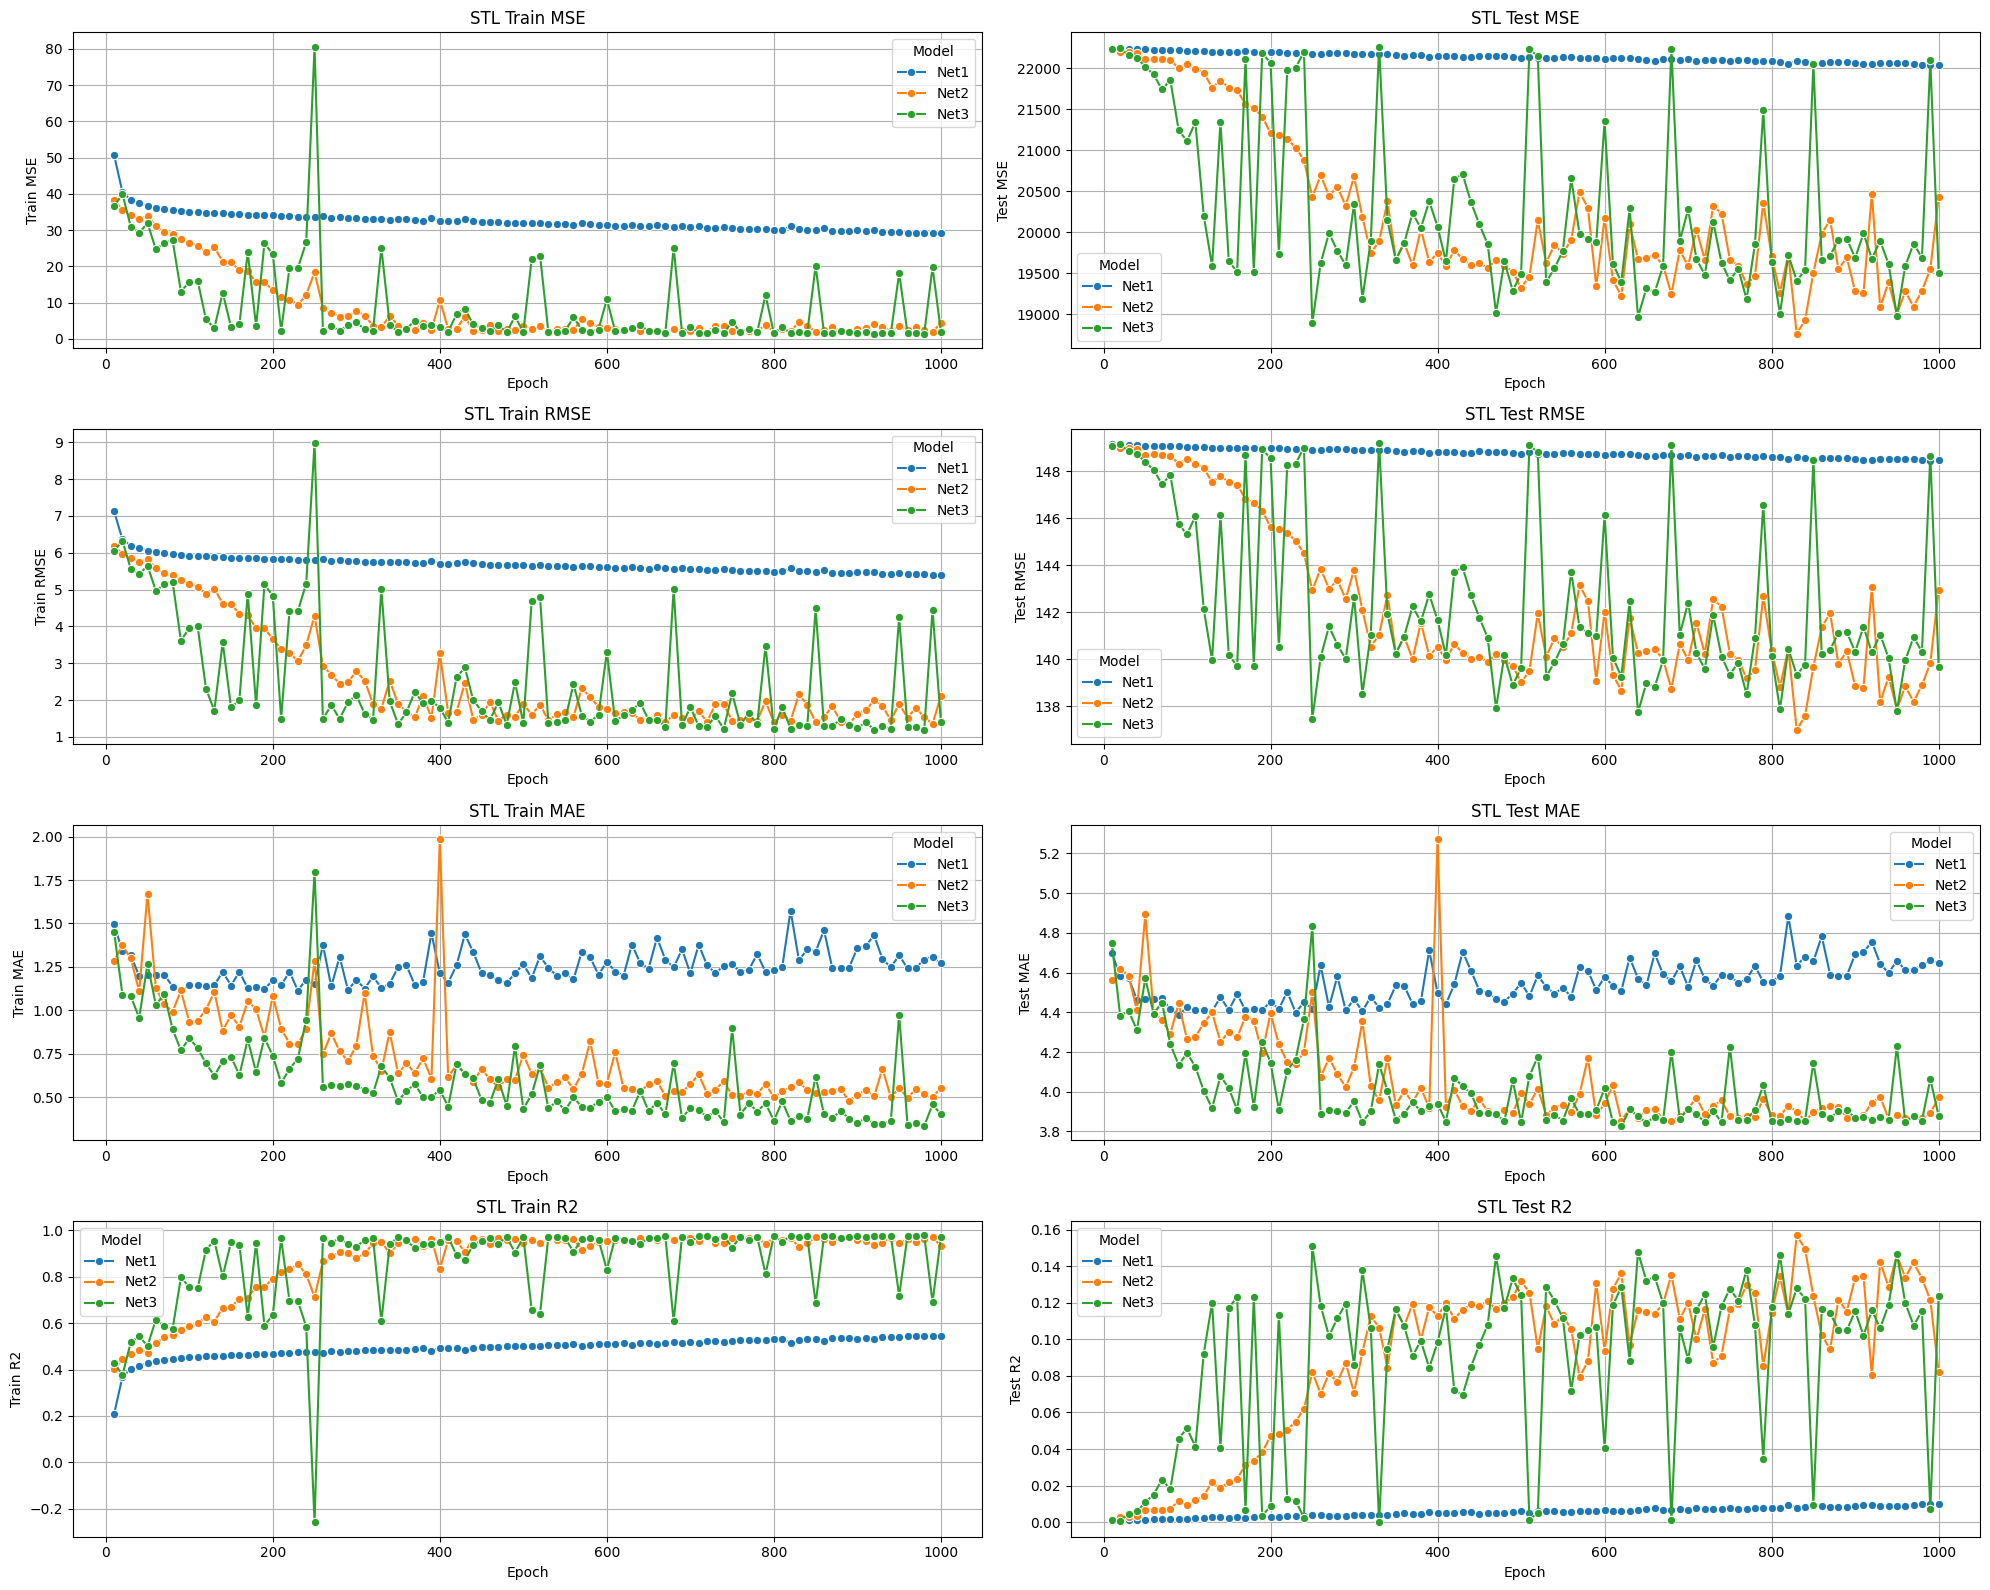

In [37]:
# --- STL ---
metrics_to_plot = ["Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
                   "Train MAE", "Test MAE", "Train R2", "Test R2"]

plt.figure(figsize=(20, 16))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(4, 2, i)
    sns.lineplot(data=nn_metrics_df_stl, x="Epoch", y=metric, hue="Model", marker='o')
    plt.title("STL " + metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.grid(True)

plt.tight_layout()
plt.show()


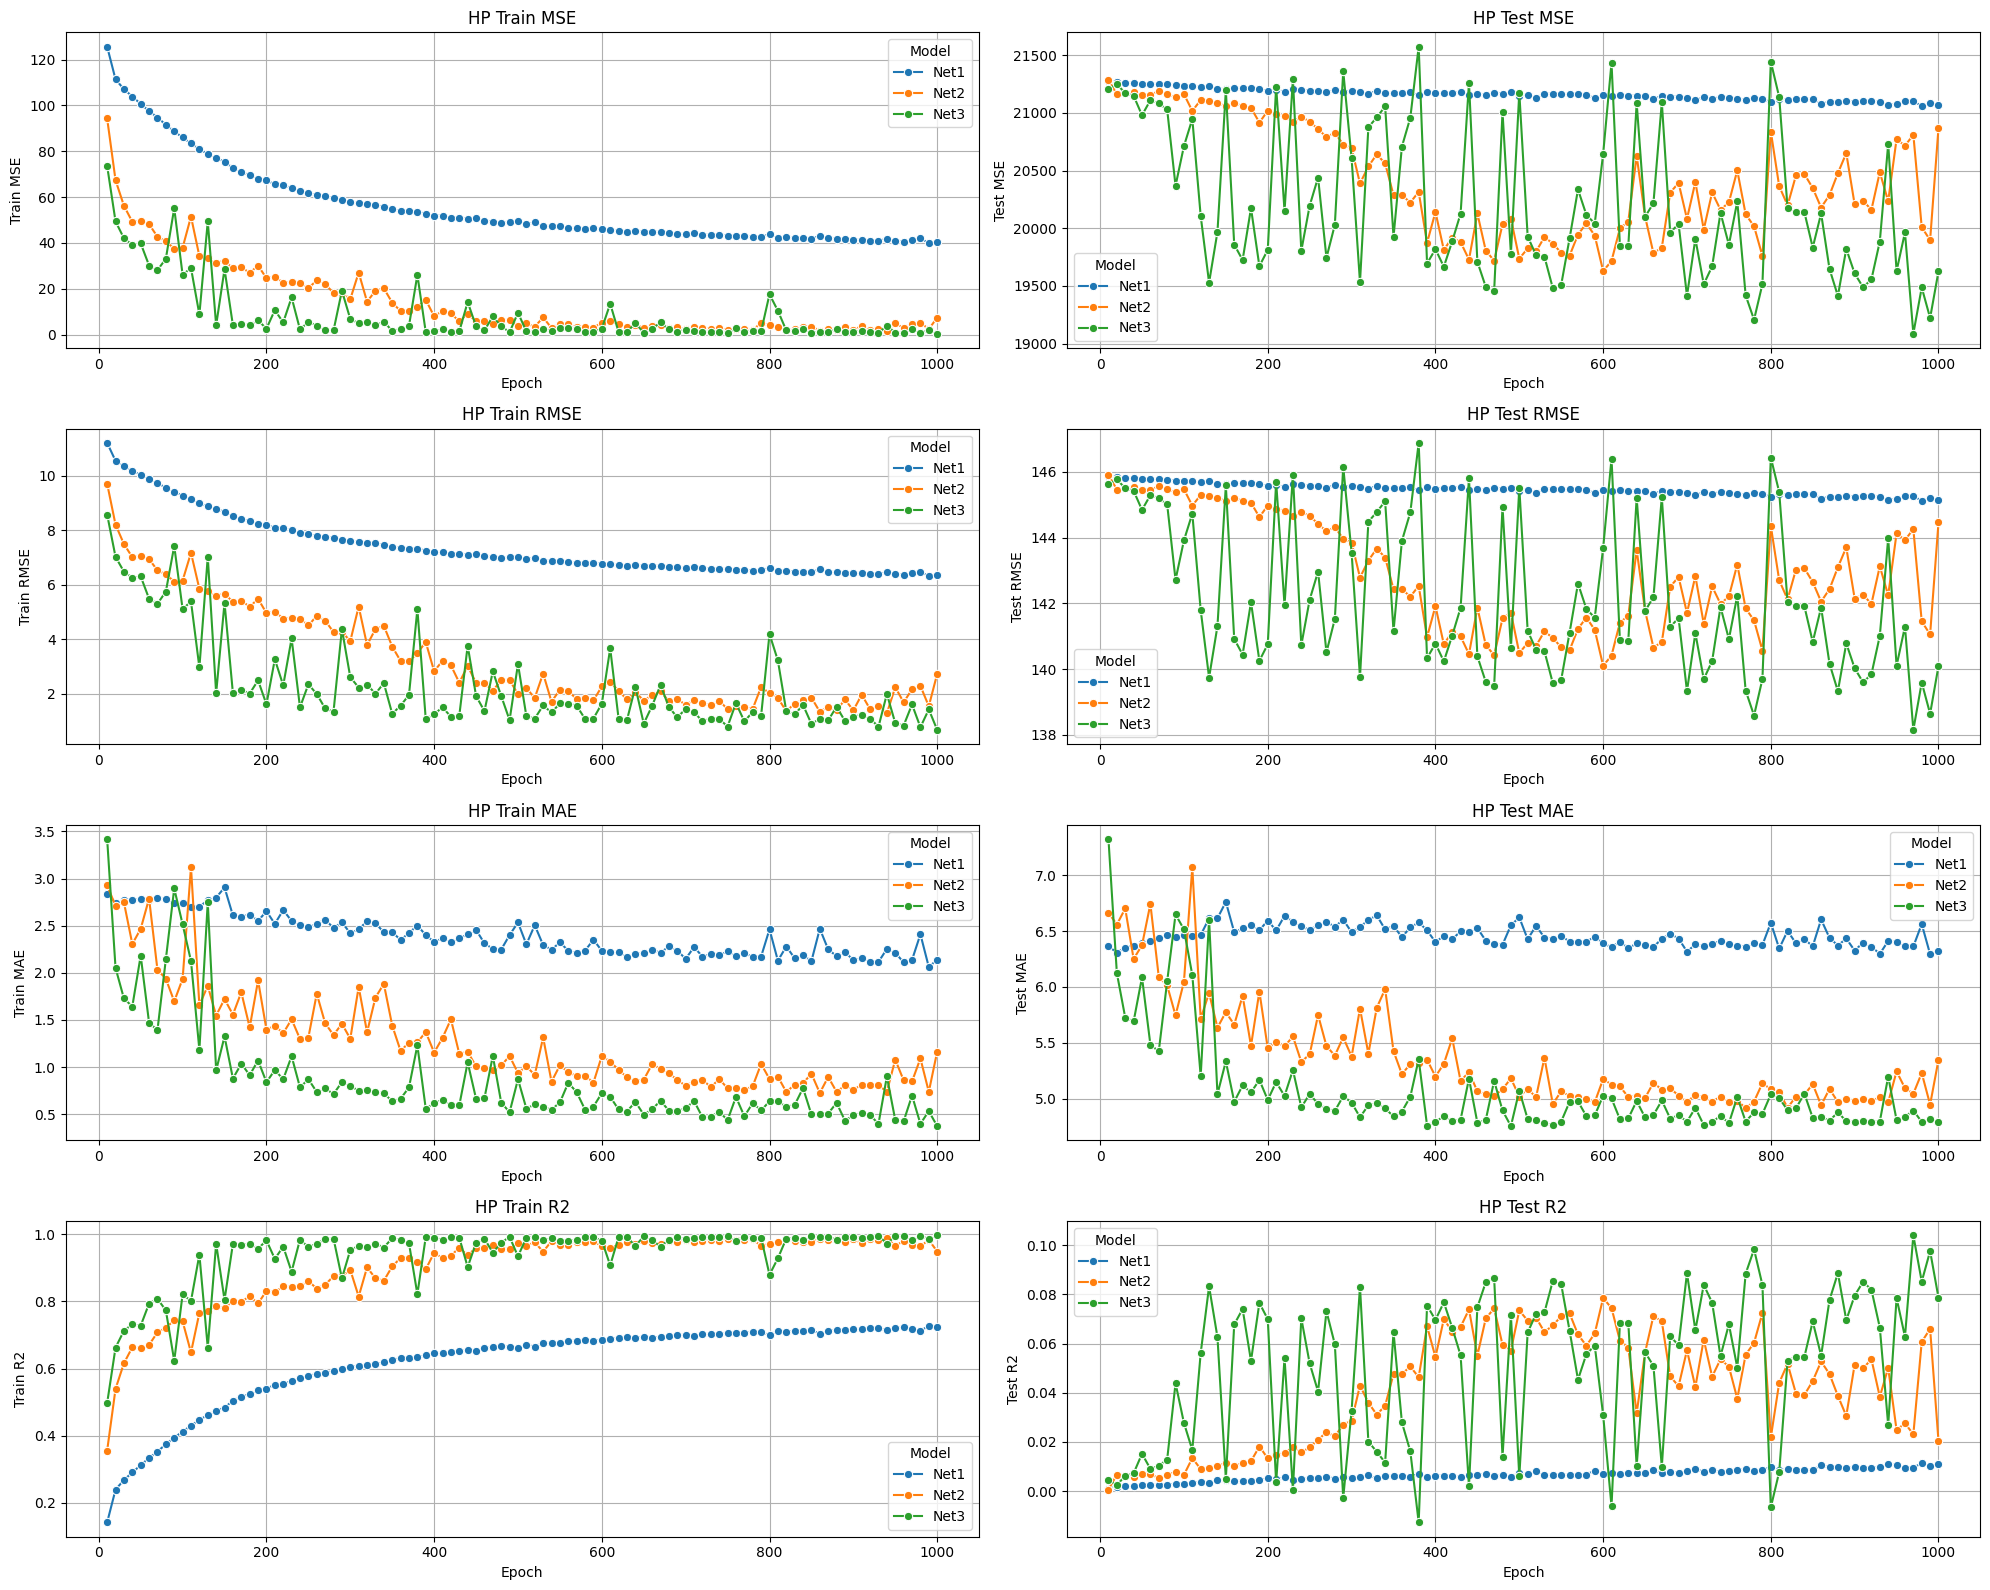

In [38]:
# --- HP ---
metrics_to_plot = ["Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
                   "Train MAE", "Test MAE", "Train R2", "Test R2"]

plt.figure(figsize=(20, 16))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(4, 2, i)
    sns.lineplot(data=nn_metrics_df_hp, x="Epoch", y=metric, hue="Model", marker='o')
    plt.title("HP " + metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.grid(True)

plt.tight_layout()
plt.show()


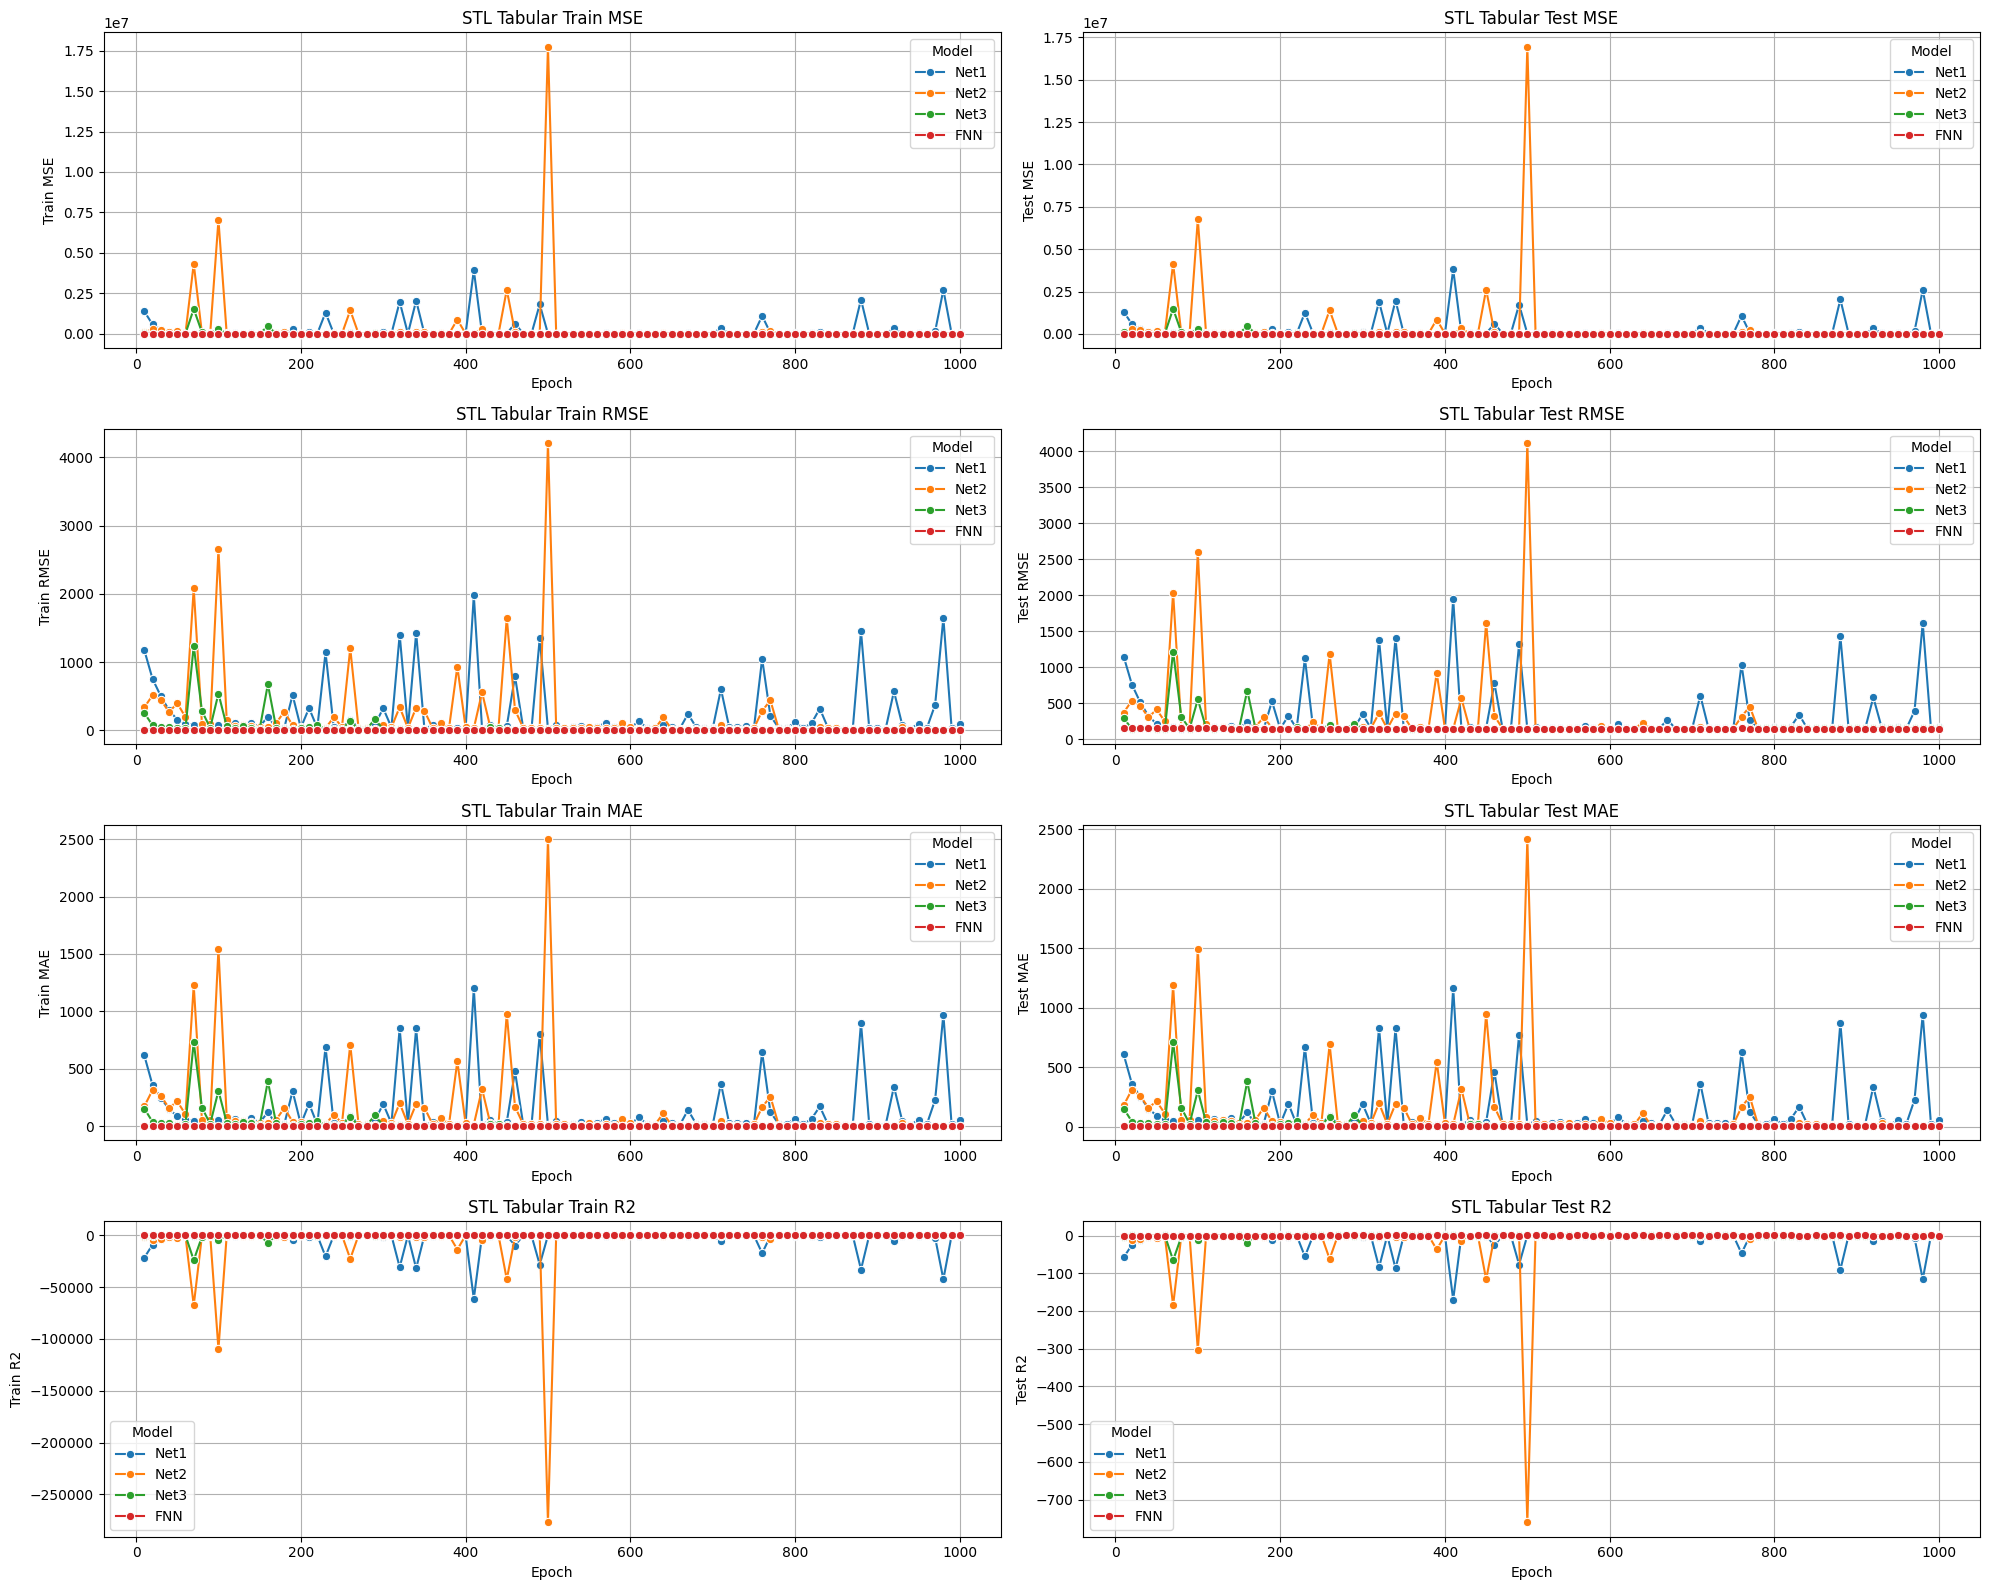

In [62]:
# --- STL Tabular Models  ---
metrics_to_plot = ["Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
                   "Train MAE", "Test MAE", "Train R2", "Test R2"]

plt.figure(figsize=(20, 16))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(4, 2, i)
    sns.lineplot(data=nn_metrics_df_stl_tabular, x="Epoch", y=metric, hue="Model", marker='o')
    plt.title("STL Tabular " + metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.grid(True)

plt.tight_layout()
plt.show()


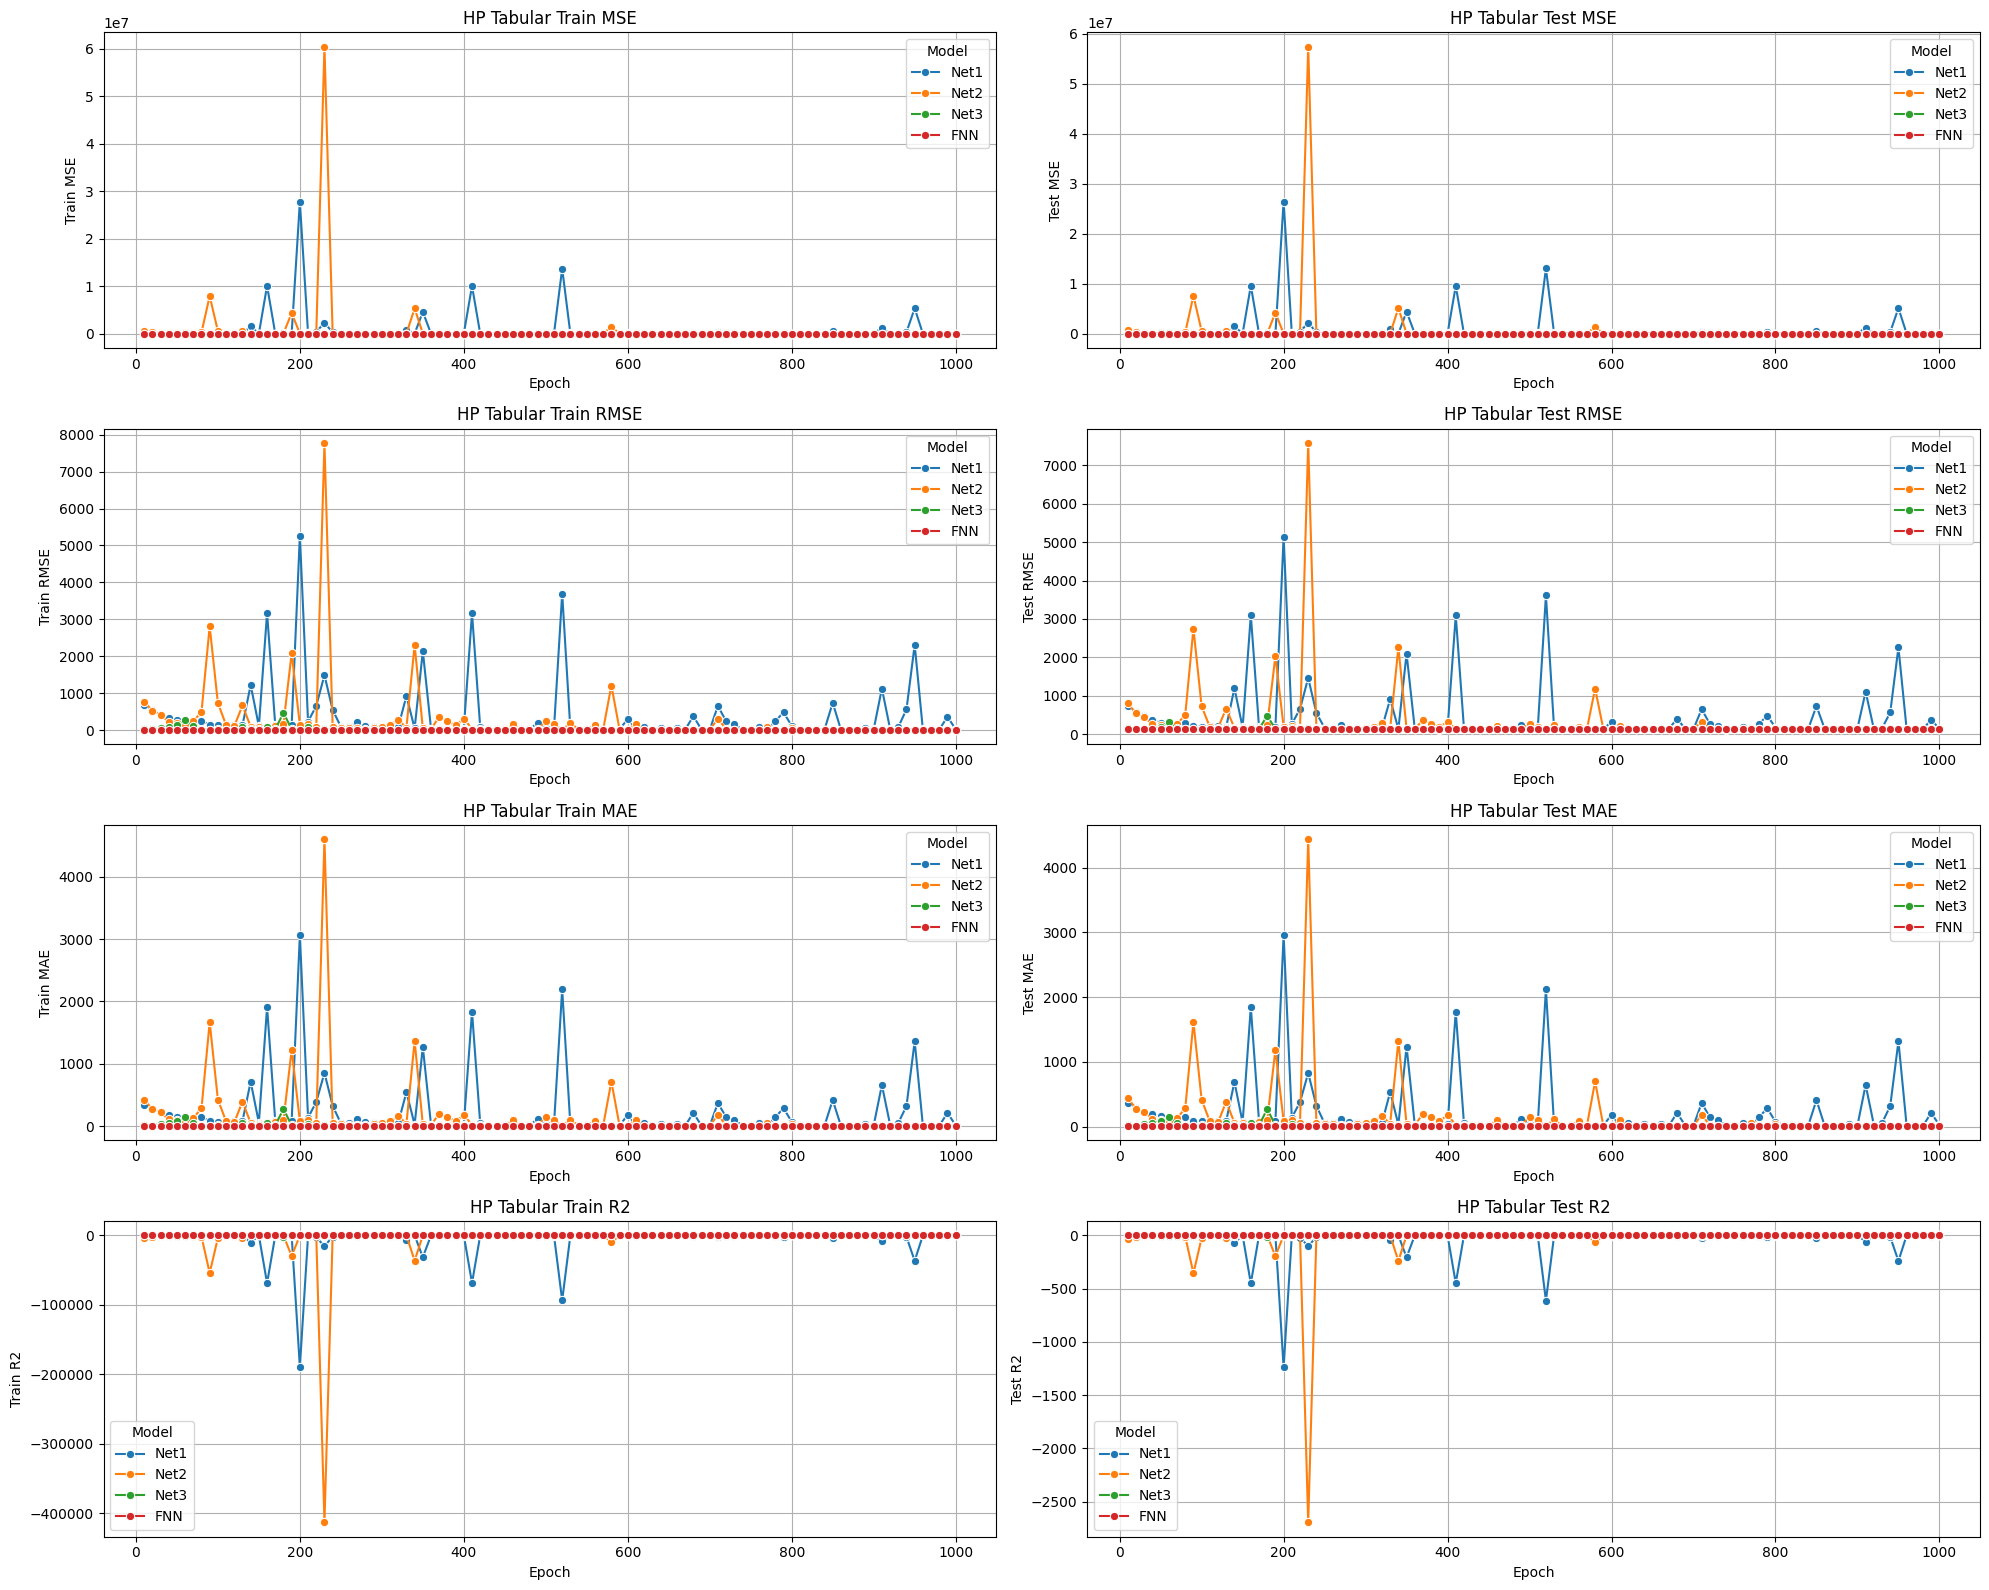

In [63]:
# --- HP Tabular Models ---
plt.figure(figsize=(20, 16))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(4, 2, i)
    sns.lineplot(data=nn_metrics_df_hp_tabular, x="Epoch", y=metric, hue="Model", marker='o')
    plt.title("HP Tabular " + metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.grid(True)

plt.tight_layout()
plt.show()

In [64]:
ts_nets_stl = {
    "CNN1D":   CNN1D(input_dim=X_stl.shape[1]),
    "CNNLSTM": CNNLSTM(input_dim=X_stl.shape[1]),
    "BiLSTMNet HD128 NL2": BiLSTMNet(X_stl.shape[1], hidden_dim=128, num_layers=2),
    "BiLSTMNet HD32 NL3":  BiLSTMNet(X_stl.shape[1], hidden_dim=32,  num_layers=3),
    "BiLSTMNet Default":   BiLSTMNet(X_stl.shape[1]),
    "LSTMNet":             LSTMNet(X_stl.shape[1]),
    "RNNNet":              RNNNet(X_stl.shape[1]),
    "GRUNet":              GRUNet(X_stl.shape[1])
}

ts_nets_hp = {
    "CNN1D":   CNN1D(input_dim=X_hp.shape[1]),
    "CNNLSTM": CNNLSTM(input_dim=X_hp.shape[1]),
    "BiLSTMNet HD128 NL2": BiLSTMNet(X_hp.shape[1], hidden_dim=128, num_layers=2),
    "BiLSTMNet HD32 NL3":  BiLSTMNet(X_hp.shape[1], hidden_dim=32,  num_layers=3),
    "BiLSTMNet Default":   BiLSTMNet(X_hp.shape[1]),
    "LSTMNet":             LSTMNet(X_hp.shape[1]),
    "RNNNet":              RNNNet(X_hp.shape[1]),
    "GRUNet":              GRUNet(X_hp.shape[1])
}

In [65]:
def create_sequence_data(X, y, seq_len=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

# For STL Data:
X_seq_stl, y_seq_stl = create_sequence_data(X_stl.values, y_stl.values, seq_len=5)

# For HP Data:
X_seq_hp, y_seq_hp = create_sequence_data(X_hp.values, y_hp.values, seq_len=5)

In [66]:
df_stl_numeric = df_stl.select_dtypes(include=['number']).dropna()

X_stl = df_stl_numeric.drop(columns=['Normalized_Efficiency'])
y_stl = df_stl_numeric['Normalized_Efficiency'].values

scaler_stl = StandardScaler()
X_stl_scaled = scaler_stl.fit_transform(X_stl)

In [67]:
df_hp_numeric = df_hp.select_dtypes(include=['number']).dropna()

X_hp = df_hp_numeric.drop(columns=['Normalized_Efficiency'])
y_hp = df_hp_numeric['Normalized_Efficiency'].values

scaler_hp = StandardScaler()
X_hp_scaled = scaler_hp.fit_transform(X_hp)

In [68]:
seq_len = 5  
X_seq_stl, y_seq_stl = create_sequence_data(X_stl_scaled, y_stl, seq_len=seq_len)
X_train_seq_stl, X_test_seq_stl, y_train_seq_stl, y_test_seq_stl = train_test_split(
    X_seq_stl, y_seq_stl, test_size=0.2, random_state=42
)

seq_len = 5  
X_seq_hp, y_seq_hp = create_sequence_data(X_hp_scaled, y_hp, seq_len=seq_len)
X_train_seq_hp, X_test_seq_hp, y_train_seq_hp, y_test_seq_hp = train_test_split(
    X_seq_hp, y_seq_hp, test_size=0.2, random_state=42
)

In [69]:
y_scaler_stl = StandardScaler()
y_train_scaled_stl = y_scaler_stl.fit_transform(y_train_seq_stl.reshape(-1, 1))
y_test_scaled_stl  = y_scaler_stl.transform(y_test_seq_stl.reshape(-1, 1))

y_scaler_hp = StandardScaler()
y_train_scaled_hp = y_scaler_hp.fit_transform(y_train_seq_hp.reshape(-1, 1))
y_test_scaled_hp  = y_scaler_hp.transform(y_test_seq_hp.reshape(-1, 1))

In [70]:
X_stl_train_tensor = torch.tensor(X_train_seq_stl, dtype=torch.float32)
X_stl_test_tensor  = torch.tensor(X_test_seq_stl, dtype=torch.float32)
y_stl_train_tensor = torch.tensor(y_train_scaled_stl, dtype=torch.float32)
y_stl_test_tensor  = torch.tensor(y_test_scaled_stl, dtype=torch.float32)

X_hp_train_tensor = torch.tensor(X_train_seq_hp, dtype=torch.float32)
X_hp_test_tensor  = torch.tensor(X_test_seq_hp, dtype=torch.float32)
y_hp_train_tensor = torch.tensor(y_train_scaled_hp, dtype=torch.float32)
y_hp_test_tensor  = torch.tensor(y_test_scaled_hp, dtype=torch.float32)

In [71]:
train_dataset_stl = TensorDataset(X_stl_train_tensor, y_stl_train_tensor)
train_loader_stl = DataLoader(train_dataset_stl, batch_size=256, shuffle=True)

train_dataset_hp = TensorDataset(X_hp_train_tensor, y_hp_train_tensor)
train_loader_hp = DataLoader(train_dataset_hp, batch_size=256, shuffle=True)

In [72]:
results_ts_stl = []
for name, net in ts_nets_stl.items():
    results_ts_stl += train_ts_model(
        name,
        net,
        train_loader_stl,
        X_stl_train_tensor,
        y_stl_train_tensor,
        X_stl_test_tensor,
        y_stl_test_tensor,
        epochs=200,
        lr=1e-3
    )

nn_metrics_ts_df_stl = pd.DataFrame(results_ts_stl)

Training CNN1D:  50%|██████████████████████████████████████████▌                                          | 100/200 [00:25<00:26,  3.77it/s]


Model: CNN1D | Epoch: 100
Train: MSE: 0.6101, RMSE: 0.7811, MAE: 0.1746, R2: 0.3899
Test:  MSE: 335.1808, RMSE: 18.3079, MAE: 0.5807, R2: 0.0348


Training CNN1D: 100%|█████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:51<00:00,  3.91it/s]



Model: CNN1D | Epoch: 200
Train: MSE: 0.3459, RMSE: 0.5881, MAE: 0.1481, R2: 0.6541
Test:  MSE: 323.6203, RMSE: 17.9895, MAE: 0.5608, R2: 0.0681


Training CNNLSTM:  50%|█████████████████████████████████████████▌                                         | 100/200 [00:37<00:40,  2.46it/s]


Model: CNNLSTM | Epoch: 100
Train: MSE: 0.6115, RMSE: 0.7820, MAE: 0.1628, R2: 0.3885
Test:  MSE: 333.2286, RMSE: 18.2546, MAE: 0.5700, R2: 0.0404


Training CNNLSTM: 100%|███████████████████████████████████████████████████████████████████████████████████| 200/200 [01:17<00:00,  2.60it/s]



Model: CNNLSTM | Epoch: 200
Train: MSE: 0.3066, RMSE: 0.5537, MAE: 0.1432, R2: 0.6934
Test:  MSE: 319.2184, RMSE: 17.8667, MAE: 0.5605, R2: 0.0807


Training BiLSTMNet HD128 NL2:  50%|███████████████████████████████████▌                                   | 100/200 [01:27<01:36,  1.04it/s]


Model: BiLSTMNet HD128 NL2 | Epoch: 100
Train: MSE: 0.3541, RMSE: 0.5951, MAE: 0.1394, R2: 0.6459
Test:  MSE: 317.0572, RMSE: 17.8061, MAE: 0.5341, R2: 0.0870


Training BiLSTMNet HD128 NL2: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [02:55<00:00,  1.14it/s]



Model: BiLSTMNet HD128 NL2 | Epoch: 200
Train: MSE: 0.2297, RMSE: 0.4793, MAE: 0.1098, R2: 0.7703
Test:  MSE: 307.3777, RMSE: 17.5322, MAE: 0.5246, R2: 0.1148


Training BiLSTMNet HD32 NL3:  50%|████████████████████████████████████                                    | 100/200 [00:42<00:42,  2.38it/s]


Model: BiLSTMNet HD32 NL3 | Epoch: 100
Train: MSE: 0.4345, RMSE: 0.6592, MAE: 0.1427, R2: 0.5655
Test:  MSE: 331.6782, RMSE: 18.2120, MAE: 0.5454, R2: 0.0449


Training BiLSTMNet HD32 NL3: 100%|████████████████████████████████████████████████████████████████████████| 200/200 [01:23<00:00,  2.41it/s]



Model: BiLSTMNet HD32 NL3 | Epoch: 200
Train: MSE: 0.6858, RMSE: 0.8281, MAE: 0.1477, R2: 0.3142
Test:  MSE: 346.5430, RMSE: 18.6157, MAE: 0.5607, R2: 0.0021


Training BiLSTMNet Default:  50%|████████████████████████████████████▌                                    | 100/200 [00:46<00:50,  1.97it/s]


Model: BiLSTMNet Default | Epoch: 100
Train: MSE: 0.3261, RMSE: 0.5711, MAE: 0.1349, R2: 0.6739
Test:  MSE: 322.7740, RMSE: 17.9659, MAE: 0.5430, R2: 0.0705


Training BiLSTMNet Default: 100%|█████████████████████████████████████████████████████████████████████████| 200/200 [01:33<00:00,  2.14it/s]



Model: BiLSTMNet Default | Epoch: 200
Train: MSE: 0.2756, RMSE: 0.5250, MAE: 0.1280, R2: 0.7244
Test:  MSE: 317.4145, RMSE: 17.8161, MAE: 0.5437, R2: 0.0859


Training LSTMNet:  50%|█████████████████████████████████████████▌                                         | 100/200 [00:20<00:22,  4.38it/s]


Model: LSTMNet | Epoch: 100
Train: MSE: 0.3227, RMSE: 0.5680, MAE: 0.1316, R2: 0.6773
Test:  MSE: 325.2326, RMSE: 18.0342, MAE: 0.5551, R2: 0.0634


Training LSTMNet: 100%|███████████████████████████████████████████████████████████████████████████████████| 200/200 [00:41<00:00,  4.81it/s]



Model: LSTMNet | Epoch: 200
Train: MSE: 0.2682, RMSE: 0.5179, MAE: 0.1096, R2: 0.7318
Test:  MSE: 319.5497, RMSE: 17.8760, MAE: 0.5486, R2: 0.0798


Training RNNNet:  50%|██████████████████████████████████████████▍                                         | 101/200 [00:10<00:09, 10.12it/s]


Model: RNNNet | Epoch: 100
Train: MSE: 0.4775, RMSE: 0.6910, MAE: 0.2193, R2: 0.5225
Test:  MSE: 331.2023, RMSE: 18.1990, MAE: 0.6344, R2: 0.0462


Training RNNNet: 100%|████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.17it/s]



Model: RNNNet | Epoch: 200
Train: MSE: 1.6029, RMSE: 1.2660, MAE: 0.3367, R2: -0.6029
Test:  MSE: 324.6077, RMSE: 18.0169, MAE: 0.7772, R2: 0.0652


Training GRUNet:  50%|██████████████████████████████████████████▍                                         | 101/200 [00:19<00:18,  5.30it/s]


Model: GRUNet | Epoch: 100
Train: MSE: 0.3173, RMSE: 0.5633, MAE: 0.1516, R2: 0.6827
Test:  MSE: 324.1596, RMSE: 18.0044, MAE: 0.5838, R2: 0.0665


Training GRUNet: 100%|████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:37<00:00,  5.30it/s]


Model: GRUNet | Epoch: 200
Train: MSE: 0.2225, RMSE: 0.4717, MAE: 0.1239, R2: 0.7775
Test:  MSE: 317.2375, RMSE: 17.8112, MAE: 0.5616, R2: 0.0864


In [77]:
print("STL Time-Series Metrics:")
nn_metrics_ts_df_stl

STL Time-Series Metrics:


Model  Epoch  Train MSE    Test MSE  Train RMSE  Test RMSE  Train MAE  \
0     CNN1D     10   0.956961  346.911285    0.978244  18.625555   0.194709   
1     CNN1D     20   0.929995  346.587250    0.964363  18.616854   0.185651   
2     CNN1D     30   0.896327  345.777130    0.946745  18.595083   0.209039   
3     CNN1D     40   0.846934  345.169556    0.920290  18.578739   0.173704   
4     CNN1D     50   0.821802  343.871552    0.906533  18.543774   0.176474   
..      ...    ...        ...         ...         ...        ...        ...   
155  GRUNet    160   0.270238  319.770081    0.519844  17.882116   0.129814   
156  GRUNet    170   0.254714  318.894379    0.504692  17.857614   0.126995   
157  GRUNet    180   0.246932  318.427246    0.496922  17.844530   0.132398   
158  GRUNet    190   0.245055  317.851715    0.495031  17.828396   0.146008   
159  GRUNet    200   0.222493  317.237549    0.471692  17.811164   0.123913   

     Test MAE  Train R2   Test R2  
0    0.584659  0.043039  0.000991  
1    0.576844  0.070005  0.001924  
2    0.603252  0.103673  0.004257  
3    0.570786  0.153066  0.006006  
4    0.572077  0.178198  0.009744  
..        ...       ...       ...  
155  0.559777  0.729762  0.079150  
156  0.560970  0.745286  0.081672  
157  0.567213  0.753069  0.083017  
158  0.581169  0.754945  0.084674  
159  0.561556  0.777507  0.086443  

[160 rows x 10 columns]

In [76]:
final_ts_metrics_stl = (
    nn_metrics_ts_df_stl
    .sort_values("Epoch")
    .groupby("Model", as_index=False)
    .last()
)

cols = ["Model", "Train MSE","Test MSE","Train RMSE","Test RMSE","Train MAE","Test MAE","Train R2","Test R2"]
final_ts_metrics_stl = final_ts_metrics_stl[cols]

print("STL Time‑Series Final‑Epoch Metrics:")
print(final_ts_metrics_stl.to_string(index=False))

STL Time‑Series Final‑Epoch Metrics:
              Model  Train MSE   Test MSE  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R2  Test R2
  BiLSTMNet Default   0.275577 317.414490    0.524954  17.816130   0.127995  0.543736  0.724423 0.085933
BiLSTMNet HD128 NL2   0.229706 307.377686    0.479276  17.532190   0.109791  0.524555  0.770294 0.114837
 BiLSTMNet HD32 NL3   0.685821 346.543030    0.828143  18.615666   0.147727  0.560652  0.314179 0.002051
              CNN1D   0.345916 323.620331    0.588146  17.989451   0.148149  0.560803  0.654084 0.068062
            CNNLSTM   0.306572 319.218445    0.553689  17.866685   0.143167  0.560491  0.693429 0.080738
             GRUNet   0.222493 317.237549    0.471692  17.811164   0.123913  0.561556  0.777507 0.086443
            LSTMNet   0.268217 319.549683    0.517897  17.875953   0.109595  0.548573  0.731783 0.079785
             RNNNet   1.602876 324.607697    1.266047  18.016873   0.336690  0.777190 -0.602876 0.065219


In [74]:
results_ts_hp = []
for name, net in ts_nets_hp.items():
    results_ts_hp += train_ts_model(
        name,
        net,
        train_loader_hp,
        X_hp_train_tensor,
        y_hp_train_tensor,
        X_hp_test_tensor,
        y_hp_test_tensor,
        epochs=200,
        lr=1e-3
    )

nn_metrics_ts_df_hp = pd.DataFrame(results_ts_hp)

Training CNN1D:  50%|██████████████████████████████████████████▌                                          | 100/200 [00:25<00:28,  3.56it/s]


Model: CNN1D | Epoch: 100
Train: MSE: 0.2477, RMSE: 0.4977, MAE: 0.1216, R2: 0.7523
Test:  MSE: 41.3642, RMSE: 6.4315, MAE: 0.2698, R2: 0.0504


Training CNN1D: 100%|█████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:52<00:00,  3.79it/s]



Model: CNN1D | Epoch: 200
Train: MSE: 0.1151, RMSE: 0.3393, MAE: 0.1053, R2: 0.8849
Test:  MSE: 37.6420, RMSE: 6.1353, MAE: 0.2571, R2: 0.1358


Training CNNLSTM:  50%|█████████████████████████████████████████▌                                         | 100/200 [00:39<00:43,  2.31it/s]


Model: CNNLSTM | Epoch: 100
Train: MSE: 0.7861, RMSE: 0.8866, MAE: 0.1394, R2: 0.2139
Test:  MSE: 43.2771, RMSE: 6.5785, MAE: 0.2745, R2: 0.0065


Training CNNLSTM: 100%|███████████████████████████████████████████████████████████████████████████████████| 200/200 [01:18<00:00,  2.53it/s]



Model: CNNLSTM | Epoch: 200
Train: MSE: 0.0826, RMSE: 0.2875, MAE: 0.0991, R2: 0.9174
Test:  MSE: 41.2291, RMSE: 6.4210, MAE: 0.2733, R2: 0.0535


Training BiLSTMNet HD128 NL2:  50%|███████████████████████████████████▌                                   | 100/200 [01:33<01:33,  1.07it/s]


Model: BiLSTMNet HD128 NL2 | Epoch: 100
Train: MSE: 0.0605, RMSE: 0.2459, MAE: 0.0887, R2: 0.9395
Test:  MSE: 40.0753, RMSE: 6.3305, MAE: 0.2856, R2: 0.0800


Training BiLSTMNet HD128 NL2: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [03:01<00:00,  1.10it/s]



Model: BiLSTMNet HD128 NL2 | Epoch: 200
Train: MSE: 0.0247, RMSE: 0.1570, MAE: 0.0644, R2: 0.9753
Test:  MSE: 40.4524, RMSE: 6.3602, MAE: 0.2588, R2: 0.0713


Training BiLSTMNet HD32 NL3:  50%|████████████████████████████████████                                    | 100/200 [00:39<00:41,  2.39it/s]


Model: BiLSTMNet HD32 NL3 | Epoch: 100
Train: MSE: 0.3270, RMSE: 0.5718, MAE: 0.0921, R2: 0.6730
Test:  MSE: 41.3004, RMSE: 6.4265, MAE: 0.2534, R2: 0.0519


Training BiLSTMNet HD32 NL3: 100%|████████████████████████████████████████████████████████████████████████| 200/200 [01:19<00:00,  2.52it/s]



Model: BiLSTMNet HD32 NL3 | Epoch: 200
Train: MSE: 0.1051, RMSE: 0.3243, MAE: 0.0812, R2: 0.8949
Test:  MSE: 40.5845, RMSE: 6.3706, MAE: 0.2575, R2: 0.0683


Training BiLSTMNet Default:  50%|████████████████████████████████████▌                                    | 100/200 [00:45<00:48,  2.08it/s]


Model: BiLSTMNet Default | Epoch: 100
Train: MSE: 0.1384, RMSE: 0.3720, MAE: 0.0884, R2: 0.8616
Test:  MSE: 39.8861, RMSE: 6.3155, MAE: 0.2522, R2: 0.0843


Training BiLSTMNet Default: 100%|█████████████████████████████████████████████████████████████████████████| 200/200 [01:31<00:00,  2.18it/s]



Model: BiLSTMNet Default | Epoch: 200
Train: MSE: 0.0309, RMSE: 0.1758, MAE: 0.0691, R2: 0.9691
Test:  MSE: 40.8645, RMSE: 6.3925, MAE: 0.2537, R2: 0.0619


Training LSTMNet:  50%|█████████████████████████████████████████▉                                         | 101/200 [00:20<00:20,  4.92it/s]


Model: LSTMNet | Epoch: 100
Train: MSE: 0.2265, RMSE: 0.4760, MAE: 0.0966, R2: 0.7735
Test:  MSE: 40.7281, RMSE: 6.3819, MAE: 0.2611, R2: 0.0650


Training LSTMNet: 100%|███████████████████████████████████████████████████████████████████████████████████| 200/200 [00:40<00:00,  4.96it/s]



Model: LSTMNet | Epoch: 200
Train: MSE: 0.0460, RMSE: 0.2144, MAE: 0.0802, R2: 0.9540
Test:  MSE: 42.1127, RMSE: 6.4894, MAE: 0.2752, R2: 0.0332


Training RNNNet:  51%|██████████████████████████████████████████▊                                         | 102/200 [00:09<00:09, 10.81it/s]


Model: RNNNet | Epoch: 100
Train: MSE: 0.2813, RMSE: 0.5303, MAE: 0.1011, R2: 0.7187
Test:  MSE: 43.7303, RMSE: 6.6129, MAE: 0.2677, R2: -0.0039


Training RNNNet: 100%|████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.49it/s]



Model: RNNNet | Epoch: 200
Train: MSE: 0.1521, RMSE: 0.3900, MAE: 0.0949, R2: 0.8479
Test:  MSE: 43.4330, RMSE: 6.5904, MAE: 0.2810, R2: 0.0029


Training GRUNet:  50%|██████████████████████████████████████████▍                                         | 101/200 [00:18<00:18,  5.39it/s]


Model: GRUNet | Epoch: 100
Train: MSE: 0.2143, RMSE: 0.4629, MAE: 0.0932, R2: 0.7857
Test:  MSE: 36.8578, RMSE: 6.0711, MAE: 0.2573, R2: 0.1538


Training GRUNet: 100%|████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:36<00:00,  5.45it/s]


Model: GRUNet | Epoch: 200
Train: MSE: 0.1871, RMSE: 0.4326, MAE: 0.1009, R2: 0.8129
Test:  MSE: 38.4286, RMSE: 6.1991, MAE: 0.2828, R2: 0.1178


In [75]:
print("HP Time-Series Metrics:")
nn_metrics_ts_df_hp

HP Time-Series Metrics:


Model  Epoch  Train MSE   Test MSE  Train RMSE  Test RMSE  Train MAE  \
0     CNN1D     10   0.932309  43.714340    0.965561   6.611682   0.144140   
1     CNN1D     20   0.873720  43.592163    0.934730   6.602436   0.148198   
2     CNN1D     30   0.777712  43.468567    0.881880   6.593070   0.167820   
3     CNN1D     40   0.718739  42.956272    0.847785   6.554103   0.157581   
4     CNN1D     50   0.611829  43.428909    0.782195   6.590061   0.151406   
..      ...    ...        ...        ...         ...        ...        ...   
155  GRUNet    160   0.087318  35.965458    0.295495   5.997121   0.083875   
156  GRUNet    170   0.074205  35.483421    0.272406   5.956796   0.075770   
157  GRUNet    180   0.748879  39.466194    0.865378   6.282213   0.149489   
158  GRUNet    190   0.297677  39.125175    0.545597   6.255012   0.125561   
159  GRUNet    200   0.187120  38.428638    0.432574   6.199084   0.100933   

     Test MAE  Train R2   Test R2  
0    0.267888  0.067691 -0.003566  
1    0.275445  0.126280 -0.000761  
2    0.295285  0.222288  0.002076  
3    0.287565  0.281261  0.013837  
4    0.289527  0.388171  0.002987  
..        ...       ...       ...  
155  0.259724  0.912682  0.174328  
156  0.256810  0.925795  0.185394  
157  0.280089  0.251121  0.093960  
158  0.293842  0.702323  0.101789  
159  0.282781  0.812880  0.117780  

[160 rows x 10 columns]

In [78]:
final_ts_metrics_hp = (
    nn_metrics_ts_df_hp
    .sort_values("Epoch")
    .groupby("Model", as_index=False)
    .last()
)[cols]

print("\nHP Time‑Series Final‑Epoch Metrics:")
print(final_ts_metrics_hp.to_string(index=False))


HP Time‑Series Final‑Epoch Metrics:
              Model  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R2  Test R2
  BiLSTMNet Default   0.030894 40.864487    0.175767   6.392534   0.069142  0.253731  0.969106 0.061859
BiLSTMNet HD128 NL2   0.024659 40.452377    0.157032   6.360218   0.064418  0.258772  0.975341 0.071320
 BiLSTMNet HD32 NL3   0.105138 40.584518    0.324250   6.370598   0.081238  0.257509  0.894862 0.068287
              CNN1D   0.115114 37.641979    0.339285   6.135306   0.105327  0.257080  0.884886 0.135840
            CNNLSTM   0.082628 41.229107    0.287451   6.420990   0.099133  0.273271  0.917372 0.053489
             GRUNet   0.187120 38.428638    0.432574   6.199084   0.100933  0.282781  0.812880 0.117780
            LSTMNet   0.045956 42.112694    0.214374   6.489429   0.080159  0.275161  0.954044 0.033204
             RNNNet   0.152106 43.432964    0.390008   6.590369   0.094917  0.281034  0.847894 0.002894


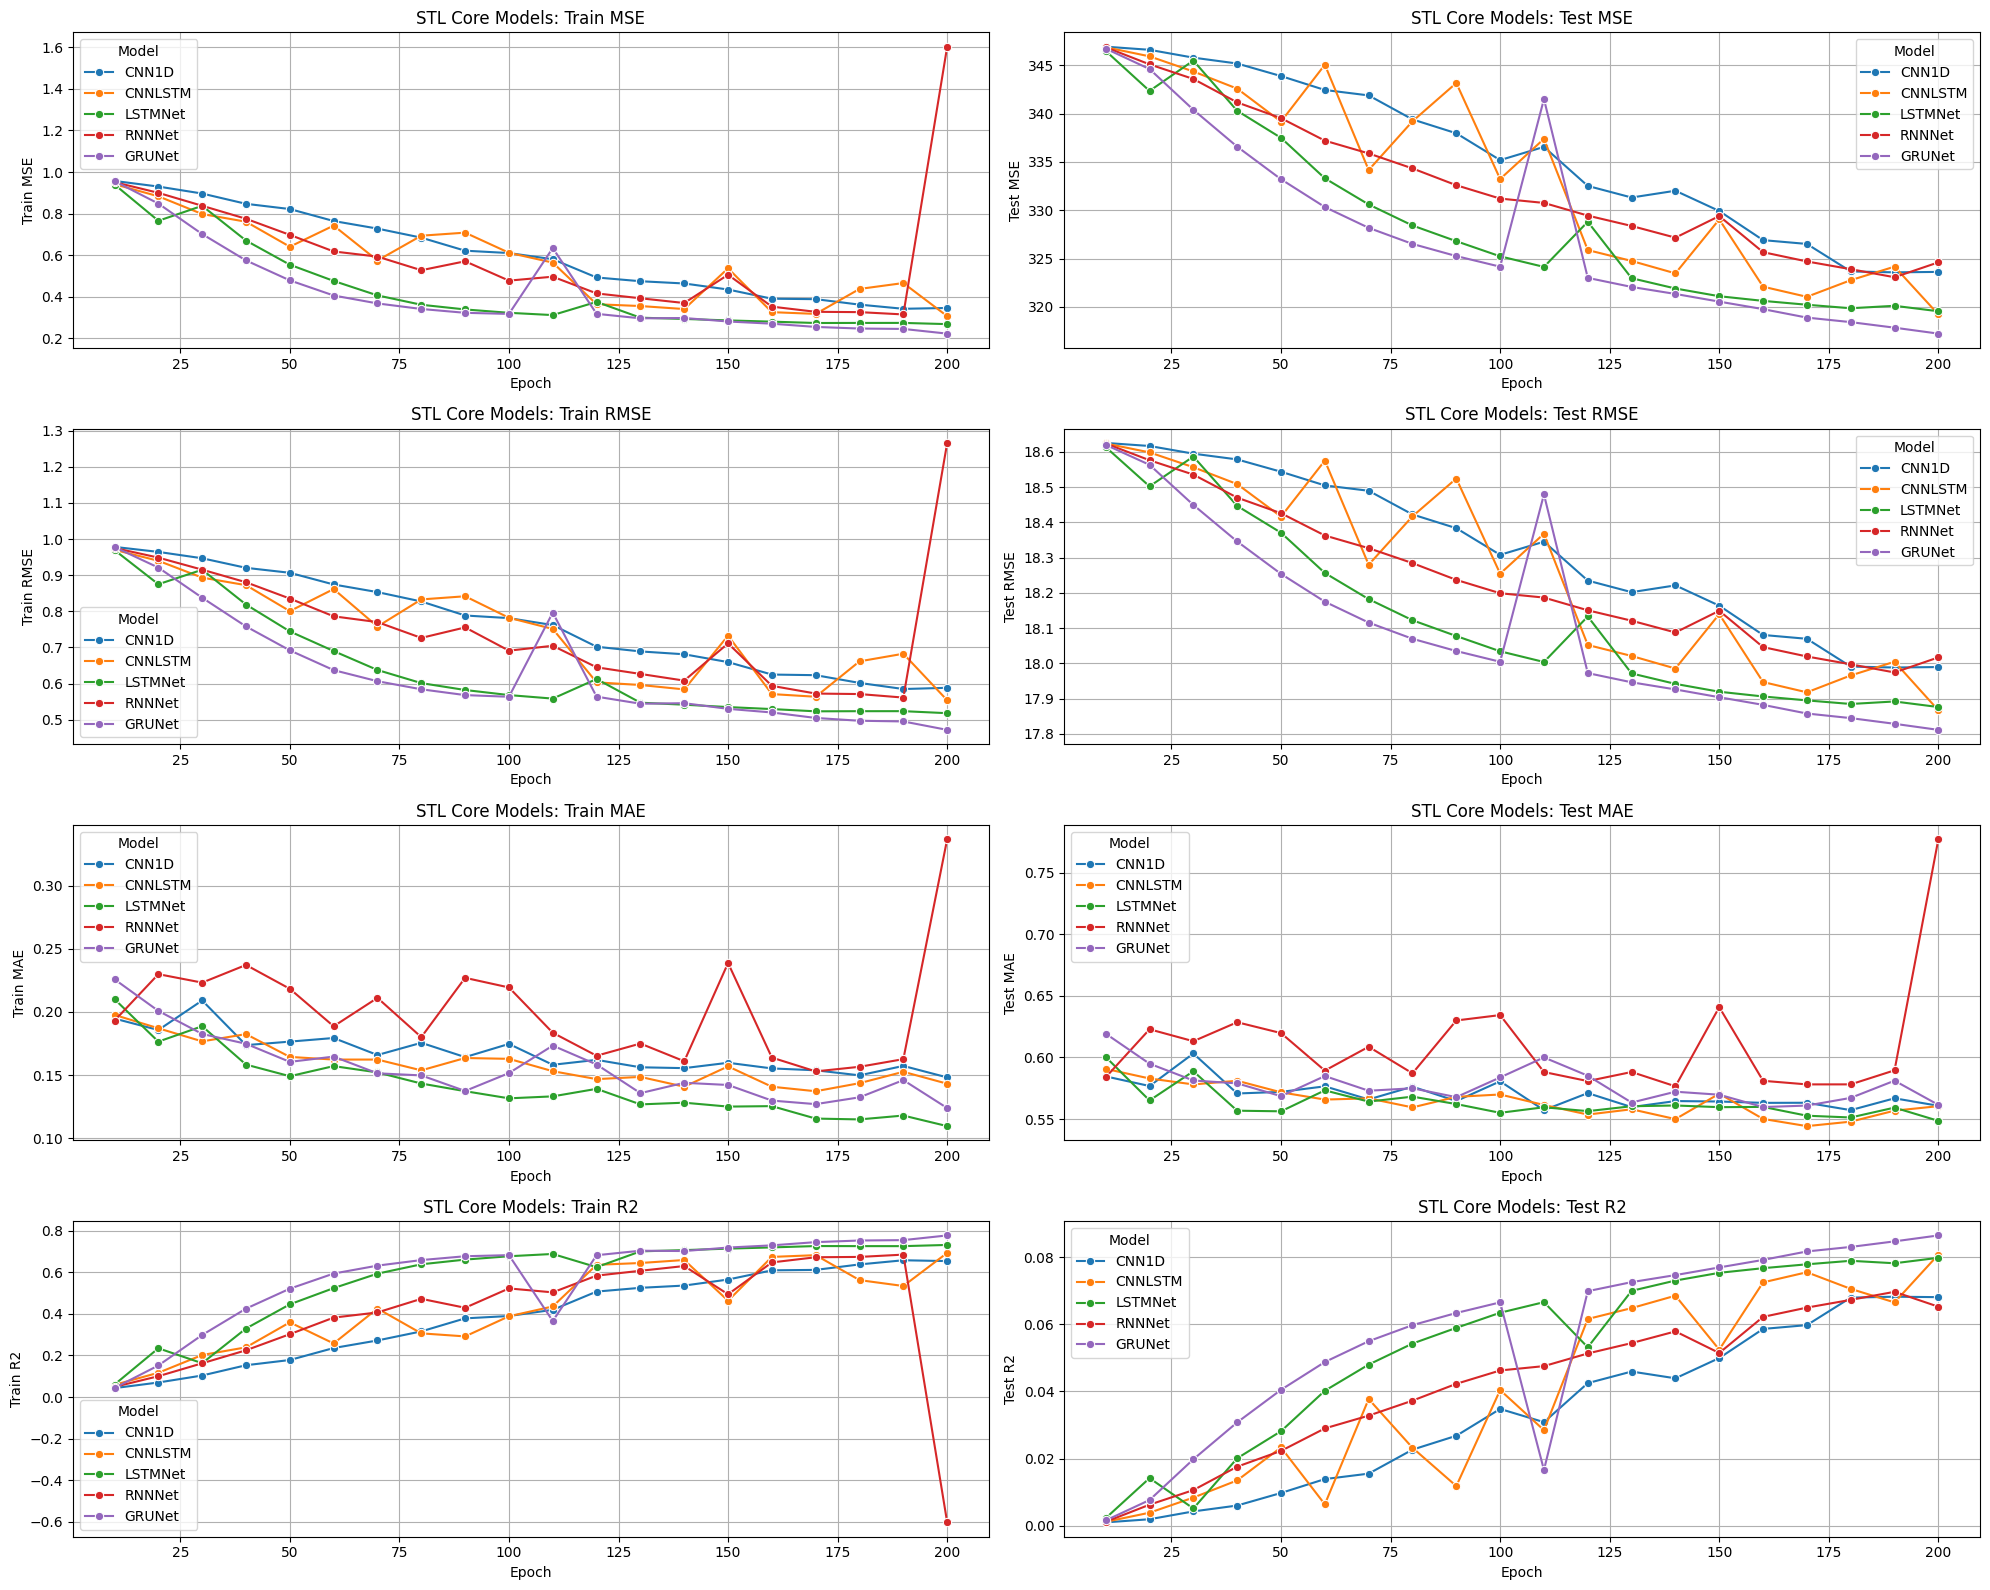

In [80]:
metrics_to_plot = ["Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
                   "Train MAE", "Test MAE", "Train R2", "Test R2"]

core_models = ["LSTMNet", "RNNNet", "GRUNet", "CNN1D", "CNNLSTM"]
df_core = nn_metrics_ts_df_stl[nn_metrics_ts_df_stl["Model"].isin(core_models)]

plt.figure(figsize=(20, 16))
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(4, 2, i)
    sns.lineplot(data=df_core, x="Epoch", y=metric, hue="Model", marker='o')
    plt.title("STL Core Models: " + metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.grid(True)
plt.tight_layout()
plt.show()

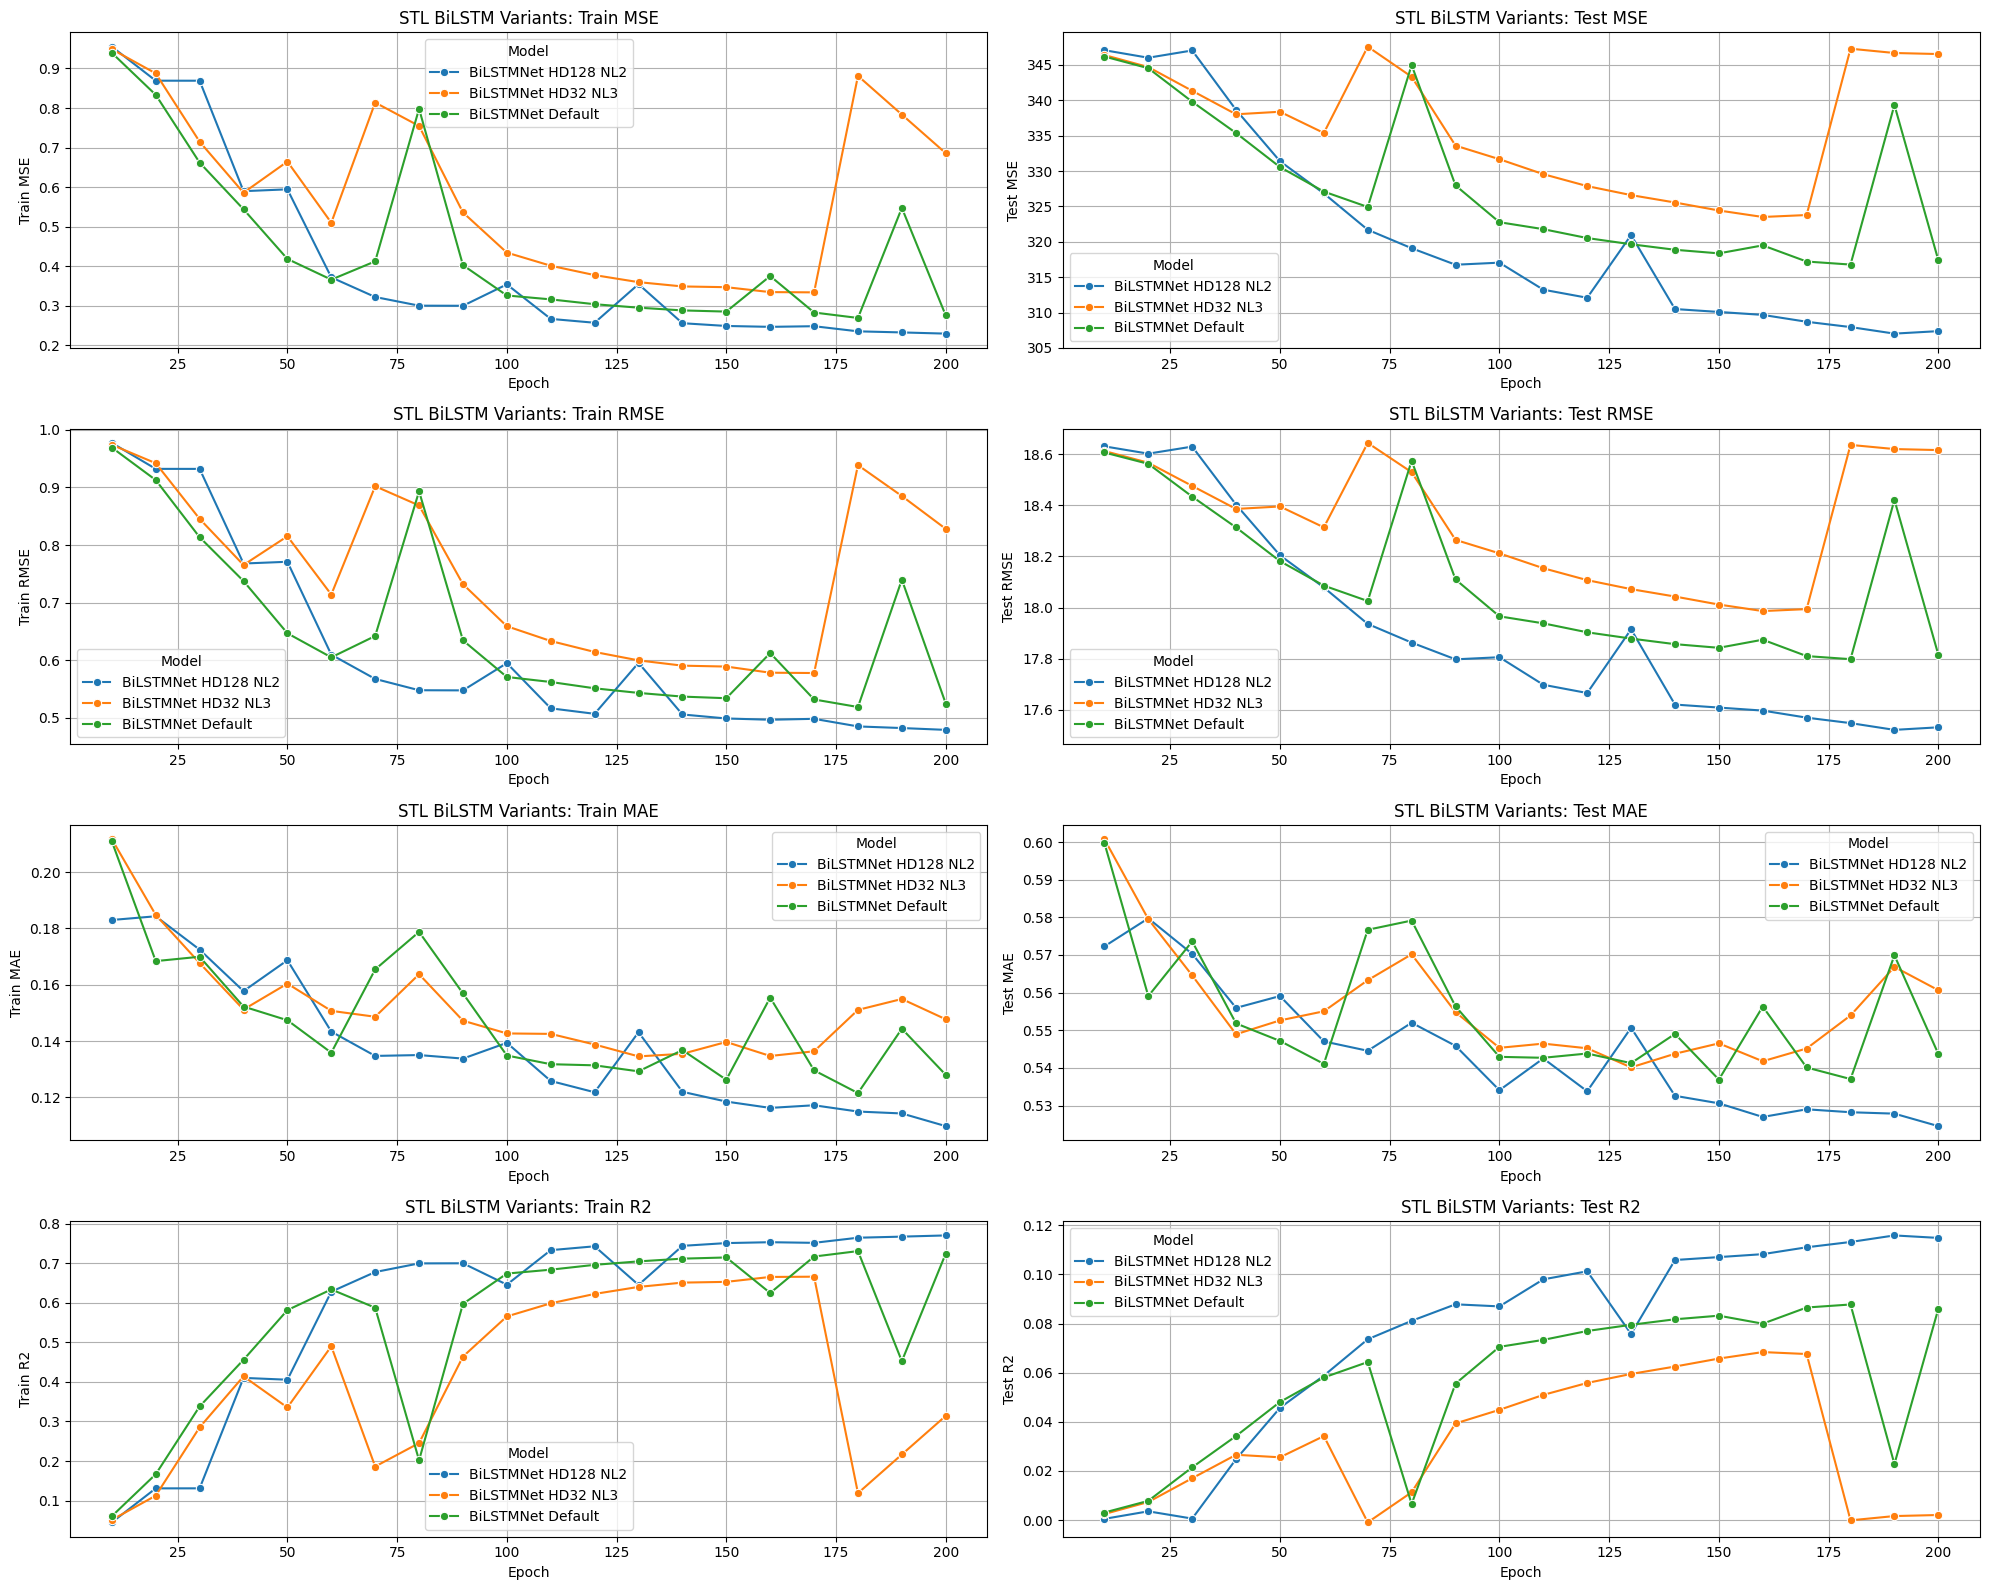

In [81]:
metrics_to_plot = ["Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
                   "Train MAE", "Test MAE", "Train R2", "Test R2"]
bilstm_models = ["BiLSTMNet Default", "BiLSTMNet HD128 NL2", "BiLSTMNet HD32 NL3"]
df_bilstm = nn_metrics_ts_df_stl[nn_metrics_ts_df_stl["Model"].isin(bilstm_models)]

plt.figure(figsize=(20, 16))
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(4, 2, i)
    sns.lineplot(data=df_bilstm, x="Epoch", y=metric, hue="Model", marker='o')
    plt.title("STL BiLSTM Variants: " + metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.grid(True)
plt.tight_layout()
plt.show()

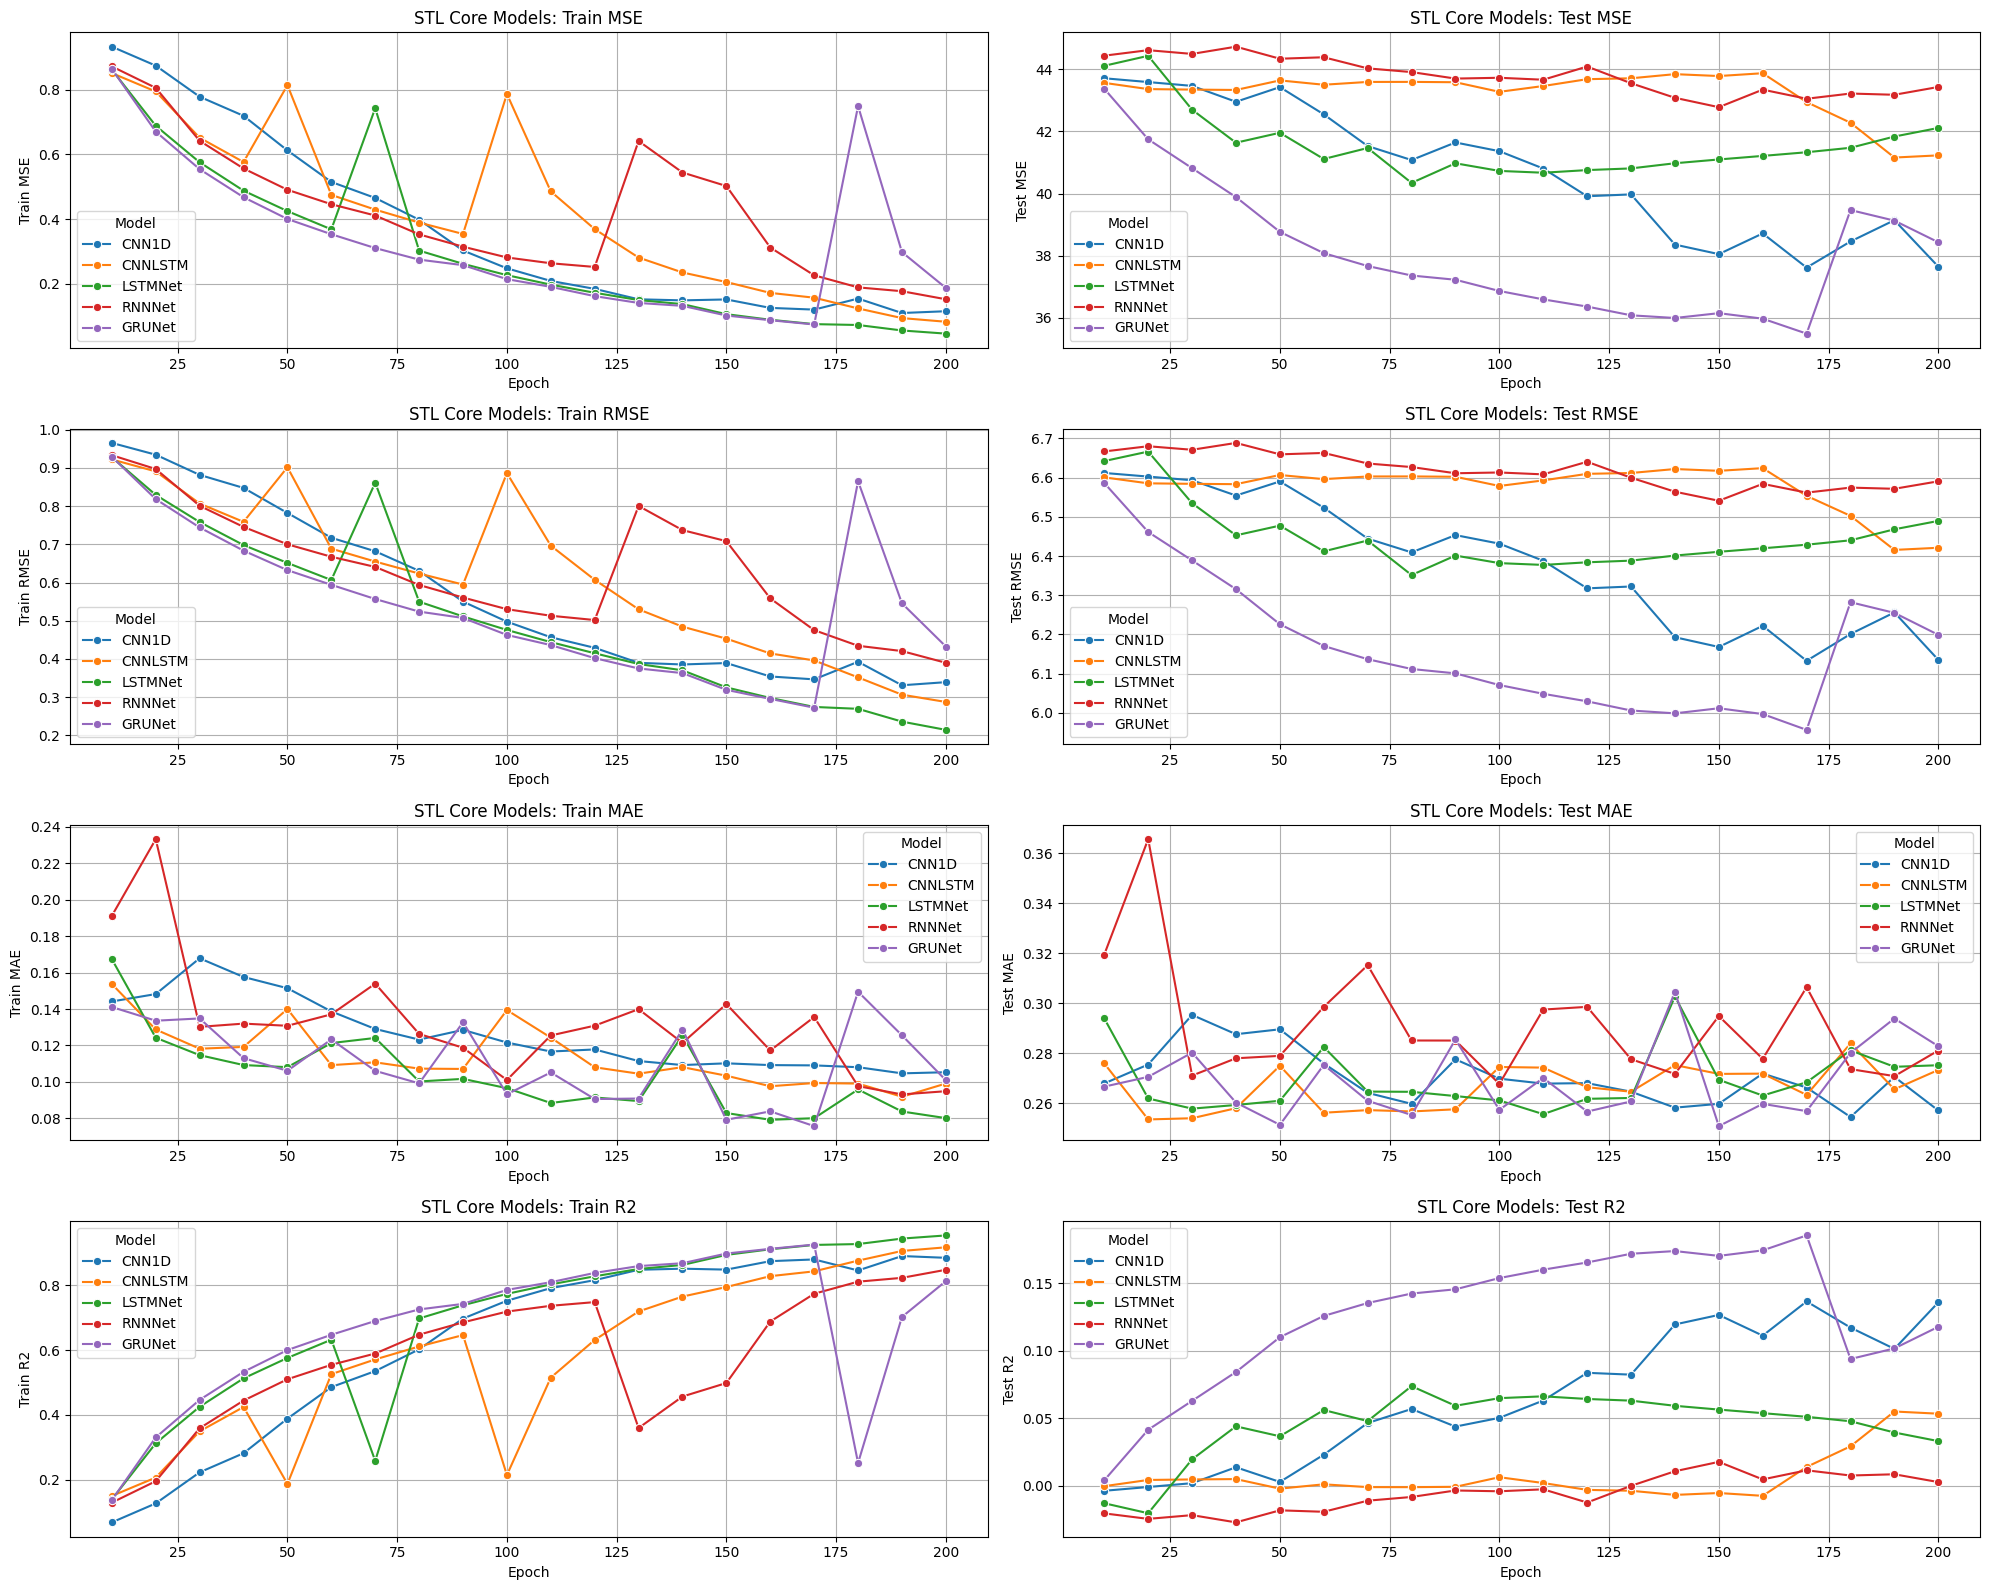

In [82]:
metrics_to_plot = ["Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
                   "Train MAE", "Test MAE", "Train R2", "Test R2"]

core_models = ["LSTMNet", "RNNNet", "GRUNet", "CNN1D", "CNNLSTM"]
df_core = nn_metrics_ts_df_hp[nn_metrics_ts_df_hp["Model"].isin(core_models)]

plt.figure(figsize=(20, 16))
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(4, 2, i)
    sns.lineplot(data=df_core, x="Epoch", y=metric, hue="Model", marker='o')
    plt.title("STL Core Models: " + metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.grid(True)
plt.tight_layout()
plt.show()

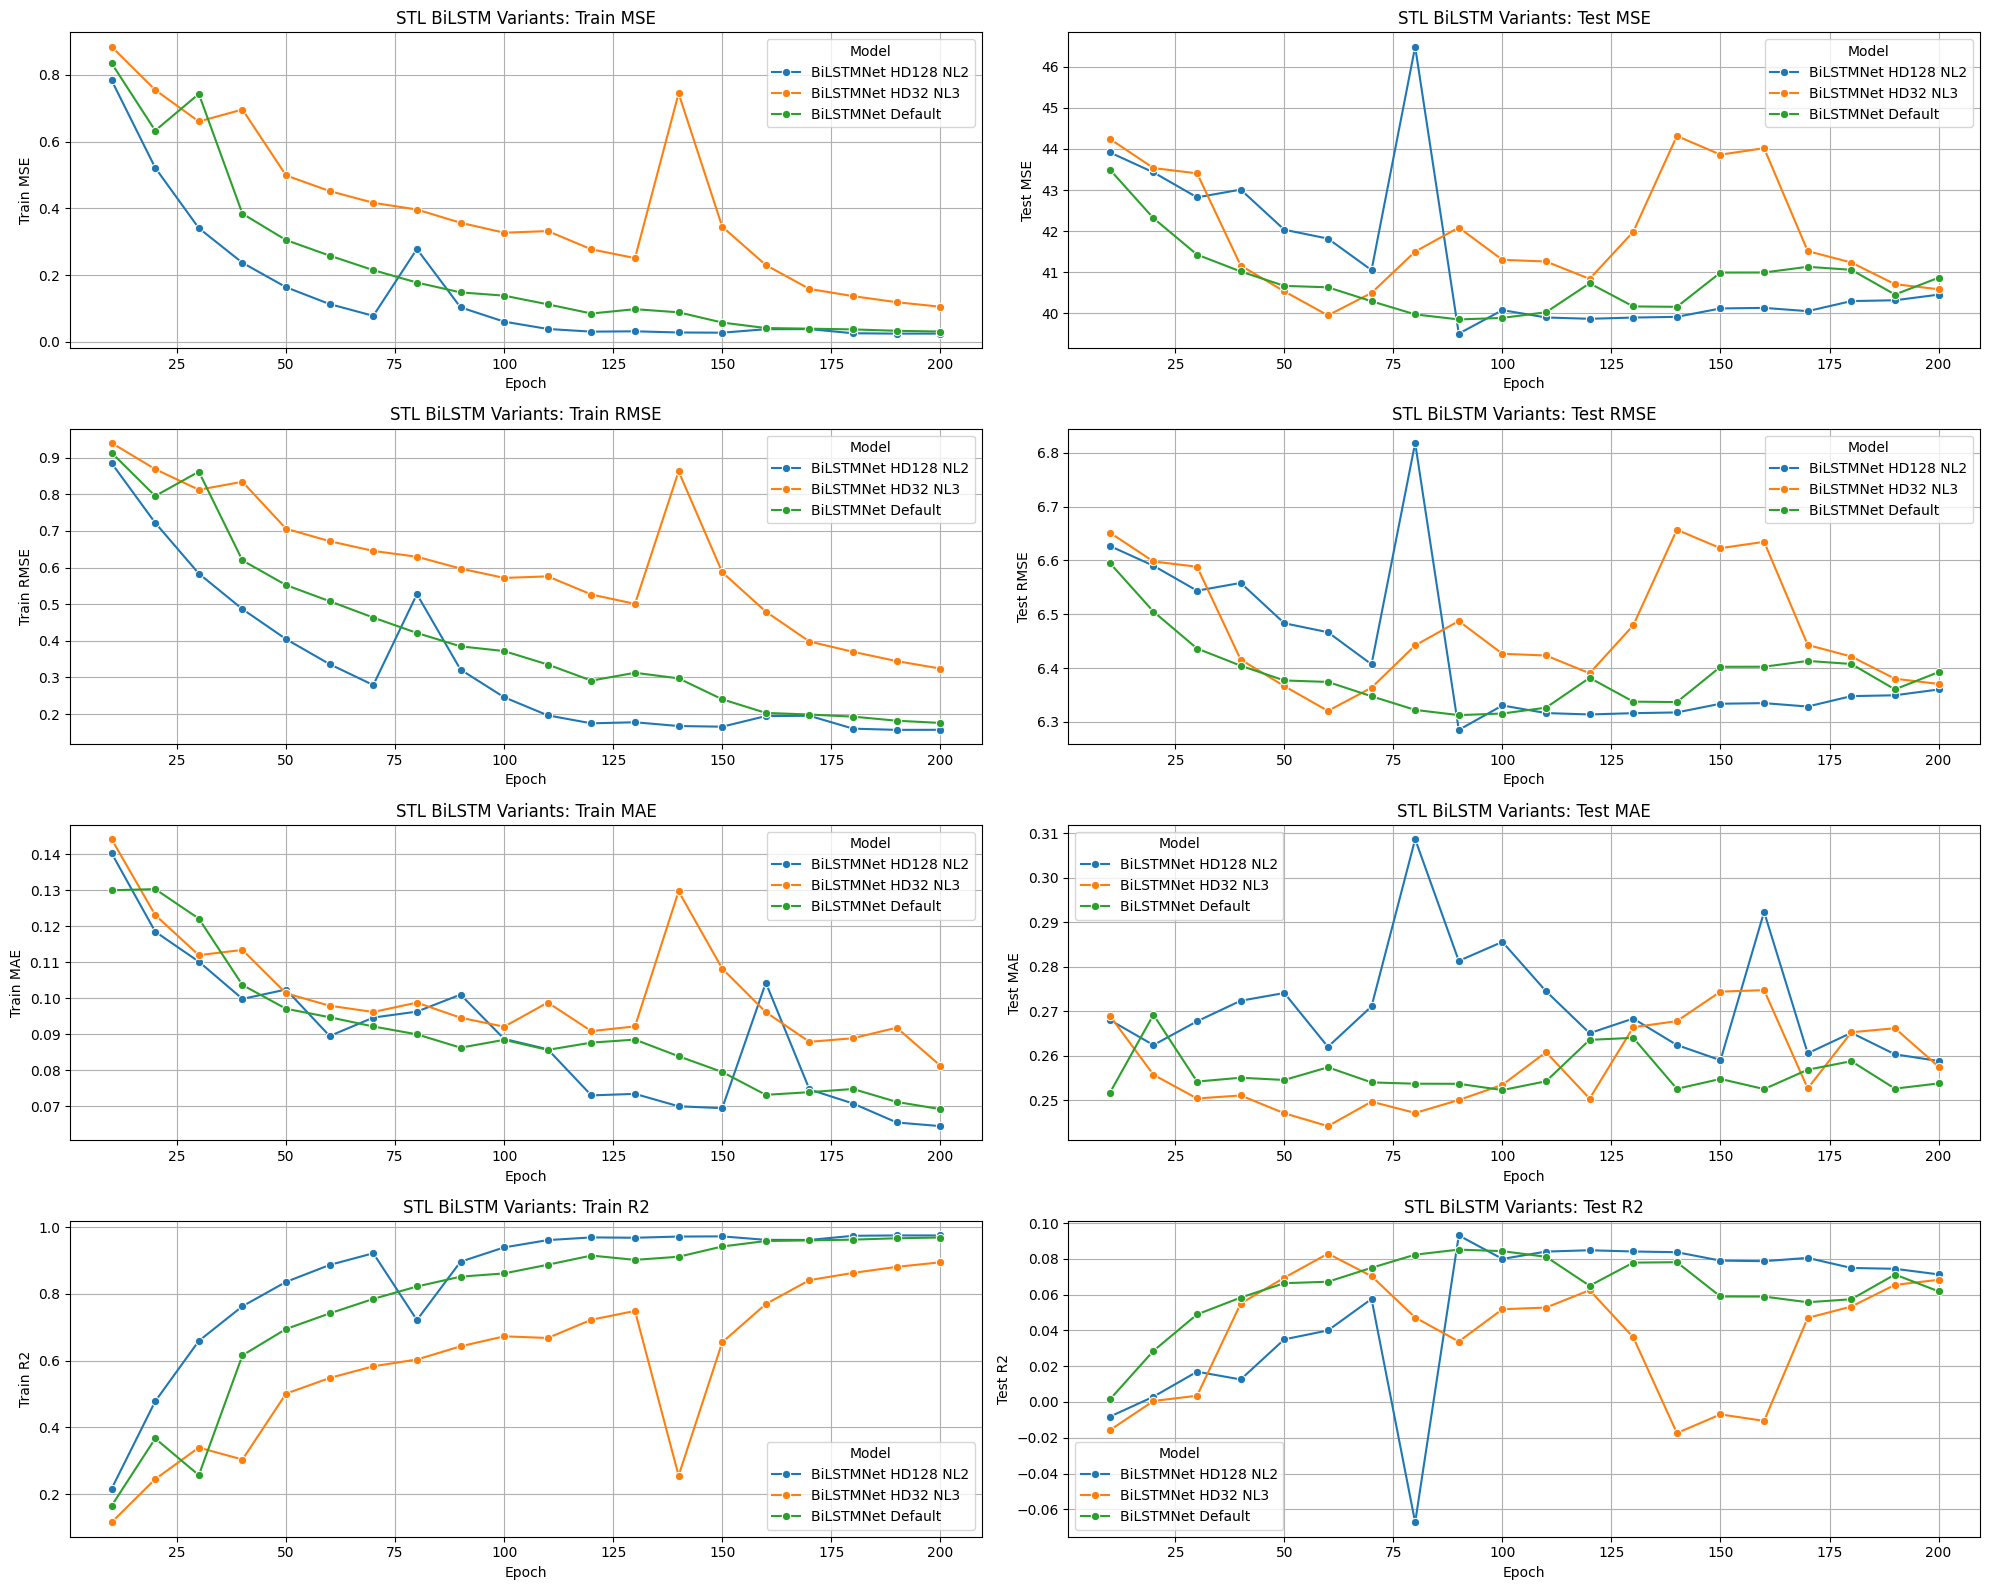

In [83]:
metrics_to_plot = ["Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
                   "Train MAE", "Test MAE", "Train R2", "Test R2"]
bilstm_models = ["BiLSTMNet Default", "BiLSTMNet HD128 NL2", "BiLSTMNet HD32 NL3"]
df_bilstm = nn_metrics_ts_df_hp[nn_metrics_ts_df_hp["Model"].isin(bilstm_models)]

plt.figure(figsize=(20, 16))
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(4, 2, i)
    sns.lineplot(data=df_bilstm, x="Epoch", y=metric, hue="Model", marker='o')
    plt.title("STL BiLSTM Variants: " + metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.grid(True)
plt.tight_layout()
plt.show()

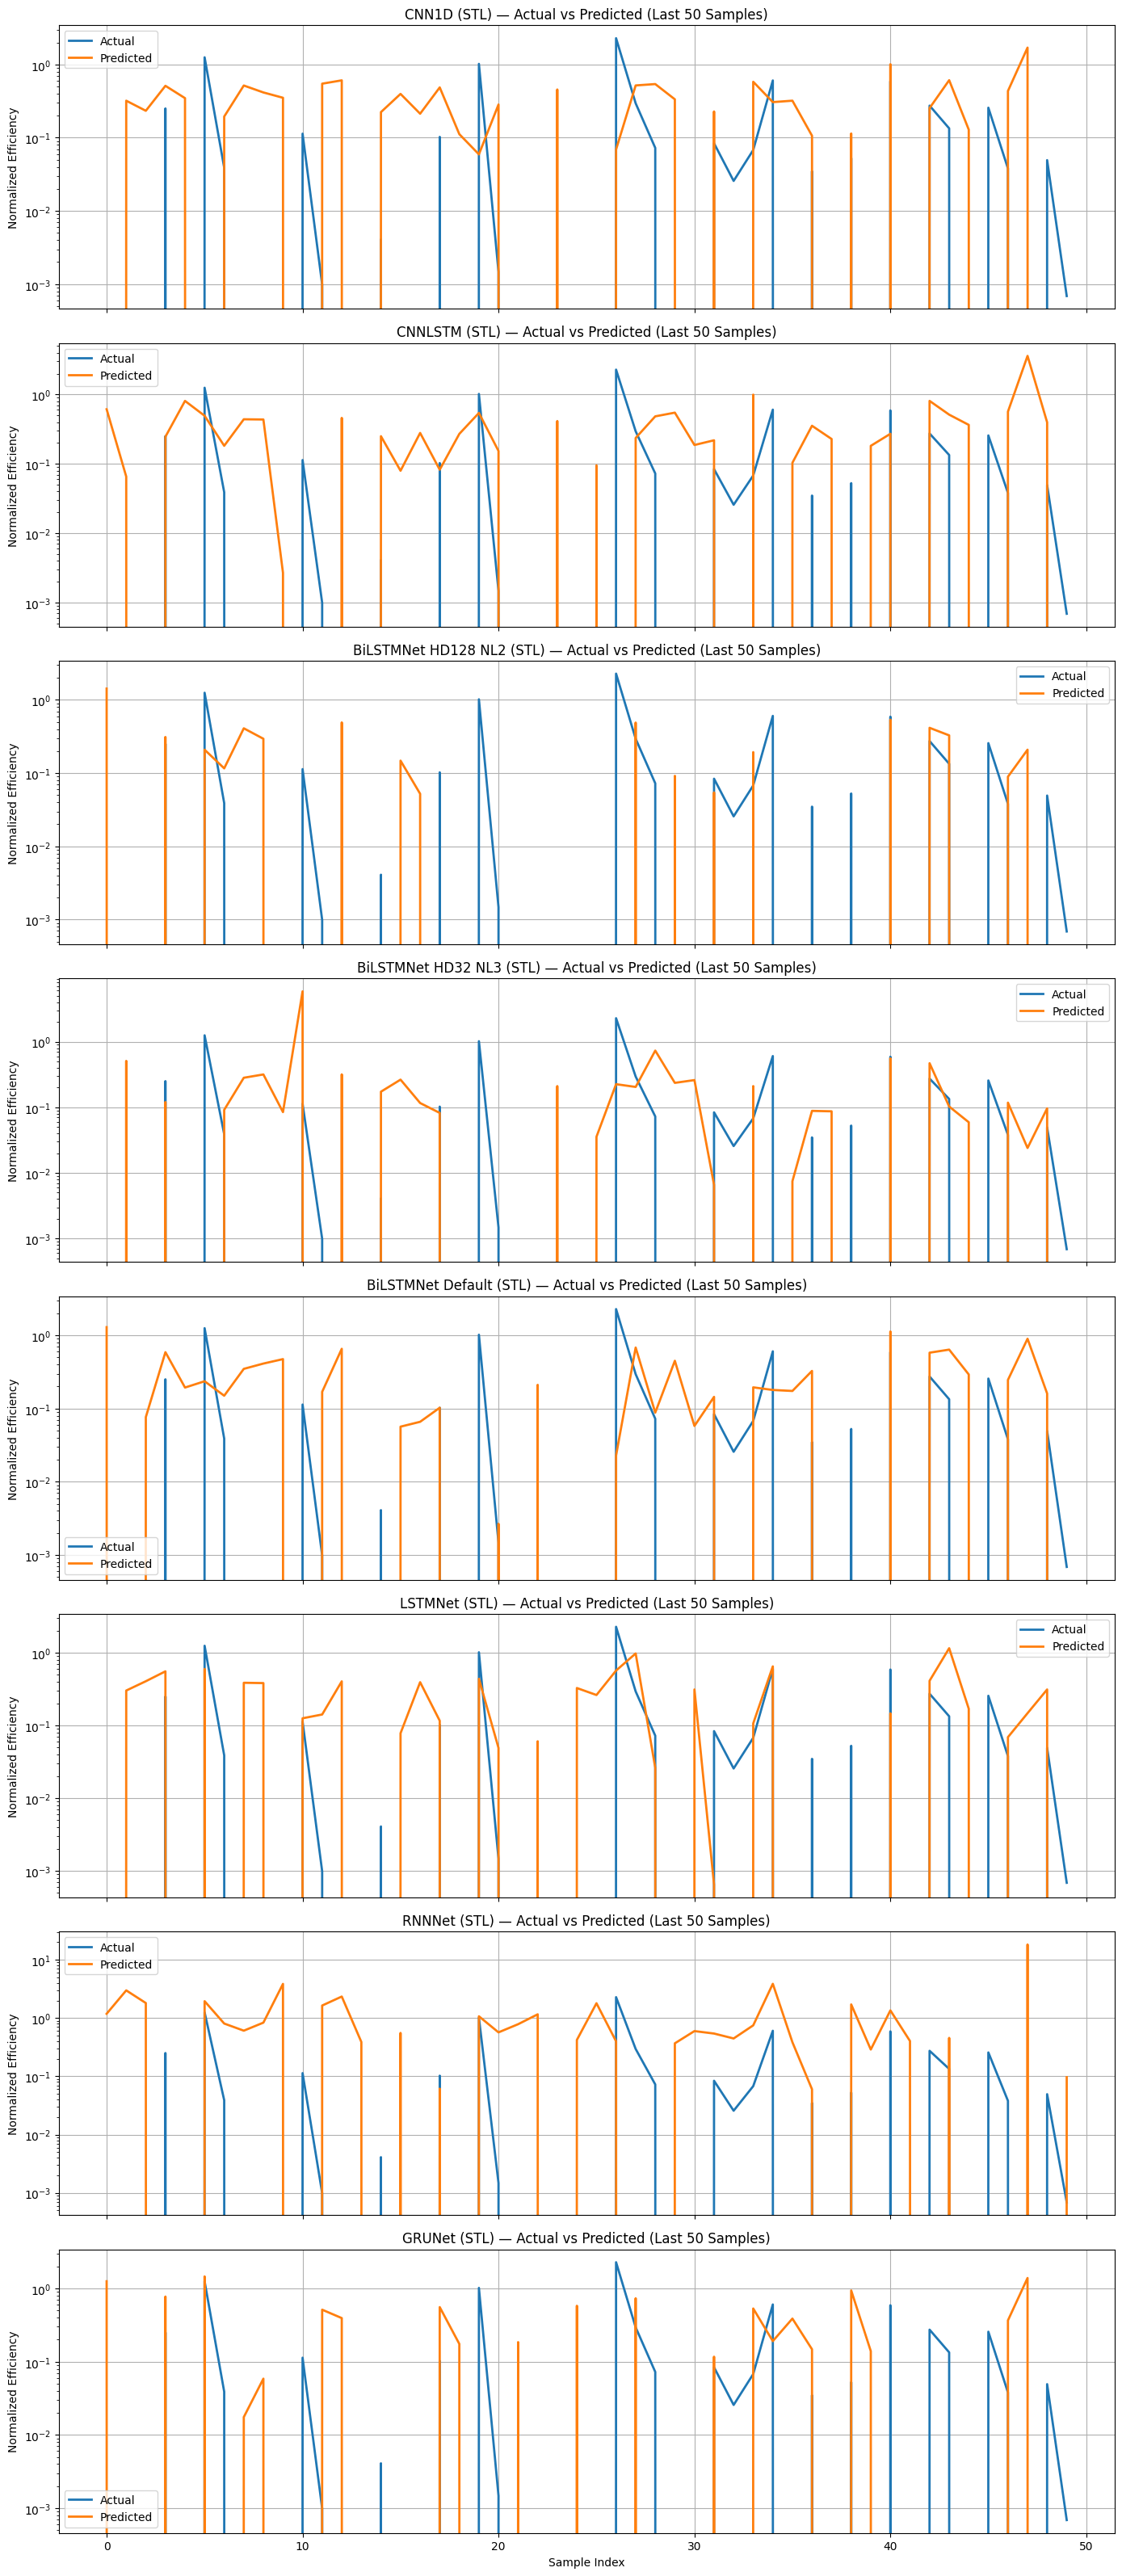

In [84]:
fig, axes = plt.subplots(len(ts_nets_stl), 1, figsize=(14, 4 * len(ts_nets_stl)), sharex=True)
samples_number = 50

for i, (name, model) in enumerate(ts_nets_stl.items()):
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_stl_test_tensor).cpu().numpy()
        y_pred = y_scaler_stl.inverse_transform(y_pred_scaled)
        y_true = y_scaler_stl.inverse_transform(y_stl_test_tensor.cpu().numpy())

    y_pred_last = y_pred[-samples_number:]
    y_true_last = y_true[-samples_number:]

    axes[i].plot(y_true_last, label='Actual', linewidth=2)
    axes[i].plot(y_pred_last, label='Predicted', linewidth=2)
    axes[i].set_yscale('log')
    axes[i].set_title(f"{name} (STL) — Actual vs Predicted (Last {samples_number} Samples)")
    axes[i].set_ylabel("Normalized Efficiency")
    axes[i].legend()
    axes[i].grid(True)

axes[-1].set_xlabel("Sample Index")
plt.tight_layout()
plt.show()

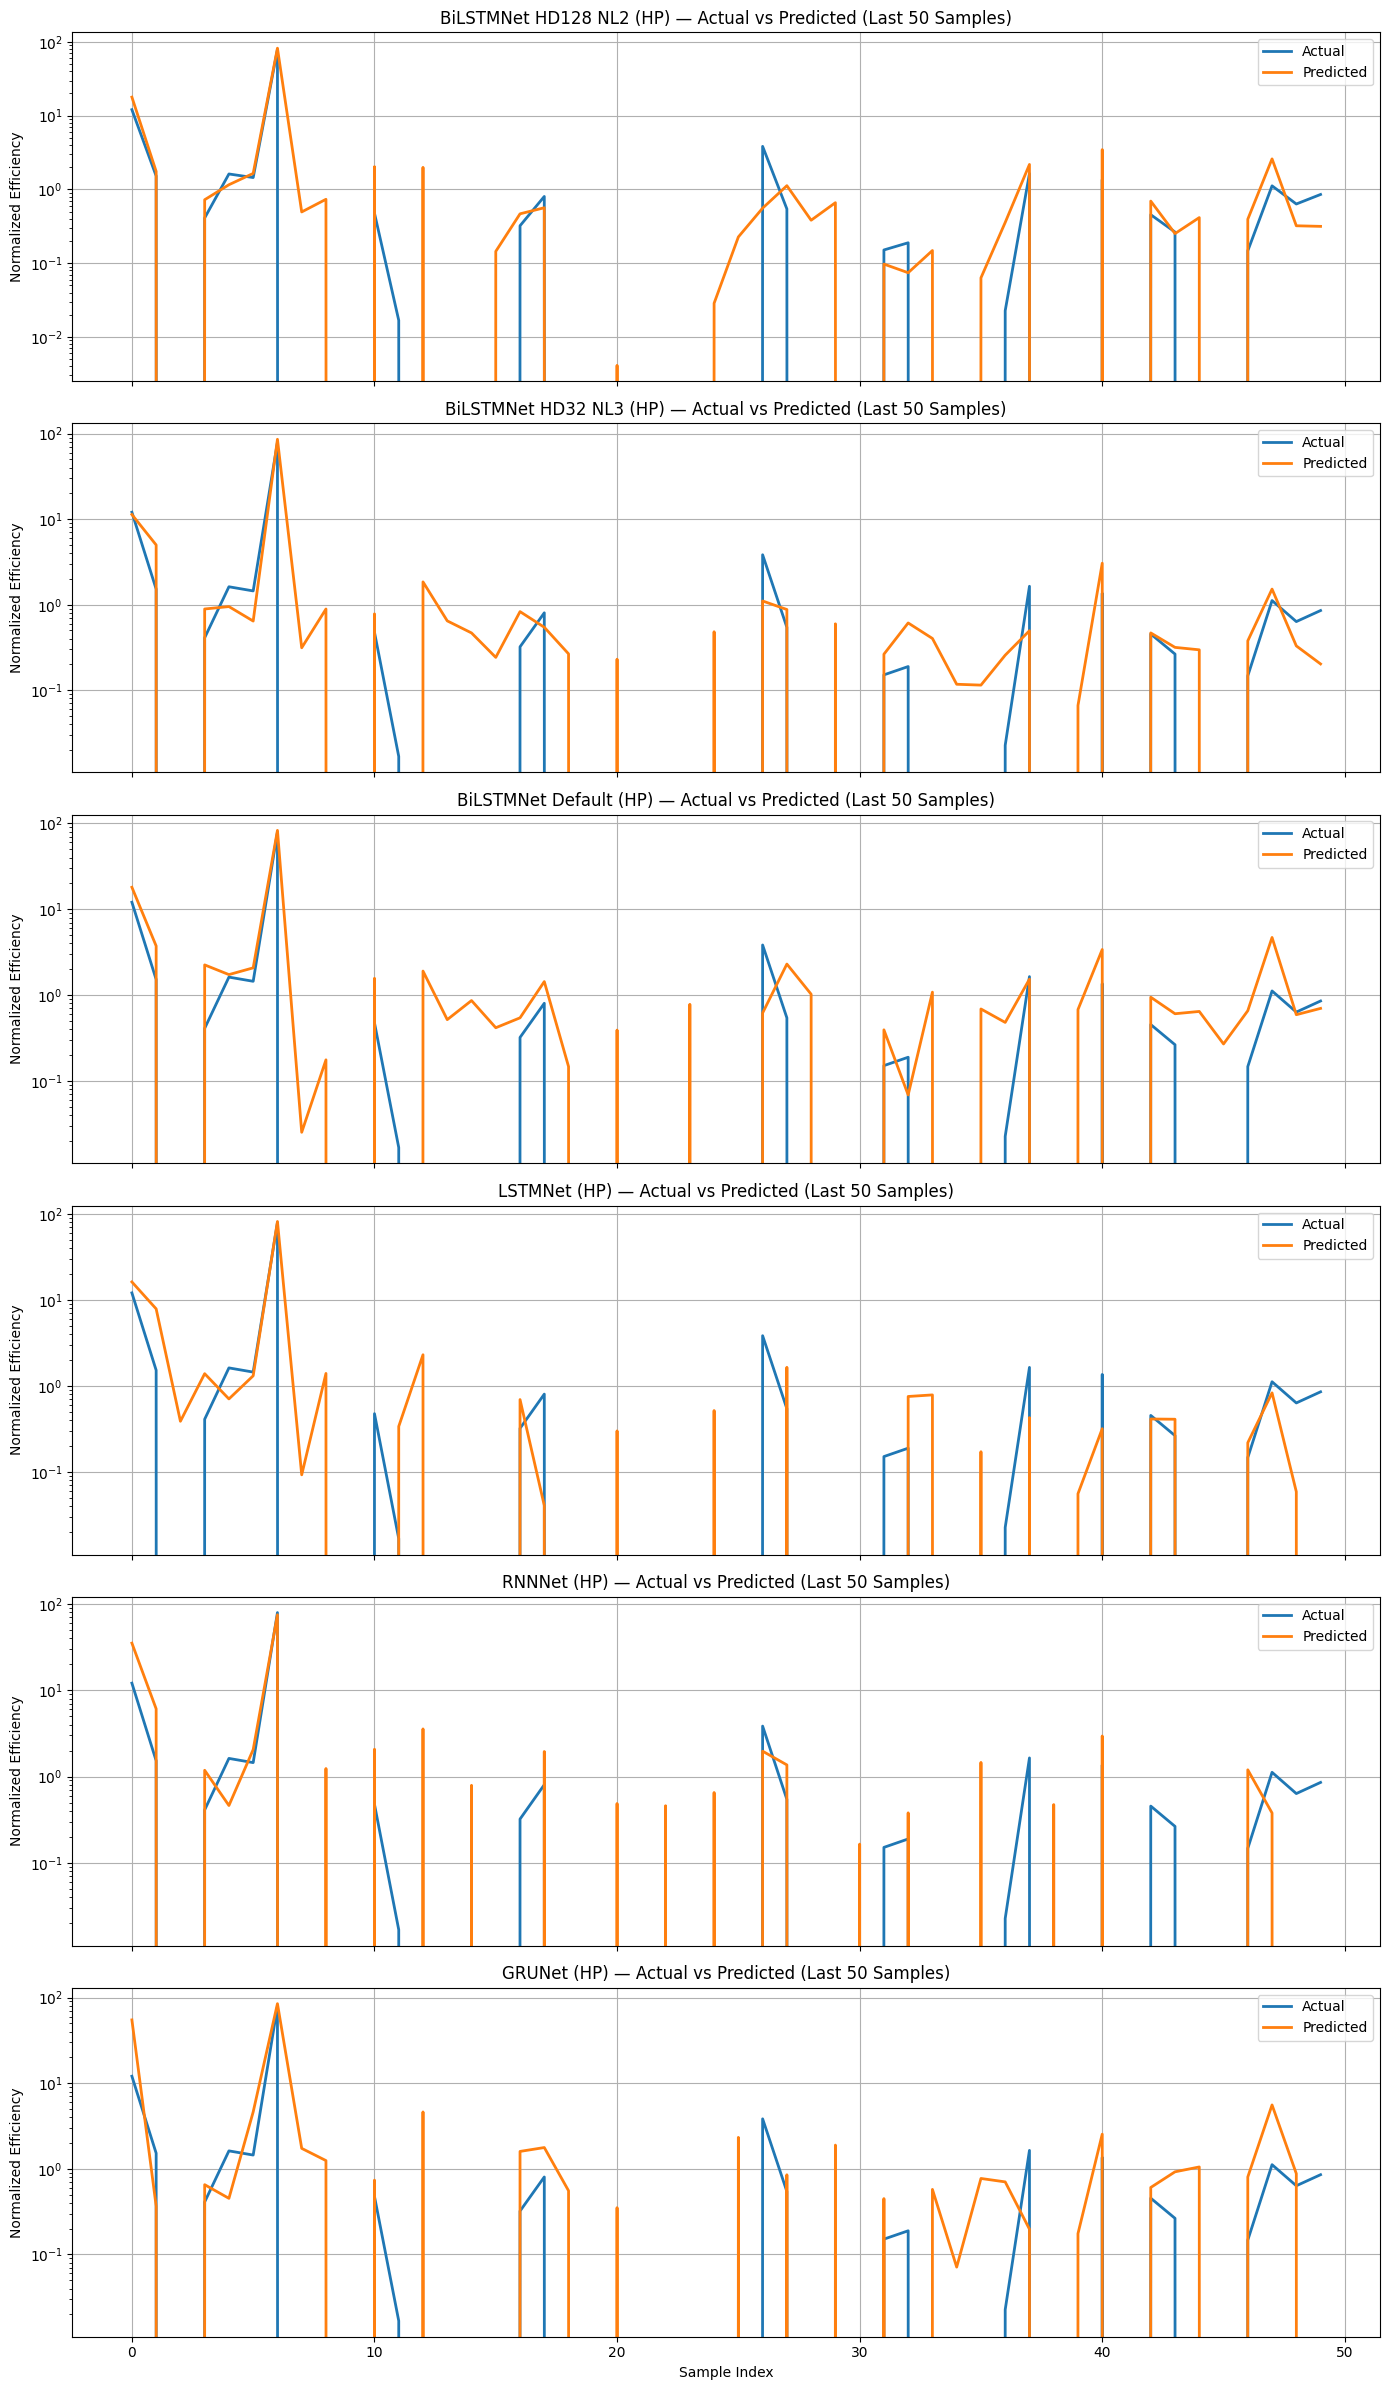

In [81]:
fig, axes = plt.subplots(len(ts_nets_hp), 1, figsize=(14, 4 * len(ts_nets_hp)), sharex=True)
samples_number = 50  

for i, (name, model) in enumerate(ts_nets_hp.items()):
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_hp_test_tensor).cpu().numpy()
        y_pred = y_scaler_hp.inverse_transform(y_pred_scaled)
        y_true = y_scaler_hp.inverse_transform(y_hp_test_tensor.cpu().numpy())

    y_pred_last = y_pred[-samples_number:]
    y_true_last = y_true[-samples_number:]

    axes[i].plot(y_true_last, label='Actual', linewidth=2)
    axes[i].plot(y_pred_last, label='Predicted', linewidth=2)
    axes[i].set_yscale('log')
    axes[i].set_title(f"{name} (HP) — Actual vs Predicted (Last {samples_number} Samples)")
    axes[i].set_ylabel("Normalized Efficiency")
    axes[i].legend()
    axes[i].grid(True)

axes[-1].set_xlabel("Sample Index")
plt.tight_layout()
plt.show()

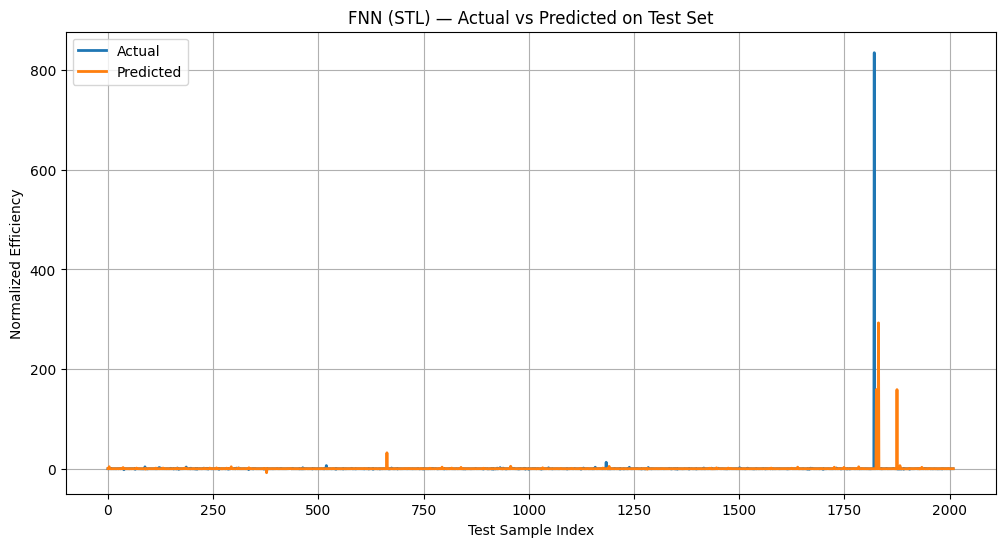

In [85]:
model_fnn_stl = nets_stl_tabular["FNN"]
model_fnn_stl.eval()
with torch.no_grad():
    y_pred_fnn = model_fnn_stl(X_stl_test_tensor_tabular).cpu().numpy()
    y_true_fnn = y_stl_test_tensor.cpu().numpy()

plt.figure(figsize=(12, 6))
plt.plot(y_true_fnn, label="Actual", linewidth=2)
plt.plot(y_pred_fnn, label="Predicted", linewidth=2)
plt.title("FNN (STL) — Actual vs Predicted on Test Set")
plt.xlabel("Test Sample Index")
plt.ylabel("Normalized Efficiency")
plt.legend()
plt.grid(True)
plt.show()

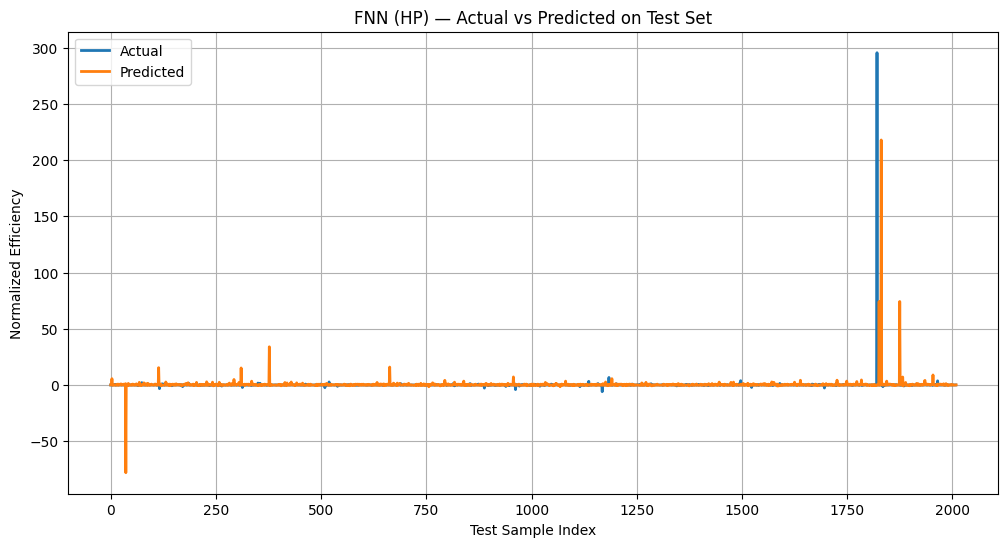

In [86]:
model_fnn_hp = nets_hp_tabular["FNN"]
model_fnn_hp.eval()
with torch.no_grad():
    y_pred_fnn = model_fnn_hp(X_hp_test_tensor_tabular).cpu().numpy()
    y_true_fnn = y_hp_test_tensor.cpu().numpy()

plt.figure(figsize=(12, 6))
plt.plot(y_true_fnn, label="Actual", linewidth=2)
plt.plot(y_pred_fnn, label="Predicted", linewidth=2)
plt.title("FNN (HP) — Actual vs Predicted on Test Set")
plt.xlabel("Test Sample Index")
plt.ylabel("Normalized Efficiency")
plt.legend()
plt.grid(True)
plt.show()

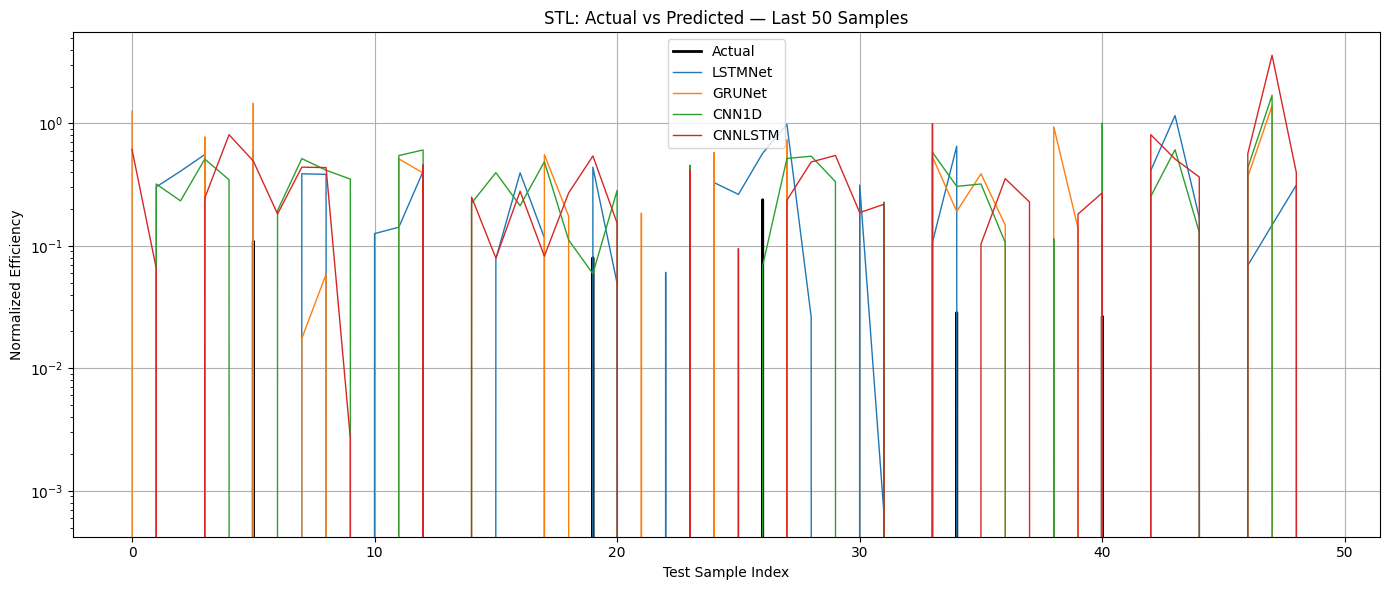

In [90]:
window = 50
start = len(y_true) - window
end = len(y_true)

plt.figure(figsize=(14, 6))
plt.plot(y_true[start:end], label="Actual", linewidth=2, color="black")

for name in models_to_compare:
    if name in ts_nets_stl:
        net = ts_nets_stl[name]
        with torch.no_grad():
            y_pred = net(X_stl_test_tensor).cpu().numpy().ravel()
            y_pred = y_scaler_stl.inverse_transform(y_pred.reshape(-1,1)).ravel()
    else:
        net = nets_stl_tabular[name]
        with torch.no_grad():
            y_pred = net(X_stl_test_tensor_tabular).cpu().numpy().ravel()
            y_pred = y_scaler_stl.inverse_transform(y_pred.reshape(-1,1)).ravel()

    plt.plot(y_pred[start:end], label=name, linewidth=1)

plt.yscale("log")
plt.title(f"STL: Actual vs Predicted — Last {window} Samples")
plt.xlabel("Test Sample Index")
plt.ylabel("Normalized Efficiency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


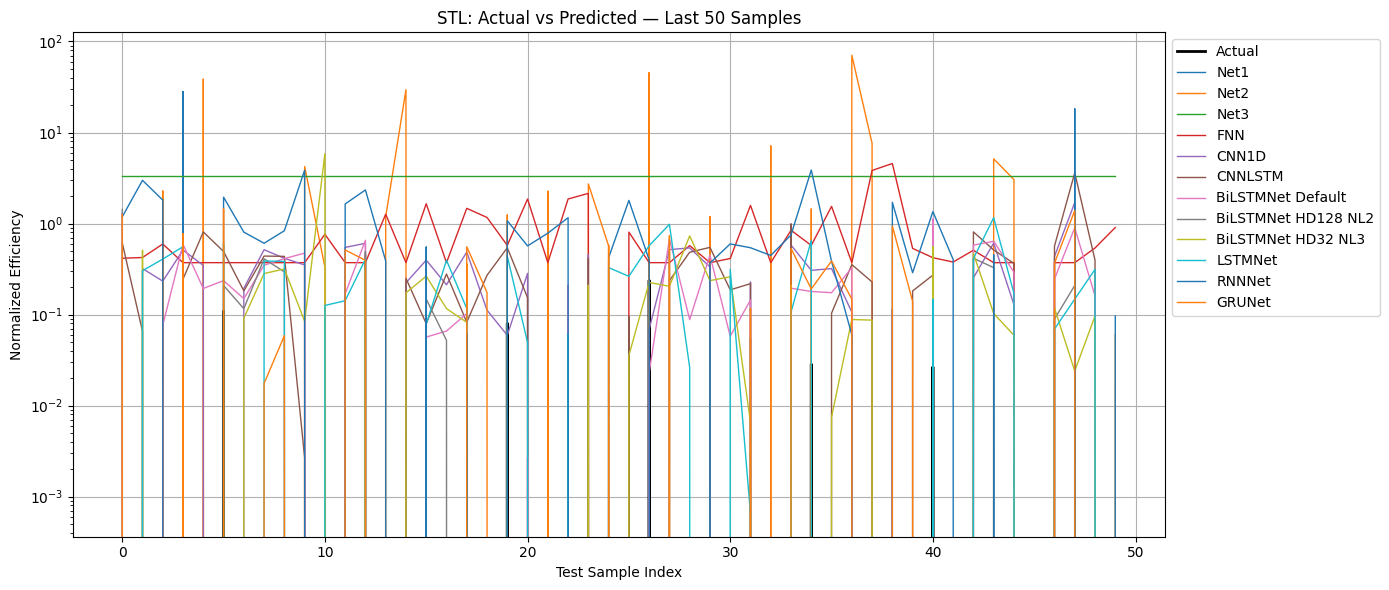

In [91]:
# 1) Gather all model names
models_to_compare = [
    # Tabular
    "Net1", "Net2", "Net3", "FNN",
    # Sequence
    "CNN1D", "CNNLSTM",
    "BiLSTMNet Default", "BiLSTMNet HD128 NL2", "BiLSTMNet HD32 NL3",
    "LSTMNet", "RNNNet", "GRUNet"
]

# 2) Compute true values once
y_true = y_stl_test_tensor.cpu().numpy().ravel()

# 3) Define window
window = 50
start = len(y_true) - window
end   = len(y_true)

# 4) Plot
plt.figure(figsize=(14, 6))
plt.plot(y_true[start:end], label="Actual", linewidth=2, color="black")

for name in models_to_compare:
    # Determine which dict the model lives in
    if name in ts_nets_stl:
        net = ts_nets_stl[name]
        X_in = X_stl_test_tensor
        # sequence scaler
        scaler = y_scaler_stl
    else:
        net = nets_stl_tabular[name]
        X_in = X_stl_test_tensor_tabular
        scaler = y_scaler_stl  # same target scaler

    net.eval()
    with torch.no_grad():
        y_pred = net(X_in).cpu().numpy().ravel()
        y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()

    plt.plot(y_pred[start:end], label=name, linewidth=1)

plt.yscale("log")
plt.title(f"STL: Actual vs Predicted — Last {window} Samples")
plt.xlabel("Test Sample Index")
plt.ylabel("Normalized Efficiency")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid(True)
plt.tight_layout()
plt.show()
